In [1]:
import os
import numpy as np
import glob
from skimage.io import imread,imsave
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import random
import tqdm
import keras
from tqdm.notebook import tqdm_notebook
import yaml
from dvclive.keras import DVCLiveCallback
from loss import tversky_loss, focal_tversky,sdice_loss, dice_loss,log_cosh_dice_loss

In [2]:
tf.config.list_physical_devices('GPU')
params = yaml.safe_load(open("params.yaml"))['model_params']

In [3]:
# Specify the size of patches and number of classes expected by the model.
image_size = params['Image_patch_size']
mask_size = params['Mask_patch_size']
num_class = params['Number_of_classes']
lr = params['Learning_rate']
batchsize = params['Batch_size']
optimizer = params['Optimizer']
epochs = params['Epochs']

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
PATH = 'tfrecords/'
BATCH_SIZE = batchsize

In [5]:
FILENAMES = tf.io.gfile.glob(PATH +"*large_images.tfrecords")
split_ind = int(0.7 * len(FILENAMES))
TRAINING_FILENAMES, VALID_FILENAMES = FILENAMES[:split_ind], FILENAMES[split_ind:]
print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))

Train TFRecord Files: 10
Validation TFRecord Files: 5


In [6]:
def read_tfrecord(example):
    tfrecord_format = (
        {
         "image":tf.io.FixedLenFeature(shape=[*image_size], dtype=tf.float32),
         "mask":tf.io.FixedLenFeature(shape=[*mask_size], dtype=tf.float32)
        }
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = example["image"]
    mask = example["mask"]
    mask = tf.one_hot(tf.cast(mask, tf.uint8), 2)
    return image,mask

In [7]:
from functools import partial

In [8]:
def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

In [9]:
seed=42

In [10]:
def augmentation(image, mask):
    # both use the same seed, so they'll make the same random changes
    flip_image = tf.image.random_flip_left_right(image,seed=seed)
    flip_mask = tf.image.random_flip_left_right(mask,seed=seed)
    # Other transformations...
    return flip_image, flip_mask

In [11]:
def get_dataset(filenames):
    dataset = tf.data.Dataset.range(10)
    dataset = load_dataset(filenames).cache().repeat()
    # to avoid data loss error
    dataset = dataset.apply(tf.data.experimental.ignore_errors())
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [12]:
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)

  0%|          | 0/3 [00:00<?, ?it/s]

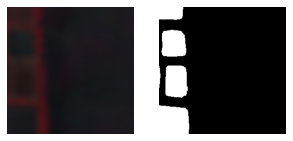

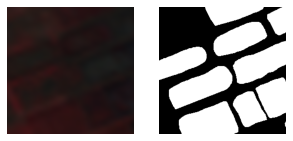

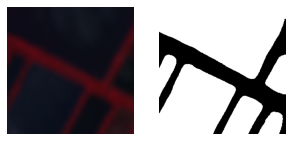

In [13]:
image_batch, label_batch = next(iter(train_dataset))
for i in tqdm_notebook(range(3)):
    image = image_batch[i]
    mask = label_batch[i]
    #Convert categorical to integer for visualization
    mask = np.argmax(mask, axis=2)
    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0:3])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

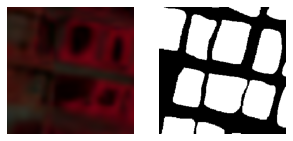

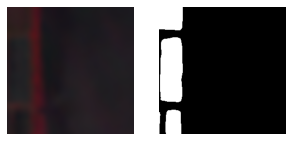

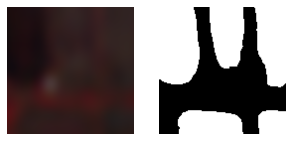

In [14]:
testimage_batch, label_batch = next(iter(valid_dataset))
for i in tqdm_notebook(range(3)):
    image = testimage_batch[i]
    mask = label_batch[i]
    #Convert categorical to integer for visualization
    mask = np.argmax(mask, axis=2)
    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0:3])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

In [15]:
# GPUS = ["GPU:0","GPU:1","GPU:2","GPU:3"]
# strategy = tf.distribute.MirroredStrategy( GPUS )
# print('Number of devices: %d' % strategy.num_replicas_in_sync)

In [16]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


Number of devices: 4


In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input, GlobalAveragePooling2D, Dense, Multiply
from keras.applications.resnet import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D

In [18]:
# input dimensions, no. of channels, and no. of classes for the model
IMG_HEIGHT = image_batch.shape[1]
IMG_WIDTH  = image_batch.shape[2]
IMG_CHANNELS = image_batch.shape[3]
n_classes=num_class

In [19]:
def SqueezeAndExcitation(inputs, ratio=8):
    
    b, h, w, c = inputs.shape
    
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(c//ratio, activation='relu', use_bias=False)(x)
    x = Dense(c, activation='sigmoid', use_bias=False)(x)
    
    x = Multiply()([inputs, x])
    
    return x


def ASPP(image_features):

    shape = image_features.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]))(image_features)
    y_pool = Conv2D(filters=128, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=128, kernel_size=1, padding='same', use_bias=False)(image_features)
    y_1 = BatchNormalization(name=f'bn_2')(y_1)
    y_1 = Activation('relu', name=f'relu_2')(y_1)

    y_6 = Conv2D(filters=128, kernel_size=3, padding='same', dilation_rate = 6,use_bias=False)(image_features)
    y_6 = BatchNormalization(name=f'bn_3')(y_6)
    y_6 = Activation('relu', name=f'relu_3')(y_6)

    y_12 = Conv2D(filters=128, kernel_size=1, padding='same', dilation_rate = 12,use_bias=False)(image_features)
    y_12 = BatchNormalization(name=f'bn_4')(y_12)
    y_12 = Activation('relu', name=f'relu_4')(y_12)

    y_18 = Conv2D(filters=128, kernel_size=3, padding='same', dilation_rate = 6,use_bias=False)(image_features)
    y_18 = BatchNormalization(name=f'bn_5')(y_18)
    y_18 = Activation('relu', name=f'relu_5')(y_18)

    y_c = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=128, kernel_size=1, padding='same', use_bias=False)(y_c)
    y = BatchNormalization(name=f'bn_6')(y)
    y = Activation('relu', name=f'relu_6')(y)

    return y

In [20]:
def DeepLabV3PlusSE(inputs, classes=1):

    inputs = Input(inputs)

    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    high_level_image_features = base_model.get_layer('conv4_block6_add').output
    high_level_image_features = SqueezeAndExcitation(high_level_image_features, ratio=16)
    
    x_a = ASPP(high_level_image_features)
    x_a = SqueezeAndExcitation(x_a, ratio=16)
    x_a = UpSampling2D(size=4, interpolation='bilinear')(x_a)

    low_level_image_features = base_model.get_layer('conv2_block3_add').output
    low_level_image_features = SqueezeAndExcitation(low_level_image_features, ratio=16)

    x_b = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(low_level_image_features)
    x_b = BatchNormalization(name=f'bn_7')(x_b)
    x_b = Activation('relu', name=f'relu_7')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_8')(x)
    x = Activation('relu', name=f'relu_8')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_9')(x)
    x = Activation('relu', name=f'relu_9')(x)

    x = UpSampling2D(size=4, interpolation='bilinear')(x)

    """ Outputs """
    x = Conv2D(classes, (1, 1), name='output_layer')(x)
    
    if classes == 1:
      x = Activation('sigmoid')(x)
    else:
      x = Activation('softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    
    return model

In [21]:
loss = params['Loss']
if loss == 'sdice_loss':
    with strategy.scope():
        model = DeepLabV3PlusSE((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),n_classes)
        model.compile(
        optimizer=optimizer,
        loss=sdice_loss,
        metrics=[[tf.keras.metrics.OneHotIoU(num_classes=2,target_class_ids=[0,1]),tf.keras.metrics.Precision()\
            ,tf.keras.metrics.Recall()]]
        )
elif loss == 'focal_tversky':
    with strategy.scope():
        model = DeepLabV3PlusSE((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),n_classes)
        model.compile(
        optimizer=optimizer,
        loss=focal_tversky,
        metrics=[[tf.keras.metrics.OneHotIoU(num_classes=2,target_class_ids=[0,1]),tf.keras.metrics.Precision()\
            ,tf.keras.metrics.Recall()]]
        )
elif loss == 'tversky_loss':
    with strategy.scope():
        model = DeepLabV3PlusSE((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),n_classes)
        model.compile(
        optimizer=optimizer,
        loss=tversky_loss,
        metrics=[[tf.keras.metrics.OneHotIoU(num_classes=2,target_class_ids=[0,1]),tf.keras.metrics.Precision()\
            ,tf.keras.metrics.Recall()]]
        )
elif loss == 'log_cosh_dice_loss':
    with strategy.scope():
        model = DeepLabV3PlusSE((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),n_classes)
        model.compile(
        optimizer=optimizer,
        loss=log_cosh_dice_loss,
        metrics=[[tf.keras.metrics.OneHotIoU(num_classes=2,target_class_ids=[0,1]),tf.keras.metrics.Precision()\
            ,tf.keras.metrics.Recall()]]
        )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [22]:
# calculation of steps per epoch for traning and validation
filespershard = 500
number_of_shards = len(glob.glob(PATH+'*.tfrecords'))
steps_per_epoch = (number_of_shards*filespershard*0.7)// BATCH_SIZE
val_steps_per_epoch = (number_of_shards*filespershard*0.3)//BATCH_SIZE

In [23]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger,LearningRateScheduler,TensorBoard

In [24]:
#ModelCheckpoint callback saves a model at some interval. 
checkpoint_path = 'model_checkpoint/'
os.makedirs(checkpoint_path, exist_ok=True)
filepath=checkpoint_path+"resenet50_deeplabv3plus_SE_v5_sdice_loss.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_one_hot_io_u', verbose=1, save_best_only=True, mode='max')

In [25]:
# earlystop for stopping the model when there is no improvement
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
log_csv = CSVLogger('/home/ubuntu/Notebooks for Unet_training/models for deeplab+SE v5/tversky-logs/sdice_lossv1.csv', separator=',', append=False)

In [26]:
epochs=epochs
learning_rate = lr
decay_rate = learning_rate / epochs
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate

In [27]:
lr_rate = LearningRateScheduler(exp_decay)

In [28]:
callbacks_list = [checkpoint,early_stop,lr_rate,DVCLiveCallback(dir='evaluation',save_dvc_exp=True)]

In [29]:
%%time
history=model.fit(train_dataset,
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          verbose=1,
          validation_data=valid_dataset,
          validation_steps=val_steps_per_epoch,
          callbacks=callbacks_list,
          )

Epoch 1/10


INFO:tensorflow:batch_all_reduce: 207 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 207 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 207 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 207 all-reduces with algorithm = nccl, num_packs = 1


  1/328 [..............................] - ETA: 5:30:07 - loss: 0.3741 - one_hot_io_u: 0.3315 - precision: 0.5052 - recall: 0.5052

  2/328 [..............................] - ETA: 24s - loss: 0.3408 - one_hot_io_u: 0.3804 - precision: 0.5525 - recall: 0.5525    

  3/328 [..............................] - ETA: 24s - loss: 0.3122 - one_hot_io_u: 0.4159 - precision: 0.5880 - recall: 0.5880

  4/328 [..............................] - ETA: 24s - loss: 0.2952 - one_hot_io_u: 0.4501 - precision: 0.6212 - recall: 0.6212

  5/328 [..............................] - ETA: 23s - loss: 0.2781 - one_hot_io_u: 0.4767 - precision: 0.6459 - recall: 0.6459

  6/328 [..............................] - ETA: 23s - loss: 0.2721 - one_hot_io_u: 0.4888 - precision: 0.6570 - recall: 0.6570

  7/328 [..............................] - ETA: 23s - loss: 0.2668 - one_hot_io_u: 0.4976 - precision: 0.6646 - recall: 0.6646

  8/328 [..............................] - ETA: 23s - loss: 0.2592 - one_hot_io_u: 0.5115 - precision: 0.6769 - recall: 0.6769

  9/328 [..............................] - ETA: 23s - loss: 0.2562 - one_hot_io_u: 0.5202 - precision: 0.6848 - recall: 0.6848

 10/328 [..............................] - ETA: 23s - loss: 0.2460 - one_hot_io_u: 0.5359 - precision: 0.6983 - recall: 0.6983

 11/328 [>.............................] - ETA: 23s - loss: 0.2360 - one_hot_io_u: 0.5506 - precision: 0.7107 - recall: 0.7107

 12/328 [>.............................] - ETA: 23s - loss: 0.2335 - one_hot_io_u: 0.5556 - precision: 0.7154 - recall: 0.7154

 13/328 [>.............................] - ETA: 23s - loss: 0.2302 - one_hot_io_u: 0.5620 - precision: 0.7210 - recall: 0.7210

 14/328 [>.............................] - ETA: 23s - loss: 0.2281 - one_hot_io_u: 0.5658 - precision: 0.7245 - recall: 0.7245

 15/328 [>.............................] - ETA: 23s - loss: 0.2257 - one_hot_io_u: 0.5690 - precision: 0.7276 - recall: 0.7276

 16/328 [>.............................] - ETA: 23s - loss: 0.2233 - one_hot_io_u: 0.5731 - precision: 0.7311 - recall: 0.7311

 17/328 [>.............................] - ETA: 23s - loss: 0.2186 - one_hot_io_u: 0.5802 - precision: 0.7370 - recall: 0.7370

 18/328 [>.............................] - ETA: 23s - loss: 0.2144 - one_hot_io_u: 0.5860 - precision: 0.7420 - recall: 0.7420

 19/328 [>.............................] - ETA: 23s - loss: 0.2128 - one_hot_io_u: 0.5886 - precision: 0.7447 - recall: 0.7447

 20/328 [>.............................] - ETA: 23s - loss: 0.2133 - one_hot_io_u: 0.5884 - precision: 0.7450 - recall: 0.7450

 21/328 [>.............................] - ETA: 23s - loss: 0.2088 - one_hot_io_u: 0.5949 - precision: 0.7503 - recall: 0.7503

 22/328 [=>............................] - ETA: 22s - loss: 0.2069 - one_hot_io_u: 0.5984 - precision: 0.7534 - recall: 0.7534

 23/328 [=>............................] - ETA: 22s - loss: 0.2078 - one_hot_io_u: 0.5975 - precision: 0.7524 - recall: 0.7524

 24/328 [=>............................] - ETA: 22s - loss: 0.2041 - one_hot_io_u: 0.6029 - precision: 0.7570 - recall: 0.7570

 25/328 [=>............................] - ETA: 22s - loss: 0.2010 - one_hot_io_u: 0.6074 - precision: 0.7607 - recall: 0.7607

 26/328 [=>............................] - ETA: 22s - loss: 0.1992 - one_hot_io_u: 0.6102 - precision: 0.7630 - recall: 0.7630

 27/328 [=>............................] - ETA: 22s - loss: 0.2011 - one_hot_io_u: 0.6072 - precision: 0.7606 - recall: 0.7606

 28/328 [=>............................] - ETA: 22s - loss: 0.1994 - one_hot_io_u: 0.6100 - precision: 0.7626 - recall: 0.7626

 29/328 [=>............................] - ETA: 22s - loss: 0.1997 - one_hot_io_u: 0.6101 - precision: 0.7625 - recall: 0.7625

 30/328 [=>............................] - ETA: 22s - loss: 0.1981 - one_hot_io_u: 0.6123 - precision: 0.7644 - recall: 0.7644

 31/328 [=>............................] - ETA: 22s - loss: 0.1998 - one_hot_io_u: 0.6099 - precision: 0.7628 - recall: 0.7628

 32/328 [=>............................] - ETA: 22s - loss: 0.1969 - one_hot_io_u: 0.6141 - precision: 0.7661 - recall: 0.7661

 33/328 [==>...........................] - ETA: 22s - loss: 0.1935 - one_hot_io_u: 0.6191 - precision: 0.7702 - recall: 0.7702

 34/328 [==>...........................] - ETA: 21s - loss: 0.1937 - one_hot_io_u: 0.6185 - precision: 0.7698 - recall: 0.7698

 35/328 [==>...........................] - ETA: 21s - loss: 0.1923 - one_hot_io_u: 0.6206 - precision: 0.7715 - recall: 0.7715

 36/328 [==>...........................] - ETA: 21s - loss: 0.1917 - one_hot_io_u: 0.6217 - precision: 0.7721 - recall: 0.7721

 37/328 [==>...........................] - ETA: 21s - loss: 0.1911 - one_hot_io_u: 0.6227 - precision: 0.7728 - recall: 0.7728

 38/328 [==>...........................] - ETA: 21s - loss: 0.1905 - one_hot_io_u: 0.6237 - precision: 0.7735 - recall: 0.7735

 39/328 [==>...........................] - ETA: 21s - loss: 0.1896 - one_hot_io_u: 0.6254 - precision: 0.7747 - recall: 0.7747

 40/328 [==>...........................] - ETA: 21s - loss: 0.1879 - one_hot_io_u: 0.6275 - precision: 0.7765 - recall: 0.7765

 41/328 [==>...........................] - ETA: 21s - loss: 0.1865 - one_hot_io_u: 0.6297 - precision: 0.7784 - recall: 0.7784

 42/328 [==>...........................] - ETA: 21s - loss: 0.1874 - one_hot_io_u: 0.6281 - precision: 0.7776 - recall: 0.7776

 43/328 [==>...........................] - ETA: 21s - loss: 0.1867 - one_hot_io_u: 0.6290 - precision: 0.7785 - recall: 0.7785

 44/328 [===>..........................] - ETA: 21s - loss: 0.1859 - one_hot_io_u: 0.6301 - precision: 0.7792 - recall: 0.7792

 45/328 [===>..........................] - ETA: 21s - loss: 0.1868 - one_hot_io_u: 0.6287 - precision: 0.7784 - recall: 0.7784

 46/328 [===>..........................] - ETA: 21s - loss: 0.1865 - one_hot_io_u: 0.6289 - precision: 0.7784 - recall: 0.7784

 47/328 [===>..........................] - ETA: 21s - loss: 0.1857 - one_hot_io_u: 0.6301 - precision: 0.7793 - recall: 0.7793

 48/328 [===>..........................] - ETA: 21s - loss: 0.1867 - one_hot_io_u: 0.6287 - precision: 0.7783 - recall: 0.7783

 49/328 [===>..........................] - ETA: 21s - loss: 0.1854 - one_hot_io_u: 0.6305 - precision: 0.7798 - recall: 0.7798

 50/328 [===>..........................] - ETA: 21s - loss: 0.1846 - one_hot_io_u: 0.6320 - precision: 0.7810 - recall: 0.7810

 51/328 [===>..........................] - ETA: 20s - loss: 0.1830 - one_hot_io_u: 0.6347 - precision: 0.7828 - recall: 0.7828

 52/328 [===>..........................] - ETA: 20s - loss: 0.1832 - one_hot_io_u: 0.6343 - precision: 0.7826 - recall: 0.7826

 53/328 [===>..........................] - ETA: 20s - loss: 0.1832 - one_hot_io_u: 0.6339 - precision: 0.7826 - recall: 0.7826

 54/328 [===>..........................] - ETA: 20s - loss: 0.1826 - one_hot_io_u: 0.6349 - precision: 0.7833 - recall: 0.7833

 55/328 [====>.........................] - ETA: 20s - loss: 0.1814 - one_hot_io_u: 0.6365 - precision: 0.7846 - recall: 0.7846

 56/328 [====>.........................] - ETA: 20s - loss: 0.1817 - one_hot_io_u: 0.6360 - precision: 0.7843 - recall: 0.7843

 57/328 [====>.........................] - ETA: 20s - loss: 0.1811 - one_hot_io_u: 0.6369 - precision: 0.7849 - recall: 0.7849

 58/328 [====>.........................] - ETA: 20s - loss: 0.1806 - one_hot_io_u: 0.6376 - precision: 0.7855 - recall: 0.7855

 59/328 [====>.........................] - ETA: 20s - loss: 0.1799 - one_hot_io_u: 0.6385 - precision: 0.7861 - recall: 0.7861

 60/328 [====>.........................] - ETA: 20s - loss: 0.1791 - one_hot_io_u: 0.6398 - precision: 0.7872 - recall: 0.7872

 61/328 [====>.........................] - ETA: 20s - loss: 0.1782 - one_hot_io_u: 0.6412 - precision: 0.7881 - recall: 0.7881

 62/328 [====>.........................] - ETA: 20s - loss: 0.1775 - one_hot_io_u: 0.6422 - precision: 0.7890 - recall: 0.7890

 63/328 [====>.........................] - ETA: 20s - loss: 0.1769 - one_hot_io_u: 0.6430 - precision: 0.7898 - recall: 0.7898

 64/328 [====>.........................] - ETA: 20s - loss: 0.1775 - one_hot_io_u: 0.6423 - precision: 0.7894 - recall: 0.7894

 65/328 [====>.........................] - ETA: 19s - loss: 0.1775 - one_hot_io_u: 0.6423 - precision: 0.7893 - recall: 0.7893

 66/328 [=====>........................] - ETA: 19s - loss: 0.1784 - one_hot_io_u: 0.6408 - precision: 0.7884 - recall: 0.7884

 67/328 [=====>........................] - ETA: 19s - loss: 0.1778 - one_hot_io_u: 0.6414 - precision: 0.7891 - recall: 0.7891

 68/328 [=====>........................] - ETA: 19s - loss: 0.1772 - one_hot_io_u: 0.6424 - precision: 0.7897 - recall: 0.7897

 69/328 [=====>........................] - ETA: 19s - loss: 0.1774 - one_hot_io_u: 0.6422 - precision: 0.7895 - recall: 0.7895

 70/328 [=====>........................] - ETA: 19s - loss: 0.1774 - one_hot_io_u: 0.6426 - precision: 0.7898 - recall: 0.7898

 71/328 [=====>........................] - ETA: 19s - loss: 0.1770 - one_hot_io_u: 0.6432 - precision: 0.7902 - recall: 0.7902

 72/328 [=====>........................] - ETA: 19s - loss: 0.1763 - one_hot_io_u: 0.6441 - precision: 0.7909 - recall: 0.7909

 73/328 [=====>........................] - ETA: 19s - loss: 0.1760 - one_hot_io_u: 0.6446 - precision: 0.7913 - recall: 0.7913

 74/328 [=====>........................] - ETA: 19s - loss: 0.1763 - one_hot_io_u: 0.6439 - precision: 0.7907 - recall: 0.7907

 75/328 [=====>........................] - ETA: 19s - loss: 0.1767 - one_hot_io_u: 0.6432 - precision: 0.7900 - recall: 0.7900

 76/328 [=====>........................] - ETA: 19s - loss: 0.1760 - one_hot_io_u: 0.6443 - precision: 0.7908 - recall: 0.7908

 77/328 [======>.......................] - ETA: 19s - loss: 0.1760 - one_hot_io_u: 0.6442 - precision: 0.7908 - recall: 0.7908

 78/328 [======>.......................] - ETA: 18s - loss: 0.1754 - one_hot_io_u: 0.6452 - precision: 0.7915 - recall: 0.7915

 79/328 [======>.......................] - ETA: 18s - loss: 0.1749 - one_hot_io_u: 0.6461 - precision: 0.7920 - recall: 0.7920

 80/328 [======>.......................] - ETA: 18s - loss: 0.1747 - one_hot_io_u: 0.6465 - precision: 0.7924 - recall: 0.7924

 81/328 [======>.......................] - ETA: 18s - loss: 0.1742 - one_hot_io_u: 0.6473 - precision: 0.7930 - recall: 0.7930

 82/328 [======>.......................] - ETA: 18s - loss: 0.1743 - one_hot_io_u: 0.6474 - precision: 0.7930 - recall: 0.7930

 83/328 [======>.......................] - ETA: 18s - loss: 0.1739 - one_hot_io_u: 0.6481 - precision: 0.7935 - recall: 0.7935

 84/328 [======>.......................] - ETA: 18s - loss: 0.1738 - one_hot_io_u: 0.6482 - precision: 0.7936 - recall: 0.7936

 85/328 [======>.......................] - ETA: 18s - loss: 0.1734 - one_hot_io_u: 0.6490 - precision: 0.7940 - recall: 0.7940

 86/328 [======>.......................] - ETA: 18s - loss: 0.1732 - one_hot_io_u: 0.6492 - precision: 0.7942 - recall: 0.7942

 87/328 [======>.......................] - ETA: 18s - loss: 0.1729 - one_hot_io_u: 0.6495 - precision: 0.7946 - recall: 0.7946

 88/328 [=======>......................] - ETA: 18s - loss: 0.1722 - one_hot_io_u: 0.6507 - precision: 0.7955 - recall: 0.7955

 89/328 [=======>......................] - ETA: 18s - loss: 0.1720 - one_hot_io_u: 0.6512 - precision: 0.7957 - recall: 0.7957

 90/328 [=======>......................] - ETA: 18s - loss: 0.1719 - one_hot_io_u: 0.6512 - precision: 0.7956 - recall: 0.7956

 91/328 [=======>......................] - ETA: 17s - loss: 0.1708 - one_hot_io_u: 0.6528 - precision: 0.7970 - recall: 0.7970

 92/328 [=======>......................] - ETA: 17s - loss: 0.1703 - one_hot_io_u: 0.6537 - precision: 0.7976 - recall: 0.7976

 93/328 [=======>......................] - ETA: 17s - loss: 0.1705 - one_hot_io_u: 0.6534 - precision: 0.7973 - recall: 0.7973

 94/328 [=======>......................] - ETA: 17s - loss: 0.1700 - one_hot_io_u: 0.6541 - precision: 0.7978 - recall: 0.7978

 95/328 [=======>......................] - ETA: 17s - loss: 0.1698 - one_hot_io_u: 0.6543 - precision: 0.7981 - recall: 0.7981

 96/328 [=======>......................] - ETA: 17s - loss: 0.1694 - one_hot_io_u: 0.6552 - precision: 0.7986 - recall: 0.7986

 97/328 [=======>......................] - ETA: 17s - loss: 0.1691 - one_hot_io_u: 0.6554 - precision: 0.7988 - recall: 0.7988

 98/328 [=======>......................] - ETA: 17s - loss: 0.1689 - one_hot_io_u: 0.6556 - precision: 0.7990 - recall: 0.7990

 99/328 [========>.....................] - ETA: 17s - loss: 0.1684 - one_hot_io_u: 0.6565 - precision: 0.7996 - recall: 0.7996

100/328 [========>.....................] - ETA: 17s - loss: 0.1678 - one_hot_io_u: 0.6574 - precision: 0.8003 - recall: 0.8003

101/328 [========>.....................] - ETA: 17s - loss: 0.1683 - one_hot_io_u: 0.6566 - precision: 0.7997 - recall: 0.7997

102/328 [========>.....................] - ETA: 17s - loss: 0.1679 - one_hot_io_u: 0.6571 - precision: 0.8001 - recall: 0.8001

103/328 [========>.....................] - ETA: 17s - loss: 0.1674 - one_hot_io_u: 0.6580 - precision: 0.8007 - recall: 0.8007

104/328 [========>.....................] - ETA: 16s - loss: 0.1676 - one_hot_io_u: 0.6576 - precision: 0.8004 - recall: 0.8004

105/328 [========>.....................] - ETA: 16s - loss: 0.1672 - one_hot_io_u: 0.6582 - precision: 0.8008 - recall: 0.8008

106/328 [========>.....................] - ETA: 16s - loss: 0.1666 - one_hot_io_u: 0.6590 - precision: 0.8014 - recall: 0.8014

107/328 [========>.....................] - ETA: 16s - loss: 0.1661 - one_hot_io_u: 0.6598 - precision: 0.8019 - recall: 0.8019

108/328 [========>.....................] - ETA: 16s - loss: 0.1661 - one_hot_io_u: 0.6598 - precision: 0.8020 - recall: 0.8020

109/328 [========>.....................] - ETA: 16s - loss: 0.1663 - one_hot_io_u: 0.6594 - precision: 0.8017 - recall: 0.8017

110/328 [=========>....................] - ETA: 16s - loss: 0.1656 - one_hot_io_u: 0.6608 - precision: 0.8026 - recall: 0.8026

111/328 [=========>....................] - ETA: 16s - loss: 0.1655 - one_hot_io_u: 0.6610 - precision: 0.8028 - recall: 0.8028

112/328 [=========>....................] - ETA: 16s - loss: 0.1653 - one_hot_io_u: 0.6612 - precision: 0.8029 - recall: 0.8029

113/328 [=========>....................] - ETA: 16s - loss: 0.1648 - one_hot_io_u: 0.6622 - precision: 0.8034 - recall: 0.8034

114/328 [=========>....................] - ETA: 16s - loss: 0.1651 - one_hot_io_u: 0.6616 - precision: 0.8031 - recall: 0.8031

115/328 [=========>....................] - ETA: 16s - loss: 0.1648 - one_hot_io_u: 0.6620 - precision: 0.8034 - recall: 0.8034

116/328 [=========>....................] - ETA: 16s - loss: 0.1652 - one_hot_io_u: 0.6615 - precision: 0.8031 - recall: 0.8031

117/328 [=========>....................] - ETA: 15s - loss: 0.1647 - one_hot_io_u: 0.6623 - precision: 0.8036 - recall: 0.8036

118/328 [=========>....................] - ETA: 15s - loss: 0.1647 - one_hot_io_u: 0.6621 - precision: 0.8035 - recall: 0.8035

119/328 [=========>....................] - ETA: 15s - loss: 0.1643 - one_hot_io_u: 0.6627 - precision: 0.8039 - recall: 0.8039

120/328 [=========>....................] - ETA: 15s - loss: 0.1645 - one_hot_io_u: 0.6625 - precision: 0.8038 - recall: 0.8038

121/328 [==========>...................] - ETA: 15s - loss: 0.1646 - one_hot_io_u: 0.6623 - precision: 0.8036 - recall: 0.8036

122/328 [==========>...................] - ETA: 15s - loss: 0.1644 - one_hot_io_u: 0.6625 - precision: 0.8038 - recall: 0.8038

123/328 [==========>...................] - ETA: 15s - loss: 0.1639 - one_hot_io_u: 0.6633 - precision: 0.8044 - recall: 0.8044

124/328 [==========>...................] - ETA: 15s - loss: 0.1637 - one_hot_io_u: 0.6637 - precision: 0.8046 - recall: 0.8046

125/328 [==========>...................] - ETA: 15s - loss: 0.1637 - one_hot_io_u: 0.6635 - precision: 0.8044 - recall: 0.8044

126/328 [==========>...................] - ETA: 15s - loss: 0.1637 - one_hot_io_u: 0.6635 - precision: 0.8044 - recall: 0.8044

127/328 [==========>...................] - ETA: 15s - loss: 0.1635 - one_hot_io_u: 0.6638 - precision: 0.8047 - recall: 0.8047

128/328 [==========>...................] - ETA: 15s - loss: 0.1629 - one_hot_io_u: 0.6648 - precision: 0.8054 - recall: 0.8054

129/328 [==========>...................] - ETA: 15s - loss: 0.1626 - one_hot_io_u: 0.6652 - precision: 0.8056 - recall: 0.8056

130/328 [==========>...................] - ETA: 14s - loss: 0.1624 - one_hot_io_u: 0.6654 - precision: 0.8059 - recall: 0.8059

131/328 [==========>...................] - ETA: 14s - loss: 0.1619 - one_hot_io_u: 0.6662 - precision: 0.8065 - recall: 0.8065

132/328 [===========>..................] - ETA: 14s - loss: 0.1616 - one_hot_io_u: 0.6667 - precision: 0.8069 - recall: 0.8069

133/328 [===========>..................] - ETA: 14s - loss: 0.1615 - one_hot_io_u: 0.6667 - precision: 0.8068 - recall: 0.8068

134/328 [===========>..................] - ETA: 14s - loss: 0.1617 - one_hot_io_u: 0.6664 - precision: 0.8067 - recall: 0.8067

135/328 [===========>..................] - ETA: 14s - loss: 0.1614 - one_hot_io_u: 0.6669 - precision: 0.8070 - recall: 0.8070

136/328 [===========>..................] - ETA: 14s - loss: 0.1610 - one_hot_io_u: 0.6675 - precision: 0.8075 - recall: 0.8075

137/328 [===========>..................] - ETA: 14s - loss: 0.1610 - one_hot_io_u: 0.6673 - precision: 0.8074 - recall: 0.8074

138/328 [===========>..................] - ETA: 14s - loss: 0.1608 - one_hot_io_u: 0.6676 - precision: 0.8076 - recall: 0.8076

139/328 [===========>..................] - ETA: 14s - loss: 0.1603 - one_hot_io_u: 0.6683 - precision: 0.8081 - recall: 0.8081

140/328 [===========>..................] - ETA: 14s - loss: 0.1600 - one_hot_io_u: 0.6687 - precision: 0.8084 - recall: 0.8084

141/328 [===========>..................] - ETA: 14s - loss: 0.1596 - one_hot_io_u: 0.6695 - precision: 0.8090 - recall: 0.8090

142/328 [===========>..................] - ETA: 14s - loss: 0.1594 - one_hot_io_u: 0.6698 - precision: 0.8091 - recall: 0.8091

143/328 [============>.................] - ETA: 13s - loss: 0.1595 - one_hot_io_u: 0.6697 - precision: 0.8091 - recall: 0.8091

144/328 [============>.................] - ETA: 13s - loss: 0.1595 - one_hot_io_u: 0.6697 - precision: 0.8091 - recall: 0.8091

145/328 [============>.................] - ETA: 13s - loss: 0.1590 - one_hot_io_u: 0.6705 - precision: 0.8096 - recall: 0.8096

146/328 [============>.................] - ETA: 13s - loss: 0.1585 - one_hot_io_u: 0.6714 - precision: 0.8102 - recall: 0.8102

147/328 [============>.................] - ETA: 13s - loss: 0.1582 - one_hot_io_u: 0.6719 - precision: 0.8105 - recall: 0.8105

148/328 [============>.................] - ETA: 13s - loss: 0.1582 - one_hot_io_u: 0.6717 - precision: 0.8105 - recall: 0.8105

149/328 [============>.................] - ETA: 13s - loss: 0.1581 - one_hot_io_u: 0.6718 - precision: 0.8105 - recall: 0.8105

150/328 [============>.................] - ETA: 13s - loss: 0.1582 - one_hot_io_u: 0.6716 - precision: 0.8104 - recall: 0.8104

151/328 [============>.................] - ETA: 13s - loss: 0.1583 - one_hot_io_u: 0.6716 - precision: 0.8104 - recall: 0.8104

152/328 [============>.................] - ETA: 13s - loss: 0.1582 - one_hot_io_u: 0.6717 - precision: 0.8105 - recall: 0.8105

153/328 [============>.................] - ETA: 13s - loss: 0.1580 - one_hot_io_u: 0.6718 - precision: 0.8106 - recall: 0.8106

154/328 [=============>................] - ETA: 13s - loss: 0.1579 - one_hot_io_u: 0.6720 - precision: 0.8107 - recall: 0.8107

155/328 [=============>................] - ETA: 13s - loss: 0.1579 - one_hot_io_u: 0.6719 - precision: 0.8107 - recall: 0.8107

156/328 [=============>................] - ETA: 12s - loss: 0.1578 - one_hot_io_u: 0.6721 - precision: 0.8109 - recall: 0.8109

157/328 [=============>................] - ETA: 12s - loss: 0.1577 - one_hot_io_u: 0.6722 - precision: 0.8109 - recall: 0.8109

158/328 [=============>................] - ETA: 12s - loss: 0.1576 - one_hot_io_u: 0.6723 - precision: 0.8110 - recall: 0.8110

159/328 [=============>................] - ETA: 12s - loss: 0.1577 - one_hot_io_u: 0.6721 - precision: 0.8108 - recall: 0.8108

160/328 [=============>................] - ETA: 12s - loss: 0.1574 - one_hot_io_u: 0.6725 - precision: 0.8111 - recall: 0.8111

161/328 [=============>................] - ETA: 12s - loss: 0.1577 - one_hot_io_u: 0.6721 - precision: 0.8108 - recall: 0.8108

162/328 [=============>................] - ETA: 12s - loss: 0.1572 - one_hot_io_u: 0.6728 - precision: 0.8113 - recall: 0.8113

163/328 [=============>................] - ETA: 12s - loss: 0.1571 - one_hot_io_u: 0.6729 - precision: 0.8115 - recall: 0.8115

164/328 [==============>...............] - ETA: 12s - loss: 0.1568 - one_hot_io_u: 0.6734 - precision: 0.8118 - recall: 0.8118

165/328 [==============>...............] - ETA: 12s - loss: 0.1566 - one_hot_io_u: 0.6736 - precision: 0.8120 - recall: 0.8120

166/328 [==============>...............] - ETA: 12s - loss: 0.1564 - one_hot_io_u: 0.6740 - precision: 0.8123 - recall: 0.8123

167/328 [==============>...............] - ETA: 12s - loss: 0.1563 - one_hot_io_u: 0.6741 - precision: 0.8123 - recall: 0.8123

168/328 [==============>...............] - ETA: 12s - loss: 0.1561 - one_hot_io_u: 0.6744 - precision: 0.8126 - recall: 0.8126

169/328 [==============>...............] - ETA: 11s - loss: 0.1560 - one_hot_io_u: 0.6745 - precision: 0.8127 - recall: 0.8127

170/328 [==============>...............] - ETA: 11s - loss: 0.1558 - one_hot_io_u: 0.6748 - precision: 0.8129 - recall: 0.8129

171/328 [==============>...............] - ETA: 11s - loss: 0.1556 - one_hot_io_u: 0.6751 - precision: 0.8131 - recall: 0.8131

172/328 [==============>...............] - ETA: 11s - loss: 0.1553 - one_hot_io_u: 0.6758 - precision: 0.8135 - recall: 0.8135

173/328 [==============>...............] - ETA: 11s - loss: 0.1551 - one_hot_io_u: 0.6761 - precision: 0.8138 - recall: 0.8138

174/328 [==============>...............] - ETA: 11s - loss: 0.1553 - one_hot_io_u: 0.6757 - precision: 0.8134 - recall: 0.8134

175/328 [===============>..............] - ETA: 11s - loss: 0.1553 - one_hot_io_u: 0.6758 - precision: 0.8135 - recall: 0.8135

176/328 [===============>..............] - ETA: 11s - loss: 0.1552 - one_hot_io_u: 0.6758 - precision: 0.8135 - recall: 0.8135

177/328 [===============>..............] - ETA: 11s - loss: 0.1551 - one_hot_io_u: 0.6760 - precision: 0.8137 - recall: 0.8137

178/328 [===============>..............] - ETA: 11s - loss: 0.1551 - one_hot_io_u: 0.6758 - precision: 0.8135 - recall: 0.8135

179/328 [===============>..............] - ETA: 11s - loss: 0.1549 - one_hot_io_u: 0.6761 - precision: 0.8137 - recall: 0.8137

180/328 [===============>..............] - ETA: 11s - loss: 0.1549 - one_hot_io_u: 0.6761 - precision: 0.8137 - recall: 0.8137

181/328 [===============>..............] - ETA: 11s - loss: 0.1549 - one_hot_io_u: 0.6761 - precision: 0.8137 - recall: 0.8137

182/328 [===============>..............] - ETA: 10s - loss: 0.1546 - one_hot_io_u: 0.6766 - precision: 0.8141 - recall: 0.8141

183/328 [===============>..............] - ETA: 10s - loss: 0.1545 - one_hot_io_u: 0.6768 - precision: 0.8142 - recall: 0.8142

184/328 [===============>..............] - ETA: 10s - loss: 0.1544 - one_hot_io_u: 0.6769 - precision: 0.8142 - recall: 0.8142

185/328 [===============>..............] - ETA: 10s - loss: 0.1545 - one_hot_io_u: 0.6766 - precision: 0.8141 - recall: 0.8141

186/328 [================>.............] - ETA: 10s - loss: 0.1542 - one_hot_io_u: 0.6769 - precision: 0.8144 - recall: 0.8144

187/328 [================>.............] - ETA: 10s - loss: 0.1540 - one_hot_io_u: 0.6774 - precision: 0.8146 - recall: 0.8146

188/328 [================>.............] - ETA: 10s - loss: 0.1539 - one_hot_io_u: 0.6775 - precision: 0.8147 - recall: 0.8147

189/328 [================>.............] - ETA: 10s - loss: 0.1536 - one_hot_io_u: 0.6780 - precision: 0.8151 - recall: 0.8151

190/328 [================>.............] - ETA: 10s - loss: 0.1534 - one_hot_io_u: 0.6783 - precision: 0.8154 - recall: 0.8154

191/328 [================>.............] - ETA: 10s - loss: 0.1533 - one_hot_io_u: 0.6783 - precision: 0.8153 - recall: 0.8153

192/328 [================>.............] - ETA: 10s - loss: 0.1532 - one_hot_io_u: 0.6785 - precision: 0.8155 - recall: 0.8155

193/328 [================>.............] - ETA: 10s - loss: 0.1529 - one_hot_io_u: 0.6789 - precision: 0.8158 - recall: 0.8158

194/328 [================>.............] - ETA: 10s - loss: 0.1528 - one_hot_io_u: 0.6792 - precision: 0.8160 - recall: 0.8160

195/328 [================>.............] - ETA: 9s - loss: 0.1526 - one_hot_io_u: 0.6795 - precision: 0.8162 - recall: 0.8162 

196/328 [================>.............] - ETA: 9s - loss: 0.1523 - one_hot_io_u: 0.6799 - precision: 0.8164 - recall: 0.8164

197/328 [=================>............] - ETA: 9s - loss: 0.1522 - one_hot_io_u: 0.6800 - precision: 0.8165 - recall: 0.8165

198/328 [=================>............] - ETA: 9s - loss: 0.1522 - one_hot_io_u: 0.6803 - precision: 0.8166 - recall: 0.8166

199/328 [=================>............] - ETA: 9s - loss: 0.1519 - one_hot_io_u: 0.6807 - precision: 0.8169 - recall: 0.8169

200/328 [=================>............] - ETA: 9s - loss: 0.1518 - one_hot_io_u: 0.6811 - precision: 0.8171 - recall: 0.8171

201/328 [=================>............] - ETA: 9s - loss: 0.1517 - one_hot_io_u: 0.6812 - precision: 0.8172 - recall: 0.8172

202/328 [=================>............] - ETA: 9s - loss: 0.1515 - one_hot_io_u: 0.6816 - precision: 0.8174 - recall: 0.8174

203/328 [=================>............] - ETA: 9s - loss: 0.1514 - one_hot_io_u: 0.6816 - precision: 0.8174 - recall: 0.8174

204/328 [=================>............] - ETA: 9s - loss: 0.1512 - one_hot_io_u: 0.6821 - precision: 0.8177 - recall: 0.8177

205/328 [=================>............] - ETA: 9s - loss: 0.1510 - one_hot_io_u: 0.6821 - precision: 0.8178 - recall: 0.8178

206/328 [=================>............] - ETA: 9s - loss: 0.1509 - one_hot_io_u: 0.6824 - precision: 0.8180 - recall: 0.8180

207/328 [=================>............] - ETA: 9s - loss: 0.1506 - one_hot_io_u: 0.6829 - precision: 0.8184 - recall: 0.8184

208/328 [==================>...........] - ETA: 8s - loss: 0.1505 - one_hot_io_u: 0.6832 - precision: 0.8186 - recall: 0.8186

209/328 [==================>...........] - ETA: 8s - loss: 0.1503 - one_hot_io_u: 0.6834 - precision: 0.8187 - recall: 0.8187

210/328 [==================>...........] - ETA: 8s - loss: 0.1501 - one_hot_io_u: 0.6837 - precision: 0.8189 - recall: 0.8189

211/328 [==================>...........] - ETA: 8s - loss: 0.1499 - one_hot_io_u: 0.6840 - precision: 0.8191 - recall: 0.8191

212/328 [==================>...........] - ETA: 8s - loss: 0.1497 - one_hot_io_u: 0.6844 - precision: 0.8193 - recall: 0.8193

213/328 [==================>...........] - ETA: 8s - loss: 0.1495 - one_hot_io_u: 0.6847 - precision: 0.8195 - recall: 0.8195

214/328 [==================>...........] - ETA: 8s - loss: 0.1494 - one_hot_io_u: 0.6849 - precision: 0.8196 - recall: 0.8196

215/328 [==================>...........] - ETA: 8s - loss: 0.1493 - one_hot_io_u: 0.6851 - precision: 0.8197 - recall: 0.8197

216/328 [==================>...........] - ETA: 8s - loss: 0.1491 - one_hot_io_u: 0.6854 - precision: 0.8199 - recall: 0.8199

217/328 [==================>...........] - ETA: 8s - loss: 0.1491 - one_hot_io_u: 0.6854 - precision: 0.8199 - recall: 0.8199

218/328 [==================>...........] - ETA: 8s - loss: 0.1489 - one_hot_io_u: 0.6857 - precision: 0.8201 - recall: 0.8201

219/328 [===================>..........] - ETA: 8s - loss: 0.1489 - one_hot_io_u: 0.6857 - precision: 0.8201 - recall: 0.8201

220/328 [===================>..........] - ETA: 8s - loss: 0.1487 - one_hot_io_u: 0.6861 - precision: 0.8204 - recall: 0.8204

221/328 [===================>..........] - ETA: 8s - loss: 0.1484 - one_hot_io_u: 0.6864 - precision: 0.8207 - recall: 0.8207

222/328 [===================>..........] - ETA: 7s - loss: 0.1483 - one_hot_io_u: 0.6867 - precision: 0.8209 - recall: 0.8209

223/328 [===================>..........] - ETA: 7s - loss: 0.1483 - one_hot_io_u: 0.6866 - precision: 0.8208 - recall: 0.8208

224/328 [===================>..........] - ETA: 7s - loss: 0.1482 - one_hot_io_u: 0.6868 - precision: 0.8209 - recall: 0.8209

225/328 [===================>..........] - ETA: 7s - loss: 0.1482 - one_hot_io_u: 0.6867 - precision: 0.8208 - recall: 0.8208

226/328 [===================>..........] - ETA: 7s - loss: 0.1481 - one_hot_io_u: 0.6869 - precision: 0.8210 - recall: 0.8210

227/328 [===================>..........] - ETA: 7s - loss: 0.1480 - one_hot_io_u: 0.6869 - precision: 0.8210 - recall: 0.8210

228/328 [===================>..........] - ETA: 7s - loss: 0.1479 - one_hot_io_u: 0.6873 - precision: 0.8212 - recall: 0.8212

229/328 [===================>..........] - ETA: 7s - loss: 0.1479 - one_hot_io_u: 0.6874 - precision: 0.8213 - recall: 0.8213

230/328 [====================>.........] - ETA: 7s - loss: 0.1477 - one_hot_io_u: 0.6877 - precision: 0.8215 - recall: 0.8215

231/328 [====================>.........] - ETA: 7s - loss: 0.1476 - one_hot_io_u: 0.6878 - precision: 0.8215 - recall: 0.8215

232/328 [====================>.........] - ETA: 7s - loss: 0.1475 - one_hot_io_u: 0.6879 - precision: 0.8216 - recall: 0.8216

233/328 [====================>.........] - ETA: 7s - loss: 0.1474 - one_hot_io_u: 0.6881 - precision: 0.8218 - recall: 0.8218

234/328 [====================>.........] - ETA: 7s - loss: 0.1474 - one_hot_io_u: 0.6881 - precision: 0.8218 - recall: 0.8218

235/328 [====================>.........] - ETA: 6s - loss: 0.1473 - one_hot_io_u: 0.6883 - precision: 0.8220 - recall: 0.8220

236/328 [====================>.........] - ETA: 6s - loss: 0.1472 - one_hot_io_u: 0.6884 - precision: 0.8220 - recall: 0.8220

237/328 [====================>.........] - ETA: 6s - loss: 0.1469 - one_hot_io_u: 0.6888 - precision: 0.8223 - recall: 0.8223

238/328 [====================>.........] - ETA: 6s - loss: 0.1468 - one_hot_io_u: 0.6890 - precision: 0.8224 - recall: 0.8224

239/328 [====================>.........] - ETA: 6s - loss: 0.1466 - one_hot_io_u: 0.6894 - precision: 0.8227 - recall: 0.8227

240/328 [====================>.........] - ETA: 6s - loss: 0.1464 - one_hot_io_u: 0.6897 - precision: 0.8229 - recall: 0.8229

241/328 [=====================>........] - ETA: 6s - loss: 0.1464 - one_hot_io_u: 0.6899 - precision: 0.8230 - recall: 0.8230

242/328 [=====================>........] - ETA: 6s - loss: 0.1464 - one_hot_io_u: 0.6897 - precision: 0.8229 - recall: 0.8229

243/328 [=====================>........] - ETA: 6s - loss: 0.1464 - one_hot_io_u: 0.6898 - precision: 0.8230 - recall: 0.8230

244/328 [=====================>........] - ETA: 6s - loss: 0.1464 - one_hot_io_u: 0.6898 - precision: 0.8230 - recall: 0.8230

245/328 [=====================>........] - ETA: 6s - loss: 0.1463 - one_hot_io_u: 0.6898 - precision: 0.8230 - recall: 0.8230

246/328 [=====================>........] - ETA: 6s - loss: 0.1461 - one_hot_io_u: 0.6903 - precision: 0.8233 - recall: 0.8233

247/328 [=====================>........] - ETA: 6s - loss: 0.1461 - one_hot_io_u: 0.6902 - precision: 0.8232 - recall: 0.8232

248/328 [=====================>........] - ETA: 5s - loss: 0.1460 - one_hot_io_u: 0.6905 - precision: 0.8234 - recall: 0.8234

249/328 [=====================>........] - ETA: 5s - loss: 0.1459 - one_hot_io_u: 0.6906 - precision: 0.8235 - recall: 0.8235

250/328 [=====================>........] - ETA: 5s - loss: 0.1457 - one_hot_io_u: 0.6909 - precision: 0.8237 - recall: 0.8237

251/328 [=====================>........] - ETA: 5s - loss: 0.1455 - one_hot_io_u: 0.6912 - precision: 0.8239 - recall: 0.8239

252/328 [======================>.......] - ETA: 5s - loss: 0.1454 - one_hot_io_u: 0.6915 - precision: 0.8241 - recall: 0.8241

253/328 [======================>.......] - ETA: 5s - loss: 0.1453 - one_hot_io_u: 0.6916 - precision: 0.8242 - recall: 0.8242

254/328 [======================>.......] - ETA: 5s - loss: 0.1451 - one_hot_io_u: 0.6920 - precision: 0.8244 - recall: 0.8244

255/328 [======================>.......] - ETA: 5s - loss: 0.1449 - one_hot_io_u: 0.6922 - precision: 0.8246 - recall: 0.8246

256/328 [======================>.......] - ETA: 5s - loss: 0.1450 - one_hot_io_u: 0.6922 - precision: 0.8246 - recall: 0.8246

257/328 [======================>.......] - ETA: 5s - loss: 0.1449 - one_hot_io_u: 0.6923 - precision: 0.8247 - recall: 0.8247

258/328 [======================>.......] - ETA: 5s - loss: 0.1449 - one_hot_io_u: 0.6921 - precision: 0.8246 - recall: 0.8246

259/328 [======================>.......] - ETA: 5s - loss: 0.1448 - one_hot_io_u: 0.6923 - precision: 0.8247 - recall: 0.8247

260/328 [======================>.......] - ETA: 5s - loss: 0.1446 - one_hot_io_u: 0.6927 - precision: 0.8250 - recall: 0.8250

261/328 [======================>.......] - ETA: 4s - loss: 0.1445 - one_hot_io_u: 0.6930 - precision: 0.8251 - recall: 0.8251

262/328 [======================>.......] - ETA: 4s - loss: 0.1444 - one_hot_io_u: 0.6931 - precision: 0.8252 - recall: 0.8252

263/328 [=======================>......] - ETA: 4s - loss: 0.1442 - one_hot_io_u: 0.6934 - precision: 0.8254 - recall: 0.8254

264/328 [=======================>......] - ETA: 4s - loss: 0.1441 - one_hot_io_u: 0.6936 - precision: 0.8255 - recall: 0.8255

265/328 [=======================>......] - ETA: 4s - loss: 0.1440 - one_hot_io_u: 0.6938 - precision: 0.8257 - recall: 0.8257

266/328 [=======================>......] - ETA: 4s - loss: 0.1440 - one_hot_io_u: 0.6936 - precision: 0.8256 - recall: 0.8256

267/328 [=======================>......] - ETA: 4s - loss: 0.1439 - one_hot_io_u: 0.6939 - precision: 0.8258 - recall: 0.8258

268/328 [=======================>......] - ETA: 4s - loss: 0.1437 - one_hot_io_u: 0.6941 - precision: 0.8260 - recall: 0.8260

269/328 [=======================>......] - ETA: 4s - loss: 0.1438 - one_hot_io_u: 0.6940 - precision: 0.8259 - recall: 0.8259

270/328 [=======================>......] - ETA: 4s - loss: 0.1438 - one_hot_io_u: 0.6940 - precision: 0.8259 - recall: 0.8259

271/328 [=======================>......] - ETA: 4s - loss: 0.1437 - one_hot_io_u: 0.6942 - precision: 0.8261 - recall: 0.8261

272/328 [=======================>......] - ETA: 4s - loss: 0.1437 - one_hot_io_u: 0.6941 - precision: 0.8260 - recall: 0.8260

273/328 [=======================>......] - ETA: 4s - loss: 0.1436 - one_hot_io_u: 0.6942 - precision: 0.8261 - recall: 0.8261

274/328 [========================>.....] - ETA: 4s - loss: 0.1436 - one_hot_io_u: 0.6943 - precision: 0.8262 - recall: 0.8262

275/328 [========================>.....] - ETA: 3s - loss: 0.1434 - one_hot_io_u: 0.6945 - precision: 0.8263 - recall: 0.8263

276/328 [========================>.....] - ETA: 3s - loss: 0.1432 - one_hot_io_u: 0.6950 - precision: 0.8266 - recall: 0.8266

277/328 [========================>.....] - ETA: 3s - loss: 0.1432 - one_hot_io_u: 0.6951 - precision: 0.8266 - recall: 0.8266

278/328 [========================>.....] - ETA: 3s - loss: 0.1431 - one_hot_io_u: 0.6951 - precision: 0.8267 - recall: 0.8267

279/328 [========================>.....] - ETA: 3s - loss: 0.1430 - one_hot_io_u: 0.6952 - precision: 0.8267 - recall: 0.8267

280/328 [========================>.....] - ETA: 3s - loss: 0.1429 - one_hot_io_u: 0.6955 - precision: 0.8269 - recall: 0.8269

281/328 [========================>.....] - ETA: 3s - loss: 0.1428 - one_hot_io_u: 0.6956 - precision: 0.8271 - recall: 0.8271

282/328 [========================>.....] - ETA: 3s - loss: 0.1427 - one_hot_io_u: 0.6959 - precision: 0.8272 - recall: 0.8272

283/328 [========================>.....] - ETA: 3s - loss: 0.1425 - one_hot_io_u: 0.6961 - precision: 0.8274 - recall: 0.8274

284/328 [========================>.....] - ETA: 3s - loss: 0.1423 - one_hot_io_u: 0.6965 - precision: 0.8276 - recall: 0.8276

285/328 [=========================>....] - ETA: 3s - loss: 0.1422 - one_hot_io_u: 0.6966 - precision: 0.8277 - recall: 0.8277

286/328 [=========================>....] - ETA: 3s - loss: 0.1424 - one_hot_io_u: 0.6964 - precision: 0.8275 - recall: 0.8275

287/328 [=========================>....] - ETA: 3s - loss: 0.1423 - one_hot_io_u: 0.6965 - precision: 0.8275 - recall: 0.8275

288/328 [=========================>....] - ETA: 2s - loss: 0.1422 - one_hot_io_u: 0.6967 - precision: 0.8277 - recall: 0.8277

289/328 [=========================>....] - ETA: 2s - loss: 0.1422 - one_hot_io_u: 0.6967 - precision: 0.8277 - recall: 0.8277

290/328 [=========================>....] - ETA: 2s - loss: 0.1421 - one_hot_io_u: 0.6969 - precision: 0.8278 - recall: 0.8278

291/328 [=========================>....] - ETA: 2s - loss: 0.1421 - one_hot_io_u: 0.6970 - precision: 0.8278 - recall: 0.8278

292/328 [=========================>....] - ETA: 2s - loss: 0.1422 - one_hot_io_u: 0.6968 - precision: 0.8277 - recall: 0.8277

293/328 [=========================>....] - ETA: 2s - loss: 0.1420 - one_hot_io_u: 0.6971 - precision: 0.8279 - recall: 0.8279

294/328 [=========================>....] - ETA: 2s - loss: 0.1421 - one_hot_io_u: 0.6970 - precision: 0.8279 - recall: 0.8279

295/328 [=========================>....] - ETA: 2s - loss: 0.1419 - one_hot_io_u: 0.6972 - precision: 0.8280 - recall: 0.8280

296/328 [==========================>...] - ETA: 2s - loss: 0.1417 - one_hot_io_u: 0.6975 - precision: 0.8282 - recall: 0.8282

297/328 [==========================>...] - ETA: 2s - loss: 0.1417 - one_hot_io_u: 0.6976 - precision: 0.8283 - recall: 0.8283

298/328 [==========================>...] - ETA: 2s - loss: 0.1415 - one_hot_io_u: 0.6980 - precision: 0.8285 - recall: 0.8285

299/328 [==========================>...] - ETA: 2s - loss: 0.1416 - one_hot_io_u: 0.6978 - precision: 0.8284 - recall: 0.8284

300/328 [==========================>...] - ETA: 2s - loss: 0.1418 - one_hot_io_u: 0.6973 - precision: 0.8281 - recall: 0.8281

301/328 [==========================>...] - ETA: 2s - loss: 0.1417 - one_hot_io_u: 0.6975 - precision: 0.8282 - recall: 0.8282

302/328 [==========================>...] - ETA: 1s - loss: 0.1416 - one_hot_io_u: 0.6977 - precision: 0.8283 - recall: 0.8283

303/328 [==========================>...] - ETA: 1s - loss: 0.1417 - one_hot_io_u: 0.6975 - precision: 0.8282 - recall: 0.8282

304/328 [==========================>...] - ETA: 1s - loss: 0.1416 - one_hot_io_u: 0.6977 - precision: 0.8283 - recall: 0.8283

305/328 [==========================>...] - ETA: 1s - loss: 0.1415 - one_hot_io_u: 0.6979 - precision: 0.8284 - recall: 0.8284

306/328 [==========================>...] - ETA: 1s - loss: 0.1413 - one_hot_io_u: 0.6982 - precision: 0.8286 - recall: 0.8286

307/328 [===========================>..] - ETA: 1s - loss: 0.1412 - one_hot_io_u: 0.6983 - precision: 0.8287 - recall: 0.8287

308/328 [===========================>..] - ETA: 1s - loss: 0.1411 - one_hot_io_u: 0.6985 - precision: 0.8289 - recall: 0.8289

309/328 [===========================>..] - ETA: 1s - loss: 0.1411 - one_hot_io_u: 0.6985 - precision: 0.8289 - recall: 0.8289

310/328 [===========================>..] - ETA: 1s - loss: 0.1409 - one_hot_io_u: 0.6988 - precision: 0.8290 - recall: 0.8290

311/328 [===========================>..] - ETA: 1s - loss: 0.1407 - one_hot_io_u: 0.6992 - precision: 0.8293 - recall: 0.8293

312/328 [===========================>..] - ETA: 1s - loss: 0.1406 - one_hot_io_u: 0.6993 - precision: 0.8294 - recall: 0.8294

313/328 [===========================>..] - ETA: 1s - loss: 0.1404 - one_hot_io_u: 0.6996 - precision: 0.8296 - recall: 0.8296

314/328 [===========================>..] - ETA: 1s - loss: 0.1402 - one_hot_io_u: 0.7000 - precision: 0.8298 - recall: 0.8298

315/328 [===========================>..] - ETA: 0s - loss: 0.1401 - one_hot_io_u: 0.7003 - precision: 0.8300 - recall: 0.8300

316/328 [===========================>..] - ETA: 0s - loss: 0.1401 - one_hot_io_u: 0.7003 - precision: 0.8300 - recall: 0.8300

317/328 [===========================>..] - ETA: 0s - loss: 0.1400 - one_hot_io_u: 0.7005 - precision: 0.8302 - recall: 0.8302

318/328 [============================>.] - ETA: 0s - loss: 0.1400 - one_hot_io_u: 0.7005 - precision: 0.8302 - recall: 0.8302

319/328 [============================>.] - ETA: 0s - loss: 0.1401 - one_hot_io_u: 0.7003 - precision: 0.8300 - recall: 0.8300

320/328 [============================>.] - ETA: 0s - loss: 0.1400 - one_hot_io_u: 0.7004 - precision: 0.8301 - recall: 0.8301

321/328 [============================>.] - ETA: 0s - loss: 0.1399 - one_hot_io_u: 0.7005 - precision: 0.8302 - recall: 0.8302

322/328 [============================>.] - ETA: 0s - loss: 0.1397 - one_hot_io_u: 0.7008 - precision: 0.8304 - recall: 0.8304

323/328 [============================>.] - ETA: 0s - loss: 0.1396 - one_hot_io_u: 0.7012 - precision: 0.8306 - recall: 0.8306

324/328 [============================>.] - ETA: 0s - loss: 0.1394 - one_hot_io_u: 0.7015 - precision: 0.8308 - recall: 0.8308

325/328 [============================>.] - ETA: 0s - loss: 0.1394 - one_hot_io_u: 0.7014 - precision: 0.8308 - recall: 0.8308

326/328 [============================>.] - ETA: 0s - loss: 0.1394 - one_hot_io_u: 0.7015 - precision: 0.8309 - recall: 0.8309

327/328 [============================>.] - ETA: 0s - loss: 0.1392 - one_hot_io_u: 0.7017 - precision: 0.8311 - recall: 0.8311

328/328 [==============================] - ETA: 0s - loss: 0.1391 - one_hot_io_u: 0.7020 - precision: 0.8313 - recall: 0.8313


Epoch 1: val_one_hot_io_u improved from -inf to 0.30345, saving model to model_checkpoint/resenet50_deeplabv3plus_SE_v5_sdice_loss.hdf5


328/328 [==============================] - 99s 119ms/step - loss: 0.1391 - one_hot_io_u: 0.7020 - precision: 0.8313 - recall: 0.8313 - val_loss: 0.4071 - val_one_hot_io_u: 0.3034 - val_precision: 0.5833 - val_recall: 0.5833 - lr: 1.0000e-04


Epoch 2/10


  1/328 [..............................] - ETA: 25s - loss: 0.1150 - one_hot_io_u: 0.7411 - precision: 0.8534 - recall: 0.8534

  2/328 [..............................] - ETA: 24s - loss: 0.0936 - one_hot_io_u: 0.7848 - precision: 0.8851 - recall: 0.8851

  3/328 [..............................] - ETA: 23s - loss: 0.1020 - one_hot_io_u: 0.7711 - precision: 0.8737 - recall: 0.8737

  4/328 [..............................] - ETA: 23s - loss: 0.1069 - one_hot_io_u: 0.7623 - precision: 0.8683 - recall: 0.8683

  5/328 [..............................] - ETA: 23s - loss: 0.1044 - one_hot_io_u: 0.7693 - precision: 0.8724 - recall: 0.8724

  6/328 [..............................] - ETA: 23s - loss: 0.1093 - one_hot_io_u: 0.7572 - precision: 0.8662 - recall: 0.8662

  7/328 [..............................] - ETA: 23s - loss: 0.1040 - one_hot_io_u: 0.7651 - precision: 0.8720 - recall: 0.8720

  8/328 [..............................] - ETA: 23s - loss: 0.1022 - one_hot_io_u: 0.7669 - precision: 0.8738 - recall: 0.8738

  9/328 [..............................] - ETA: 23s - loss: 0.1027 - one_hot_io_u: 0.7654 - precision: 0.8742 - recall: 0.8742

 10/328 [..............................] - ETA: 23s - loss: 0.1054 - one_hot_io_u: 0.7575 - precision: 0.8693 - recall: 0.8693

 11/328 [>.............................] - ETA: 23s - loss: 0.1050 - one_hot_io_u: 0.7563 - precision: 0.8689 - recall: 0.8689

 12/328 [>.............................] - ETA: 23s - loss: 0.1045 - one_hot_io_u: 0.7580 - precision: 0.8697 - recall: 0.8697

 13/328 [>.............................] - ETA: 23s - loss: 0.1062 - one_hot_io_u: 0.7539 - precision: 0.8673 - recall: 0.8673

 14/328 [>.............................] - ETA: 23s - loss: 0.1067 - one_hot_io_u: 0.7536 - precision: 0.8669 - recall: 0.8669

 15/328 [>.............................] - ETA: 23s - loss: 0.1081 - one_hot_io_u: 0.7499 - precision: 0.8650 - recall: 0.8650

 16/328 [>.............................] - ETA: 23s - loss: 0.1078 - one_hot_io_u: 0.7512 - precision: 0.8654 - recall: 0.8654

 17/328 [>.............................] - ETA: 23s - loss: 0.1080 - one_hot_io_u: 0.7507 - precision: 0.8654 - recall: 0.8654

 18/328 [>.............................] - ETA: 23s - loss: 0.1096 - one_hot_io_u: 0.7479 - precision: 0.8632 - recall: 0.8632

 19/328 [>.............................] - ETA: 23s - loss: 0.1094 - one_hot_io_u: 0.7485 - precision: 0.8639 - recall: 0.8639

 20/328 [>.............................] - ETA: 23s - loss: 0.1096 - one_hot_io_u: 0.7486 - precision: 0.8637 - recall: 0.8637

 21/328 [>.............................] - ETA: 23s - loss: 0.1081 - one_hot_io_u: 0.7524 - precision: 0.8656 - recall: 0.8656

 22/328 [=>............................] - ETA: 23s - loss: 0.1084 - one_hot_io_u: 0.7517 - precision: 0.8650 - recall: 0.8650

 23/328 [=>............................] - ETA: 23s - loss: 0.1089 - one_hot_io_u: 0.7508 - precision: 0.8642 - recall: 0.8642

 24/328 [=>............................] - ETA: 23s - loss: 0.1083 - one_hot_io_u: 0.7522 - precision: 0.8653 - recall: 0.8653

 25/328 [=>............................] - ETA: 23s - loss: 0.1081 - one_hot_io_u: 0.7528 - precision: 0.8657 - recall: 0.8657

 26/328 [=>............................] - ETA: 23s - loss: 0.1074 - one_hot_io_u: 0.7542 - precision: 0.8666 - recall: 0.8666

 27/328 [=>............................] - ETA: 23s - loss: 0.1067 - one_hot_io_u: 0.7556 - precision: 0.8676 - recall: 0.8676

 28/328 [=>............................] - ETA: 23s - loss: 0.1065 - one_hot_io_u: 0.7567 - precision: 0.8680 - recall: 0.8680

 29/328 [=>............................] - ETA: 23s - loss: 0.1070 - one_hot_io_u: 0.7559 - precision: 0.8675 - recall: 0.8675

 30/328 [=>............................] - ETA: 22s - loss: 0.1071 - one_hot_io_u: 0.7564 - precision: 0.8675 - recall: 0.8675

 31/328 [=>............................] - ETA: 22s - loss: 0.1065 - one_hot_io_u: 0.7572 - precision: 0.8684 - recall: 0.8684

 32/328 [=>............................] - ETA: 22s - loss: 0.1066 - one_hot_io_u: 0.7572 - precision: 0.8681 - recall: 0.8681

 33/328 [==>...........................] - ETA: 22s - loss: 0.1060 - one_hot_io_u: 0.7582 - precision: 0.8688 - recall: 0.8688

 34/328 [==>...........................] - ETA: 22s - loss: 0.1064 - one_hot_io_u: 0.7575 - precision: 0.8683 - recall: 0.8683

 35/328 [==>...........................] - ETA: 22s - loss: 0.1067 - one_hot_io_u: 0.7571 - precision: 0.8680 - recall: 0.8680

 36/328 [==>...........................] - ETA: 22s - loss: 0.1062 - one_hot_io_u: 0.7580 - precision: 0.8686 - recall: 0.8686

 37/328 [==>...........................] - ETA: 22s - loss: 0.1061 - one_hot_io_u: 0.7578 - precision: 0.8687 - recall: 0.8687

 38/328 [==>...........................] - ETA: 22s - loss: 0.1063 - one_hot_io_u: 0.7578 - precision: 0.8686 - recall: 0.8686

 39/328 [==>...........................] - ETA: 22s - loss: 0.1060 - one_hot_io_u: 0.7585 - precision: 0.8690 - recall: 0.8690

 40/328 [==>...........................] - ETA: 22s - loss: 0.1062 - one_hot_io_u: 0.7590 - precision: 0.8690 - recall: 0.8690

 41/328 [==>...........................] - ETA: 21s - loss: 0.1056 - one_hot_io_u: 0.7600 - precision: 0.8697 - recall: 0.8697

 42/328 [==>...........................] - ETA: 21s - loss: 0.1058 - one_hot_io_u: 0.7599 - precision: 0.8695 - recall: 0.8695

 43/328 [==>...........................] - ETA: 21s - loss: 0.1053 - one_hot_io_u: 0.7606 - precision: 0.8701 - recall: 0.8701

 44/328 [===>..........................] - ETA: 21s - loss: 0.1047 - one_hot_io_u: 0.7615 - precision: 0.8708 - recall: 0.8708

 45/328 [===>..........................] - ETA: 21s - loss: 0.1051 - one_hot_io_u: 0.7609 - precision: 0.8703 - recall: 0.8703

 46/328 [===>..........................] - ETA: 21s - loss: 0.1052 - one_hot_io_u: 0.7607 - precision: 0.8703 - recall: 0.8703

 47/328 [===>..........................] - ETA: 21s - loss: 0.1048 - one_hot_io_u: 0.7620 - precision: 0.8708 - recall: 0.8708

 48/328 [===>..........................] - ETA: 21s - loss: 0.1045 - one_hot_io_u: 0.7627 - precision: 0.8712 - recall: 0.8712

 49/328 [===>..........................] - ETA: 21s - loss: 0.1043 - one_hot_io_u: 0.7629 - precision: 0.8714 - recall: 0.8714

 50/328 [===>..........................] - ETA: 21s - loss: 0.1044 - one_hot_io_u: 0.7625 - precision: 0.8714 - recall: 0.8714

 51/328 [===>..........................] - ETA: 21s - loss: 0.1051 - one_hot_io_u: 0.7610 - precision: 0.8705 - recall: 0.8705

 52/328 [===>..........................] - ETA: 20s - loss: 0.1042 - one_hot_io_u: 0.7629 - precision: 0.8718 - recall: 0.8718

 53/328 [===>..........................] - ETA: 20s - loss: 0.1038 - one_hot_io_u: 0.7635 - precision: 0.8722 - recall: 0.8722

 54/328 [===>..........................] - ETA: 20s - loss: 0.1043 - one_hot_io_u: 0.7623 - precision: 0.8714 - recall: 0.8714

 55/328 [====>.........................] - ETA: 20s - loss: 0.1038 - one_hot_io_u: 0.7636 - precision: 0.8722 - recall: 0.8722

 56/328 [====>.........................] - ETA: 20s - loss: 0.1038 - one_hot_io_u: 0.7633 - precision: 0.8723 - recall: 0.8723

 57/328 [====>.........................] - ETA: 20s - loss: 0.1043 - one_hot_io_u: 0.7624 - precision: 0.8717 - recall: 0.8717

 58/328 [====>.........................] - ETA: 20s - loss: 0.1040 - one_hot_io_u: 0.7629 - precision: 0.8720 - recall: 0.8720

 59/328 [====>.........................] - ETA: 20s - loss: 0.1045 - one_hot_io_u: 0.7618 - precision: 0.8713 - recall: 0.8713

 60/328 [====>.........................] - ETA: 20s - loss: 0.1045 - one_hot_io_u: 0.7621 - precision: 0.8713 - recall: 0.8713

 61/328 [====>.........................] - ETA: 20s - loss: 0.1041 - one_hot_io_u: 0.7629 - precision: 0.8717 - recall: 0.8717

 62/328 [====>.........................] - ETA: 20s - loss: 0.1046 - one_hot_io_u: 0.7618 - precision: 0.8714 - recall: 0.8714

 63/328 [====>.........................] - ETA: 20s - loss: 0.1048 - one_hot_io_u: 0.7616 - precision: 0.8712 - recall: 0.8712

 64/328 [====>.........................] - ETA: 19s - loss: 0.1050 - one_hot_io_u: 0.7612 - precision: 0.8709 - recall: 0.8709

 65/328 [====>.........................] - ETA: 19s - loss: 0.1045 - one_hot_io_u: 0.7622 - precision: 0.8715 - recall: 0.8715

 66/328 [=====>........................] - ETA: 19s - loss: 0.1041 - one_hot_io_u: 0.7632 - precision: 0.8720 - recall: 0.8720

 67/328 [=====>........................] - ETA: 19s - loss: 0.1040 - one_hot_io_u: 0.7634 - precision: 0.8721 - recall: 0.8721

 68/328 [=====>........................] - ETA: 19s - loss: 0.1043 - one_hot_io_u: 0.7627 - precision: 0.8718 - recall: 0.8718

 69/328 [=====>........................] - ETA: 19s - loss: 0.1044 - one_hot_io_u: 0.7622 - precision: 0.8715 - recall: 0.8715

 70/328 [=====>........................] - ETA: 19s - loss: 0.1040 - one_hot_io_u: 0.7632 - precision: 0.8721 - recall: 0.8721

 71/328 [=====>........................] - ETA: 19s - loss: 0.1043 - one_hot_io_u: 0.7627 - precision: 0.8717 - recall: 0.8717

 72/328 [=====>........................] - ETA: 19s - loss: 0.1043 - one_hot_io_u: 0.7627 - precision: 0.8716 - recall: 0.8716

 73/328 [=====>........................] - ETA: 19s - loss: 0.1040 - one_hot_io_u: 0.7632 - precision: 0.8720 - recall: 0.8720

 74/328 [=====>........................] - ETA: 19s - loss: 0.1039 - one_hot_io_u: 0.7635 - precision: 0.8722 - recall: 0.8722

 75/328 [=====>........................] - ETA: 19s - loss: 0.1038 - one_hot_io_u: 0.7641 - precision: 0.8724 - recall: 0.8724

 76/328 [=====>........................] - ETA: 18s - loss: 0.1041 - one_hot_io_u: 0.7635 - precision: 0.8720 - recall: 0.8720

 77/328 [======>.......................] - ETA: 18s - loss: 0.1036 - one_hot_io_u: 0.7648 - precision: 0.8727 - recall: 0.8727

 78/328 [======>.......................] - ETA: 18s - loss: 0.1037 - one_hot_io_u: 0.7643 - precision: 0.8724 - recall: 0.8724

 79/328 [======>.......................] - ETA: 18s - loss: 0.1043 - one_hot_io_u: 0.7631 - precision: 0.8717 - recall: 0.8717

 80/328 [======>.......................] - ETA: 18s - loss: 0.1041 - one_hot_io_u: 0.7635 - precision: 0.8719 - recall: 0.8719

 81/328 [======>.......................] - ETA: 18s - loss: 0.1042 - one_hot_io_u: 0.7632 - precision: 0.8718 - recall: 0.8718

 82/328 [======>.......................] - ETA: 18s - loss: 0.1039 - one_hot_io_u: 0.7637 - precision: 0.8721 - recall: 0.8721

 83/328 [======>.......................] - ETA: 18s - loss: 0.1038 - one_hot_io_u: 0.7641 - precision: 0.8723 - recall: 0.8723

 84/328 [======>.......................] - ETA: 18s - loss: 0.1041 - one_hot_io_u: 0.7635 - precision: 0.8719 - recall: 0.8719

 85/328 [======>.......................] - ETA: 18s - loss: 0.1040 - one_hot_io_u: 0.7634 - precision: 0.8719 - recall: 0.8719

 86/328 [======>.......................] - ETA: 18s - loss: 0.1039 - one_hot_io_u: 0.7633 - precision: 0.8719 - recall: 0.8719

 87/328 [======>.......................] - ETA: 18s - loss: 0.1041 - one_hot_io_u: 0.7632 - precision: 0.8717 - recall: 0.8717

 88/328 [=======>......................] - ETA: 17s - loss: 0.1039 - one_hot_io_u: 0.7636 - precision: 0.8719 - recall: 0.8719

 89/328 [=======>......................] - ETA: 17s - loss: 0.1044 - one_hot_io_u: 0.7628 - precision: 0.8713 - recall: 0.8713

 90/328 [=======>......................] - ETA: 17s - loss: 0.1044 - one_hot_io_u: 0.7630 - precision: 0.8714 - recall: 0.8714

 91/328 [=======>......................] - ETA: 17s - loss: 0.1050 - one_hot_io_u: 0.7620 - precision: 0.8708 - recall: 0.8708

 92/328 [=======>......................] - ETA: 17s - loss: 0.1045 - one_hot_io_u: 0.7629 - precision: 0.8712 - recall: 0.8712

 93/328 [=======>......................] - ETA: 17s - loss: 0.1044 - one_hot_io_u: 0.7631 - precision: 0.8714 - recall: 0.8714

 94/328 [=======>......................] - ETA: 17s - loss: 0.1044 - one_hot_io_u: 0.7633 - precision: 0.8715 - recall: 0.8715

 95/328 [=======>......................] - ETA: 17s - loss: 0.1046 - one_hot_io_u: 0.7631 - precision: 0.8713 - recall: 0.8713

 96/328 [=======>......................] - ETA: 17s - loss: 0.1043 - one_hot_io_u: 0.7636 - precision: 0.8717 - recall: 0.8717

 97/328 [=======>......................] - ETA: 17s - loss: 0.1041 - one_hot_io_u: 0.7640 - precision: 0.8720 - recall: 0.8720

 98/328 [=======>......................] - ETA: 17s - loss: 0.1038 - one_hot_io_u: 0.7646 - precision: 0.8724 - recall: 0.8724

 99/328 [========>.....................] - ETA: 17s - loss: 0.1042 - one_hot_io_u: 0.7638 - precision: 0.8720 - recall: 0.8720

100/328 [========>.....................] - ETA: 17s - loss: 0.1041 - one_hot_io_u: 0.7639 - precision: 0.8720 - recall: 0.8720

101/328 [========>.....................] - ETA: 16s - loss: 0.1041 - one_hot_io_u: 0.7639 - precision: 0.8719 - recall: 0.8719

102/328 [========>.....................] - ETA: 16s - loss: 0.1044 - one_hot_io_u: 0.7635 - precision: 0.8716 - recall: 0.8716

103/328 [========>.....................] - ETA: 16s - loss: 0.1043 - one_hot_io_u: 0.7635 - precision: 0.8717 - recall: 0.8717

104/328 [========>.....................] - ETA: 16s - loss: 0.1042 - one_hot_io_u: 0.7635 - precision: 0.8717 - recall: 0.8717

105/328 [========>.....................] - ETA: 16s - loss: 0.1041 - one_hot_io_u: 0.7639 - precision: 0.8720 - recall: 0.8720

106/328 [========>.....................] - ETA: 16s - loss: 0.1041 - one_hot_io_u: 0.7636 - precision: 0.8720 - recall: 0.8720

107/328 [========>.....................] - ETA: 16s - loss: 0.1042 - one_hot_io_u: 0.7635 - precision: 0.8718 - recall: 0.8718

108/328 [========>.....................] - ETA: 16s - loss: 0.1042 - one_hot_io_u: 0.7636 - precision: 0.8718 - recall: 0.8718

109/328 [========>.....................] - ETA: 16s - loss: 0.1040 - one_hot_io_u: 0.7641 - precision: 0.8721 - recall: 0.8721

110/328 [=========>....................] - ETA: 16s - loss: 0.1041 - one_hot_io_u: 0.7639 - precision: 0.8719 - recall: 0.8719

111/328 [=========>....................] - ETA: 16s - loss: 0.1040 - one_hot_io_u: 0.7640 - precision: 0.8720 - recall: 0.8720

112/328 [=========>....................] - ETA: 16s - loss: 0.1037 - one_hot_io_u: 0.7648 - precision: 0.8724 - recall: 0.8724

113/328 [=========>....................] - ETA: 16s - loss: 0.1034 - one_hot_io_u: 0.7651 - precision: 0.8727 - recall: 0.8727

114/328 [=========>....................] - ETA: 15s - loss: 0.1034 - one_hot_io_u: 0.7651 - precision: 0.8727 - recall: 0.8727

115/328 [=========>....................] - ETA: 15s - loss: 0.1032 - one_hot_io_u: 0.7654 - precision: 0.8730 - recall: 0.8730

116/328 [=========>....................] - ETA: 15s - loss: 0.1031 - one_hot_io_u: 0.7657 - precision: 0.8731 - recall: 0.8731

117/328 [=========>....................] - ETA: 15s - loss: 0.1029 - one_hot_io_u: 0.7659 - precision: 0.8734 - recall: 0.8734

118/328 [=========>....................] - ETA: 15s - loss: 0.1031 - one_hot_io_u: 0.7656 - precision: 0.8731 - recall: 0.8731

119/328 [=========>....................] - ETA: 15s - loss: 0.1031 - one_hot_io_u: 0.7655 - precision: 0.8731 - recall: 0.8731

120/328 [=========>....................] - ETA: 15s - loss: 0.1031 - one_hot_io_u: 0.7655 - precision: 0.8732 - recall: 0.8732

121/328 [==========>...................] - ETA: 15s - loss: 0.1031 - one_hot_io_u: 0.7656 - precision: 0.8732 - recall: 0.8732

122/328 [==========>...................] - ETA: 15s - loss: 0.1028 - one_hot_io_u: 0.7661 - precision: 0.8735 - recall: 0.8735

123/328 [==========>...................] - ETA: 15s - loss: 0.1028 - one_hot_io_u: 0.7661 - precision: 0.8735 - recall: 0.8735

124/328 [==========>...................] - ETA: 15s - loss: 0.1027 - one_hot_io_u: 0.7663 - precision: 0.8737 - recall: 0.8737

125/328 [==========>...................] - ETA: 15s - loss: 0.1026 - one_hot_io_u: 0.7664 - precision: 0.8737 - recall: 0.8737

126/328 [==========>...................] - ETA: 15s - loss: 0.1028 - one_hot_io_u: 0.7663 - precision: 0.8736 - recall: 0.8736

127/328 [==========>...................] - ETA: 14s - loss: 0.1028 - one_hot_io_u: 0.7662 - precision: 0.8735 - recall: 0.8735

128/328 [==========>...................] - ETA: 14s - loss: 0.1026 - one_hot_io_u: 0.7667 - precision: 0.8738 - recall: 0.8738

129/328 [==========>...................] - ETA: 14s - loss: 0.1027 - one_hot_io_u: 0.7664 - precision: 0.8736 - recall: 0.8736

130/328 [==========>...................] - ETA: 14s - loss: 0.1029 - one_hot_io_u: 0.7659 - precision: 0.8734 - recall: 0.8734

131/328 [==========>...................] - ETA: 14s - loss: 0.1027 - one_hot_io_u: 0.7664 - precision: 0.8737 - recall: 0.8737

132/328 [===========>..................] - ETA: 14s - loss: 0.1026 - one_hot_io_u: 0.7665 - precision: 0.8737 - recall: 0.8737

133/328 [===========>..................] - ETA: 14s - loss: 0.1028 - one_hot_io_u: 0.7661 - precision: 0.8735 - recall: 0.8735

134/328 [===========>..................] - ETA: 14s - loss: 0.1029 - one_hot_io_u: 0.7658 - precision: 0.8733 - recall: 0.8733

135/328 [===========>..................] - ETA: 14s - loss: 0.1029 - one_hot_io_u: 0.7659 - precision: 0.8733 - recall: 0.8733

136/328 [===========>..................] - ETA: 14s - loss: 0.1028 - one_hot_io_u: 0.7663 - precision: 0.8735 - recall: 0.8735

137/328 [===========>..................] - ETA: 14s - loss: 0.1029 - one_hot_io_u: 0.7660 - precision: 0.8734 - recall: 0.8734

138/328 [===========>..................] - ETA: 14s - loss: 0.1028 - one_hot_io_u: 0.7663 - precision: 0.8735 - recall: 0.8735

139/328 [===========>..................] - ETA: 14s - loss: 0.1028 - one_hot_io_u: 0.7665 - precision: 0.8735 - recall: 0.8735

140/328 [===========>..................] - ETA: 13s - loss: 0.1026 - one_hot_io_u: 0.7668 - precision: 0.8738 - recall: 0.8738

141/328 [===========>..................] - ETA: 13s - loss: 0.1027 - one_hot_io_u: 0.7668 - precision: 0.8737 - recall: 0.8737

142/328 [===========>..................] - ETA: 13s - loss: 0.1026 - one_hot_io_u: 0.7668 - precision: 0.8738 - recall: 0.8738

143/328 [============>.................] - ETA: 13s - loss: 0.1026 - one_hot_io_u: 0.7667 - precision: 0.8737 - recall: 0.8737

144/328 [============>.................] - ETA: 13s - loss: 0.1027 - one_hot_io_u: 0.7666 - precision: 0.8736 - recall: 0.8736

145/328 [============>.................] - ETA: 13s - loss: 0.1026 - one_hot_io_u: 0.7668 - precision: 0.8737 - recall: 0.8737

146/328 [============>.................] - ETA: 13s - loss: 0.1025 - one_hot_io_u: 0.7671 - precision: 0.8739 - recall: 0.8739

147/328 [============>.................] - ETA: 13s - loss: 0.1023 - one_hot_io_u: 0.7676 - precision: 0.8742 - recall: 0.8742

148/328 [============>.................] - ETA: 13s - loss: 0.1021 - one_hot_io_u: 0.7678 - precision: 0.8744 - recall: 0.8744

149/328 [============>.................] - ETA: 13s - loss: 0.1021 - one_hot_io_u: 0.7679 - precision: 0.8744 - recall: 0.8744

150/328 [============>.................] - ETA: 13s - loss: 0.1020 - one_hot_io_u: 0.7682 - precision: 0.8745 - recall: 0.8745

151/328 [============>.................] - ETA: 13s - loss: 0.1019 - one_hot_io_u: 0.7684 - precision: 0.8746 - recall: 0.8746

152/328 [============>.................] - ETA: 13s - loss: 0.1018 - one_hot_io_u: 0.7687 - precision: 0.8748 - recall: 0.8748

153/328 [============>.................] - ETA: 13s - loss: 0.1019 - one_hot_io_u: 0.7681 - precision: 0.8745 - recall: 0.8745

154/328 [=============>................] - ETA: 12s - loss: 0.1019 - one_hot_io_u: 0.7683 - precision: 0.8746 - recall: 0.8746

155/328 [=============>................] - ETA: 12s - loss: 0.1020 - one_hot_io_u: 0.7683 - precision: 0.8745 - recall: 0.8745

156/328 [=============>................] - ETA: 12s - loss: 0.1018 - one_hot_io_u: 0.7685 - precision: 0.8747 - recall: 0.8747

157/328 [=============>................] - ETA: 12s - loss: 0.1019 - one_hot_io_u: 0.7683 - precision: 0.8746 - recall: 0.8746

158/328 [=============>................] - ETA: 12s - loss: 0.1020 - one_hot_io_u: 0.7681 - precision: 0.8745 - recall: 0.8745

159/328 [=============>................] - ETA: 12s - loss: 0.1019 - one_hot_io_u: 0.7682 - precision: 0.8745 - recall: 0.8745

160/328 [=============>................] - ETA: 12s - loss: 0.1017 - one_hot_io_u: 0.7686 - precision: 0.8747 - recall: 0.8747

161/328 [=============>................] - ETA: 12s - loss: 0.1018 - one_hot_io_u: 0.7686 - precision: 0.8747 - recall: 0.8747

162/328 [=============>................] - ETA: 12s - loss: 0.1016 - one_hot_io_u: 0.7690 - precision: 0.8749 - recall: 0.8749

163/328 [=============>................] - ETA: 12s - loss: 0.1020 - one_hot_io_u: 0.7682 - precision: 0.8745 - recall: 0.8745

164/328 [==============>...............] - ETA: 12s - loss: 0.1019 - one_hot_io_u: 0.7684 - precision: 0.8746 - recall: 0.8746

165/328 [==============>...............] - ETA: 12s - loss: 0.1018 - one_hot_io_u: 0.7686 - precision: 0.8747 - recall: 0.8747

166/328 [==============>...............] - ETA: 12s - loss: 0.1020 - one_hot_io_u: 0.7681 - precision: 0.8743 - recall: 0.8743

167/328 [==============>...............] - ETA: 11s - loss: 0.1023 - one_hot_io_u: 0.7677 - precision: 0.8740 - recall: 0.8740

168/328 [==============>...............] - ETA: 11s - loss: 0.1025 - one_hot_io_u: 0.7672 - precision: 0.8737 - recall: 0.8737

169/328 [==============>...............] - ETA: 11s - loss: 0.1024 - one_hot_io_u: 0.7674 - precision: 0.8738 - recall: 0.8738

170/328 [==============>...............] - ETA: 11s - loss: 0.1025 - one_hot_io_u: 0.7673 - precision: 0.8738 - recall: 0.8738

171/328 [==============>...............] - ETA: 11s - loss: 0.1025 - one_hot_io_u: 0.7672 - precision: 0.8738 - recall: 0.8738

172/328 [==============>...............] - ETA: 11s - loss: 0.1026 - one_hot_io_u: 0.7669 - precision: 0.8736 - recall: 0.8736

173/328 [==============>...............] - ETA: 11s - loss: 0.1025 - one_hot_io_u: 0.7671 - precision: 0.8737 - recall: 0.8737

174/328 [==============>...............] - ETA: 11s - loss: 0.1024 - one_hot_io_u: 0.7674 - precision: 0.8739 - recall: 0.8739

175/328 [===============>..............] - ETA: 11s - loss: 0.1023 - one_hot_io_u: 0.7678 - precision: 0.8740 - recall: 0.8740

176/328 [===============>..............] - ETA: 11s - loss: 0.1022 - one_hot_io_u: 0.7680 - precision: 0.8741 - recall: 0.8741

177/328 [===============>..............] - ETA: 11s - loss: 0.1024 - one_hot_io_u: 0.7676 - precision: 0.8738 - recall: 0.8738

178/328 [===============>..............] - ETA: 11s - loss: 0.1024 - one_hot_io_u: 0.7675 - precision: 0.8737 - recall: 0.8737

179/328 [===============>..............] - ETA: 11s - loss: 0.1023 - one_hot_io_u: 0.7677 - precision: 0.8739 - recall: 0.8739

180/328 [===============>..............] - ETA: 10s - loss: 0.1024 - one_hot_io_u: 0.7675 - precision: 0.8737 - recall: 0.8737

181/328 [===============>..............] - ETA: 10s - loss: 0.1029 - one_hot_io_u: 0.7667 - precision: 0.8732 - recall: 0.8732

182/328 [===============>..............] - ETA: 10s - loss: 0.1029 - one_hot_io_u: 0.7667 - precision: 0.8731 - recall: 0.8731

183/328 [===============>..............] - ETA: 10s - loss: 0.1028 - one_hot_io_u: 0.7669 - precision: 0.8733 - recall: 0.8733

184/328 [===============>..............] - ETA: 10s - loss: 0.1028 - one_hot_io_u: 0.7669 - precision: 0.8733 - recall: 0.8733

185/328 [===============>..............] - ETA: 10s - loss: 0.1028 - one_hot_io_u: 0.7669 - precision: 0.8733 - recall: 0.8733

186/328 [================>.............] - ETA: 10s - loss: 0.1027 - one_hot_io_u: 0.7672 - precision: 0.8735 - recall: 0.8735

187/328 [================>.............] - ETA: 10s - loss: 0.1026 - one_hot_io_u: 0.7673 - precision: 0.8736 - recall: 0.8736

188/328 [================>.............] - ETA: 10s - loss: 0.1027 - one_hot_io_u: 0.7672 - precision: 0.8736 - recall: 0.8736

189/328 [================>.............] - ETA: 10s - loss: 0.1025 - one_hot_io_u: 0.7676 - precision: 0.8737 - recall: 0.8737

190/328 [================>.............] - ETA: 10s - loss: 0.1025 - one_hot_io_u: 0.7677 - precision: 0.8738 - recall: 0.8738

191/328 [================>.............] - ETA: 10s - loss: 0.1025 - one_hot_io_u: 0.7676 - precision: 0.8737 - recall: 0.8737

192/328 [================>.............] - ETA: 10s - loss: 0.1024 - one_hot_io_u: 0.7678 - precision: 0.8738 - recall: 0.8738

193/328 [================>.............] - ETA: 10s - loss: 0.1025 - one_hot_io_u: 0.7678 - precision: 0.8738 - recall: 0.8738

194/328 [================>.............] - ETA: 9s - loss: 0.1024 - one_hot_io_u: 0.7679 - precision: 0.8740 - recall: 0.8740 

195/328 [================>.............] - ETA: 9s - loss: 0.1028 - one_hot_io_u: 0.7672 - precision: 0.8735 - recall: 0.8735

196/328 [================>.............] - ETA: 9s - loss: 0.1030 - one_hot_io_u: 0.7669 - precision: 0.8733 - recall: 0.8733

197/328 [=================>............] - ETA: 9s - loss: 0.1030 - one_hot_io_u: 0.7670 - precision: 0.8733 - recall: 0.8733

198/328 [=================>............] - ETA: 9s - loss: 0.1029 - one_hot_io_u: 0.7671 - precision: 0.8733 - recall: 0.8733

199/328 [=================>............] - ETA: 9s - loss: 0.1028 - one_hot_io_u: 0.7673 - precision: 0.8735 - recall: 0.8735

200/328 [=================>............] - ETA: 9s - loss: 0.1026 - one_hot_io_u: 0.7677 - precision: 0.8737 - recall: 0.8737

201/328 [=================>............] - ETA: 9s - loss: 0.1026 - one_hot_io_u: 0.7679 - precision: 0.8738 - recall: 0.8738

202/328 [=================>............] - ETA: 9s - loss: 0.1025 - one_hot_io_u: 0.7680 - precision: 0.8739 - recall: 0.8739

203/328 [=================>............] - ETA: 9s - loss: 0.1026 - one_hot_io_u: 0.7679 - precision: 0.8738 - recall: 0.8738

204/328 [=================>............] - ETA: 9s - loss: 0.1024 - one_hot_io_u: 0.7683 - precision: 0.8739 - recall: 0.8739

205/328 [=================>............] - ETA: 9s - loss: 0.1022 - one_hot_io_u: 0.7687 - precision: 0.8741 - recall: 0.8741

206/328 [=================>............] - ETA: 9s - loss: 0.1020 - one_hot_io_u: 0.7691 - precision: 0.8744 - recall: 0.8744

207/328 [=================>............] - ETA: 8s - loss: 0.1021 - one_hot_io_u: 0.7690 - precision: 0.8744 - recall: 0.8744

208/328 [==================>...........] - ETA: 8s - loss: 0.1021 - one_hot_io_u: 0.7690 - precision: 0.8743 - recall: 0.8743

209/328 [==================>...........] - ETA: 8s - loss: 0.1020 - one_hot_io_u: 0.7692 - precision: 0.8744 - recall: 0.8744

210/328 [==================>...........] - ETA: 8s - loss: 0.1019 - one_hot_io_u: 0.7693 - precision: 0.8745 - recall: 0.8745

211/328 [==================>...........] - ETA: 8s - loss: 0.1018 - one_hot_io_u: 0.7697 - precision: 0.8747 - recall: 0.8747

212/328 [==================>...........] - ETA: 8s - loss: 0.1018 - one_hot_io_u: 0.7695 - precision: 0.8746 - recall: 0.8746

213/328 [==================>...........] - ETA: 8s - loss: 0.1019 - one_hot_io_u: 0.7693 - precision: 0.8745 - recall: 0.8745

214/328 [==================>...........] - ETA: 8s - loss: 0.1019 - one_hot_io_u: 0.7693 - precision: 0.8745 - recall: 0.8745

215/328 [==================>...........] - ETA: 8s - loss: 0.1018 - one_hot_io_u: 0.7695 - precision: 0.8746 - recall: 0.8746

216/328 [==================>...........] - ETA: 8s - loss: 0.1019 - one_hot_io_u: 0.7694 - precision: 0.8745 - recall: 0.8745

217/328 [==================>...........] - ETA: 8s - loss: 0.1020 - one_hot_io_u: 0.7693 - precision: 0.8745 - recall: 0.8745

218/328 [==================>...........] - ETA: 8s - loss: 0.1019 - one_hot_io_u: 0.7693 - precision: 0.8745 - recall: 0.8745

219/328 [===================>..........] - ETA: 8s - loss: 0.1019 - one_hot_io_u: 0.7693 - precision: 0.8745 - recall: 0.8745

220/328 [===================>..........] - ETA: 7s - loss: 0.1017 - one_hot_io_u: 0.7697 - precision: 0.8748 - recall: 0.8748

221/328 [===================>..........] - ETA: 7s - loss: 0.1017 - one_hot_io_u: 0.7697 - precision: 0.8748 - recall: 0.8748

222/328 [===================>..........] - ETA: 7s - loss: 0.1017 - one_hot_io_u: 0.7697 - precision: 0.8748 - recall: 0.8748

223/328 [===================>..........] - ETA: 7s - loss: 0.1015 - one_hot_io_u: 0.7700 - precision: 0.8750 - recall: 0.8750

224/328 [===================>..........] - ETA: 7s - loss: 0.1015 - one_hot_io_u: 0.7700 - precision: 0.8750 - recall: 0.8750

225/328 [===================>..........] - ETA: 7s - loss: 0.1014 - one_hot_io_u: 0.7703 - precision: 0.8752 - recall: 0.8752

226/328 [===================>..........] - ETA: 7s - loss: 0.1013 - one_hot_io_u: 0.7703 - precision: 0.8752 - recall: 0.8752

227/328 [===================>..........] - ETA: 7s - loss: 0.1012 - one_hot_io_u: 0.7706 - precision: 0.8754 - recall: 0.8754

228/328 [===================>..........] - ETA: 7s - loss: 0.1013 - one_hot_io_u: 0.7704 - precision: 0.8753 - recall: 0.8753

229/328 [===================>..........] - ETA: 7s - loss: 0.1013 - one_hot_io_u: 0.7704 - precision: 0.8753 - recall: 0.8753

230/328 [====================>.........] - ETA: 7s - loss: 0.1013 - one_hot_io_u: 0.7703 - precision: 0.8753 - recall: 0.8753

231/328 [====================>.........] - ETA: 7s - loss: 0.1013 - one_hot_io_u: 0.7704 - precision: 0.8753 - recall: 0.8753

232/328 [====================>.........] - ETA: 7s - loss: 0.1011 - one_hot_io_u: 0.7708 - precision: 0.8755 - recall: 0.8755

233/328 [====================>.........] - ETA: 7s - loss: 0.1010 - one_hot_io_u: 0.7709 - precision: 0.8756 - recall: 0.8756

234/328 [====================>.........] - ETA: 6s - loss: 0.1010 - one_hot_io_u: 0.7708 - precision: 0.8756 - recall: 0.8756

235/328 [====================>.........] - ETA: 6s - loss: 0.1010 - one_hot_io_u: 0.7708 - precision: 0.8756 - recall: 0.8756

236/328 [====================>.........] - ETA: 6s - loss: 0.1010 - one_hot_io_u: 0.7708 - precision: 0.8756 - recall: 0.8756

237/328 [====================>.........] - ETA: 6s - loss: 0.1011 - one_hot_io_u: 0.7706 - precision: 0.8755 - recall: 0.8755

238/328 [====================>.........] - ETA: 6s - loss: 0.1011 - one_hot_io_u: 0.7707 - precision: 0.8755 - recall: 0.8755

239/328 [====================>.........] - ETA: 6s - loss: 0.1010 - one_hot_io_u: 0.7709 - precision: 0.8756 - recall: 0.8756

240/328 [====================>.........] - ETA: 6s - loss: 0.1009 - one_hot_io_u: 0.7711 - precision: 0.8758 - recall: 0.8758

241/328 [=====================>........] - ETA: 6s - loss: 0.1009 - one_hot_io_u: 0.7710 - precision: 0.8757 - recall: 0.8757

242/328 [=====================>........] - ETA: 6s - loss: 0.1011 - one_hot_io_u: 0.7707 - precision: 0.8755 - recall: 0.8755

243/328 [=====================>........] - ETA: 6s - loss: 0.1011 - one_hot_io_u: 0.7707 - precision: 0.8755 - recall: 0.8755

244/328 [=====================>........] - ETA: 6s - loss: 0.1010 - one_hot_io_u: 0.7709 - precision: 0.8756 - recall: 0.8756

245/328 [=====================>........] - ETA: 6s - loss: 0.1012 - one_hot_io_u: 0.7706 - precision: 0.8754 - recall: 0.8754

246/328 [=====================>........] - ETA: 6s - loss: 0.1011 - one_hot_io_u: 0.7707 - precision: 0.8754 - recall: 0.8754

247/328 [=====================>........] - ETA: 5s - loss: 0.1010 - one_hot_io_u: 0.7709 - precision: 0.8756 - recall: 0.8756

248/328 [=====================>........] - ETA: 5s - loss: 0.1009 - one_hot_io_u: 0.7710 - precision: 0.8757 - recall: 0.8757

249/328 [=====================>........] - ETA: 5s - loss: 0.1009 - one_hot_io_u: 0.7711 - precision: 0.8758 - recall: 0.8758

250/328 [=====================>........] - ETA: 5s - loss: 0.1008 - one_hot_io_u: 0.7714 - precision: 0.8759 - recall: 0.8759

251/328 [=====================>........] - ETA: 5s - loss: 0.1008 - one_hot_io_u: 0.7713 - precision: 0.8758 - recall: 0.8758

252/328 [======================>.......] - ETA: 5s - loss: 0.1008 - one_hot_io_u: 0.7712 - precision: 0.8758 - recall: 0.8758

253/328 [======================>.......] - ETA: 5s - loss: 0.1007 - one_hot_io_u: 0.7714 - precision: 0.8760 - recall: 0.8760

254/328 [======================>.......] - ETA: 5s - loss: 0.1007 - one_hot_io_u: 0.7715 - precision: 0.8760 - recall: 0.8760

255/328 [======================>.......] - ETA: 5s - loss: 0.1006 - one_hot_io_u: 0.7717 - precision: 0.8761 - recall: 0.8761

256/328 [======================>.......] - ETA: 5s - loss: 0.1005 - one_hot_io_u: 0.7718 - precision: 0.8762 - recall: 0.8762

257/328 [======================>.......] - ETA: 5s - loss: 0.1005 - one_hot_io_u: 0.7719 - precision: 0.8762 - recall: 0.8762

258/328 [======================>.......] - ETA: 5s - loss: 0.1004 - one_hot_io_u: 0.7720 - precision: 0.8763 - recall: 0.8763

259/328 [======================>.......] - ETA: 5s - loss: 0.1004 - one_hot_io_u: 0.7721 - precision: 0.8763 - recall: 0.8763

260/328 [======================>.......] - ETA: 5s - loss: 0.1004 - one_hot_io_u: 0.7723 - precision: 0.8764 - recall: 0.8764

261/328 [======================>.......] - ETA: 4s - loss: 0.1004 - one_hot_io_u: 0.7722 - precision: 0.8763 - recall: 0.8763

262/328 [======================>.......] - ETA: 4s - loss: 0.1005 - one_hot_io_u: 0.7720 - precision: 0.8763 - recall: 0.8763

263/328 [=======================>......] - ETA: 4s - loss: 0.1005 - one_hot_io_u: 0.7720 - precision: 0.8763 - recall: 0.8763

264/328 [=======================>......] - ETA: 4s - loss: 0.1006 - one_hot_io_u: 0.7718 - precision: 0.8762 - recall: 0.8762

265/328 [=======================>......] - ETA: 4s - loss: 0.1007 - one_hot_io_u: 0.7715 - precision: 0.8760 - recall: 0.8760

266/328 [=======================>......] - ETA: 4s - loss: 0.1008 - one_hot_io_u: 0.7714 - precision: 0.8759 - recall: 0.8759

267/328 [=======================>......] - ETA: 4s - loss: 0.1008 - one_hot_io_u: 0.7714 - precision: 0.8759 - recall: 0.8759

268/328 [=======================>......] - ETA: 4s - loss: 0.1008 - one_hot_io_u: 0.7714 - precision: 0.8758 - recall: 0.8758

269/328 [=======================>......] - ETA: 4s - loss: 0.1007 - one_hot_io_u: 0.7716 - precision: 0.8760 - recall: 0.8760

270/328 [=======================>......] - ETA: 4s - loss: 0.1006 - one_hot_io_u: 0.7719 - precision: 0.8761 - recall: 0.8761

271/328 [=======================>......] - ETA: 4s - loss: 0.1005 - one_hot_io_u: 0.7720 - precision: 0.8762 - recall: 0.8762

272/328 [=======================>......] - ETA: 4s - loss: 0.1005 - one_hot_io_u: 0.7722 - precision: 0.8763 - recall: 0.8763

273/328 [=======================>......] - ETA: 4s - loss: 0.1004 - one_hot_io_u: 0.7725 - precision: 0.8765 - recall: 0.8765

274/328 [========================>.....] - ETA: 3s - loss: 0.1003 - one_hot_io_u: 0.7726 - precision: 0.8765 - recall: 0.8765

275/328 [========================>.....] - ETA: 3s - loss: 0.1002 - one_hot_io_u: 0.7727 - precision: 0.8766 - recall: 0.8766

276/328 [========================>.....] - ETA: 3s - loss: 0.1002 - one_hot_io_u: 0.7727 - precision: 0.8766 - recall: 0.8766

277/328 [========================>.....] - ETA: 3s - loss: 0.1002 - one_hot_io_u: 0.7728 - precision: 0.8767 - recall: 0.8767

278/328 [========================>.....] - ETA: 3s - loss: 0.1002 - one_hot_io_u: 0.7728 - precision: 0.8767 - recall: 0.8767

279/328 [========================>.....] - ETA: 3s - loss: 0.1000 - one_hot_io_u: 0.7730 - precision: 0.8769 - recall: 0.8769

280/328 [========================>.....] - ETA: 3s - loss: 0.1001 - one_hot_io_u: 0.7730 - precision: 0.8768 - recall: 0.8768

281/328 [========================>.....] - ETA: 3s - loss: 0.1000 - one_hot_io_u: 0.7732 - precision: 0.8769 - recall: 0.8769

282/328 [========================>.....] - ETA: 3s - loss: 0.0999 - one_hot_io_u: 0.7733 - precision: 0.8770 - recall: 0.8770

283/328 [========================>.....] - ETA: 3s - loss: 0.0999 - one_hot_io_u: 0.7734 - precision: 0.8771 - recall: 0.8771

284/328 [========================>.....] - ETA: 3s - loss: 0.1000 - one_hot_io_u: 0.7732 - precision: 0.8769 - recall: 0.8769

285/328 [=========================>....] - ETA: 3s - loss: 0.1000 - one_hot_io_u: 0.7732 - precision: 0.8769 - recall: 0.8769

286/328 [=========================>....] - ETA: 3s - loss: 0.0999 - one_hot_io_u: 0.7733 - precision: 0.8770 - recall: 0.8770

287/328 [=========================>....] - ETA: 3s - loss: 0.0999 - one_hot_io_u: 0.7734 - precision: 0.8771 - recall: 0.8771

288/328 [=========================>....] - ETA: 2s - loss: 0.0999 - one_hot_io_u: 0.7734 - precision: 0.8770 - recall: 0.8770

289/328 [=========================>....] - ETA: 2s - loss: 0.1000 - one_hot_io_u: 0.7732 - precision: 0.8769 - recall: 0.8769

290/328 [=========================>....] - ETA: 2s - loss: 0.1000 - one_hot_io_u: 0.7731 - precision: 0.8769 - recall: 0.8769

291/328 [=========================>....] - ETA: 2s - loss: 0.1000 - one_hot_io_u: 0.7732 - precision: 0.8769 - recall: 0.8769

292/328 [=========================>....] - ETA: 2s - loss: 0.1000 - one_hot_io_u: 0.7732 - precision: 0.8769 - recall: 0.8769

293/328 [=========================>....] - ETA: 2s - loss: 0.0999 - one_hot_io_u: 0.7733 - precision: 0.8770 - recall: 0.8770

294/328 [=========================>....] - ETA: 2s - loss: 0.0999 - one_hot_io_u: 0.7734 - precision: 0.8771 - recall: 0.8771

295/328 [=========================>....] - ETA: 2s - loss: 0.0997 - one_hot_io_u: 0.7737 - precision: 0.8773 - recall: 0.8773

296/328 [==========================>...] - ETA: 2s - loss: 0.0997 - one_hot_io_u: 0.7739 - precision: 0.8774 - recall: 0.8774

297/328 [==========================>...] - ETA: 2s - loss: 0.0996 - one_hot_io_u: 0.7739 - precision: 0.8774 - recall: 0.8774

298/328 [==========================>...] - ETA: 2s - loss: 0.0997 - one_hot_io_u: 0.7739 - precision: 0.8774 - recall: 0.8774

299/328 [==========================>...] - ETA: 2s - loss: 0.0998 - one_hot_io_u: 0.7737 - precision: 0.8772 - recall: 0.8772

300/328 [==========================>...] - ETA: 2s - loss: 0.0998 - one_hot_io_u: 0.7737 - precision: 0.8772 - recall: 0.8772

301/328 [==========================>...] - ETA: 1s - loss: 0.0998 - one_hot_io_u: 0.7737 - precision: 0.8772 - recall: 0.8772

302/328 [==========================>...] - ETA: 1s - loss: 0.0998 - one_hot_io_u: 0.7737 - precision: 0.8772 - recall: 0.8772

303/328 [==========================>...] - ETA: 1s - loss: 0.0997 - one_hot_io_u: 0.7738 - precision: 0.8773 - recall: 0.8773

304/328 [==========================>...] - ETA: 1s - loss: 0.0998 - one_hot_io_u: 0.7738 - precision: 0.8773 - recall: 0.8773

305/328 [==========================>...] - ETA: 1s - loss: 0.0997 - one_hot_io_u: 0.7738 - precision: 0.8773 - recall: 0.8773

306/328 [==========================>...] - ETA: 1s - loss: 0.0997 - one_hot_io_u: 0.7738 - precision: 0.8773 - recall: 0.8773

307/328 [===========================>..] - ETA: 1s - loss: 0.0997 - one_hot_io_u: 0.7737 - precision: 0.8773 - recall: 0.8773

308/328 [===========================>..] - ETA: 1s - loss: 0.0996 - one_hot_io_u: 0.7739 - precision: 0.8774 - recall: 0.8774

309/328 [===========================>..] - ETA: 1s - loss: 0.0997 - one_hot_io_u: 0.7738 - precision: 0.8773 - recall: 0.8773

310/328 [===========================>..] - ETA: 1s - loss: 0.0996 - one_hot_io_u: 0.7739 - precision: 0.8774 - recall: 0.8774

311/328 [===========================>..] - ETA: 1s - loss: 0.0996 - one_hot_io_u: 0.7740 - precision: 0.8774 - recall: 0.8774

312/328 [===========================>..] - ETA: 1s - loss: 0.0996 - one_hot_io_u: 0.7740 - precision: 0.8774 - recall: 0.8774

313/328 [===========================>..] - ETA: 1s - loss: 0.0995 - one_hot_io_u: 0.7741 - precision: 0.8775 - recall: 0.8775

314/328 [===========================>..] - ETA: 1s - loss: 0.0994 - one_hot_io_u: 0.7744 - precision: 0.8777 - recall: 0.8777

315/328 [===========================>..] - ETA: 0s - loss: 0.0994 - one_hot_io_u: 0.7744 - precision: 0.8777 - recall: 0.8777

316/328 [===========================>..] - ETA: 0s - loss: 0.0994 - one_hot_io_u: 0.7743 - precision: 0.8776 - recall: 0.8776

317/328 [===========================>..] - ETA: 0s - loss: 0.0995 - one_hot_io_u: 0.7741 - precision: 0.8775 - recall: 0.8775

318/328 [============================>.] - ETA: 0s - loss: 0.0995 - one_hot_io_u: 0.7741 - precision: 0.8775 - recall: 0.8775

319/328 [============================>.] - ETA: 0s - loss: 0.0995 - one_hot_io_u: 0.7741 - precision: 0.8775 - recall: 0.8775

320/328 [============================>.] - ETA: 0s - loss: 0.0994 - one_hot_io_u: 0.7742 - precision: 0.8776 - recall: 0.8776

321/328 [============================>.] - ETA: 0s - loss: 0.0994 - one_hot_io_u: 0.7742 - precision: 0.8776 - recall: 0.8776

322/328 [============================>.] - ETA: 0s - loss: 0.0994 - one_hot_io_u: 0.7743 - precision: 0.8776 - recall: 0.8776

323/328 [============================>.] - ETA: 0s - loss: 0.0993 - one_hot_io_u: 0.7744 - precision: 0.8777 - recall: 0.8777

324/328 [============================>.] - ETA: 0s - loss: 0.0993 - one_hot_io_u: 0.7745 - precision: 0.8778 - recall: 0.8778

325/328 [============================>.] - ETA: 0s - loss: 0.0993 - one_hot_io_u: 0.7743 - precision: 0.8777 - recall: 0.8777

326/328 [============================>.] - ETA: 0s - loss: 0.0994 - one_hot_io_u: 0.7742 - precision: 0.8775 - recall: 0.8775

327/328 [============================>.] - ETA: 0s - loss: 0.0994 - one_hot_io_u: 0.7743 - precision: 0.8776 - recall: 0.8776

328/328 [==============================] - ETA: 0s - loss: 0.0994 - one_hot_io_u: 0.7743 - precision: 0.8776 - recall: 0.8776


Epoch 2: val_one_hot_io_u improved from 0.30345 to 0.34301, saving model to model_checkpoint/resenet50_deeplabv3plus_SE_v5_sdice_loss.hdf5


328/328 [==============================] - 30s 91ms/step - loss: 0.0994 - one_hot_io_u: 0.7743 - precision: 0.8776 - recall: 0.8776 - val_loss: 0.4155 - val_one_hot_io_u: 0.3430 - val_precision: 0.5188 - val_recall: 0.5188 - lr: 9.9999e-05


Epoch 3/10


  1/328 [..............................] - ETA: 25s - loss: 0.0735 - one_hot_io_u: 0.8216 - precision: 0.9059 - recall: 0.9059

  2/328 [..............................] - ETA: 23s - loss: 0.0814 - one_hot_io_u: 0.8146 - precision: 0.8985 - recall: 0.8985

  3/328 [..............................] - ETA: 23s - loss: 0.0843 - one_hot_io_u: 0.8063 - precision: 0.8948 - recall: 0.8948

  4/328 [..............................] - ETA: 24s - loss: 0.0963 - one_hot_io_u: 0.7830 - precision: 0.8806 - recall: 0.8806

  5/328 [..............................] - ETA: 24s - loss: 0.0942 - one_hot_io_u: 0.7876 - precision: 0.8840 - recall: 0.8840

  6/328 [..............................] - ETA: 24s - loss: 0.0960 - one_hot_io_u: 0.7820 - precision: 0.8813 - recall: 0.8813

  7/328 [..............................] - ETA: 24s - loss: 0.0927 - one_hot_io_u: 0.7887 - precision: 0.8850 - recall: 0.8850

  8/328 [..............................] - ETA: 24s - loss: 0.0942 - one_hot_io_u: 0.7858 - precision: 0.8826 - recall: 0.8826

  9/328 [..............................] - ETA: 24s - loss: 0.0919 - one_hot_io_u: 0.7910 - precision: 0.8859 - recall: 0.8859

 10/328 [..............................] - ETA: 24s - loss: 0.0881 - one_hot_io_u: 0.7993 - precision: 0.8909 - recall: 0.8909

 11/328 [>.............................] - ETA: 24s - loss: 0.0893 - one_hot_io_u: 0.7960 - precision: 0.8898 - recall: 0.8898

 12/328 [>.............................] - ETA: 24s - loss: 0.0905 - one_hot_io_u: 0.7940 - precision: 0.8886 - recall: 0.8886

 13/328 [>.............................] - ETA: 24s - loss: 0.0907 - one_hot_io_u: 0.7931 - precision: 0.8880 - recall: 0.8880

 14/328 [>.............................] - ETA: 23s - loss: 0.0913 - one_hot_io_u: 0.7915 - precision: 0.8867 - recall: 0.8867

 15/328 [>.............................] - ETA: 24s - loss: 0.0899 - one_hot_io_u: 0.7943 - precision: 0.8882 - recall: 0.8882

 16/328 [>.............................] - ETA: 23s - loss: 0.0915 - one_hot_io_u: 0.7899 - precision: 0.8853 - recall: 0.8853

 17/328 [>.............................] - ETA: 23s - loss: 0.0917 - one_hot_io_u: 0.7898 - precision: 0.8850 - recall: 0.8850

 18/328 [>.............................] - ETA: 23s - loss: 0.0922 - one_hot_io_u: 0.7884 - precision: 0.8842 - recall: 0.8842

 19/328 [>.............................] - ETA: 23s - loss: 0.0922 - one_hot_io_u: 0.7883 - precision: 0.8841 - recall: 0.8841

 20/328 [>.............................] - ETA: 23s - loss: 0.0919 - one_hot_io_u: 0.7887 - precision: 0.8845 - recall: 0.8845

 21/328 [>.............................] - ETA: 23s - loss: 0.0919 - one_hot_io_u: 0.7882 - precision: 0.8845 - recall: 0.8845

 22/328 [=>............................] - ETA: 23s - loss: 0.0907 - one_hot_io_u: 0.7907 - precision: 0.8860 - recall: 0.8860

 23/328 [=>............................] - ETA: 23s - loss: 0.0893 - one_hot_io_u: 0.7935 - precision: 0.8879 - recall: 0.8879

 24/328 [=>............................] - ETA: 23s - loss: 0.0885 - one_hot_io_u: 0.7950 - precision: 0.8890 - recall: 0.8890

 25/328 [=>............................] - ETA: 22s - loss: 0.0892 - one_hot_io_u: 0.7936 - precision: 0.8882 - recall: 0.8882

 26/328 [=>............................] - ETA: 22s - loss: 0.0900 - one_hot_io_u: 0.7920 - precision: 0.8872 - recall: 0.8872

 27/328 [=>............................] - ETA: 22s - loss: 0.0919 - one_hot_io_u: 0.7882 - precision: 0.8850 - recall: 0.8850

 28/328 [=>............................] - ETA: 22s - loss: 0.0928 - one_hot_io_u: 0.7861 - precision: 0.8840 - recall: 0.8840

 29/328 [=>............................] - ETA: 22s - loss: 0.0925 - one_hot_io_u: 0.7861 - precision: 0.8844 - recall: 0.8844

 30/328 [=>............................] - ETA: 22s - loss: 0.0930 - one_hot_io_u: 0.7852 - precision: 0.8838 - recall: 0.8838

 31/328 [=>............................] - ETA: 22s - loss: 0.0928 - one_hot_io_u: 0.7857 - precision: 0.8844 - recall: 0.8844

 32/328 [=>............................] - ETA: 22s - loss: 0.0922 - one_hot_io_u: 0.7868 - precision: 0.8850 - recall: 0.8850

 33/328 [==>...........................] - ETA: 22s - loss: 0.0914 - one_hot_io_u: 0.7885 - precision: 0.8861 - recall: 0.8861

 34/328 [==>...........................] - ETA: 22s - loss: 0.0908 - one_hot_io_u: 0.7900 - precision: 0.8870 - recall: 0.8870

 35/328 [==>...........................] - ETA: 22s - loss: 0.0907 - one_hot_io_u: 0.7903 - precision: 0.8870 - recall: 0.8870

 36/328 [==>...........................] - ETA: 21s - loss: 0.0902 - one_hot_io_u: 0.7912 - precision: 0.8875 - recall: 0.8875

 37/328 [==>...........................] - ETA: 21s - loss: 0.0903 - one_hot_io_u: 0.7905 - precision: 0.8873 - recall: 0.8873

 38/328 [==>...........................] - ETA: 21s - loss: 0.0897 - one_hot_io_u: 0.7918 - precision: 0.8881 - recall: 0.8881

 39/328 [==>...........................] - ETA: 21s - loss: 0.0913 - one_hot_io_u: 0.7883 - precision: 0.8861 - recall: 0.8861

 40/328 [==>...........................] - ETA: 21s - loss: 0.0912 - one_hot_io_u: 0.7888 - precision: 0.8863 - recall: 0.8863

 41/328 [==>...........................] - ETA: 21s - loss: 0.0905 - one_hot_io_u: 0.7903 - precision: 0.8873 - recall: 0.8873

 42/328 [==>...........................] - ETA: 21s - loss: 0.0901 - one_hot_io_u: 0.7910 - precision: 0.8878 - recall: 0.8878

 43/328 [==>...........................] - ETA: 21s - loss: 0.0895 - one_hot_io_u: 0.7920 - precision: 0.8884 - recall: 0.8884

 44/328 [===>..........................] - ETA: 21s - loss: 0.0898 - one_hot_io_u: 0.7916 - precision: 0.8881 - recall: 0.8881

 45/328 [===>..........................] - ETA: 21s - loss: 0.0902 - one_hot_io_u: 0.7906 - precision: 0.8877 - recall: 0.8877

 46/328 [===>..........................] - ETA: 21s - loss: 0.0910 - one_hot_io_u: 0.7893 - precision: 0.8867 - recall: 0.8867

 47/328 [===>..........................] - ETA: 21s - loss: 0.0913 - one_hot_io_u: 0.7887 - precision: 0.8863 - recall: 0.8863

 48/328 [===>..........................] - ETA: 20s - loss: 0.0910 - one_hot_io_u: 0.7893 - precision: 0.8865 - recall: 0.8865

 49/328 [===>..........................] - ETA: 20s - loss: 0.0907 - one_hot_io_u: 0.7900 - precision: 0.8870 - recall: 0.8870

 50/328 [===>..........................] - ETA: 20s - loss: 0.0919 - one_hot_io_u: 0.7872 - precision: 0.8853 - recall: 0.8853

 51/328 [===>..........................] - ETA: 20s - loss: 0.0918 - one_hot_io_u: 0.7870 - precision: 0.8852 - recall: 0.8852

 52/328 [===>..........................] - ETA: 20s - loss: 0.0911 - one_hot_io_u: 0.7886 - precision: 0.8862 - recall: 0.8862

 53/328 [===>..........................] - ETA: 20s - loss: 0.0909 - one_hot_io_u: 0.7890 - precision: 0.8865 - recall: 0.8865

 54/328 [===>..........................] - ETA: 20s - loss: 0.0907 - one_hot_io_u: 0.7894 - precision: 0.8868 - recall: 0.8868

 55/328 [====>.........................] - ETA: 20s - loss: 0.0909 - one_hot_io_u: 0.7890 - precision: 0.8867 - recall: 0.8867

 56/328 [====>.........................] - ETA: 20s - loss: 0.0902 - one_hot_io_u: 0.7906 - precision: 0.8876 - recall: 0.8876

 57/328 [====>.........................] - ETA: 20s - loss: 0.0906 - one_hot_io_u: 0.7902 - precision: 0.8872 - recall: 0.8872

 58/328 [====>.........................] - ETA: 20s - loss: 0.0912 - one_hot_io_u: 0.7893 - precision: 0.8865 - recall: 0.8865

 59/328 [====>.........................] - ETA: 20s - loss: 0.0905 - one_hot_io_u: 0.7909 - precision: 0.8873 - recall: 0.8873

 60/328 [====>.........................] - ETA: 20s - loss: 0.0906 - one_hot_io_u: 0.7908 - precision: 0.8873 - recall: 0.8873

 61/328 [====>.........................] - ETA: 20s - loss: 0.0906 - one_hot_io_u: 0.7908 - precision: 0.8873 - recall: 0.8873

 62/328 [====>.........................] - ETA: 19s - loss: 0.0901 - one_hot_io_u: 0.7916 - precision: 0.8879 - recall: 0.8879

 63/328 [====>.........................] - ETA: 19s - loss: 0.0897 - one_hot_io_u: 0.7927 - precision: 0.8885 - recall: 0.8885

 64/328 [====>.........................] - ETA: 19s - loss: 0.0898 - one_hot_io_u: 0.7925 - precision: 0.8883 - recall: 0.8883

 65/328 [====>.........................] - ETA: 19s - loss: 0.0896 - one_hot_io_u: 0.7930 - precision: 0.8886 - recall: 0.8886

 66/328 [=====>........................] - ETA: 19s - loss: 0.0894 - one_hot_io_u: 0.7935 - precision: 0.8888 - recall: 0.8888

 67/328 [=====>........................] - ETA: 19s - loss: 0.0894 - one_hot_io_u: 0.7936 - precision: 0.8889 - recall: 0.8889

 68/328 [=====>........................] - ETA: 19s - loss: 0.0895 - one_hot_io_u: 0.7932 - precision: 0.8887 - recall: 0.8887

 69/328 [=====>........................] - ETA: 19s - loss: 0.0898 - one_hot_io_u: 0.7926 - precision: 0.8883 - recall: 0.8883

 70/328 [=====>........................] - ETA: 19s - loss: 0.0899 - one_hot_io_u: 0.7926 - precision: 0.8883 - recall: 0.8883

 71/328 [=====>........................] - ETA: 19s - loss: 0.0901 - one_hot_io_u: 0.7921 - precision: 0.8880 - recall: 0.8880

 72/328 [=====>........................] - ETA: 19s - loss: 0.0901 - one_hot_io_u: 0.7920 - precision: 0.8880 - recall: 0.8880

 73/328 [=====>........................] - ETA: 19s - loss: 0.0903 - one_hot_io_u: 0.7917 - precision: 0.8878 - recall: 0.8878

 74/328 [=====>........................] - ETA: 19s - loss: 0.0907 - one_hot_io_u: 0.7910 - precision: 0.8875 - recall: 0.8875

 75/328 [=====>........................] - ETA: 18s - loss: 0.0906 - one_hot_io_u: 0.7911 - precision: 0.8876 - recall: 0.8876

 76/328 [=====>........................] - ETA: 18s - loss: 0.0905 - one_hot_io_u: 0.7915 - precision: 0.8878 - recall: 0.8878

 77/328 [======>.......................] - ETA: 18s - loss: 0.0902 - one_hot_io_u: 0.7920 - precision: 0.8881 - recall: 0.8881

 78/328 [======>.......................] - ETA: 18s - loss: 0.0902 - one_hot_io_u: 0.7919 - precision: 0.8881 - recall: 0.8881

 79/328 [======>.......................] - ETA: 18s - loss: 0.0901 - one_hot_io_u: 0.7920 - precision: 0.8881 - recall: 0.8881

 80/328 [======>.......................] - ETA: 18s - loss: 0.0903 - one_hot_io_u: 0.7918 - precision: 0.8881 - recall: 0.8881

 81/328 [======>.......................] - ETA: 18s - loss: 0.0904 - one_hot_io_u: 0.7916 - precision: 0.8879 - recall: 0.8879

 82/328 [======>.......................] - ETA: 18s - loss: 0.0902 - one_hot_io_u: 0.7918 - precision: 0.8881 - recall: 0.8881

 83/328 [======>.......................] - ETA: 18s - loss: 0.0902 - one_hot_io_u: 0.7919 - precision: 0.8883 - recall: 0.8883

 84/328 [======>.......................] - ETA: 18s - loss: 0.0900 - one_hot_io_u: 0.7921 - precision: 0.8884 - recall: 0.8884

 85/328 [======>.......................] - ETA: 18s - loss: 0.0900 - one_hot_io_u: 0.7919 - precision: 0.8884 - recall: 0.8884

 86/328 [======>.......................] - ETA: 18s - loss: 0.0901 - one_hot_io_u: 0.7916 - precision: 0.8883 - recall: 0.8883

 87/328 [======>.......................] - ETA: 18s - loss: 0.0902 - one_hot_io_u: 0.7914 - precision: 0.8881 - recall: 0.8881

 88/328 [=======>......................] - ETA: 17s - loss: 0.0904 - one_hot_io_u: 0.7909 - precision: 0.8878 - recall: 0.8878

 89/328 [=======>......................] - ETA: 17s - loss: 0.0905 - one_hot_io_u: 0.7904 - precision: 0.8875 - recall: 0.8875

 90/328 [=======>......................] - ETA: 17s - loss: 0.0909 - one_hot_io_u: 0.7898 - precision: 0.8873 - recall: 0.8873

 91/328 [=======>......................] - ETA: 17s - loss: 0.0911 - one_hot_io_u: 0.7892 - precision: 0.8869 - recall: 0.8869

 92/328 [=======>......................] - ETA: 17s - loss: 0.0910 - one_hot_io_u: 0.7893 - precision: 0.8870 - recall: 0.8870

 93/328 [=======>......................] - ETA: 17s - loss: 0.0909 - one_hot_io_u: 0.7894 - precision: 0.8872 - recall: 0.8872

 94/328 [=======>......................] - ETA: 17s - loss: 0.0908 - one_hot_io_u: 0.7893 - precision: 0.8872 - recall: 0.8872

 95/328 [=======>......................] - ETA: 17s - loss: 0.0908 - one_hot_io_u: 0.7896 - precision: 0.8874 - recall: 0.8874

 96/328 [=======>......................] - ETA: 17s - loss: 0.0906 - one_hot_io_u: 0.7899 - precision: 0.8876 - recall: 0.8876

 97/328 [=======>......................] - ETA: 17s - loss: 0.0902 - one_hot_io_u: 0.7907 - precision: 0.8882 - recall: 0.8882

 98/328 [=======>......................] - ETA: 17s - loss: 0.0901 - one_hot_io_u: 0.7907 - precision: 0.8882 - recall: 0.8882

 99/328 [========>.....................] - ETA: 17s - loss: 0.0902 - one_hot_io_u: 0.7904 - precision: 0.8881 - recall: 0.8881

100/328 [========>.....................] - ETA: 17s - loss: 0.0902 - one_hot_io_u: 0.7905 - precision: 0.8881 - recall: 0.8881

101/328 [========>.....................] - ETA: 16s - loss: 0.0908 - one_hot_io_u: 0.7893 - precision: 0.8874 - recall: 0.8874

102/328 [========>.....................] - ETA: 16s - loss: 0.0906 - one_hot_io_u: 0.7896 - precision: 0.8877 - recall: 0.8877

103/328 [========>.....................] - ETA: 16s - loss: 0.0903 - one_hot_io_u: 0.7900 - precision: 0.8881 - recall: 0.8881

104/328 [========>.....................] - ETA: 16s - loss: 0.0903 - one_hot_io_u: 0.7900 - precision: 0.8881 - recall: 0.8881

105/328 [========>.....................] - ETA: 16s - loss: 0.0908 - one_hot_io_u: 0.7892 - precision: 0.8876 - recall: 0.8876

106/328 [========>.....................] - ETA: 16s - loss: 0.0906 - one_hot_io_u: 0.7897 - precision: 0.8879 - recall: 0.8879

107/328 [========>.....................] - ETA: 16s - loss: 0.0905 - one_hot_io_u: 0.7899 - precision: 0.8881 - recall: 0.8881

108/328 [========>.....................] - ETA: 16s - loss: 0.0904 - one_hot_io_u: 0.7901 - precision: 0.8881 - recall: 0.8881

109/328 [========>.....................] - ETA: 16s - loss: 0.0905 - one_hot_io_u: 0.7899 - precision: 0.8879 - recall: 0.8879

110/328 [=========>....................] - ETA: 16s - loss: 0.0906 - one_hot_io_u: 0.7898 - precision: 0.8878 - recall: 0.8878

111/328 [=========>....................] - ETA: 16s - loss: 0.0903 - one_hot_io_u: 0.7906 - precision: 0.8884 - recall: 0.8884

112/328 [=========>....................] - ETA: 16s - loss: 0.0903 - one_hot_io_u: 0.7905 - precision: 0.8883 - recall: 0.8883

113/328 [=========>....................] - ETA: 16s - loss: 0.0905 - one_hot_io_u: 0.7900 - precision: 0.8880 - recall: 0.8880

114/328 [=========>....................] - ETA: 15s - loss: 0.0908 - one_hot_io_u: 0.7894 - precision: 0.8876 - recall: 0.8876

115/328 [=========>....................] - ETA: 15s - loss: 0.0907 - one_hot_io_u: 0.7896 - precision: 0.8878 - recall: 0.8878

116/328 [=========>....................] - ETA: 15s - loss: 0.0908 - one_hot_io_u: 0.7893 - precision: 0.8875 - recall: 0.8875

117/328 [=========>....................] - ETA: 15s - loss: 0.0908 - one_hot_io_u: 0.7893 - precision: 0.8875 - recall: 0.8875

118/328 [=========>....................] - ETA: 15s - loss: 0.0910 - one_hot_io_u: 0.7890 - precision: 0.8873 - recall: 0.8873

119/328 [=========>....................] - ETA: 15s - loss: 0.0910 - one_hot_io_u: 0.7892 - precision: 0.8874 - recall: 0.8874

120/328 [=========>....................] - ETA: 15s - loss: 0.0909 - one_hot_io_u: 0.7894 - precision: 0.8875 - recall: 0.8875

121/328 [==========>...................] - ETA: 15s - loss: 0.0910 - one_hot_io_u: 0.7893 - precision: 0.8874 - recall: 0.8874

122/328 [==========>...................] - ETA: 15s - loss: 0.0910 - one_hot_io_u: 0.7894 - precision: 0.8875 - recall: 0.8875

123/328 [==========>...................] - ETA: 15s - loss: 0.0910 - one_hot_io_u: 0.7892 - precision: 0.8875 - recall: 0.8875

124/328 [==========>...................] - ETA: 15s - loss: 0.0912 - one_hot_io_u: 0.7889 - precision: 0.8873 - recall: 0.8873

125/328 [==========>...................] - ETA: 15s - loss: 0.0915 - one_hot_io_u: 0.7884 - precision: 0.8869 - recall: 0.8869

126/328 [==========>...................] - ETA: 15s - loss: 0.0914 - one_hot_io_u: 0.7884 - precision: 0.8869 - recall: 0.8869

127/328 [==========>...................] - ETA: 14s - loss: 0.0916 - one_hot_io_u: 0.7883 - precision: 0.8868 - recall: 0.8868

128/328 [==========>...................] - ETA: 14s - loss: 0.0918 - one_hot_io_u: 0.7879 - precision: 0.8866 - recall: 0.8866

129/328 [==========>...................] - ETA: 14s - loss: 0.0917 - one_hot_io_u: 0.7883 - precision: 0.8867 - recall: 0.8867

130/328 [==========>...................] - ETA: 14s - loss: 0.0916 - one_hot_io_u: 0.7885 - precision: 0.8868 - recall: 0.8868

131/328 [==========>...................] - ETA: 14s - loss: 0.0916 - one_hot_io_u: 0.7888 - precision: 0.8870 - recall: 0.8870

132/328 [===========>..................] - ETA: 14s - loss: 0.0916 - one_hot_io_u: 0.7888 - precision: 0.8869 - recall: 0.8869

133/328 [===========>..................] - ETA: 14s - loss: 0.0918 - one_hot_io_u: 0.7887 - precision: 0.8868 - recall: 0.8868

134/328 [===========>..................] - ETA: 14s - loss: 0.0916 - one_hot_io_u: 0.7890 - precision: 0.8870 - recall: 0.8870

135/328 [===========>..................] - ETA: 14s - loss: 0.0916 - one_hot_io_u: 0.7891 - precision: 0.8870 - recall: 0.8870

136/328 [===========>..................] - ETA: 14s - loss: 0.0917 - one_hot_io_u: 0.7887 - precision: 0.8868 - recall: 0.8868

137/328 [===========>..................] - ETA: 14s - loss: 0.0917 - one_hot_io_u: 0.7888 - precision: 0.8869 - recall: 0.8869

138/328 [===========>..................] - ETA: 14s - loss: 0.0915 - one_hot_io_u: 0.7893 - precision: 0.8871 - recall: 0.8871

139/328 [===========>..................] - ETA: 14s - loss: 0.0913 - one_hot_io_u: 0.7899 - precision: 0.8874 - recall: 0.8874

140/328 [===========>..................] - ETA: 13s - loss: 0.0913 - one_hot_io_u: 0.7898 - precision: 0.8874 - recall: 0.8874

141/328 [===========>..................] - ETA: 13s - loss: 0.0910 - one_hot_io_u: 0.7904 - precision: 0.8877 - recall: 0.8877

142/328 [===========>..................] - ETA: 13s - loss: 0.0914 - one_hot_io_u: 0.7896 - precision: 0.8872 - recall: 0.8872

143/328 [============>.................] - ETA: 13s - loss: 0.0913 - one_hot_io_u: 0.7898 - precision: 0.8873 - recall: 0.8873

144/328 [============>.................] - ETA: 13s - loss: 0.0915 - one_hot_io_u: 0.7894 - precision: 0.8871 - recall: 0.8871

145/328 [============>.................] - ETA: 13s - loss: 0.0914 - one_hot_io_u: 0.7897 - precision: 0.8873 - recall: 0.8873

146/328 [============>.................] - ETA: 13s - loss: 0.0913 - one_hot_io_u: 0.7901 - precision: 0.8875 - recall: 0.8875

147/328 [============>.................] - ETA: 13s - loss: 0.0911 - one_hot_io_u: 0.7906 - precision: 0.8877 - recall: 0.8877

148/328 [============>.................] - ETA: 13s - loss: 0.0910 - one_hot_io_u: 0.7909 - precision: 0.8879 - recall: 0.8879

149/328 [============>.................] - ETA: 13s - loss: 0.0909 - one_hot_io_u: 0.7911 - precision: 0.8880 - recall: 0.8880

150/328 [============>.................] - ETA: 13s - loss: 0.0908 - one_hot_io_u: 0.7913 - precision: 0.8881 - recall: 0.8881

151/328 [============>.................] - ETA: 13s - loss: 0.0907 - one_hot_io_u: 0.7914 - precision: 0.8882 - recall: 0.8882

152/328 [============>.................] - ETA: 13s - loss: 0.0907 - one_hot_io_u: 0.7914 - precision: 0.8882 - recall: 0.8882

153/328 [============>.................] - ETA: 12s - loss: 0.0907 - one_hot_io_u: 0.7914 - precision: 0.8882 - recall: 0.8882

154/328 [=============>................] - ETA: 12s - loss: 0.0904 - one_hot_io_u: 0.7921 - precision: 0.8886 - recall: 0.8886

155/328 [=============>................] - ETA: 12s - loss: 0.0904 - one_hot_io_u: 0.7920 - precision: 0.8885 - recall: 0.8885

156/328 [=============>................] - ETA: 12s - loss: 0.0903 - one_hot_io_u: 0.7923 - precision: 0.8887 - recall: 0.8887

157/328 [=============>................] - ETA: 12s - loss: 0.0902 - one_hot_io_u: 0.7926 - precision: 0.8889 - recall: 0.8889

158/328 [=============>................] - ETA: 12s - loss: 0.0903 - one_hot_io_u: 0.7923 - precision: 0.8887 - recall: 0.8887

159/328 [=============>................] - ETA: 12s - loss: 0.0903 - one_hot_io_u: 0.7921 - precision: 0.8886 - recall: 0.8886

160/328 [=============>................] - ETA: 12s - loss: 0.0904 - one_hot_io_u: 0.7921 - precision: 0.8886 - recall: 0.8886

161/328 [=============>................] - ETA: 12s - loss: 0.0905 - one_hot_io_u: 0.7918 - precision: 0.8884 - recall: 0.8884

162/328 [=============>................] - ETA: 12s - loss: 0.0905 - one_hot_io_u: 0.7917 - precision: 0.8883 - recall: 0.8883

163/328 [=============>................] - ETA: 12s - loss: 0.0904 - one_hot_io_u: 0.7919 - precision: 0.8885 - recall: 0.8885

164/328 [==============>...............] - ETA: 12s - loss: 0.0903 - one_hot_io_u: 0.7921 - precision: 0.8886 - recall: 0.8886

165/328 [==============>...............] - ETA: 12s - loss: 0.0902 - one_hot_io_u: 0.7923 - precision: 0.8887 - recall: 0.8887

166/328 [==============>...............] - ETA: 12s - loss: 0.0903 - one_hot_io_u: 0.7920 - precision: 0.8885 - recall: 0.8885

167/328 [==============>...............] - ETA: 11s - loss: 0.0902 - one_hot_io_u: 0.7923 - precision: 0.8886 - recall: 0.8886

168/328 [==============>...............] - ETA: 11s - loss: 0.0902 - one_hot_io_u: 0.7923 - precision: 0.8887 - recall: 0.8887

169/328 [==============>...............] - ETA: 11s - loss: 0.0901 - one_hot_io_u: 0.7925 - precision: 0.8888 - recall: 0.8888

170/328 [==============>...............] - ETA: 11s - loss: 0.0903 - one_hot_io_u: 0.7921 - precision: 0.8885 - recall: 0.8885

171/328 [==============>...............] - ETA: 11s - loss: 0.0905 - one_hot_io_u: 0.7918 - precision: 0.8883 - recall: 0.8883

172/328 [==============>...............] - ETA: 11s - loss: 0.0906 - one_hot_io_u: 0.7918 - precision: 0.8883 - recall: 0.8883

173/328 [==============>...............] - ETA: 11s - loss: 0.0904 - one_hot_io_u: 0.7921 - precision: 0.8885 - recall: 0.8885

174/328 [==============>...............] - ETA: 11s - loss: 0.0903 - one_hot_io_u: 0.7923 - precision: 0.8887 - recall: 0.8887

175/328 [===============>..............] - ETA: 11s - loss: 0.0902 - one_hot_io_u: 0.7925 - precision: 0.8887 - recall: 0.8887

176/328 [===============>..............] - ETA: 11s - loss: 0.0902 - one_hot_io_u: 0.7926 - precision: 0.8888 - recall: 0.8888

177/328 [===============>..............] - ETA: 11s - loss: 0.0901 - one_hot_io_u: 0.7927 - precision: 0.8888 - recall: 0.8888

178/328 [===============>..............] - ETA: 11s - loss: 0.0902 - one_hot_io_u: 0.7926 - precision: 0.8888 - recall: 0.8888

179/328 [===============>..............] - ETA: 11s - loss: 0.0903 - one_hot_io_u: 0.7923 - precision: 0.8886 - recall: 0.8886

180/328 [===============>..............] - ETA: 10s - loss: 0.0903 - one_hot_io_u: 0.7923 - precision: 0.8886 - recall: 0.8886

181/328 [===============>..............] - ETA: 10s - loss: 0.0901 - one_hot_io_u: 0.7927 - precision: 0.8888 - recall: 0.8888

182/328 [===============>..............] - ETA: 10s - loss: 0.0900 - one_hot_io_u: 0.7929 - precision: 0.8890 - recall: 0.8890

183/328 [===============>..............] - ETA: 10s - loss: 0.0900 - one_hot_io_u: 0.7929 - precision: 0.8890 - recall: 0.8890

184/328 [===============>..............] - ETA: 10s - loss: 0.0898 - one_hot_io_u: 0.7932 - precision: 0.8891 - recall: 0.8891

185/328 [===============>..............] - ETA: 10s - loss: 0.0900 - one_hot_io_u: 0.7929 - precision: 0.8889 - recall: 0.8889

186/328 [================>.............] - ETA: 10s - loss: 0.0902 - one_hot_io_u: 0.7925 - precision: 0.8886 - recall: 0.8886

187/328 [================>.............] - ETA: 10s - loss: 0.0901 - one_hot_io_u: 0.7928 - precision: 0.8888 - recall: 0.8888

188/328 [================>.............] - ETA: 10s - loss: 0.0900 - one_hot_io_u: 0.7930 - precision: 0.8889 - recall: 0.8889

189/328 [================>.............] - ETA: 10s - loss: 0.0901 - one_hot_io_u: 0.7929 - precision: 0.8889 - recall: 0.8889

190/328 [================>.............] - ETA: 10s - loss: 0.0901 - one_hot_io_u: 0.7929 - precision: 0.8888 - recall: 0.8888

191/328 [================>.............] - ETA: 10s - loss: 0.0901 - one_hot_io_u: 0.7928 - precision: 0.8888 - recall: 0.8888

192/328 [================>.............] - ETA: 10s - loss: 0.0902 - one_hot_io_u: 0.7928 - precision: 0.8888 - recall: 0.8888

193/328 [================>.............] - ETA: 9s - loss: 0.0903 - one_hot_io_u: 0.7925 - precision: 0.8887 - recall: 0.8887 

194/328 [================>.............] - ETA: 9s - loss: 0.0902 - one_hot_io_u: 0.7927 - precision: 0.8887 - recall: 0.8887

195/328 [================>.............] - ETA: 9s - loss: 0.0900 - one_hot_io_u: 0.7931 - precision: 0.8890 - recall: 0.8890

196/328 [================>.............] - ETA: 9s - loss: 0.0899 - one_hot_io_u: 0.7933 - precision: 0.8891 - recall: 0.8891

197/328 [=================>............] - ETA: 9s - loss: 0.0898 - one_hot_io_u: 0.7934 - precision: 0.8892 - recall: 0.8892

198/328 [=================>............] - ETA: 9s - loss: 0.0898 - one_hot_io_u: 0.7934 - precision: 0.8892 - recall: 0.8892

199/328 [=================>............] - ETA: 9s - loss: 0.0897 - one_hot_io_u: 0.7937 - precision: 0.8894 - recall: 0.8894

200/328 [=================>............] - ETA: 9s - loss: 0.0897 - one_hot_io_u: 0.7937 - precision: 0.8894 - recall: 0.8894

201/328 [=================>............] - ETA: 9s - loss: 0.0896 - one_hot_io_u: 0.7938 - precision: 0.8894 - recall: 0.8894

202/328 [=================>............] - ETA: 9s - loss: 0.0895 - one_hot_io_u: 0.7940 - precision: 0.8895 - recall: 0.8895

203/328 [=================>............] - ETA: 9s - loss: 0.0894 - one_hot_io_u: 0.7943 - precision: 0.8897 - recall: 0.8897

204/328 [=================>............] - ETA: 9s - loss: 0.0895 - one_hot_io_u: 0.7942 - precision: 0.8896 - recall: 0.8896

205/328 [=================>............] - ETA: 9s - loss: 0.0895 - one_hot_io_u: 0.7942 - precision: 0.8896 - recall: 0.8896

206/328 [=================>............] - ETA: 9s - loss: 0.0896 - one_hot_io_u: 0.7940 - precision: 0.8895 - recall: 0.8895

207/328 [=================>............] - ETA: 8s - loss: 0.0896 - one_hot_io_u: 0.7939 - precision: 0.8894 - recall: 0.8894

208/328 [==================>...........] - ETA: 8s - loss: 0.0896 - one_hot_io_u: 0.7940 - precision: 0.8895 - recall: 0.8895

209/328 [==================>...........] - ETA: 8s - loss: 0.0895 - one_hot_io_u: 0.7941 - precision: 0.8895 - recall: 0.8895

210/328 [==================>...........] - ETA: 8s - loss: 0.0898 - one_hot_io_u: 0.7937 - precision: 0.8892 - recall: 0.8892

211/328 [==================>...........] - ETA: 8s - loss: 0.0897 - one_hot_io_u: 0.7938 - precision: 0.8893 - recall: 0.8893

212/328 [==================>...........] - ETA: 8s - loss: 0.0897 - one_hot_io_u: 0.7938 - precision: 0.8893 - recall: 0.8893

213/328 [==================>...........] - ETA: 8s - loss: 0.0897 - one_hot_io_u: 0.7939 - precision: 0.8894 - recall: 0.8894

214/328 [==================>...........] - ETA: 8s - loss: 0.0896 - one_hot_io_u: 0.7941 - precision: 0.8895 - recall: 0.8895

215/328 [==================>...........] - ETA: 8s - loss: 0.0895 - one_hot_io_u: 0.7942 - precision: 0.8896 - recall: 0.8896

216/328 [==================>...........] - ETA: 8s - loss: 0.0897 - one_hot_io_u: 0.7939 - precision: 0.8894 - recall: 0.8894

217/328 [==================>...........] - ETA: 8s - loss: 0.0896 - one_hot_io_u: 0.7942 - precision: 0.8895 - recall: 0.8895

218/328 [==================>...........] - ETA: 8s - loss: 0.0895 - one_hot_io_u: 0.7942 - precision: 0.8895 - recall: 0.8895

219/328 [===================>..........] - ETA: 8s - loss: 0.0894 - one_hot_io_u: 0.7945 - precision: 0.8897 - recall: 0.8897

220/328 [===================>..........] - ETA: 7s - loss: 0.0897 - one_hot_io_u: 0.7939 - precision: 0.8893 - recall: 0.8893

221/328 [===================>..........] - ETA: 7s - loss: 0.0898 - one_hot_io_u: 0.7938 - precision: 0.8893 - recall: 0.8893

222/328 [===================>..........] - ETA: 7s - loss: 0.0897 - one_hot_io_u: 0.7939 - precision: 0.8894 - recall: 0.8894

223/328 [===================>..........] - ETA: 7s - loss: 0.0897 - one_hot_io_u: 0.7940 - precision: 0.8894 - recall: 0.8894

224/328 [===================>..........] - ETA: 7s - loss: 0.0896 - one_hot_io_u: 0.7941 - precision: 0.8894 - recall: 0.8894

225/328 [===================>..........] - ETA: 7s - loss: 0.0895 - one_hot_io_u: 0.7945 - precision: 0.8897 - recall: 0.8897

226/328 [===================>..........] - ETA: 7s - loss: 0.0895 - one_hot_io_u: 0.7944 - precision: 0.8896 - recall: 0.8896

227/328 [===================>..........] - ETA: 7s - loss: 0.0896 - one_hot_io_u: 0.7942 - precision: 0.8895 - recall: 0.8895

228/328 [===================>..........] - ETA: 7s - loss: 0.0896 - one_hot_io_u: 0.7941 - precision: 0.8895 - recall: 0.8895

229/328 [===================>..........] - ETA: 7s - loss: 0.0895 - one_hot_io_u: 0.7943 - precision: 0.8896 - recall: 0.8896

230/328 [====================>.........] - ETA: 7s - loss: 0.0895 - one_hot_io_u: 0.7942 - precision: 0.8895 - recall: 0.8895

231/328 [====================>.........] - ETA: 7s - loss: 0.0895 - one_hot_io_u: 0.7942 - precision: 0.8895 - recall: 0.8895

232/328 [====================>.........] - ETA: 7s - loss: 0.0893 - one_hot_io_u: 0.7946 - precision: 0.8898 - recall: 0.8898

233/328 [====================>.........] - ETA: 7s - loss: 0.0892 - one_hot_io_u: 0.7947 - precision: 0.8899 - recall: 0.8899

234/328 [====================>.........] - ETA: 6s - loss: 0.0893 - one_hot_io_u: 0.7947 - precision: 0.8898 - recall: 0.8898

235/328 [====================>.........] - ETA: 6s - loss: 0.0892 - one_hot_io_u: 0.7948 - precision: 0.8898 - recall: 0.8898

236/328 [====================>.........] - ETA: 6s - loss: 0.0891 - one_hot_io_u: 0.7950 - precision: 0.8900 - recall: 0.8900

237/328 [====================>.........] - ETA: 6s - loss: 0.0891 - one_hot_io_u: 0.7950 - precision: 0.8900 - recall: 0.8900

238/328 [====================>.........] - ETA: 6s - loss: 0.0890 - one_hot_io_u: 0.7952 - precision: 0.8901 - recall: 0.8901

239/328 [====================>.........] - ETA: 6s - loss: 0.0891 - one_hot_io_u: 0.7951 - precision: 0.8901 - recall: 0.8901

240/328 [====================>.........] - ETA: 6s - loss: 0.0891 - one_hot_io_u: 0.7952 - precision: 0.8901 - recall: 0.8901

241/328 [=====================>........] - ETA: 6s - loss: 0.0890 - one_hot_io_u: 0.7952 - precision: 0.8901 - recall: 0.8901

242/328 [=====================>........] - ETA: 6s - loss: 0.0891 - one_hot_io_u: 0.7951 - precision: 0.8901 - recall: 0.8901

243/328 [=====================>........] - ETA: 6s - loss: 0.0890 - one_hot_io_u: 0.7952 - precision: 0.8901 - recall: 0.8901

244/328 [=====================>........] - ETA: 6s - loss: 0.0890 - one_hot_io_u: 0.7952 - precision: 0.8901 - recall: 0.8901

245/328 [=====================>........] - ETA: 6s - loss: 0.0892 - one_hot_io_u: 0.7949 - precision: 0.8899 - recall: 0.8899

246/328 [=====================>........] - ETA: 6s - loss: 0.0891 - one_hot_io_u: 0.7951 - precision: 0.8900 - recall: 0.8900

247/328 [=====================>........] - ETA: 5s - loss: 0.0891 - one_hot_io_u: 0.7950 - precision: 0.8899 - recall: 0.8899

248/328 [=====================>........] - ETA: 5s - loss: 0.0891 - one_hot_io_u: 0.7951 - precision: 0.8900 - recall: 0.8900

249/328 [=====================>........] - ETA: 5s - loss: 0.0891 - one_hot_io_u: 0.7951 - precision: 0.8900 - recall: 0.8900

250/328 [=====================>........] - ETA: 5s - loss: 0.0891 - one_hot_io_u: 0.7952 - precision: 0.8900 - recall: 0.8900

251/328 [=====================>........] - ETA: 5s - loss: 0.0891 - one_hot_io_u: 0.7953 - precision: 0.8900 - recall: 0.8900

252/328 [======================>.......] - ETA: 5s - loss: 0.0890 - one_hot_io_u: 0.7955 - precision: 0.8901 - recall: 0.8901

253/328 [======================>.......] - ETA: 5s - loss: 0.0891 - one_hot_io_u: 0.7952 - precision: 0.8899 - recall: 0.8899

254/328 [======================>.......] - ETA: 5s - loss: 0.0892 - one_hot_io_u: 0.7951 - precision: 0.8899 - recall: 0.8899

255/328 [======================>.......] - ETA: 5s - loss: 0.0892 - one_hot_io_u: 0.7951 - precision: 0.8899 - recall: 0.8899

256/328 [======================>.......] - ETA: 5s - loss: 0.0891 - one_hot_io_u: 0.7952 - precision: 0.8900 - recall: 0.8900

257/328 [======================>.......] - ETA: 5s - loss: 0.0891 - one_hot_io_u: 0.7954 - precision: 0.8901 - recall: 0.8901

258/328 [======================>.......] - ETA: 5s - loss: 0.0890 - one_hot_io_u: 0.7954 - precision: 0.8901 - recall: 0.8901

259/328 [======================>.......] - ETA: 5s - loss: 0.0890 - one_hot_io_u: 0.7954 - precision: 0.8901 - recall: 0.8901

260/328 [======================>.......] - ETA: 5s - loss: 0.0890 - one_hot_io_u: 0.7955 - precision: 0.8902 - recall: 0.8902

261/328 [======================>.......] - ETA: 4s - loss: 0.0891 - one_hot_io_u: 0.7953 - precision: 0.8901 - recall: 0.8901

262/328 [======================>.......] - ETA: 4s - loss: 0.0891 - one_hot_io_u: 0.7953 - precision: 0.8901 - recall: 0.8901

263/328 [=======================>......] - ETA: 4s - loss: 0.0891 - one_hot_io_u: 0.7954 - precision: 0.8901 - recall: 0.8901

264/328 [=======================>......] - ETA: 4s - loss: 0.0892 - one_hot_io_u: 0.7952 - precision: 0.8900 - recall: 0.8900

265/328 [=======================>......] - ETA: 4s - loss: 0.0892 - one_hot_io_u: 0.7951 - precision: 0.8899 - recall: 0.8899

266/328 [=======================>......] - ETA: 4s - loss: 0.0892 - one_hot_io_u: 0.7951 - precision: 0.8899 - recall: 0.8899

267/328 [=======================>......] - ETA: 4s - loss: 0.0891 - one_hot_io_u: 0.7953 - precision: 0.8901 - recall: 0.8901

268/328 [=======================>......] - ETA: 4s - loss: 0.0891 - one_hot_io_u: 0.7954 - precision: 0.8901 - recall: 0.8901

269/328 [=======================>......] - ETA: 4s - loss: 0.0890 - one_hot_io_u: 0.7956 - precision: 0.8902 - recall: 0.8902

270/328 [=======================>......] - ETA: 4s - loss: 0.0889 - one_hot_io_u: 0.7957 - precision: 0.8903 - recall: 0.8903

271/328 [=======================>......] - ETA: 4s - loss: 0.0889 - one_hot_io_u: 0.7958 - precision: 0.8903 - recall: 0.8903

272/328 [=======================>......] - ETA: 4s - loss: 0.0888 - one_hot_io_u: 0.7959 - precision: 0.8904 - recall: 0.8904

273/328 [=======================>......] - ETA: 4s - loss: 0.0888 - one_hot_io_u: 0.7959 - precision: 0.8905 - recall: 0.8905

274/328 [========================>.....] - ETA: 3s - loss: 0.0888 - one_hot_io_u: 0.7959 - precision: 0.8905 - recall: 0.8905

275/328 [========================>.....] - ETA: 3s - loss: 0.0888 - one_hot_io_u: 0.7957 - precision: 0.8904 - recall: 0.8904

276/328 [========================>.....] - ETA: 3s - loss: 0.0888 - one_hot_io_u: 0.7958 - precision: 0.8904 - recall: 0.8904

277/328 [========================>.....] - ETA: 3s - loss: 0.0889 - one_hot_io_u: 0.7956 - precision: 0.8903 - recall: 0.8903

278/328 [========================>.....] - ETA: 3s - loss: 0.0887 - one_hot_io_u: 0.7959 - precision: 0.8905 - recall: 0.8905

279/328 [========================>.....] - ETA: 3s - loss: 0.0887 - one_hot_io_u: 0.7960 - precision: 0.8906 - recall: 0.8906

280/328 [========================>.....] - ETA: 3s - loss: 0.0886 - one_hot_io_u: 0.7961 - precision: 0.8906 - recall: 0.8906

281/328 [========================>.....] - ETA: 3s - loss: 0.0886 - one_hot_io_u: 0.7961 - precision: 0.8906 - recall: 0.8906

282/328 [========================>.....] - ETA: 3s - loss: 0.0886 - one_hot_io_u: 0.7961 - precision: 0.8906 - recall: 0.8906

283/328 [========================>.....] - ETA: 3s - loss: 0.0886 - one_hot_io_u: 0.7961 - precision: 0.8907 - recall: 0.8907

284/328 [========================>.....] - ETA: 3s - loss: 0.0886 - one_hot_io_u: 0.7961 - precision: 0.8907 - recall: 0.8907

285/328 [=========================>....] - ETA: 3s - loss: 0.0886 - one_hot_io_u: 0.7961 - precision: 0.8907 - recall: 0.8907

286/328 [=========================>....] - ETA: 3s - loss: 0.0885 - one_hot_io_u: 0.7963 - precision: 0.8908 - recall: 0.8908

287/328 [=========================>....] - ETA: 3s - loss: 0.0885 - one_hot_io_u: 0.7963 - precision: 0.8908 - recall: 0.8908

288/328 [=========================>....] - ETA: 2s - loss: 0.0885 - one_hot_io_u: 0.7964 - precision: 0.8908 - recall: 0.8908

289/328 [=========================>....] - ETA: 2s - loss: 0.0885 - one_hot_io_u: 0.7963 - precision: 0.8908 - recall: 0.8908

290/328 [=========================>....] - ETA: 2s - loss: 0.0885 - one_hot_io_u: 0.7964 - precision: 0.8908 - recall: 0.8908

291/328 [=========================>....] - ETA: 2s - loss: 0.0885 - one_hot_io_u: 0.7963 - precision: 0.8908 - recall: 0.8908

292/328 [=========================>....] - ETA: 2s - loss: 0.0886 - one_hot_io_u: 0.7962 - precision: 0.8907 - recall: 0.8907

293/328 [=========================>....] - ETA: 2s - loss: 0.0887 - one_hot_io_u: 0.7960 - precision: 0.8906 - recall: 0.8906

294/328 [=========================>....] - ETA: 2s - loss: 0.0888 - one_hot_io_u: 0.7957 - precision: 0.8904 - recall: 0.8904

295/328 [=========================>....] - ETA: 2s - loss: 0.0888 - one_hot_io_u: 0.7956 - precision: 0.8904 - recall: 0.8904

296/328 [==========================>...] - ETA: 2s - loss: 0.0887 - one_hot_io_u: 0.7958 - precision: 0.8905 - recall: 0.8905

297/328 [==========================>...] - ETA: 2s - loss: 0.0887 - one_hot_io_u: 0.7959 - precision: 0.8906 - recall: 0.8906

298/328 [==========================>...] - ETA: 2s - loss: 0.0887 - one_hot_io_u: 0.7959 - precision: 0.8906 - recall: 0.8906

299/328 [==========================>...] - ETA: 2s - loss: 0.0887 - one_hot_io_u: 0.7959 - precision: 0.8905 - recall: 0.8905

300/328 [==========================>...] - ETA: 2s - loss: 0.0887 - one_hot_io_u: 0.7959 - precision: 0.8906 - recall: 0.8906

301/328 [==========================>...] - ETA: 1s - loss: 0.0887 - one_hot_io_u: 0.7958 - precision: 0.8905 - recall: 0.8905

302/328 [==========================>...] - ETA: 1s - loss: 0.0887 - one_hot_io_u: 0.7958 - precision: 0.8905 - recall: 0.8905

303/328 [==========================>...] - ETA: 1s - loss: 0.0887 - one_hot_io_u: 0.7959 - precision: 0.8905 - recall: 0.8905

304/328 [==========================>...] - ETA: 1s - loss: 0.0887 - one_hot_io_u: 0.7959 - precision: 0.8905 - recall: 0.8905

305/328 [==========================>...] - ETA: 1s - loss: 0.0886 - one_hot_io_u: 0.7961 - precision: 0.8907 - recall: 0.8907

306/328 [==========================>...] - ETA: 1s - loss: 0.0886 - one_hot_io_u: 0.7961 - precision: 0.8907 - recall: 0.8907

307/328 [===========================>..] - ETA: 1s - loss: 0.0885 - one_hot_io_u: 0.7963 - precision: 0.8908 - recall: 0.8908

308/328 [===========================>..] - ETA: 1s - loss: 0.0886 - one_hot_io_u: 0.7960 - precision: 0.8906 - recall: 0.8906

309/328 [===========================>..] - ETA: 1s - loss: 0.0885 - one_hot_io_u: 0.7961 - precision: 0.8907 - recall: 0.8907

310/328 [===========================>..] - ETA: 1s - loss: 0.0886 - one_hot_io_u: 0.7960 - precision: 0.8906 - recall: 0.8906

311/328 [===========================>..] - ETA: 1s - loss: 0.0886 - one_hot_io_u: 0.7962 - precision: 0.8907 - recall: 0.8907

312/328 [===========================>..] - ETA: 1s - loss: 0.0887 - one_hot_io_u: 0.7959 - precision: 0.8905 - recall: 0.8905

313/328 [===========================>..] - ETA: 1s - loss: 0.0887 - one_hot_io_u: 0.7960 - precision: 0.8906 - recall: 0.8906

314/328 [===========================>..] - ETA: 1s - loss: 0.0886 - one_hot_io_u: 0.7962 - precision: 0.8907 - recall: 0.8907

315/328 [===========================>..] - ETA: 0s - loss: 0.0886 - one_hot_io_u: 0.7961 - precision: 0.8906 - recall: 0.8906

316/328 [===========================>..] - ETA: 0s - loss: 0.0888 - one_hot_io_u: 0.7958 - precision: 0.8905 - recall: 0.8905

317/328 [===========================>..] - ETA: 0s - loss: 0.0888 - one_hot_io_u: 0.7958 - precision: 0.8905 - recall: 0.8905

318/328 [============================>.] - ETA: 0s - loss: 0.0887 - one_hot_io_u: 0.7960 - precision: 0.8905 - recall: 0.8905

319/328 [============================>.] - ETA: 0s - loss: 0.0887 - one_hot_io_u: 0.7959 - precision: 0.8905 - recall: 0.8905

320/328 [============================>.] - ETA: 0s - loss: 0.0888 - one_hot_io_u: 0.7957 - precision: 0.8904 - recall: 0.8904

321/328 [============================>.] - ETA: 0s - loss: 0.0888 - one_hot_io_u: 0.7957 - precision: 0.8904 - recall: 0.8904

322/328 [============================>.] - ETA: 0s - loss: 0.0888 - one_hot_io_u: 0.7958 - precision: 0.8904 - recall: 0.8904

323/328 [============================>.] - ETA: 0s - loss: 0.0888 - one_hot_io_u: 0.7959 - precision: 0.8905 - recall: 0.8905

324/328 [============================>.] - ETA: 0s - loss: 0.0887 - one_hot_io_u: 0.7960 - precision: 0.8906 - recall: 0.8906

325/328 [============================>.] - ETA: 0s - loss: 0.0886 - one_hot_io_u: 0.7962 - precision: 0.8907 - recall: 0.8907

326/328 [============================>.] - ETA: 0s - loss: 0.0885 - one_hot_io_u: 0.7965 - precision: 0.8909 - recall: 0.8909

327/328 [============================>.] - ETA: 0s - loss: 0.0885 - one_hot_io_u: 0.7965 - precision: 0.8909 - recall: 0.8909

328/328 [==============================] - ETA: 0s - loss: 0.0884 - one_hot_io_u: 0.7966 - precision: 0.8909 - recall: 0.8909


Epoch 3: val_one_hot_io_u improved from 0.34301 to 0.48794, saving model to model_checkpoint/resenet50_deeplabv3plus_SE_v5_sdice_loss.hdf5


328/328 [==============================] - 30s 91ms/step - loss: 0.0884 - one_hot_io_u: 0.7966 - precision: 0.8909 - recall: 0.8909 - val_loss: 0.2592 - val_one_hot_io_u: 0.4879 - val_precision: 0.6924 - val_recall: 0.6924 - lr: 9.9998e-05


Epoch 4/10


  1/328 [..............................] - ETA: 23s - loss: 0.0985 - one_hot_io_u: 0.7528 - precision: 0.8796 - recall: 0.8796

  2/328 [..............................] - ETA: 23s - loss: 0.0960 - one_hot_io_u: 0.7675 - precision: 0.8863 - recall: 0.8863

  3/328 [..............................] - ETA: 24s - loss: 0.1023 - one_hot_io_u: 0.7559 - precision: 0.8784 - recall: 0.8784

  4/328 [..............................] - ETA: 24s - loss: 0.0963 - one_hot_io_u: 0.7746 - precision: 0.8843 - recall: 0.8843

  5/328 [..............................] - ETA: 24s - loss: 0.0890 - one_hot_io_u: 0.7965 - precision: 0.8931 - recall: 0.8931

  6/328 [..............................] - ETA: 24s - loss: 0.0852 - one_hot_io_u: 0.8048 - precision: 0.8969 - recall: 0.8969

  7/328 [..............................] - ETA: 24s - loss: 0.0813 - one_hot_io_u: 0.8111 - precision: 0.9015 - recall: 0.9015

  8/328 [..............................] - ETA: 24s - loss: 0.0839 - one_hot_io_u: 0.8069 - precision: 0.8980 - recall: 0.8980

  9/328 [..............................] - ETA: 23s - loss: 0.0850 - one_hot_io_u: 0.8052 - precision: 0.8963 - recall: 0.8963

 10/328 [..............................] - ETA: 24s - loss: 0.0848 - one_hot_io_u: 0.8045 - precision: 0.8961 - recall: 0.8961

 11/328 [>.............................] - ETA: 23s - loss: 0.0878 - one_hot_io_u: 0.7992 - precision: 0.8932 - recall: 0.8932

 12/328 [>.............................] - ETA: 23s - loss: 0.0871 - one_hot_io_u: 0.8012 - precision: 0.8939 - recall: 0.8939

 13/328 [>.............................] - ETA: 23s - loss: 0.0873 - one_hot_io_u: 0.7996 - precision: 0.8931 - recall: 0.8931

 14/328 [>.............................] - ETA: 23s - loss: 0.0858 - one_hot_io_u: 0.8017 - precision: 0.8952 - recall: 0.8952

 15/328 [>.............................] - ETA: 23s - loss: 0.0869 - one_hot_io_u: 0.8023 - precision: 0.8947 - recall: 0.8947

 16/328 [>.............................] - ETA: 23s - loss: 0.0864 - one_hot_io_u: 0.8030 - precision: 0.8951 - recall: 0.8951

 17/328 [>.............................] - ETA: 23s - loss: 0.0849 - one_hot_io_u: 0.8061 - precision: 0.8971 - recall: 0.8971

 18/328 [>.............................] - ETA: 23s - loss: 0.0847 - one_hot_io_u: 0.8063 - precision: 0.8971 - recall: 0.8971

 19/328 [>.............................] - ETA: 23s - loss: 0.0850 - one_hot_io_u: 0.8056 - precision: 0.8967 - recall: 0.8967

 20/328 [>.............................] - ETA: 23s - loss: 0.0833 - one_hot_io_u: 0.8085 - precision: 0.8988 - recall: 0.8988

 21/328 [>.............................] - ETA: 22s - loss: 0.0825 - one_hot_io_u: 0.8099 - precision: 0.8996 - recall: 0.8996

 22/328 [=>............................] - ETA: 22s - loss: 0.0829 - one_hot_io_u: 0.8092 - precision: 0.8992 - recall: 0.8992

 23/328 [=>............................] - ETA: 22s - loss: 0.0829 - one_hot_io_u: 0.8092 - precision: 0.8991 - recall: 0.8991

 24/328 [=>............................] - ETA: 22s - loss: 0.0820 - one_hot_io_u: 0.8103 - precision: 0.9002 - recall: 0.9002

 25/328 [=>............................] - ETA: 22s - loss: 0.0826 - one_hot_io_u: 0.8087 - precision: 0.8996 - recall: 0.8996

 26/328 [=>............................] - ETA: 22s - loss: 0.0830 - one_hot_io_u: 0.8071 - precision: 0.8990 - recall: 0.8990

 27/328 [=>............................] - ETA: 22s - loss: 0.0818 - one_hot_io_u: 0.8095 - precision: 0.9005 - recall: 0.9005

 28/328 [=>............................] - ETA: 22s - loss: 0.0815 - one_hot_io_u: 0.8103 - precision: 0.9008 - recall: 0.9008

 29/328 [=>............................] - ETA: 22s - loss: 0.0814 - one_hot_io_u: 0.8111 - precision: 0.9009 - recall: 0.9009

 30/328 [=>............................] - ETA: 22s - loss: 0.0811 - one_hot_io_u: 0.8116 - precision: 0.9013 - recall: 0.9013

 31/328 [=>............................] - ETA: 22s - loss: 0.0817 - one_hot_io_u: 0.8100 - precision: 0.9004 - recall: 0.9004

 32/328 [=>............................] - ETA: 22s - loss: 0.0809 - one_hot_io_u: 0.8114 - precision: 0.9014 - recall: 0.9014

 33/328 [==>...........................] - ETA: 22s - loss: 0.0811 - one_hot_io_u: 0.8107 - precision: 0.9010 - recall: 0.9010

 34/328 [==>...........................] - ETA: 22s - loss: 0.0815 - one_hot_io_u: 0.8097 - precision: 0.9005 - recall: 0.9005

 35/328 [==>...........................] - ETA: 21s - loss: 0.0822 - one_hot_io_u: 0.8087 - precision: 0.8997 - recall: 0.8997

 36/328 [==>...........................] - ETA: 21s - loss: 0.0823 - one_hot_io_u: 0.8086 - precision: 0.8995 - recall: 0.8995

 37/328 [==>...........................] - ETA: 21s - loss: 0.0836 - one_hot_io_u: 0.8062 - precision: 0.8977 - recall: 0.8977

 38/328 [==>...........................] - ETA: 21s - loss: 0.0831 - one_hot_io_u: 0.8075 - precision: 0.8983 - recall: 0.8983

 39/328 [==>...........................] - ETA: 21s - loss: 0.0825 - one_hot_io_u: 0.8089 - precision: 0.8990 - recall: 0.8990

 40/328 [==>...........................] - ETA: 21s - loss: 0.0828 - one_hot_io_u: 0.8085 - precision: 0.8987 - recall: 0.8987

 41/328 [==>...........................] - ETA: 21s - loss: 0.0831 - one_hot_io_u: 0.8085 - precision: 0.8984 - recall: 0.8984

 42/328 [==>...........................] - ETA: 21s - loss: 0.0837 - one_hot_io_u: 0.8068 - precision: 0.8976 - recall: 0.8976

 43/328 [==>...........................] - ETA: 21s - loss: 0.0838 - one_hot_io_u: 0.8067 - precision: 0.8975 - recall: 0.8975

 44/328 [===>..........................] - ETA: 21s - loss: 0.0837 - one_hot_io_u: 0.8065 - precision: 0.8974 - recall: 0.8974

 45/328 [===>..........................] - ETA: 21s - loss: 0.0839 - one_hot_io_u: 0.8062 - precision: 0.8972 - recall: 0.8972

 46/328 [===>..........................] - ETA: 21s - loss: 0.0841 - one_hot_io_u: 0.8057 - precision: 0.8969 - recall: 0.8969

 47/328 [===>..........................] - ETA: 21s - loss: 0.0841 - one_hot_io_u: 0.8052 - precision: 0.8967 - recall: 0.8967

 48/328 [===>..........................] - ETA: 20s - loss: 0.0836 - one_hot_io_u: 0.8063 - precision: 0.8973 - recall: 0.8973

 49/328 [===>..........................] - ETA: 20s - loss: 0.0836 - one_hot_io_u: 0.8063 - precision: 0.8973 - recall: 0.8973

 50/328 [===>..........................] - ETA: 20s - loss: 0.0835 - one_hot_io_u: 0.8065 - precision: 0.8974 - recall: 0.8974

 51/328 [===>..........................] - ETA: 20s - loss: 0.0837 - one_hot_io_u: 0.8059 - precision: 0.8970 - recall: 0.8970

 52/328 [===>..........................] - ETA: 20s - loss: 0.0833 - one_hot_io_u: 0.8065 - precision: 0.8974 - recall: 0.8974

 53/328 [===>..........................] - ETA: 20s - loss: 0.0835 - one_hot_io_u: 0.8063 - precision: 0.8971 - recall: 0.8971

 54/328 [===>..........................] - ETA: 20s - loss: 0.0831 - one_hot_io_u: 0.8071 - precision: 0.8975 - recall: 0.8975

 55/328 [====>.........................] - ETA: 20s - loss: 0.0834 - one_hot_io_u: 0.8067 - precision: 0.8973 - recall: 0.8973

 56/328 [====>.........................] - ETA: 20s - loss: 0.0840 - one_hot_io_u: 0.8052 - precision: 0.8963 - recall: 0.8963

 57/328 [====>.........................] - ETA: 20s - loss: 0.0841 - one_hot_io_u: 0.8052 - precision: 0.8963 - recall: 0.8963

 58/328 [====>.........................] - ETA: 20s - loss: 0.0837 - one_hot_io_u: 0.8061 - precision: 0.8968 - recall: 0.8968

 59/328 [====>.........................] - ETA: 20s - loss: 0.0833 - one_hot_io_u: 0.8069 - precision: 0.8972 - recall: 0.8972

 60/328 [====>.........................] - ETA: 19s - loss: 0.0828 - one_hot_io_u: 0.8080 - precision: 0.8979 - recall: 0.8979

 61/328 [====>.........................] - ETA: 19s - loss: 0.0832 - one_hot_io_u: 0.8068 - precision: 0.8973 - recall: 0.8973

 62/328 [====>.........................] - ETA: 19s - loss: 0.0831 - one_hot_io_u: 0.8069 - precision: 0.8976 - recall: 0.8976

 63/328 [====>.........................] - ETA: 19s - loss: 0.0829 - one_hot_io_u: 0.8071 - precision: 0.8977 - recall: 0.8977

 64/328 [====>.........................] - ETA: 19s - loss: 0.0831 - one_hot_io_u: 0.8068 - precision: 0.8974 - recall: 0.8974

 65/328 [====>.........................] - ETA: 19s - loss: 0.0830 - one_hot_io_u: 0.8071 - precision: 0.8976 - recall: 0.8976

 66/328 [=====>........................] - ETA: 19s - loss: 0.0836 - one_hot_io_u: 0.8059 - precision: 0.8970 - recall: 0.8970

 67/328 [=====>........................] - ETA: 19s - loss: 0.0846 - one_hot_io_u: 0.8038 - precision: 0.8957 - recall: 0.8957

 68/328 [=====>........................] - ETA: 19s - loss: 0.0847 - one_hot_io_u: 0.8036 - precision: 0.8956 - recall: 0.8956

 69/328 [=====>........................] - ETA: 19s - loss: 0.0849 - one_hot_io_u: 0.8031 - precision: 0.8953 - recall: 0.8953

 70/328 [=====>........................] - ETA: 19s - loss: 0.0850 - one_hot_io_u: 0.8030 - precision: 0.8952 - recall: 0.8952

 71/328 [=====>........................] - ETA: 19s - loss: 0.0853 - one_hot_io_u: 0.8026 - precision: 0.8950 - recall: 0.8950

 72/328 [=====>........................] - ETA: 19s - loss: 0.0852 - one_hot_io_u: 0.8028 - precision: 0.8950 - recall: 0.8950

 73/328 [=====>........................] - ETA: 18s - loss: 0.0852 - one_hot_io_u: 0.8025 - precision: 0.8949 - recall: 0.8949

 74/328 [=====>........................] - ETA: 18s - loss: 0.0851 - one_hot_io_u: 0.8027 - precision: 0.8950 - recall: 0.8950

 75/328 [=====>........................] - ETA: 18s - loss: 0.0851 - one_hot_io_u: 0.8029 - precision: 0.8951 - recall: 0.8951

 76/328 [=====>........................] - ETA: 18s - loss: 0.0850 - one_hot_io_u: 0.8031 - precision: 0.8952 - recall: 0.8952

 77/328 [======>.......................] - ETA: 18s - loss: 0.0848 - one_hot_io_u: 0.8034 - precision: 0.8955 - recall: 0.8955

 78/328 [======>.......................] - ETA: 18s - loss: 0.0846 - one_hot_io_u: 0.8037 - precision: 0.8957 - recall: 0.8957

 79/328 [======>.......................] - ETA: 18s - loss: 0.0843 - one_hot_io_u: 0.8043 - precision: 0.8961 - recall: 0.8961

 80/328 [======>.......................] - ETA: 18s - loss: 0.0840 - one_hot_io_u: 0.8052 - precision: 0.8965 - recall: 0.8965

 81/328 [======>.......................] - ETA: 18s - loss: 0.0838 - one_hot_io_u: 0.8055 - precision: 0.8967 - recall: 0.8967

 82/328 [======>.......................] - ETA: 18s - loss: 0.0836 - one_hot_io_u: 0.8058 - precision: 0.8969 - recall: 0.8969

 83/328 [======>.......................] - ETA: 18s - loss: 0.0837 - one_hot_io_u: 0.8058 - precision: 0.8968 - recall: 0.8968

 84/328 [======>.......................] - ETA: 18s - loss: 0.0837 - one_hot_io_u: 0.8058 - precision: 0.8967 - recall: 0.8967

 85/328 [======>.......................] - ETA: 18s - loss: 0.0838 - one_hot_io_u: 0.8058 - precision: 0.8966 - recall: 0.8966

 86/328 [======>.......................] - ETA: 17s - loss: 0.0838 - one_hot_io_u: 0.8058 - precision: 0.8966 - recall: 0.8966

 87/328 [======>.......................] - ETA: 17s - loss: 0.0836 - one_hot_io_u: 0.8062 - precision: 0.8968 - recall: 0.8968

 88/328 [=======>......................] - ETA: 17s - loss: 0.0836 - one_hot_io_u: 0.8063 - precision: 0.8968 - recall: 0.8968

 89/328 [=======>......................] - ETA: 17s - loss: 0.0836 - one_hot_io_u: 0.8064 - precision: 0.8969 - recall: 0.8969

 90/328 [=======>......................] - ETA: 17s - loss: 0.0835 - one_hot_io_u: 0.8066 - precision: 0.8970 - recall: 0.8970

 91/328 [=======>......................] - ETA: 17s - loss: 0.0834 - one_hot_io_u: 0.8068 - precision: 0.8971 - recall: 0.8971

 92/328 [=======>......................] - ETA: 17s - loss: 0.0831 - one_hot_io_u: 0.8072 - precision: 0.8974 - recall: 0.8974

 93/328 [=======>......................] - ETA: 17s - loss: 0.0829 - one_hot_io_u: 0.8076 - precision: 0.8977 - recall: 0.8977

 94/328 [=======>......................] - ETA: 17s - loss: 0.0827 - one_hot_io_u: 0.8079 - precision: 0.8979 - recall: 0.8979

 95/328 [=======>......................] - ETA: 17s - loss: 0.0826 - one_hot_io_u: 0.8081 - precision: 0.8981 - recall: 0.8981

 96/328 [=======>......................] - ETA: 17s - loss: 0.0826 - one_hot_io_u: 0.8080 - precision: 0.8980 - recall: 0.8980

 97/328 [=======>......................] - ETA: 17s - loss: 0.0830 - one_hot_io_u: 0.8073 - precision: 0.8976 - recall: 0.8976

 98/328 [=======>......................] - ETA: 17s - loss: 0.0829 - one_hot_io_u: 0.8074 - precision: 0.8976 - recall: 0.8976

 99/328 [========>.....................] - ETA: 16s - loss: 0.0829 - one_hot_io_u: 0.8074 - precision: 0.8976 - recall: 0.8976

100/328 [========>.....................] - ETA: 16s - loss: 0.0828 - one_hot_io_u: 0.8077 - precision: 0.8977 - recall: 0.8977

101/328 [========>.....................] - ETA: 16s - loss: 0.0829 - one_hot_io_u: 0.8074 - precision: 0.8976 - recall: 0.8976

102/328 [========>.....................] - ETA: 16s - loss: 0.0832 - one_hot_io_u: 0.8068 - precision: 0.8972 - recall: 0.8972

103/328 [========>.....................] - ETA: 16s - loss: 0.0833 - one_hot_io_u: 0.8065 - precision: 0.8971 - recall: 0.8971

104/328 [========>.....................] - ETA: 16s - loss: 0.0830 - one_hot_io_u: 0.8070 - precision: 0.8974 - recall: 0.8974

105/328 [========>.....................] - ETA: 16s - loss: 0.0831 - one_hot_io_u: 0.8071 - precision: 0.8973 - recall: 0.8973

106/328 [========>.....................] - ETA: 16s - loss: 0.0831 - one_hot_io_u: 0.8071 - precision: 0.8974 - recall: 0.8974

107/328 [========>.....................] - ETA: 16s - loss: 0.0831 - one_hot_io_u: 0.8071 - precision: 0.8974 - recall: 0.8974

108/328 [========>.....................] - ETA: 16s - loss: 0.0830 - one_hot_io_u: 0.8073 - precision: 0.8975 - recall: 0.8975

109/328 [========>.....................] - ETA: 16s - loss: 0.0827 - one_hot_io_u: 0.8081 - precision: 0.8979 - recall: 0.8979

110/328 [=========>....................] - ETA: 16s - loss: 0.0825 - one_hot_io_u: 0.8086 - precision: 0.8981 - recall: 0.8981

111/328 [=========>....................] - ETA: 16s - loss: 0.0823 - one_hot_io_u: 0.8089 - precision: 0.8984 - recall: 0.8984

112/328 [=========>....................] - ETA: 15s - loss: 0.0821 - one_hot_io_u: 0.8093 - precision: 0.8986 - recall: 0.8986

113/328 [=========>....................] - ETA: 15s - loss: 0.0822 - one_hot_io_u: 0.8093 - precision: 0.8985 - recall: 0.8985

114/328 [=========>....................] - ETA: 15s - loss: 0.0823 - one_hot_io_u: 0.8092 - precision: 0.8985 - recall: 0.8985

115/328 [=========>....................] - ETA: 15s - loss: 0.0823 - one_hot_io_u: 0.8091 - precision: 0.8985 - recall: 0.8985

116/328 [=========>....................] - ETA: 15s - loss: 0.0824 - one_hot_io_u: 0.8089 - precision: 0.8983 - recall: 0.8983

117/328 [=========>....................] - ETA: 15s - loss: 0.0823 - one_hot_io_u: 0.8091 - precision: 0.8984 - recall: 0.8984

118/328 [=========>....................] - ETA: 15s - loss: 0.0825 - one_hot_io_u: 0.8086 - precision: 0.8981 - recall: 0.8981

119/328 [=========>....................] - ETA: 15s - loss: 0.0822 - one_hot_io_u: 0.8092 - precision: 0.8985 - recall: 0.8985

120/328 [=========>....................] - ETA: 15s - loss: 0.0822 - one_hot_io_u: 0.8092 - precision: 0.8985 - recall: 0.8985

121/328 [==========>...................] - ETA: 15s - loss: 0.0823 - one_hot_io_u: 0.8090 - precision: 0.8984 - recall: 0.8984

122/328 [==========>...................] - ETA: 15s - loss: 0.0826 - one_hot_io_u: 0.8084 - precision: 0.8981 - recall: 0.8981

123/328 [==========>...................] - ETA: 15s - loss: 0.0826 - one_hot_io_u: 0.8083 - precision: 0.8981 - recall: 0.8981

124/328 [==========>...................] - ETA: 15s - loss: 0.0827 - one_hot_io_u: 0.8083 - precision: 0.8980 - recall: 0.8980

125/328 [==========>...................] - ETA: 14s - loss: 0.0828 - one_hot_io_u: 0.8080 - precision: 0.8978 - recall: 0.8978

126/328 [==========>...................] - ETA: 14s - loss: 0.0828 - one_hot_io_u: 0.8079 - precision: 0.8978 - recall: 0.8978

127/328 [==========>...................] - ETA: 14s - loss: 0.0829 - one_hot_io_u: 0.8081 - precision: 0.8978 - recall: 0.8978

128/328 [==========>...................] - ETA: 14s - loss: 0.0830 - one_hot_io_u: 0.8079 - precision: 0.8976 - recall: 0.8976

129/328 [==========>...................] - ETA: 14s - loss: 0.0829 - one_hot_io_u: 0.8081 - precision: 0.8978 - recall: 0.8978

130/328 [==========>...................] - ETA: 14s - loss: 0.0829 - one_hot_io_u: 0.8080 - precision: 0.8977 - recall: 0.8977

131/328 [==========>...................] - ETA: 14s - loss: 0.0830 - one_hot_io_u: 0.8079 - precision: 0.8976 - recall: 0.8976

132/328 [===========>..................] - ETA: 14s - loss: 0.0831 - one_hot_io_u: 0.8076 - precision: 0.8975 - recall: 0.8975

133/328 [===========>..................] - ETA: 14s - loss: 0.0830 - one_hot_io_u: 0.8079 - precision: 0.8976 - recall: 0.8976

134/328 [===========>..................] - ETA: 14s - loss: 0.0827 - one_hot_io_u: 0.8085 - precision: 0.8980 - recall: 0.8980

135/328 [===========>..................] - ETA: 14s - loss: 0.0825 - one_hot_io_u: 0.8089 - precision: 0.8983 - recall: 0.8983

136/328 [===========>..................] - ETA: 14s - loss: 0.0824 - one_hot_io_u: 0.8093 - precision: 0.8985 - recall: 0.8985

137/328 [===========>..................] - ETA: 14s - loss: 0.0825 - one_hot_io_u: 0.8091 - precision: 0.8984 - recall: 0.8984

138/328 [===========>..................] - ETA: 14s - loss: 0.0825 - one_hot_io_u: 0.8091 - precision: 0.8984 - recall: 0.8984

139/328 [===========>..................] - ETA: 13s - loss: 0.0824 - one_hot_io_u: 0.8094 - precision: 0.8986 - recall: 0.8986

140/328 [===========>..................] - ETA: 13s - loss: 0.0822 - one_hot_io_u: 0.8098 - precision: 0.8988 - recall: 0.8988

141/328 [===========>..................] - ETA: 13s - loss: 0.0823 - one_hot_io_u: 0.8097 - precision: 0.8987 - recall: 0.8987

142/328 [===========>..................] - ETA: 13s - loss: 0.0824 - one_hot_io_u: 0.8096 - precision: 0.8986 - recall: 0.8986

143/328 [============>.................] - ETA: 13s - loss: 0.0823 - one_hot_io_u: 0.8096 - precision: 0.8986 - recall: 0.8986

144/328 [============>.................] - ETA: 13s - loss: 0.0822 - one_hot_io_u: 0.8099 - precision: 0.8987 - recall: 0.8987

145/328 [============>.................] - ETA: 13s - loss: 0.0821 - one_hot_io_u: 0.8102 - precision: 0.8989 - recall: 0.8989

146/328 [============>.................] - ETA: 13s - loss: 0.0819 - one_hot_io_u: 0.8107 - precision: 0.8990 - recall: 0.8990

147/328 [============>.................] - ETA: 13s - loss: 0.0820 - one_hot_io_u: 0.8105 - precision: 0.8990 - recall: 0.8990

148/328 [============>.................] - ETA: 13s - loss: 0.0820 - one_hot_io_u: 0.8106 - precision: 0.8990 - recall: 0.8990

149/328 [============>.................] - ETA: 13s - loss: 0.0820 - one_hot_io_u: 0.8106 - precision: 0.8990 - recall: 0.8990

150/328 [============>.................] - ETA: 13s - loss: 0.0820 - one_hot_io_u: 0.8106 - precision: 0.8990 - recall: 0.8990

151/328 [============>.................] - ETA: 13s - loss: 0.0821 - one_hot_io_u: 0.8104 - precision: 0.8989 - recall: 0.8989

152/328 [============>.................] - ETA: 12s - loss: 0.0821 - one_hot_io_u: 0.8103 - precision: 0.8988 - recall: 0.8988

153/328 [============>.................] - ETA: 12s - loss: 0.0819 - one_hot_io_u: 0.8107 - precision: 0.8991 - recall: 0.8991

154/328 [=============>................] - ETA: 12s - loss: 0.0820 - one_hot_io_u: 0.8107 - precision: 0.8990 - recall: 0.8990

155/328 [=============>................] - ETA: 12s - loss: 0.0819 - one_hot_io_u: 0.8107 - precision: 0.8991 - recall: 0.8991

156/328 [=============>................] - ETA: 12s - loss: 0.0818 - one_hot_io_u: 0.8110 - precision: 0.8992 - recall: 0.8992

157/328 [=============>................] - ETA: 12s - loss: 0.0822 - one_hot_io_u: 0.8102 - precision: 0.8987 - recall: 0.8987

158/328 [=============>................] - ETA: 12s - loss: 0.0822 - one_hot_io_u: 0.8102 - precision: 0.8987 - recall: 0.8987

159/328 [=============>................] - ETA: 12s - loss: 0.0822 - one_hot_io_u: 0.8101 - precision: 0.8987 - recall: 0.8987

160/328 [=============>................] - ETA: 12s - loss: 0.0821 - one_hot_io_u: 0.8102 - precision: 0.8987 - recall: 0.8987

161/328 [=============>................] - ETA: 12s - loss: 0.0820 - one_hot_io_u: 0.8104 - precision: 0.8989 - recall: 0.8989

162/328 [=============>................] - ETA: 12s - loss: 0.0821 - one_hot_io_u: 0.8103 - precision: 0.8987 - recall: 0.8987

163/328 [=============>................] - ETA: 12s - loss: 0.0821 - one_hot_io_u: 0.8102 - precision: 0.8988 - recall: 0.8988

164/328 [==============>...............] - ETA: 12s - loss: 0.0822 - one_hot_io_u: 0.8101 - precision: 0.8987 - recall: 0.8987

165/328 [==============>...............] - ETA: 12s - loss: 0.0823 - one_hot_io_u: 0.8097 - precision: 0.8984 - recall: 0.8984

166/328 [==============>...............] - ETA: 11s - loss: 0.0822 - one_hot_io_u: 0.8099 - precision: 0.8985 - recall: 0.8985

167/328 [==============>...............] - ETA: 11s - loss: 0.0822 - one_hot_io_u: 0.8100 - precision: 0.8986 - recall: 0.8986

168/328 [==============>...............] - ETA: 11s - loss: 0.0822 - one_hot_io_u: 0.8100 - precision: 0.8987 - recall: 0.8987

169/328 [==============>...............] - ETA: 11s - loss: 0.0822 - one_hot_io_u: 0.8100 - precision: 0.8986 - recall: 0.8986

170/328 [==============>...............] - ETA: 11s - loss: 0.0822 - one_hot_io_u: 0.8102 - precision: 0.8987 - recall: 0.8987

171/328 [==============>...............] - ETA: 11s - loss: 0.0821 - one_hot_io_u: 0.8103 - precision: 0.8988 - recall: 0.8988

172/328 [==============>...............] - ETA: 11s - loss: 0.0819 - one_hot_io_u: 0.8107 - precision: 0.8990 - recall: 0.8990

173/328 [==============>...............] - ETA: 11s - loss: 0.0820 - one_hot_io_u: 0.8105 - precision: 0.8989 - recall: 0.8989

174/328 [==============>...............] - ETA: 11s - loss: 0.0819 - one_hot_io_u: 0.8108 - precision: 0.8990 - recall: 0.8990

175/328 [===============>..............] - ETA: 11s - loss: 0.0818 - one_hot_io_u: 0.8108 - precision: 0.8990 - recall: 0.8990

176/328 [===============>..............] - ETA: 11s - loss: 0.0819 - one_hot_io_u: 0.8107 - precision: 0.8990 - recall: 0.8990

177/328 [===============>..............] - ETA: 11s - loss: 0.0818 - one_hot_io_u: 0.8109 - precision: 0.8992 - recall: 0.8992

178/328 [===============>..............] - ETA: 11s - loss: 0.0819 - one_hot_io_u: 0.8106 - precision: 0.8990 - recall: 0.8990

179/328 [===============>..............] - ETA: 10s - loss: 0.0819 - one_hot_io_u: 0.8108 - precision: 0.8991 - recall: 0.8991

180/328 [===============>..............] - ETA: 10s - loss: 0.0818 - one_hot_io_u: 0.8109 - precision: 0.8992 - recall: 0.8992

181/328 [===============>..............] - ETA: 10s - loss: 0.0817 - one_hot_io_u: 0.8111 - precision: 0.8993 - recall: 0.8993

182/328 [===============>..............] - ETA: 10s - loss: 0.0817 - one_hot_io_u: 0.8111 - precision: 0.8993 - recall: 0.8993

183/328 [===============>..............] - ETA: 10s - loss: 0.0817 - one_hot_io_u: 0.8111 - precision: 0.8993 - recall: 0.8993

184/328 [===============>..............] - ETA: 10s - loss: 0.0816 - one_hot_io_u: 0.8113 - precision: 0.8994 - recall: 0.8994

185/328 [===============>..............] - ETA: 10s - loss: 0.0815 - one_hot_io_u: 0.8115 - precision: 0.8995 - recall: 0.8995

186/328 [================>.............] - ETA: 10s - loss: 0.0815 - one_hot_io_u: 0.8114 - precision: 0.8995 - recall: 0.8995

187/328 [================>.............] - ETA: 10s - loss: 0.0815 - one_hot_io_u: 0.8113 - precision: 0.8995 - recall: 0.8995

188/328 [================>.............] - ETA: 10s - loss: 0.0814 - one_hot_io_u: 0.8116 - precision: 0.8997 - recall: 0.8997

189/328 [================>.............] - ETA: 10s - loss: 0.0814 - one_hot_io_u: 0.8115 - precision: 0.8997 - recall: 0.8997

190/328 [================>.............] - ETA: 10s - loss: 0.0813 - one_hot_io_u: 0.8118 - precision: 0.8998 - recall: 0.8998

191/328 [================>.............] - ETA: 10s - loss: 0.0813 - one_hot_io_u: 0.8119 - precision: 0.8998 - recall: 0.8998

192/328 [================>.............] - ETA: 10s - loss: 0.0811 - one_hot_io_u: 0.8121 - precision: 0.9000 - recall: 0.9000

193/328 [================>.............] - ETA: 9s - loss: 0.0811 - one_hot_io_u: 0.8121 - precision: 0.9000 - recall: 0.9000 

194/328 [================>.............] - ETA: 9s - loss: 0.0811 - one_hot_io_u: 0.8122 - precision: 0.9000 - recall: 0.9000

195/328 [================>.............] - ETA: 9s - loss: 0.0810 - one_hot_io_u: 0.8121 - precision: 0.9000 - recall: 0.9000

196/328 [================>.............] - ETA: 9s - loss: 0.0810 - one_hot_io_u: 0.8123 - precision: 0.9002 - recall: 0.9002

197/328 [=================>............] - ETA: 9s - loss: 0.0811 - one_hot_io_u: 0.8121 - precision: 0.9000 - recall: 0.9000

198/328 [=================>............] - ETA: 9s - loss: 0.0812 - one_hot_io_u: 0.8119 - precision: 0.8999 - recall: 0.8999

199/328 [=================>............] - ETA: 9s - loss: 0.0812 - one_hot_io_u: 0.8120 - precision: 0.8999 - recall: 0.8999

200/328 [=================>............] - ETA: 9s - loss: 0.0811 - one_hot_io_u: 0.8120 - precision: 0.9000 - recall: 0.9000

201/328 [=================>............] - ETA: 9s - loss: 0.0813 - one_hot_io_u: 0.8116 - precision: 0.8998 - recall: 0.8998

202/328 [=================>............] - ETA: 9s - loss: 0.0815 - one_hot_io_u: 0.8113 - precision: 0.8996 - recall: 0.8996

203/328 [=================>............] - ETA: 9s - loss: 0.0813 - one_hot_io_u: 0.8116 - precision: 0.8998 - recall: 0.8998

204/328 [=================>............] - ETA: 9s - loss: 0.0813 - one_hot_io_u: 0.8115 - precision: 0.8997 - recall: 0.8997

205/328 [=================>............] - ETA: 9s - loss: 0.0813 - one_hot_io_u: 0.8116 - precision: 0.8998 - recall: 0.8998

206/328 [=================>............] - ETA: 8s - loss: 0.0812 - one_hot_io_u: 0.8116 - precision: 0.8998 - recall: 0.8998

207/328 [=================>............] - ETA: 8s - loss: 0.0812 - one_hot_io_u: 0.8117 - precision: 0.8998 - recall: 0.8998

208/328 [==================>...........] - ETA: 8s - loss: 0.0811 - one_hot_io_u: 0.8118 - precision: 0.9000 - recall: 0.9000

209/328 [==================>...........] - ETA: 8s - loss: 0.0810 - one_hot_io_u: 0.8120 - precision: 0.9001 - recall: 0.9001

210/328 [==================>...........] - ETA: 8s - loss: 0.0809 - one_hot_io_u: 0.8122 - precision: 0.9002 - recall: 0.9002

211/328 [==================>...........] - ETA: 8s - loss: 0.0810 - one_hot_io_u: 0.8122 - precision: 0.9002 - recall: 0.9002

212/328 [==================>...........] - ETA: 8s - loss: 0.0809 - one_hot_io_u: 0.8123 - precision: 0.9002 - recall: 0.9002

213/328 [==================>...........] - ETA: 8s - loss: 0.0810 - one_hot_io_u: 0.8122 - precision: 0.9001 - recall: 0.9001

214/328 [==================>...........] - ETA: 8s - loss: 0.0810 - one_hot_io_u: 0.8121 - precision: 0.9001 - recall: 0.9001

215/328 [==================>...........] - ETA: 8s - loss: 0.0809 - one_hot_io_u: 0.8123 - precision: 0.9003 - recall: 0.9003

216/328 [==================>...........] - ETA: 8s - loss: 0.0810 - one_hot_io_u: 0.8120 - precision: 0.9001 - recall: 0.9001

217/328 [==================>...........] - ETA: 8s - loss: 0.0810 - one_hot_io_u: 0.8120 - precision: 0.9001 - recall: 0.9001

218/328 [==================>...........] - ETA: 8s - loss: 0.0810 - one_hot_io_u: 0.8121 - precision: 0.9001 - recall: 0.9001

219/328 [===================>..........] - ETA: 8s - loss: 0.0809 - one_hot_io_u: 0.8121 - precision: 0.9001 - recall: 0.9001

220/328 [===================>..........] - ETA: 7s - loss: 0.0809 - one_hot_io_u: 0.8122 - precision: 0.9002 - recall: 0.9002

221/328 [===================>..........] - ETA: 7s - loss: 0.0812 - one_hot_io_u: 0.8116 - precision: 0.8998 - recall: 0.8998

222/328 [===================>..........] - ETA: 7s - loss: 0.0811 - one_hot_io_u: 0.8118 - precision: 0.9000 - recall: 0.9000

223/328 [===================>..........] - ETA: 7s - loss: 0.0810 - one_hot_io_u: 0.8119 - precision: 0.9000 - recall: 0.9000

224/328 [===================>..........] - ETA: 7s - loss: 0.0812 - one_hot_io_u: 0.8115 - precision: 0.8998 - recall: 0.8998

225/328 [===================>..........] - ETA: 7s - loss: 0.0813 - one_hot_io_u: 0.8113 - precision: 0.8997 - recall: 0.8997

226/328 [===================>..........] - ETA: 7s - loss: 0.0812 - one_hot_io_u: 0.8113 - precision: 0.8997 - recall: 0.8997

227/328 [===================>..........] - ETA: 7s - loss: 0.0812 - one_hot_io_u: 0.8113 - precision: 0.8997 - recall: 0.8997

228/328 [===================>..........] - ETA: 7s - loss: 0.0812 - one_hot_io_u: 0.8115 - precision: 0.8999 - recall: 0.8999

229/328 [===================>..........] - ETA: 7s - loss: 0.0811 - one_hot_io_u: 0.8116 - precision: 0.8999 - recall: 0.8999

230/328 [====================>.........] - ETA: 7s - loss: 0.0813 - one_hot_io_u: 0.8112 - precision: 0.8997 - recall: 0.8997

231/328 [====================>.........] - ETA: 7s - loss: 0.0813 - one_hot_io_u: 0.8110 - precision: 0.8996 - recall: 0.8996

232/328 [====================>.........] - ETA: 7s - loss: 0.0812 - one_hot_io_u: 0.8113 - precision: 0.8998 - recall: 0.8998

233/328 [====================>.........] - ETA: 6s - loss: 0.0812 - one_hot_io_u: 0.8113 - precision: 0.8997 - recall: 0.8997

234/328 [====================>.........] - ETA: 6s - loss: 0.0813 - one_hot_io_u: 0.8112 - precision: 0.8997 - recall: 0.8997

235/328 [====================>.........] - ETA: 6s - loss: 0.0812 - one_hot_io_u: 0.8114 - precision: 0.8998 - recall: 0.8998

236/328 [====================>.........] - ETA: 6s - loss: 0.0812 - one_hot_io_u: 0.8113 - precision: 0.8997 - recall: 0.8997

237/328 [====================>.........] - ETA: 6s - loss: 0.0812 - one_hot_io_u: 0.8113 - precision: 0.8997 - recall: 0.8997

238/328 [====================>.........] - ETA: 6s - loss: 0.0813 - one_hot_io_u: 0.8112 - precision: 0.8997 - recall: 0.8997

239/328 [====================>.........] - ETA: 6s - loss: 0.0813 - one_hot_io_u: 0.8113 - precision: 0.8997 - recall: 0.8997

240/328 [====================>.........] - ETA: 6s - loss: 0.0812 - one_hot_io_u: 0.8113 - precision: 0.8998 - recall: 0.8998

241/328 [=====================>........] - ETA: 6s - loss: 0.0813 - one_hot_io_u: 0.8112 - precision: 0.8997 - recall: 0.8997

242/328 [=====================>........] - ETA: 6s - loss: 0.0813 - one_hot_io_u: 0.8111 - precision: 0.8996 - recall: 0.8996

243/328 [=====================>........] - ETA: 6s - loss: 0.0813 - one_hot_io_u: 0.8112 - precision: 0.8997 - recall: 0.8997

244/328 [=====================>........] - ETA: 6s - loss: 0.0813 - one_hot_io_u: 0.8112 - precision: 0.8997 - recall: 0.8997

245/328 [=====================>........] - ETA: 6s - loss: 0.0814 - one_hot_io_u: 0.8111 - precision: 0.8996 - recall: 0.8996

246/328 [=====================>........] - ETA: 6s - loss: 0.0813 - one_hot_io_u: 0.8112 - precision: 0.8996 - recall: 0.8996

247/328 [=====================>........] - ETA: 5s - loss: 0.0812 - one_hot_io_u: 0.8115 - precision: 0.8998 - recall: 0.8998

248/328 [=====================>........] - ETA: 5s - loss: 0.0811 - one_hot_io_u: 0.8116 - precision: 0.8999 - recall: 0.8999

249/328 [=====================>........] - ETA: 5s - loss: 0.0814 - one_hot_io_u: 0.8112 - precision: 0.8996 - recall: 0.8996

250/328 [=====================>........] - ETA: 5s - loss: 0.0814 - one_hot_io_u: 0.8112 - precision: 0.8997 - recall: 0.8997

251/328 [=====================>........] - ETA: 5s - loss: 0.0813 - one_hot_io_u: 0.8112 - precision: 0.8997 - recall: 0.8997

252/328 [======================>.......] - ETA: 5s - loss: 0.0813 - one_hot_io_u: 0.8115 - precision: 0.8998 - recall: 0.8998

253/328 [======================>.......] - ETA: 5s - loss: 0.0812 - one_hot_io_u: 0.8117 - precision: 0.8999 - recall: 0.8999

254/328 [======================>.......] - ETA: 5s - loss: 0.0810 - one_hot_io_u: 0.8118 - precision: 0.9001 - recall: 0.9001

255/328 [======================>.......] - ETA: 5s - loss: 0.0812 - one_hot_io_u: 0.8115 - precision: 0.8998 - recall: 0.8998

256/328 [======================>.......] - ETA: 5s - loss: 0.0812 - one_hot_io_u: 0.8115 - precision: 0.8999 - recall: 0.8999

257/328 [======================>.......] - ETA: 5s - loss: 0.0811 - one_hot_io_u: 0.8116 - precision: 0.8999 - recall: 0.8999

258/328 [======================>.......] - ETA: 5s - loss: 0.0810 - one_hot_io_u: 0.8118 - precision: 0.9001 - recall: 0.9001

259/328 [======================>.......] - ETA: 5s - loss: 0.0810 - one_hot_io_u: 0.8119 - precision: 0.9001 - recall: 0.9001

260/328 [======================>.......] - ETA: 4s - loss: 0.0810 - one_hot_io_u: 0.8120 - precision: 0.9002 - recall: 0.9002

261/328 [======================>.......] - ETA: 4s - loss: 0.0809 - one_hot_io_u: 0.8120 - precision: 0.9002 - recall: 0.9002

262/328 [======================>.......] - ETA: 4s - loss: 0.0809 - one_hot_io_u: 0.8121 - precision: 0.9002 - recall: 0.9002

263/328 [=======================>......] - ETA: 4s - loss: 0.0808 - one_hot_io_u: 0.8124 - precision: 0.9004 - recall: 0.9004

264/328 [=======================>......] - ETA: 4s - loss: 0.0808 - one_hot_io_u: 0.8124 - precision: 0.9004 - recall: 0.9004

265/328 [=======================>......] - ETA: 4s - loss: 0.0808 - one_hot_io_u: 0.8124 - precision: 0.9004 - recall: 0.9004

266/328 [=======================>......] - ETA: 4s - loss: 0.0807 - one_hot_io_u: 0.8125 - precision: 0.9005 - recall: 0.9005

267/328 [=======================>......] - ETA: 4s - loss: 0.0806 - one_hot_io_u: 0.8127 - precision: 0.9006 - recall: 0.9006

268/328 [=======================>......] - ETA: 4s - loss: 0.0807 - one_hot_io_u: 0.8126 - precision: 0.9005 - recall: 0.9005

269/328 [=======================>......] - ETA: 4s - loss: 0.0806 - one_hot_io_u: 0.8127 - precision: 0.9005 - recall: 0.9005

270/328 [=======================>......] - ETA: 4s - loss: 0.0806 - one_hot_io_u: 0.8129 - precision: 0.9007 - recall: 0.9007

271/328 [=======================>......] - ETA: 4s - loss: 0.0805 - one_hot_io_u: 0.8130 - precision: 0.9007 - recall: 0.9007

272/328 [=======================>......] - ETA: 4s - loss: 0.0805 - one_hot_io_u: 0.8129 - precision: 0.9007 - recall: 0.9007

273/328 [=======================>......] - ETA: 4s - loss: 0.0805 - one_hot_io_u: 0.8130 - precision: 0.9008 - recall: 0.9008

274/328 [========================>.....] - ETA: 3s - loss: 0.0805 - one_hot_io_u: 0.8129 - precision: 0.9008 - recall: 0.9008

275/328 [========================>.....] - ETA: 3s - loss: 0.0805 - one_hot_io_u: 0.8129 - precision: 0.9008 - recall: 0.9008

276/328 [========================>.....] - ETA: 3s - loss: 0.0805 - one_hot_io_u: 0.8128 - precision: 0.9007 - recall: 0.9007

277/328 [========================>.....] - ETA: 3s - loss: 0.0805 - one_hot_io_u: 0.8129 - precision: 0.9007 - recall: 0.9007

278/328 [========================>.....] - ETA: 3s - loss: 0.0804 - one_hot_io_u: 0.8131 - precision: 0.9008 - recall: 0.9008

279/328 [========================>.....] - ETA: 3s - loss: 0.0805 - one_hot_io_u: 0.8129 - precision: 0.9007 - recall: 0.9007

280/328 [========================>.....] - ETA: 3s - loss: 0.0806 - one_hot_io_u: 0.8127 - precision: 0.9006 - recall: 0.9006

281/328 [========================>.....] - ETA: 3s - loss: 0.0806 - one_hot_io_u: 0.8128 - precision: 0.9006 - recall: 0.9006

282/328 [========================>.....] - ETA: 3s - loss: 0.0805 - one_hot_io_u: 0.8130 - precision: 0.9007 - recall: 0.9007

283/328 [========================>.....] - ETA: 3s - loss: 0.0805 - one_hot_io_u: 0.8131 - precision: 0.9007 - recall: 0.9007

284/328 [========================>.....] - ETA: 3s - loss: 0.0804 - one_hot_io_u: 0.8132 - precision: 0.9008 - recall: 0.9008

285/328 [=========================>....] - ETA: 3s - loss: 0.0804 - one_hot_io_u: 0.8131 - precision: 0.9008 - recall: 0.9008

286/328 [=========================>....] - ETA: 3s - loss: 0.0804 - one_hot_io_u: 0.8131 - precision: 0.9008 - recall: 0.9008

287/328 [=========================>....] - ETA: 3s - loss: 0.0803 - one_hot_io_u: 0.8133 - precision: 0.9009 - recall: 0.9009

288/328 [=========================>....] - ETA: 2s - loss: 0.0803 - one_hot_io_u: 0.8134 - precision: 0.9009 - recall: 0.9009

289/328 [=========================>....] - ETA: 2s - loss: 0.0804 - one_hot_io_u: 0.8132 - precision: 0.9008 - recall: 0.9008

290/328 [=========================>....] - ETA: 2s - loss: 0.0804 - one_hot_io_u: 0.8133 - precision: 0.9009 - recall: 0.9009

291/328 [=========================>....] - ETA: 2s - loss: 0.0804 - one_hot_io_u: 0.8133 - precision: 0.9009 - recall: 0.9009

292/328 [=========================>....] - ETA: 2s - loss: 0.0803 - one_hot_io_u: 0.8134 - precision: 0.9010 - recall: 0.9010

293/328 [=========================>....] - ETA: 2s - loss: 0.0803 - one_hot_io_u: 0.8134 - precision: 0.9010 - recall: 0.9010

294/328 [=========================>....] - ETA: 2s - loss: 0.0803 - one_hot_io_u: 0.8134 - precision: 0.9010 - recall: 0.9010

295/328 [=========================>....] - ETA: 2s - loss: 0.0803 - one_hot_io_u: 0.8134 - precision: 0.9009 - recall: 0.9009

296/328 [==========================>...] - ETA: 2s - loss: 0.0803 - one_hot_io_u: 0.8134 - precision: 0.9009 - recall: 0.9009

297/328 [==========================>...] - ETA: 2s - loss: 0.0803 - one_hot_io_u: 0.8133 - precision: 0.9009 - recall: 0.9009

298/328 [==========================>...] - ETA: 2s - loss: 0.0803 - one_hot_io_u: 0.8133 - precision: 0.9009 - recall: 0.9009

299/328 [==========================>...] - ETA: 2s - loss: 0.0802 - one_hot_io_u: 0.8135 - precision: 0.9010 - recall: 0.9010

300/328 [==========================>...] - ETA: 2s - loss: 0.0804 - one_hot_io_u: 0.8132 - precision: 0.9008 - recall: 0.9008

301/328 [==========================>...] - ETA: 1s - loss: 0.0804 - one_hot_io_u: 0.8132 - precision: 0.9008 - recall: 0.9008

302/328 [==========================>...] - ETA: 1s - loss: 0.0803 - one_hot_io_u: 0.8133 - precision: 0.9009 - recall: 0.9009

303/328 [==========================>...] - ETA: 1s - loss: 0.0803 - one_hot_io_u: 0.8134 - precision: 0.9009 - recall: 0.9009

304/328 [==========================>...] - ETA: 1s - loss: 0.0803 - one_hot_io_u: 0.8134 - precision: 0.9010 - recall: 0.9010

305/328 [==========================>...] - ETA: 1s - loss: 0.0802 - one_hot_io_u: 0.8135 - precision: 0.9010 - recall: 0.9010

306/328 [==========================>...] - ETA: 1s - loss: 0.0802 - one_hot_io_u: 0.8136 - precision: 0.9010 - recall: 0.9010

307/328 [===========================>..] - ETA: 1s - loss: 0.0802 - one_hot_io_u: 0.8135 - precision: 0.9010 - recall: 0.9010

308/328 [===========================>..] - ETA: 1s - loss: 0.0803 - one_hot_io_u: 0.8134 - precision: 0.9009 - recall: 0.9009

309/328 [===========================>..] - ETA: 1s - loss: 0.0804 - one_hot_io_u: 0.8132 - precision: 0.9008 - recall: 0.9008

310/328 [===========================>..] - ETA: 1s - loss: 0.0804 - one_hot_io_u: 0.8132 - precision: 0.9008 - recall: 0.9008

311/328 [===========================>..] - ETA: 1s - loss: 0.0804 - one_hot_io_u: 0.8133 - precision: 0.9008 - recall: 0.9008

312/328 [===========================>..] - ETA: 1s - loss: 0.0802 - one_hot_io_u: 0.8135 - precision: 0.9009 - recall: 0.9009

313/328 [===========================>..] - ETA: 1s - loss: 0.0803 - one_hot_io_u: 0.8133 - precision: 0.9009 - recall: 0.9009

314/328 [===========================>..] - ETA: 1s - loss: 0.0803 - one_hot_io_u: 0.8133 - precision: 0.9008 - recall: 0.9008

315/328 [===========================>..] - ETA: 0s - loss: 0.0803 - one_hot_io_u: 0.8133 - precision: 0.9008 - recall: 0.9008

316/328 [===========================>..] - ETA: 0s - loss: 0.0803 - one_hot_io_u: 0.8133 - precision: 0.9008 - recall: 0.9008

317/328 [===========================>..] - ETA: 0s - loss: 0.0803 - one_hot_io_u: 0.8134 - precision: 0.9009 - recall: 0.9009

318/328 [============================>.] - ETA: 0s - loss: 0.0802 - one_hot_io_u: 0.8136 - precision: 0.9010 - recall: 0.9010

319/328 [============================>.] - ETA: 0s - loss: 0.0801 - one_hot_io_u: 0.8138 - precision: 0.9011 - recall: 0.9011

320/328 [============================>.] - ETA: 0s - loss: 0.0801 - one_hot_io_u: 0.8138 - precision: 0.9011 - recall: 0.9011

321/328 [============================>.] - ETA: 0s - loss: 0.0801 - one_hot_io_u: 0.8138 - precision: 0.9011 - recall: 0.9011

322/328 [============================>.] - ETA: 0s - loss: 0.0801 - one_hot_io_u: 0.8138 - precision: 0.9012 - recall: 0.9012

323/328 [============================>.] - ETA: 0s - loss: 0.0800 - one_hot_io_u: 0.8140 - precision: 0.9012 - recall: 0.9012

324/328 [============================>.] - ETA: 0s - loss: 0.0800 - one_hot_io_u: 0.8140 - precision: 0.9013 - recall: 0.9013

325/328 [============================>.] - ETA: 0s - loss: 0.0799 - one_hot_io_u: 0.8141 - precision: 0.9013 - recall: 0.9013

326/328 [============================>.] - ETA: 0s - loss: 0.0799 - one_hot_io_u: 0.8142 - precision: 0.9013 - recall: 0.9013

327/328 [============================>.] - ETA: 0s - loss: 0.0799 - one_hot_io_u: 0.8142 - precision: 0.9013 - recall: 0.9013

328/328 [==============================] - ETA: 0s - loss: 0.0799 - one_hot_io_u: 0.8141 - precision: 0.9013 - recall: 0.9013


Epoch 4: val_one_hot_io_u improved from 0.48794 to 0.71826, saving model to model_checkpoint/resenet50_deeplabv3plus_SE_v5_sdice_loss.hdf5


328/328 [==============================] - 30s 91ms/step - loss: 0.0799 - one_hot_io_u: 0.8141 - precision: 0.9013 - recall: 0.9013 - val_loss: 0.1309 - val_one_hot_io_u: 0.7183 - val_precision: 0.8370 - val_recall: 0.8370 - lr: 9.9997e-05


Epoch 5/10


  1/328 [..............................] - ETA: 23s - loss: 0.0633 - one_hot_io_u: 0.8478 - precision: 0.9218 - recall: 0.9218

  2/328 [..............................] - ETA: 23s - loss: 0.0783 - one_hot_io_u: 0.8190 - precision: 0.9048 - recall: 0.9048

  3/328 [..............................] - ETA: 24s - loss: 0.0713 - one_hot_io_u: 0.8367 - precision: 0.9146 - recall: 0.9146

  4/328 [..............................] - ETA: 24s - loss: 0.0646 - one_hot_io_u: 0.8482 - precision: 0.9215 - recall: 0.9215

  5/328 [..............................] - ETA: 24s - loss: 0.0738 - one_hot_io_u: 0.8276 - precision: 0.9090 - recall: 0.9090

  6/328 [..............................] - ETA: 24s - loss: 0.0733 - one_hot_io_u: 0.8278 - precision: 0.9092 - recall: 0.9092

  7/328 [..............................] - ETA: 24s - loss: 0.0766 - one_hot_io_u: 0.8195 - precision: 0.9053 - recall: 0.9053

  8/328 [..............................] - ETA: 24s - loss: 0.0847 - one_hot_io_u: 0.8017 - precision: 0.8950 - recall: 0.8950

  9/328 [..............................] - ETA: 24s - loss: 0.0823 - one_hot_io_u: 0.8063 - precision: 0.8975 - recall: 0.8975

 10/328 [..............................] - ETA: 23s - loss: 0.0867 - one_hot_io_u: 0.7995 - precision: 0.8928 - recall: 0.8928

 11/328 [>.............................] - ETA: 23s - loss: 0.0858 - one_hot_io_u: 0.8018 - precision: 0.8936 - recall: 0.8936

 12/328 [>.............................] - ETA: 23s - loss: 0.0859 - one_hot_io_u: 0.8016 - precision: 0.8929 - recall: 0.8929

 13/328 [>.............................] - ETA: 23s - loss: 0.0866 - one_hot_io_u: 0.7994 - precision: 0.8921 - recall: 0.8921

 14/328 [>.............................] - ETA: 23s - loss: 0.0856 - one_hot_io_u: 0.8021 - precision: 0.8931 - recall: 0.8931

 15/328 [>.............................] - ETA: 23s - loss: 0.0858 - one_hot_io_u: 0.8010 - precision: 0.8930 - recall: 0.8930

 16/328 [>.............................] - ETA: 23s - loss: 0.0861 - one_hot_io_u: 0.8005 - precision: 0.8926 - recall: 0.8926

 17/328 [>.............................] - ETA: 23s - loss: 0.0859 - one_hot_io_u: 0.8014 - precision: 0.8929 - recall: 0.8929

 18/328 [>.............................] - ETA: 23s - loss: 0.0854 - one_hot_io_u: 0.8025 - precision: 0.8938 - recall: 0.8938

 19/328 [>.............................] - ETA: 23s - loss: 0.0855 - one_hot_io_u: 0.8021 - precision: 0.8935 - recall: 0.8935

 20/328 [>.............................] - ETA: 23s - loss: 0.0853 - one_hot_io_u: 0.8020 - precision: 0.8938 - recall: 0.8938

 21/328 [>.............................] - ETA: 23s - loss: 0.0847 - one_hot_io_u: 0.8028 - precision: 0.8946 - recall: 0.8946

 22/328 [=>............................] - ETA: 22s - loss: 0.0847 - one_hot_io_u: 0.8029 - precision: 0.8946 - recall: 0.8946

 23/328 [=>............................] - ETA: 22s - loss: 0.0874 - one_hot_io_u: 0.7979 - precision: 0.8918 - recall: 0.8918

 24/328 [=>............................] - ETA: 22s - loss: 0.0879 - one_hot_io_u: 0.7963 - precision: 0.8909 - recall: 0.8909

 25/328 [=>............................] - ETA: 22s - loss: 0.0873 - one_hot_io_u: 0.7983 - precision: 0.8918 - recall: 0.8918

 26/328 [=>............................] - ETA: 22s - loss: 0.0879 - one_hot_io_u: 0.7969 - precision: 0.8911 - recall: 0.8911

 27/328 [=>............................] - ETA: 22s - loss: 0.0885 - one_hot_io_u: 0.7952 - precision: 0.8900 - recall: 0.8900

 28/328 [=>............................] - ETA: 22s - loss: 0.0877 - one_hot_io_u: 0.7964 - precision: 0.8911 - recall: 0.8911

 29/328 [=>............................] - ETA: 22s - loss: 0.0873 - one_hot_io_u: 0.7974 - precision: 0.8916 - recall: 0.8916

 30/328 [=>............................] - ETA: 22s - loss: 0.0869 - one_hot_io_u: 0.7983 - precision: 0.8919 - recall: 0.8919

 31/328 [=>............................] - ETA: 22s - loss: 0.0865 - one_hot_io_u: 0.7992 - precision: 0.8924 - recall: 0.8924

 32/328 [=>............................] - ETA: 22s - loss: 0.0892 - one_hot_io_u: 0.7938 - precision: 0.8893 - recall: 0.8893

 33/328 [==>...........................] - ETA: 21s - loss: 0.0888 - one_hot_io_u: 0.7942 - precision: 0.8897 - recall: 0.8897

 34/328 [==>...........................] - ETA: 21s - loss: 0.0882 - one_hot_io_u: 0.7952 - precision: 0.8905 - recall: 0.8905

 35/328 [==>...........................] - ETA: 21s - loss: 0.0876 - one_hot_io_u: 0.7963 - precision: 0.8913 - recall: 0.8913

 36/328 [==>...........................] - ETA: 21s - loss: 0.0873 - one_hot_io_u: 0.7973 - precision: 0.8916 - recall: 0.8916

 37/328 [==>...........................] - ETA: 21s - loss: 0.0867 - one_hot_io_u: 0.7985 - precision: 0.8924 - recall: 0.8924

 38/328 [==>...........................] - ETA: 21s - loss: 0.0866 - one_hot_io_u: 0.7988 - precision: 0.8925 - recall: 0.8925

 39/328 [==>...........................] - ETA: 21s - loss: 0.0869 - one_hot_io_u: 0.7984 - precision: 0.8922 - recall: 0.8922

 40/328 [==>...........................] - ETA: 21s - loss: 0.0867 - one_hot_io_u: 0.7989 - precision: 0.8924 - recall: 0.8924

 41/328 [==>...........................] - ETA: 21s - loss: 0.0861 - one_hot_io_u: 0.8012 - precision: 0.8933 - recall: 0.8933

 42/328 [==>...........................] - ETA: 21s - loss: 0.0859 - one_hot_io_u: 0.8017 - precision: 0.8936 - recall: 0.8936

 43/328 [==>...........................] - ETA: 21s - loss: 0.0857 - one_hot_io_u: 0.8022 - precision: 0.8940 - recall: 0.8940

 44/328 [===>..........................] - ETA: 21s - loss: 0.0849 - one_hot_io_u: 0.8039 - precision: 0.8949 - recall: 0.8949

 45/328 [===>..........................] - ETA: 21s - loss: 0.0849 - one_hot_io_u: 0.8038 - precision: 0.8950 - recall: 0.8950

 46/328 [===>..........................] - ETA: 21s - loss: 0.0845 - one_hot_io_u: 0.8046 - precision: 0.8956 - recall: 0.8956

 47/328 [===>..........................] - ETA: 20s - loss: 0.0842 - one_hot_io_u: 0.8049 - precision: 0.8960 - recall: 0.8960

 48/328 [===>..........................] - ETA: 20s - loss: 0.0846 - one_hot_io_u: 0.8043 - precision: 0.8955 - recall: 0.8955

 49/328 [===>..........................] - ETA: 20s - loss: 0.0845 - one_hot_io_u: 0.8041 - precision: 0.8956 - recall: 0.8956

 50/328 [===>..........................] - ETA: 20s - loss: 0.0843 - one_hot_io_u: 0.8043 - precision: 0.8958 - recall: 0.8958

 51/328 [===>..........................] - ETA: 20s - loss: 0.0839 - one_hot_io_u: 0.8052 - precision: 0.8963 - recall: 0.8963

 52/328 [===>..........................] - ETA: 20s - loss: 0.0833 - one_hot_io_u: 0.8063 - precision: 0.8969 - recall: 0.8969

 53/328 [===>..........................] - ETA: 20s - loss: 0.0829 - one_hot_io_u: 0.8069 - precision: 0.8974 - recall: 0.8974

 54/328 [===>..........................] - ETA: 20s - loss: 0.0833 - one_hot_io_u: 0.8060 - precision: 0.8970 - recall: 0.8970

 55/328 [====>.........................] - ETA: 20s - loss: 0.0831 - one_hot_io_u: 0.8066 - precision: 0.8973 - recall: 0.8973

 56/328 [====>.........................] - ETA: 20s - loss: 0.0829 - one_hot_io_u: 0.8069 - precision: 0.8975 - recall: 0.8975

 57/328 [====>.........................] - ETA: 20s - loss: 0.0823 - one_hot_io_u: 0.8079 - precision: 0.8981 - recall: 0.8981

 58/328 [====>.........................] - ETA: 20s - loss: 0.0819 - one_hot_io_u: 0.8089 - precision: 0.8985 - recall: 0.8985

 59/328 [====>.........................] - ETA: 20s - loss: 0.0817 - one_hot_io_u: 0.8094 - precision: 0.8988 - recall: 0.8988

 60/328 [====>.........................] - ETA: 20s - loss: 0.0814 - one_hot_io_u: 0.8102 - precision: 0.8991 - recall: 0.8991

 61/328 [====>.........................] - ETA: 20s - loss: 0.0815 - one_hot_io_u: 0.8097 - precision: 0.8990 - recall: 0.8990

 62/328 [====>.........................] - ETA: 19s - loss: 0.0813 - one_hot_io_u: 0.8101 - precision: 0.8992 - recall: 0.8992

 63/328 [====>.........................] - ETA: 19s - loss: 0.0813 - one_hot_io_u: 0.8101 - precision: 0.8992 - recall: 0.8992

 64/328 [====>.........................] - ETA: 19s - loss: 0.0810 - one_hot_io_u: 0.8106 - precision: 0.8995 - recall: 0.8995

 65/328 [====>.........................] - ETA: 19s - loss: 0.0810 - one_hot_io_u: 0.8105 - precision: 0.8994 - recall: 0.8994

 66/328 [=====>........................] - ETA: 19s - loss: 0.0806 - one_hot_io_u: 0.8113 - precision: 0.8999 - recall: 0.8999

 67/328 [=====>........................] - ETA: 19s - loss: 0.0806 - one_hot_io_u: 0.8112 - precision: 0.9000 - recall: 0.9000

 68/328 [=====>........................] - ETA: 19s - loss: 0.0803 - one_hot_io_u: 0.8117 - precision: 0.9002 - recall: 0.9002

 69/328 [=====>........................] - ETA: 19s - loss: 0.0801 - one_hot_io_u: 0.8121 - precision: 0.9005 - recall: 0.9005

 70/328 [=====>........................] - ETA: 19s - loss: 0.0806 - one_hot_io_u: 0.8112 - precision: 0.8999 - recall: 0.8999

 71/328 [=====>........................] - ETA: 19s - loss: 0.0801 - one_hot_io_u: 0.8122 - precision: 0.9005 - recall: 0.9005

 72/328 [=====>........................] - ETA: 19s - loss: 0.0800 - one_hot_io_u: 0.8124 - precision: 0.9006 - recall: 0.9006

 73/328 [=====>........................] - ETA: 19s - loss: 0.0798 - one_hot_io_u: 0.8130 - precision: 0.9009 - recall: 0.9009

 74/328 [=====>........................] - ETA: 18s - loss: 0.0797 - one_hot_io_u: 0.8135 - precision: 0.9010 - recall: 0.9010

 75/328 [=====>........................] - ETA: 18s - loss: 0.0794 - one_hot_io_u: 0.8143 - precision: 0.9014 - recall: 0.9014

 76/328 [=====>........................] - ETA: 18s - loss: 0.0794 - one_hot_io_u: 0.8141 - precision: 0.9014 - recall: 0.9014

 77/328 [======>.......................] - ETA: 18s - loss: 0.0793 - one_hot_io_u: 0.8145 - precision: 0.9016 - recall: 0.9016

 78/328 [======>.......................] - ETA: 18s - loss: 0.0789 - one_hot_io_u: 0.8153 - precision: 0.9020 - recall: 0.9020

 79/328 [======>.......................] - ETA: 18s - loss: 0.0786 - one_hot_io_u: 0.8160 - precision: 0.9025 - recall: 0.9025

 80/328 [======>.......................] - ETA: 18s - loss: 0.0783 - one_hot_io_u: 0.8166 - precision: 0.9028 - recall: 0.9028

 81/328 [======>.......................] - ETA: 18s - loss: 0.0782 - one_hot_io_u: 0.8169 - precision: 0.9030 - recall: 0.9030

 82/328 [======>.......................] - ETA: 18s - loss: 0.0784 - one_hot_io_u: 0.8164 - precision: 0.9027 - recall: 0.9027

 83/328 [======>.......................] - ETA: 18s - loss: 0.0783 - one_hot_io_u: 0.8166 - precision: 0.9028 - recall: 0.9028

 84/328 [======>.......................] - ETA: 18s - loss: 0.0781 - one_hot_io_u: 0.8170 - precision: 0.9030 - recall: 0.9030

 85/328 [======>.......................] - ETA: 18s - loss: 0.0779 - one_hot_io_u: 0.8173 - precision: 0.9032 - recall: 0.9032

 86/328 [======>.......................] - ETA: 18s - loss: 0.0780 - one_hot_io_u: 0.8172 - precision: 0.9031 - recall: 0.9031

 87/328 [======>.......................] - ETA: 17s - loss: 0.0778 - one_hot_io_u: 0.8175 - precision: 0.9033 - recall: 0.9033

 88/328 [=======>......................] - ETA: 17s - loss: 0.0776 - one_hot_io_u: 0.8178 - precision: 0.9035 - recall: 0.9035

 89/328 [=======>......................] - ETA: 17s - loss: 0.0776 - one_hot_io_u: 0.8176 - precision: 0.9034 - recall: 0.9034

 90/328 [=======>......................] - ETA: 17s - loss: 0.0773 - one_hot_io_u: 0.8184 - precision: 0.9039 - recall: 0.9039

 91/328 [=======>......................] - ETA: 17s - loss: 0.0772 - one_hot_io_u: 0.8186 - precision: 0.9039 - recall: 0.9039

 92/328 [=======>......................] - ETA: 17s - loss: 0.0773 - one_hot_io_u: 0.8183 - precision: 0.9037 - recall: 0.9037

 93/328 [=======>......................] - ETA: 17s - loss: 0.0777 - one_hot_io_u: 0.8175 - precision: 0.9033 - recall: 0.9033

 94/328 [=======>......................] - ETA: 17s - loss: 0.0773 - one_hot_io_u: 0.8183 - precision: 0.9038 - recall: 0.9038

 95/328 [=======>......................] - ETA: 17s - loss: 0.0771 - one_hot_io_u: 0.8186 - precision: 0.9041 - recall: 0.9041

 96/328 [=======>......................] - ETA: 17s - loss: 0.0768 - one_hot_io_u: 0.8191 - precision: 0.9043 - recall: 0.9043

 97/328 [=======>......................] - ETA: 17s - loss: 0.0767 - one_hot_io_u: 0.8193 - precision: 0.9045 - recall: 0.9045

 98/328 [=======>......................] - ETA: 17s - loss: 0.0767 - one_hot_io_u: 0.8195 - precision: 0.9046 - recall: 0.9046

 99/328 [========>.....................] - ETA: 17s - loss: 0.0770 - one_hot_io_u: 0.8189 - precision: 0.9042 - recall: 0.9042

100/328 [========>.....................] - ETA: 16s - loss: 0.0769 - one_hot_io_u: 0.8190 - precision: 0.9043 - recall: 0.9043

101/328 [========>.....................] - ETA: 16s - loss: 0.0768 - one_hot_io_u: 0.8193 - precision: 0.9044 - recall: 0.9044

102/328 [========>.....................] - ETA: 16s - loss: 0.0767 - one_hot_io_u: 0.8195 - precision: 0.9044 - recall: 0.9044

103/328 [========>.....................] - ETA: 16s - loss: 0.0767 - one_hot_io_u: 0.8195 - precision: 0.9045 - recall: 0.9045

104/328 [========>.....................] - ETA: 16s - loss: 0.0764 - one_hot_io_u: 0.8200 - precision: 0.9048 - recall: 0.9048

105/328 [========>.....................] - ETA: 16s - loss: 0.0763 - one_hot_io_u: 0.8202 - precision: 0.9050 - recall: 0.9050

106/328 [========>.....................] - ETA: 16s - loss: 0.0762 - one_hot_io_u: 0.8203 - precision: 0.9050 - recall: 0.9050

107/328 [========>.....................] - ETA: 16s - loss: 0.0762 - one_hot_io_u: 0.8204 - precision: 0.9050 - recall: 0.9050

108/328 [========>.....................] - ETA: 16s - loss: 0.0762 - one_hot_io_u: 0.8205 - precision: 0.9051 - recall: 0.9051

109/328 [========>.....................] - ETA: 16s - loss: 0.0760 - one_hot_io_u: 0.8211 - precision: 0.9054 - recall: 0.9054

110/328 [=========>....................] - ETA: 16s - loss: 0.0760 - one_hot_io_u: 0.8212 - precision: 0.9054 - recall: 0.9054

111/328 [=========>....................] - ETA: 16s - loss: 0.0763 - one_hot_io_u: 0.8207 - precision: 0.9051 - recall: 0.9051

112/328 [=========>....................] - ETA: 16s - loss: 0.0766 - one_hot_io_u: 0.8200 - precision: 0.9047 - recall: 0.9047

113/328 [=========>....................] - ETA: 15s - loss: 0.0765 - one_hot_io_u: 0.8203 - precision: 0.9048 - recall: 0.9048

114/328 [=========>....................] - ETA: 15s - loss: 0.0764 - one_hot_io_u: 0.8203 - precision: 0.9049 - recall: 0.9049

115/328 [=========>....................] - ETA: 15s - loss: 0.0765 - one_hot_io_u: 0.8203 - precision: 0.9048 - recall: 0.9048

116/328 [=========>....................] - ETA: 15s - loss: 0.0767 - one_hot_io_u: 0.8200 - precision: 0.9046 - recall: 0.9046

117/328 [=========>....................] - ETA: 15s - loss: 0.0770 - one_hot_io_u: 0.8193 - precision: 0.9042 - recall: 0.9042

118/328 [=========>....................] - ETA: 15s - loss: 0.0769 - one_hot_io_u: 0.8196 - precision: 0.9044 - recall: 0.9044

119/328 [=========>....................] - ETA: 15s - loss: 0.0767 - one_hot_io_u: 0.8200 - precision: 0.9045 - recall: 0.9045

120/328 [=========>....................] - ETA: 15s - loss: 0.0768 - one_hot_io_u: 0.8196 - precision: 0.9043 - recall: 0.9043

121/328 [==========>...................] - ETA: 15s - loss: 0.0768 - one_hot_io_u: 0.8196 - precision: 0.9043 - recall: 0.9043

122/328 [==========>...................] - ETA: 15s - loss: 0.0770 - one_hot_io_u: 0.8193 - precision: 0.9041 - recall: 0.9041

123/328 [==========>...................] - ETA: 15s - loss: 0.0769 - one_hot_io_u: 0.8195 - precision: 0.9043 - recall: 0.9043

124/328 [==========>...................] - ETA: 15s - loss: 0.0767 - one_hot_io_u: 0.8200 - precision: 0.9045 - recall: 0.9045

125/328 [==========>...................] - ETA: 15s - loss: 0.0766 - one_hot_io_u: 0.8200 - precision: 0.9045 - recall: 0.9045

126/328 [==========>...................] - ETA: 14s - loss: 0.0767 - one_hot_io_u: 0.8201 - precision: 0.9046 - recall: 0.9046

127/328 [==========>...................] - ETA: 14s - loss: 0.0765 - one_hot_io_u: 0.8205 - precision: 0.9048 - recall: 0.9048

128/328 [==========>...................] - ETA: 14s - loss: 0.0766 - one_hot_io_u: 0.8205 - precision: 0.9047 - recall: 0.9047

129/328 [==========>...................] - ETA: 14s - loss: 0.0767 - one_hot_io_u: 0.8202 - precision: 0.9045 - recall: 0.9045

130/328 [==========>...................] - ETA: 14s - loss: 0.0767 - one_hot_io_u: 0.8202 - precision: 0.9044 - recall: 0.9044

131/328 [==========>...................] - ETA: 14s - loss: 0.0766 - one_hot_io_u: 0.8205 - precision: 0.9046 - recall: 0.9046

132/328 [===========>..................] - ETA: 14s - loss: 0.0765 - one_hot_io_u: 0.8207 - precision: 0.9047 - recall: 0.9047

133/328 [===========>..................] - ETA: 14s - loss: 0.0766 - one_hot_io_u: 0.8205 - precision: 0.9045 - recall: 0.9045

134/328 [===========>..................] - ETA: 14s - loss: 0.0767 - one_hot_io_u: 0.8204 - precision: 0.9045 - recall: 0.9045

135/328 [===========>..................] - ETA: 14s - loss: 0.0765 - one_hot_io_u: 0.8208 - precision: 0.9047 - recall: 0.9047

136/328 [===========>..................] - ETA: 14s - loss: 0.0764 - one_hot_io_u: 0.8211 - precision: 0.9049 - recall: 0.9049

137/328 [===========>..................] - ETA: 14s - loss: 0.0765 - one_hot_io_u: 0.8210 - precision: 0.9048 - recall: 0.9048

138/328 [===========>..................] - ETA: 14s - loss: 0.0763 - one_hot_io_u: 0.8213 - precision: 0.9050 - recall: 0.9050

139/328 [===========>..................] - ETA: 14s - loss: 0.0761 - one_hot_io_u: 0.8219 - precision: 0.9053 - recall: 0.9053

140/328 [===========>..................] - ETA: 13s - loss: 0.0760 - one_hot_io_u: 0.8219 - precision: 0.9054 - recall: 0.9054

141/328 [===========>..................] - ETA: 13s - loss: 0.0758 - one_hot_io_u: 0.8222 - precision: 0.9056 - recall: 0.9056

142/328 [===========>..................] - ETA: 13s - loss: 0.0758 - one_hot_io_u: 0.8222 - precision: 0.9056 - recall: 0.9056

143/328 [============>.................] - ETA: 13s - loss: 0.0758 - one_hot_io_u: 0.8224 - precision: 0.9056 - recall: 0.9056

144/328 [============>.................] - ETA: 13s - loss: 0.0759 - one_hot_io_u: 0.8224 - precision: 0.9056 - recall: 0.9056

145/328 [============>.................] - ETA: 13s - loss: 0.0757 - one_hot_io_u: 0.8228 - precision: 0.9059 - recall: 0.9059

146/328 [============>.................] - ETA: 13s - loss: 0.0756 - one_hot_io_u: 0.8228 - precision: 0.9060 - recall: 0.9060

147/328 [============>.................] - ETA: 13s - loss: 0.0756 - one_hot_io_u: 0.8229 - precision: 0.9060 - recall: 0.9060

148/328 [============>.................] - ETA: 13s - loss: 0.0755 - one_hot_io_u: 0.8230 - precision: 0.9061 - recall: 0.9061

149/328 [============>.................] - ETA: 13s - loss: 0.0756 - one_hot_io_u: 0.8228 - precision: 0.9060 - recall: 0.9060

150/328 [============>.................] - ETA: 13s - loss: 0.0755 - one_hot_io_u: 0.8229 - precision: 0.9061 - recall: 0.9061

151/328 [============>.................] - ETA: 13s - loss: 0.0756 - one_hot_io_u: 0.8227 - precision: 0.9059 - recall: 0.9059

152/328 [============>.................] - ETA: 13s - loss: 0.0757 - one_hot_io_u: 0.8225 - precision: 0.9058 - recall: 0.9058

153/328 [============>.................] - ETA: 12s - loss: 0.0757 - one_hot_io_u: 0.8225 - precision: 0.9058 - recall: 0.9058

154/328 [=============>................] - ETA: 12s - loss: 0.0757 - one_hot_io_u: 0.8225 - precision: 0.9058 - recall: 0.9058

155/328 [=============>................] - ETA: 12s - loss: 0.0756 - one_hot_io_u: 0.8226 - precision: 0.9058 - recall: 0.9058

156/328 [=============>................] - ETA: 12s - loss: 0.0755 - one_hot_io_u: 0.8230 - precision: 0.9060 - recall: 0.9060

157/328 [=============>................] - ETA: 12s - loss: 0.0755 - one_hot_io_u: 0.8231 - precision: 0.9060 - recall: 0.9060

158/328 [=============>................] - ETA: 12s - loss: 0.0753 - one_hot_io_u: 0.8233 - precision: 0.9062 - recall: 0.9062

159/328 [=============>................] - ETA: 12s - loss: 0.0753 - one_hot_io_u: 0.8235 - precision: 0.9063 - recall: 0.9063

160/328 [=============>................] - ETA: 12s - loss: 0.0752 - one_hot_io_u: 0.8235 - precision: 0.9063 - recall: 0.9063

161/328 [=============>................] - ETA: 12s - loss: 0.0753 - one_hot_io_u: 0.8234 - precision: 0.9062 - recall: 0.9062

162/328 [=============>................] - ETA: 12s - loss: 0.0753 - one_hot_io_u: 0.8234 - precision: 0.9062 - recall: 0.9062

163/328 [=============>................] - ETA: 12s - loss: 0.0752 - one_hot_io_u: 0.8235 - precision: 0.9063 - recall: 0.9063

164/328 [==============>...............] - ETA: 12s - loss: 0.0753 - one_hot_io_u: 0.8233 - precision: 0.9062 - recall: 0.9062

165/328 [==============>...............] - ETA: 12s - loss: 0.0753 - one_hot_io_u: 0.8233 - precision: 0.9062 - recall: 0.9062

166/328 [==============>...............] - ETA: 11s - loss: 0.0752 - one_hot_io_u: 0.8235 - precision: 0.9063 - recall: 0.9063

167/328 [==============>...............] - ETA: 11s - loss: 0.0752 - one_hot_io_u: 0.8235 - precision: 0.9062 - recall: 0.9062

168/328 [==============>...............] - ETA: 11s - loss: 0.0751 - one_hot_io_u: 0.8237 - precision: 0.9064 - recall: 0.9064

169/328 [==============>...............] - ETA: 11s - loss: 0.0750 - one_hot_io_u: 0.8239 - precision: 0.9065 - recall: 0.9065

170/328 [==============>...............] - ETA: 11s - loss: 0.0749 - one_hot_io_u: 0.8241 - precision: 0.9066 - recall: 0.9066

171/328 [==============>...............] - ETA: 11s - loss: 0.0749 - one_hot_io_u: 0.8242 - precision: 0.9066 - recall: 0.9066

172/328 [==============>...............] - ETA: 11s - loss: 0.0749 - one_hot_io_u: 0.8243 - precision: 0.9067 - recall: 0.9067

173/328 [==============>...............] - ETA: 11s - loss: 0.0748 - one_hot_io_u: 0.8244 - precision: 0.9068 - recall: 0.9068

174/328 [==============>...............] - ETA: 11s - loss: 0.0747 - one_hot_io_u: 0.8246 - precision: 0.9069 - recall: 0.9069

175/328 [===============>..............] - ETA: 11s - loss: 0.0746 - one_hot_io_u: 0.8247 - precision: 0.9070 - recall: 0.9070

176/328 [===============>..............] - ETA: 11s - loss: 0.0746 - one_hot_io_u: 0.8250 - precision: 0.9071 - recall: 0.9071

177/328 [===============>..............] - ETA: 11s - loss: 0.0744 - one_hot_io_u: 0.8253 - precision: 0.9073 - recall: 0.9073

178/328 [===============>..............] - ETA: 11s - loss: 0.0744 - one_hot_io_u: 0.8253 - precision: 0.9073 - recall: 0.9073

179/328 [===============>..............] - ETA: 11s - loss: 0.0744 - one_hot_io_u: 0.8254 - precision: 0.9074 - recall: 0.9074

180/328 [===============>..............] - ETA: 10s - loss: 0.0744 - one_hot_io_u: 0.8252 - precision: 0.9073 - recall: 0.9073

181/328 [===============>..............] - ETA: 10s - loss: 0.0744 - one_hot_io_u: 0.8253 - precision: 0.9073 - recall: 0.9073

182/328 [===============>..............] - ETA: 10s - loss: 0.0742 - one_hot_io_u: 0.8256 - precision: 0.9075 - recall: 0.9075

183/328 [===============>..............] - ETA: 10s - loss: 0.0742 - one_hot_io_u: 0.8258 - precision: 0.9076 - recall: 0.9076

184/328 [===============>..............] - ETA: 10s - loss: 0.0745 - one_hot_io_u: 0.8251 - precision: 0.9072 - recall: 0.9072

185/328 [===============>..............] - ETA: 10s - loss: 0.0745 - one_hot_io_u: 0.8250 - precision: 0.9072 - recall: 0.9072

186/328 [================>.............] - ETA: 10s - loss: 0.0746 - one_hot_io_u: 0.8248 - precision: 0.9071 - recall: 0.9071

187/328 [================>.............] - ETA: 10s - loss: 0.0747 - one_hot_io_u: 0.8246 - precision: 0.9069 - recall: 0.9069

188/328 [================>.............] - ETA: 10s - loss: 0.0748 - one_hot_io_u: 0.8245 - precision: 0.9069 - recall: 0.9069

189/328 [================>.............] - ETA: 10s - loss: 0.0747 - one_hot_io_u: 0.8248 - precision: 0.9070 - recall: 0.9070

190/328 [================>.............] - ETA: 10s - loss: 0.0746 - one_hot_io_u: 0.8249 - precision: 0.9071 - recall: 0.9071

191/328 [================>.............] - ETA: 10s - loss: 0.0745 - one_hot_io_u: 0.8251 - precision: 0.9072 - recall: 0.9072

192/328 [================>.............] - ETA: 10s - loss: 0.0746 - one_hot_io_u: 0.8250 - precision: 0.9071 - recall: 0.9071

193/328 [================>.............] - ETA: 9s - loss: 0.0745 - one_hot_io_u: 0.8252 - precision: 0.9073 - recall: 0.9073 

194/328 [================>.............] - ETA: 9s - loss: 0.0745 - one_hot_io_u: 0.8252 - precision: 0.9073 - recall: 0.9073

195/328 [================>.............] - ETA: 9s - loss: 0.0745 - one_hot_io_u: 0.8252 - precision: 0.9073 - recall: 0.9073

196/328 [================>.............] - ETA: 9s - loss: 0.0748 - one_hot_io_u: 0.8246 - precision: 0.9069 - recall: 0.9069

197/328 [=================>............] - ETA: 9s - loss: 0.0747 - one_hot_io_u: 0.8249 - precision: 0.9071 - recall: 0.9071

198/328 [=================>............] - ETA: 9s - loss: 0.0747 - one_hot_io_u: 0.8249 - precision: 0.9071 - recall: 0.9071

199/328 [=================>............] - ETA: 9s - loss: 0.0747 - one_hot_io_u: 0.8249 - precision: 0.9071 - recall: 0.9071

200/328 [=================>............] - ETA: 9s - loss: 0.0749 - one_hot_io_u: 0.8245 - precision: 0.9069 - recall: 0.9069

201/328 [=================>............] - ETA: 9s - loss: 0.0748 - one_hot_io_u: 0.8248 - precision: 0.9070 - recall: 0.9070

202/328 [=================>............] - ETA: 9s - loss: 0.0747 - one_hot_io_u: 0.8250 - precision: 0.9071 - recall: 0.9071

203/328 [=================>............] - ETA: 9s - loss: 0.0747 - one_hot_io_u: 0.8249 - precision: 0.9071 - recall: 0.9071

204/328 [=================>............] - ETA: 9s - loss: 0.0747 - one_hot_io_u: 0.8250 - precision: 0.9072 - recall: 0.9072

205/328 [=================>............] - ETA: 9s - loss: 0.0748 - one_hot_io_u: 0.8249 - precision: 0.9071 - recall: 0.9071

206/328 [=================>............] - ETA: 8s - loss: 0.0748 - one_hot_io_u: 0.8248 - precision: 0.9070 - recall: 0.9070

207/328 [=================>............] - ETA: 8s - loss: 0.0749 - one_hot_io_u: 0.8247 - precision: 0.9070 - recall: 0.9070

208/328 [==================>...........] - ETA: 8s - loss: 0.0748 - one_hot_io_u: 0.8248 - precision: 0.9070 - recall: 0.9070

209/328 [==================>...........] - ETA: 8s - loss: 0.0748 - one_hot_io_u: 0.8250 - precision: 0.9071 - recall: 0.9071

210/328 [==================>...........] - ETA: 8s - loss: 0.0750 - one_hot_io_u: 0.8245 - precision: 0.9068 - recall: 0.9068

211/328 [==================>...........] - ETA: 8s - loss: 0.0752 - one_hot_io_u: 0.8241 - precision: 0.9066 - recall: 0.9066

212/328 [==================>...........] - ETA: 8s - loss: 0.0752 - one_hot_io_u: 0.8240 - precision: 0.9065 - recall: 0.9065

213/328 [==================>...........] - ETA: 8s - loss: 0.0751 - one_hot_io_u: 0.8242 - precision: 0.9067 - recall: 0.9067

214/328 [==================>...........] - ETA: 8s - loss: 0.0751 - one_hot_io_u: 0.8241 - precision: 0.9066 - recall: 0.9066

215/328 [==================>...........] - ETA: 8s - loss: 0.0752 - one_hot_io_u: 0.8240 - precision: 0.9065 - recall: 0.9065

216/328 [==================>...........] - ETA: 8s - loss: 0.0752 - one_hot_io_u: 0.8240 - precision: 0.9065 - recall: 0.9065

217/328 [==================>...........] - ETA: 8s - loss: 0.0752 - one_hot_io_u: 0.8240 - precision: 0.9066 - recall: 0.9066

218/328 [==================>...........] - ETA: 8s - loss: 0.0752 - one_hot_io_u: 0.8241 - precision: 0.9066 - recall: 0.9066

219/328 [===================>..........] - ETA: 8s - loss: 0.0750 - one_hot_io_u: 0.8244 - precision: 0.9068 - recall: 0.9068

220/328 [===================>..........] - ETA: 7s - loss: 0.0750 - one_hot_io_u: 0.8244 - precision: 0.9068 - recall: 0.9068

221/328 [===================>..........] - ETA: 7s - loss: 0.0751 - one_hot_io_u: 0.8243 - precision: 0.9067 - recall: 0.9067

222/328 [===================>..........] - ETA: 7s - loss: 0.0750 - one_hot_io_u: 0.8244 - precision: 0.9068 - recall: 0.9068

223/328 [===================>..........] - ETA: 7s - loss: 0.0750 - one_hot_io_u: 0.8244 - precision: 0.9069 - recall: 0.9069

224/328 [===================>..........] - ETA: 7s - loss: 0.0749 - one_hot_io_u: 0.8246 - precision: 0.9070 - recall: 0.9070

225/328 [===================>..........] - ETA: 7s - loss: 0.0749 - one_hot_io_u: 0.8244 - precision: 0.9069 - recall: 0.9069

226/328 [===================>..........] - ETA: 7s - loss: 0.0750 - one_hot_io_u: 0.8244 - precision: 0.9068 - recall: 0.9068

227/328 [===================>..........] - ETA: 7s - loss: 0.0749 - one_hot_io_u: 0.8245 - precision: 0.9069 - recall: 0.9069

228/328 [===================>..........] - ETA: 7s - loss: 0.0749 - one_hot_io_u: 0.8245 - precision: 0.9069 - recall: 0.9069

229/328 [===================>..........] - ETA: 7s - loss: 0.0750 - one_hot_io_u: 0.8244 - precision: 0.9068 - recall: 0.9068

230/328 [====================>.........] - ETA: 7s - loss: 0.0749 - one_hot_io_u: 0.8245 - precision: 0.9069 - recall: 0.9069

231/328 [====================>.........] - ETA: 7s - loss: 0.0750 - one_hot_io_u: 0.8243 - precision: 0.9068 - recall: 0.9068

232/328 [====================>.........] - ETA: 7s - loss: 0.0750 - one_hot_io_u: 0.8244 - precision: 0.9069 - recall: 0.9069

233/328 [====================>.........] - ETA: 6s - loss: 0.0749 - one_hot_io_u: 0.8244 - precision: 0.9069 - recall: 0.9069

234/328 [====================>.........] - ETA: 6s - loss: 0.0750 - one_hot_io_u: 0.8243 - precision: 0.9068 - recall: 0.9068

235/328 [====================>.........] - ETA: 6s - loss: 0.0749 - one_hot_io_u: 0.8244 - precision: 0.9069 - recall: 0.9069

236/328 [====================>.........] - ETA: 6s - loss: 0.0749 - one_hot_io_u: 0.8245 - precision: 0.9069 - recall: 0.9069

237/328 [====================>.........] - ETA: 6s - loss: 0.0750 - one_hot_io_u: 0.8242 - precision: 0.9068 - recall: 0.9068

238/328 [====================>.........] - ETA: 6s - loss: 0.0750 - one_hot_io_u: 0.8242 - precision: 0.9068 - recall: 0.9068

239/328 [====================>.........] - ETA: 6s - loss: 0.0751 - one_hot_io_u: 0.8239 - precision: 0.9066 - recall: 0.9066

240/328 [====================>.........] - ETA: 6s - loss: 0.0752 - one_hot_io_u: 0.8237 - precision: 0.9065 - recall: 0.9065

241/328 [=====================>........] - ETA: 6s - loss: 0.0752 - one_hot_io_u: 0.8235 - precision: 0.9065 - recall: 0.9065

242/328 [=====================>........] - ETA: 6s - loss: 0.0752 - one_hot_io_u: 0.8236 - precision: 0.9065 - recall: 0.9065

243/328 [=====================>........] - ETA: 6s - loss: 0.0751 - one_hot_io_u: 0.8238 - precision: 0.9067 - recall: 0.9067

244/328 [=====================>........] - ETA: 6s - loss: 0.0750 - one_hot_io_u: 0.8240 - precision: 0.9068 - recall: 0.9068

245/328 [=====================>........] - ETA: 6s - loss: 0.0750 - one_hot_io_u: 0.8240 - precision: 0.9068 - recall: 0.9068

246/328 [=====================>........] - ETA: 6s - loss: 0.0749 - one_hot_io_u: 0.8241 - precision: 0.9069 - recall: 0.9069

247/328 [=====================>........] - ETA: 5s - loss: 0.0749 - one_hot_io_u: 0.8241 - precision: 0.9069 - recall: 0.9069

248/328 [=====================>........] - ETA: 5s - loss: 0.0749 - one_hot_io_u: 0.8241 - precision: 0.9069 - recall: 0.9069

249/328 [=====================>........] - ETA: 5s - loss: 0.0749 - one_hot_io_u: 0.8241 - precision: 0.9069 - recall: 0.9069

250/328 [=====================>........] - ETA: 5s - loss: 0.0749 - one_hot_io_u: 0.8242 - precision: 0.9069 - recall: 0.9069

251/328 [=====================>........] - ETA: 5s - loss: 0.0748 - one_hot_io_u: 0.8244 - precision: 0.9070 - recall: 0.9070

252/328 [======================>.......] - ETA: 5s - loss: 0.0747 - one_hot_io_u: 0.8246 - precision: 0.9072 - recall: 0.9072

253/328 [======================>.......] - ETA: 5s - loss: 0.0746 - one_hot_io_u: 0.8247 - precision: 0.9073 - recall: 0.9073

254/328 [======================>.......] - ETA: 5s - loss: 0.0745 - one_hot_io_u: 0.8249 - precision: 0.9074 - recall: 0.9074

255/328 [======================>.......] - ETA: 5s - loss: 0.0745 - one_hot_io_u: 0.8249 - precision: 0.9074 - recall: 0.9074

256/328 [======================>.......] - ETA: 5s - loss: 0.0746 - one_hot_io_u: 0.8248 - precision: 0.9073 - recall: 0.9073

257/328 [======================>.......] - ETA: 5s - loss: 0.0745 - one_hot_io_u: 0.8250 - precision: 0.9074 - recall: 0.9074

258/328 [======================>.......] - ETA: 5s - loss: 0.0744 - one_hot_io_u: 0.8251 - precision: 0.9075 - recall: 0.9075

259/328 [======================>.......] - ETA: 5s - loss: 0.0744 - one_hot_io_u: 0.8252 - precision: 0.9076 - recall: 0.9076

260/328 [======================>.......] - ETA: 4s - loss: 0.0743 - one_hot_io_u: 0.8252 - precision: 0.9076 - recall: 0.9076

261/328 [======================>.......] - ETA: 4s - loss: 0.0742 - one_hot_io_u: 0.8254 - precision: 0.9078 - recall: 0.9078

262/328 [======================>.......] - ETA: 4s - loss: 0.0742 - one_hot_io_u: 0.8255 - precision: 0.9078 - recall: 0.9078

263/328 [=======================>......] - ETA: 4s - loss: 0.0741 - one_hot_io_u: 0.8256 - precision: 0.9079 - recall: 0.9079

264/328 [=======================>......] - ETA: 4s - loss: 0.0741 - one_hot_io_u: 0.8257 - precision: 0.9079 - recall: 0.9079

265/328 [=======================>......] - ETA: 4s - loss: 0.0741 - one_hot_io_u: 0.8257 - precision: 0.9079 - recall: 0.9079

266/328 [=======================>......] - ETA: 4s - loss: 0.0740 - one_hot_io_u: 0.8258 - precision: 0.9080 - recall: 0.9080

267/328 [=======================>......] - ETA: 4s - loss: 0.0740 - one_hot_io_u: 0.8258 - precision: 0.9080 - recall: 0.9080

268/328 [=======================>......] - ETA: 4s - loss: 0.0741 - one_hot_io_u: 0.8256 - precision: 0.9079 - recall: 0.9079

269/328 [=======================>......] - ETA: 4s - loss: 0.0740 - one_hot_io_u: 0.8257 - precision: 0.9079 - recall: 0.9079

270/328 [=======================>......] - ETA: 4s - loss: 0.0740 - one_hot_io_u: 0.8258 - precision: 0.9080 - recall: 0.9080

271/328 [=======================>......] - ETA: 4s - loss: 0.0741 - one_hot_io_u: 0.8256 - precision: 0.9079 - recall: 0.9079

272/328 [=======================>......] - ETA: 4s - loss: 0.0741 - one_hot_io_u: 0.8257 - precision: 0.9079 - recall: 0.9079

273/328 [=======================>......] - ETA: 4s - loss: 0.0742 - one_hot_io_u: 0.8255 - precision: 0.9078 - recall: 0.9078

274/328 [========================>.....] - ETA: 3s - loss: 0.0741 - one_hot_io_u: 0.8256 - precision: 0.9079 - recall: 0.9079

275/328 [========================>.....] - ETA: 3s - loss: 0.0742 - one_hot_io_u: 0.8255 - precision: 0.9078 - recall: 0.9078

276/328 [========================>.....] - ETA: 3s - loss: 0.0742 - one_hot_io_u: 0.8255 - precision: 0.9078 - recall: 0.9078

277/328 [========================>.....] - ETA: 3s - loss: 0.0741 - one_hot_io_u: 0.8256 - precision: 0.9079 - recall: 0.9079

278/328 [========================>.....] - ETA: 3s - loss: 0.0741 - one_hot_io_u: 0.8256 - precision: 0.9079 - recall: 0.9079

279/328 [========================>.....] - ETA: 3s - loss: 0.0741 - one_hot_io_u: 0.8256 - precision: 0.9079 - recall: 0.9079

280/328 [========================>.....] - ETA: 3s - loss: 0.0741 - one_hot_io_u: 0.8257 - precision: 0.9079 - recall: 0.9079

281/328 [========================>.....] - ETA: 3s - loss: 0.0741 - one_hot_io_u: 0.8256 - precision: 0.9079 - recall: 0.9079

282/328 [========================>.....] - ETA: 3s - loss: 0.0742 - one_hot_io_u: 0.8254 - precision: 0.9078 - recall: 0.9078

283/328 [========================>.....] - ETA: 3s - loss: 0.0741 - one_hot_io_u: 0.8255 - precision: 0.9078 - recall: 0.9078

284/328 [========================>.....] - ETA: 3s - loss: 0.0741 - one_hot_io_u: 0.8255 - precision: 0.9078 - recall: 0.9078

285/328 [=========================>....] - ETA: 3s - loss: 0.0742 - one_hot_io_u: 0.8255 - precision: 0.9078 - recall: 0.9078

286/328 [=========================>....] - ETA: 3s - loss: 0.0742 - one_hot_io_u: 0.8254 - precision: 0.9078 - recall: 0.9078

287/328 [=========================>....] - ETA: 3s - loss: 0.0742 - one_hot_io_u: 0.8253 - precision: 0.9077 - recall: 0.9077

288/328 [=========================>....] - ETA: 2s - loss: 0.0742 - one_hot_io_u: 0.8254 - precision: 0.9078 - recall: 0.9078

289/328 [=========================>....] - ETA: 2s - loss: 0.0741 - one_hot_io_u: 0.8255 - precision: 0.9078 - recall: 0.9078

290/328 [=========================>....] - ETA: 2s - loss: 0.0742 - one_hot_io_u: 0.8253 - precision: 0.9077 - recall: 0.9077

291/328 [=========================>....] - ETA: 2s - loss: 0.0743 - one_hot_io_u: 0.8252 - precision: 0.9076 - recall: 0.9076

292/328 [=========================>....] - ETA: 2s - loss: 0.0744 - one_hot_io_u: 0.8249 - precision: 0.9075 - recall: 0.9075

293/328 [=========================>....] - ETA: 2s - loss: 0.0744 - one_hot_io_u: 0.8249 - precision: 0.9075 - recall: 0.9075

294/328 [=========================>....] - ETA: 2s - loss: 0.0743 - one_hot_io_u: 0.8251 - precision: 0.9076 - recall: 0.9076

295/328 [=========================>....] - ETA: 2s - loss: 0.0743 - one_hot_io_u: 0.8251 - precision: 0.9076 - recall: 0.9076

296/328 [==========================>...] - ETA: 2s - loss: 0.0744 - one_hot_io_u: 0.8250 - precision: 0.9075 - recall: 0.9075

297/328 [==========================>...] - ETA: 2s - loss: 0.0744 - one_hot_io_u: 0.8249 - precision: 0.9075 - recall: 0.9075

298/328 [==========================>...] - ETA: 2s - loss: 0.0743 - one_hot_io_u: 0.8252 - precision: 0.9076 - recall: 0.9076

299/328 [==========================>...] - ETA: 2s - loss: 0.0744 - one_hot_io_u: 0.8249 - precision: 0.9075 - recall: 0.9075

300/328 [==========================>...] - ETA: 2s - loss: 0.0744 - one_hot_io_u: 0.8250 - precision: 0.9075 - recall: 0.9075

301/328 [==========================>...] - ETA: 1s - loss: 0.0744 - one_hot_io_u: 0.8248 - precision: 0.9075 - recall: 0.9075

302/328 [==========================>...] - ETA: 1s - loss: 0.0744 - one_hot_io_u: 0.8249 - precision: 0.9075 - recall: 0.9075

303/328 [==========================>...] - ETA: 1s - loss: 0.0744 - one_hot_io_u: 0.8250 - precision: 0.9075 - recall: 0.9075

304/328 [==========================>...] - ETA: 1s - loss: 0.0743 - one_hot_io_u: 0.8250 - precision: 0.9076 - recall: 0.9076

305/328 [==========================>...] - ETA: 1s - loss: 0.0743 - one_hot_io_u: 0.8250 - precision: 0.9075 - recall: 0.9075

306/328 [==========================>...] - ETA: 1s - loss: 0.0743 - one_hot_io_u: 0.8251 - precision: 0.9076 - recall: 0.9076

307/328 [===========================>..] - ETA: 1s - loss: 0.0743 - one_hot_io_u: 0.8251 - precision: 0.9076 - recall: 0.9076

308/328 [===========================>..] - ETA: 1s - loss: 0.0742 - one_hot_io_u: 0.8251 - precision: 0.9077 - recall: 0.9077

309/328 [===========================>..] - ETA: 1s - loss: 0.0742 - one_hot_io_u: 0.8252 - precision: 0.9078 - recall: 0.9078

310/328 [===========================>..] - ETA: 1s - loss: 0.0741 - one_hot_io_u: 0.8253 - precision: 0.9078 - recall: 0.9078

311/328 [===========================>..] - ETA: 1s - loss: 0.0742 - one_hot_io_u: 0.8253 - precision: 0.9078 - recall: 0.9078

312/328 [===========================>..] - ETA: 1s - loss: 0.0741 - one_hot_io_u: 0.8254 - precision: 0.9079 - recall: 0.9079

313/328 [===========================>..] - ETA: 1s - loss: 0.0741 - one_hot_io_u: 0.8254 - precision: 0.9078 - recall: 0.9078

314/328 [===========================>..] - ETA: 1s - loss: 0.0741 - one_hot_io_u: 0.8254 - precision: 0.9078 - recall: 0.9078

315/328 [===========================>..] - ETA: 0s - loss: 0.0742 - one_hot_io_u: 0.8253 - precision: 0.9077 - recall: 0.9077

316/328 [===========================>..] - ETA: 0s - loss: 0.0742 - one_hot_io_u: 0.8253 - precision: 0.9078 - recall: 0.9078

317/328 [===========================>..] - ETA: 0s - loss: 0.0742 - one_hot_io_u: 0.8253 - precision: 0.9077 - recall: 0.9077

318/328 [============================>.] - ETA: 0s - loss: 0.0742 - one_hot_io_u: 0.8253 - precision: 0.9078 - recall: 0.9078

319/328 [============================>.] - ETA: 0s - loss: 0.0742 - one_hot_io_u: 0.8253 - precision: 0.9077 - recall: 0.9077

320/328 [============================>.] - ETA: 0s - loss: 0.0741 - one_hot_io_u: 0.8254 - precision: 0.9078 - recall: 0.9078

321/328 [============================>.] - ETA: 0s - loss: 0.0742 - one_hot_io_u: 0.8253 - precision: 0.9077 - recall: 0.9077

322/328 [============================>.] - ETA: 0s - loss: 0.0741 - one_hot_io_u: 0.8254 - precision: 0.9078 - recall: 0.9078

323/328 [============================>.] - ETA: 0s - loss: 0.0741 - one_hot_io_u: 0.8254 - precision: 0.9078 - recall: 0.9078

324/328 [============================>.] - ETA: 0s - loss: 0.0741 - one_hot_io_u: 0.8253 - precision: 0.9077 - recall: 0.9077

325/328 [============================>.] - ETA: 0s - loss: 0.0741 - one_hot_io_u: 0.8254 - precision: 0.9078 - recall: 0.9078

326/328 [============================>.] - ETA: 0s - loss: 0.0741 - one_hot_io_u: 0.8254 - precision: 0.9078 - recall: 0.9078

327/328 [============================>.] - ETA: 0s - loss: 0.0740 - one_hot_io_u: 0.8256 - precision: 0.9079 - recall: 0.9079

328/328 [==============================] - ETA: 0s - loss: 0.0739 - one_hot_io_u: 0.8258 - precision: 0.9080 - recall: 0.9080


Epoch 5: val_one_hot_io_u improved from 0.71826 to 0.83163, saving model to model_checkpoint/resenet50_deeplabv3plus_SE_v5_sdice_loss.hdf5


328/328 [==============================] - 30s 90ms/step - loss: 0.0739 - one_hot_io_u: 0.8258 - precision: 0.9080 - recall: 0.9080 - val_loss: 0.0719 - val_one_hot_io_u: 0.8316 - val_precision: 0.9105 - val_recall: 0.9105 - lr: 9.9996e-05


Epoch 6/10


  1/328 [..............................] - ETA: 23s - loss: 0.0832 - one_hot_io_u: 0.8089 - precision: 0.8976 - recall: 0.8976

  2/328 [..............................] - ETA: 23s - loss: 0.0877 - one_hot_io_u: 0.7978 - precision: 0.8924 - recall: 0.8924

  3/328 [..............................] - ETA: 23s - loss: 0.0772 - one_hot_io_u: 0.8165 - precision: 0.9058 - recall: 0.9058

  4/328 [..............................] - ETA: 23s - loss: 0.0751 - one_hot_io_u: 0.8222 - precision: 0.9072 - recall: 0.9072

  5/328 [..............................] - ETA: 23s - loss: 0.0697 - one_hot_io_u: 0.8341 - precision: 0.9139 - recall: 0.9139

  6/328 [..............................] - ETA: 23s - loss: 0.0676 - one_hot_io_u: 0.8405 - precision: 0.9163 - recall: 0.9163

  7/328 [..............................] - ETA: 23s - loss: 0.0691 - one_hot_io_u: 0.8372 - precision: 0.9144 - recall: 0.9144

  8/328 [..............................] - ETA: 23s - loss: 0.0665 - one_hot_io_u: 0.8426 - precision: 0.9180 - recall: 0.9180

  9/328 [..............................] - ETA: 23s - loss: 0.0681 - one_hot_io_u: 0.8381 - precision: 0.9163 - recall: 0.9163

 10/328 [..............................] - ETA: 23s - loss: 0.0684 - one_hot_io_u: 0.8360 - precision: 0.9163 - recall: 0.9163

 11/328 [>.............................] - ETA: 23s - loss: 0.0677 - one_hot_io_u: 0.8387 - precision: 0.9171 - recall: 0.9171

 12/328 [>.............................] - ETA: 23s - loss: 0.0671 - one_hot_io_u: 0.8410 - precision: 0.9182 - recall: 0.9182

 13/328 [>.............................] - ETA: 23s - loss: 0.0673 - one_hot_io_u: 0.8405 - precision: 0.9178 - recall: 0.9178

 14/328 [>.............................] - ETA: 23s - loss: 0.0657 - one_hot_io_u: 0.8445 - precision: 0.9197 - recall: 0.9197

 15/328 [>.............................] - ETA: 23s - loss: 0.0672 - one_hot_io_u: 0.8414 - precision: 0.9177 - recall: 0.9177

 16/328 [>.............................] - ETA: 23s - loss: 0.0685 - one_hot_io_u: 0.8373 - precision: 0.9158 - recall: 0.9158

 17/328 [>.............................] - ETA: 22s - loss: 0.0687 - one_hot_io_u: 0.8367 - precision: 0.9154 - recall: 0.9154

 18/328 [>.............................] - ETA: 22s - loss: 0.0682 - one_hot_io_u: 0.8373 - precision: 0.9159 - recall: 0.9159

 19/328 [>.............................] - ETA: 22s - loss: 0.0686 - one_hot_io_u: 0.8364 - precision: 0.9153 - recall: 0.9153

 20/328 [>.............................] - ETA: 22s - loss: 0.0683 - one_hot_io_u: 0.8370 - precision: 0.9158 - recall: 0.9158

 21/328 [>.............................] - ETA: 22s - loss: 0.0669 - one_hot_io_u: 0.8396 - precision: 0.9176 - recall: 0.9176

 22/328 [=>............................] - ETA: 22s - loss: 0.0670 - one_hot_io_u: 0.8393 - precision: 0.9173 - recall: 0.9173

 23/328 [=>............................] - ETA: 22s - loss: 0.0677 - one_hot_io_u: 0.8384 - precision: 0.9164 - recall: 0.9164

 24/328 [=>............................] - ETA: 22s - loss: 0.0674 - one_hot_io_u: 0.8387 - precision: 0.9167 - recall: 0.9167

 25/328 [=>............................] - ETA: 22s - loss: 0.0675 - one_hot_io_u: 0.8376 - precision: 0.9164 - recall: 0.9164

 26/328 [=>............................] - ETA: 22s - loss: 0.0683 - one_hot_io_u: 0.8363 - precision: 0.9157 - recall: 0.9157

 27/328 [=>............................] - ETA: 22s - loss: 0.0677 - one_hot_io_u: 0.8384 - precision: 0.9165 - recall: 0.9165

 28/328 [=>............................] - ETA: 22s - loss: 0.0677 - one_hot_io_u: 0.8382 - precision: 0.9162 - recall: 0.9162

 29/328 [=>............................] - ETA: 22s - loss: 0.0686 - one_hot_io_u: 0.8367 - precision: 0.9153 - recall: 0.9153

 30/328 [=>............................] - ETA: 21s - loss: 0.0694 - one_hot_io_u: 0.8343 - precision: 0.9142 - recall: 0.9142

 31/328 [=>............................] - ETA: 21s - loss: 0.0699 - one_hot_io_u: 0.8339 - precision: 0.9137 - recall: 0.9137

 32/328 [=>............................] - ETA: 21s - loss: 0.0717 - one_hot_io_u: 0.8308 - precision: 0.9115 - recall: 0.9115

 33/328 [==>...........................] - ETA: 21s - loss: 0.0723 - one_hot_io_u: 0.8302 - precision: 0.9108 - recall: 0.9108

 34/328 [==>...........................] - ETA: 21s - loss: 0.0721 - one_hot_io_u: 0.8303 - precision: 0.9111 - recall: 0.9111

 35/328 [==>...........................] - ETA: 21s - loss: 0.0721 - one_hot_io_u: 0.8303 - precision: 0.9109 - recall: 0.9109

 36/328 [==>...........................] - ETA: 21s - loss: 0.0719 - one_hot_io_u: 0.8306 - precision: 0.9112 - recall: 0.9112

 37/328 [==>...........................] - ETA: 21s - loss: 0.0716 - one_hot_io_u: 0.8311 - precision: 0.9116 - recall: 0.9116

 38/328 [==>...........................] - ETA: 21s - loss: 0.0718 - one_hot_io_u: 0.8310 - precision: 0.9114 - recall: 0.9114

 39/328 [==>...........................] - ETA: 21s - loss: 0.0710 - one_hot_io_u: 0.8325 - precision: 0.9124 - recall: 0.9124

 40/328 [==>...........................] - ETA: 21s - loss: 0.0715 - one_hot_io_u: 0.8315 - precision: 0.9118 - recall: 0.9118

 41/328 [==>...........................] - ETA: 20s - loss: 0.0721 - one_hot_io_u: 0.8302 - precision: 0.9109 - recall: 0.9109

 42/328 [==>...........................] - ETA: 20s - loss: 0.0718 - one_hot_io_u: 0.8306 - precision: 0.9113 - recall: 0.9113

 43/328 [==>...........................] - ETA: 20s - loss: 0.0713 - one_hot_io_u: 0.8317 - precision: 0.9119 - recall: 0.9119

 44/328 [===>..........................] - ETA: 20s - loss: 0.0711 - one_hot_io_u: 0.8321 - precision: 0.9122 - recall: 0.9122

 45/328 [===>..........................] - ETA: 20s - loss: 0.0713 - one_hot_io_u: 0.8318 - precision: 0.9120 - recall: 0.9120

 46/328 [===>..........................] - ETA: 20s - loss: 0.0714 - one_hot_io_u: 0.8316 - precision: 0.9118 - recall: 0.9118

 47/328 [===>..........................] - ETA: 20s - loss: 0.0718 - one_hot_io_u: 0.8303 - precision: 0.9111 - recall: 0.9111

 48/328 [===>..........................] - ETA: 20s - loss: 0.0718 - one_hot_io_u: 0.8304 - precision: 0.9110 - recall: 0.9110

 49/328 [===>..........................] - ETA: 20s - loss: 0.0715 - one_hot_io_u: 0.8311 - precision: 0.9114 - recall: 0.9114

 50/328 [===>..........................] - ETA: 20s - loss: 0.0720 - one_hot_io_u: 0.8299 - precision: 0.9108 - recall: 0.9108

 51/328 [===>..........................] - ETA: 20s - loss: 0.0720 - one_hot_io_u: 0.8300 - precision: 0.9108 - recall: 0.9108

 52/328 [===>..........................] - ETA: 20s - loss: 0.0717 - one_hot_io_u: 0.8309 - precision: 0.9113 - recall: 0.9113

 53/328 [===>..........................] - ETA: 20s - loss: 0.0714 - one_hot_io_u: 0.8313 - precision: 0.9115 - recall: 0.9115

 54/328 [===>..........................] - ETA: 20s - loss: 0.0717 - one_hot_io_u: 0.8307 - precision: 0.9113 - recall: 0.9113

 55/328 [====>.........................] - ETA: 20s - loss: 0.0719 - one_hot_io_u: 0.8302 - precision: 0.9110 - recall: 0.9110

 56/328 [====>.........................] - ETA: 19s - loss: 0.0718 - one_hot_io_u: 0.8303 - precision: 0.9111 - recall: 0.9111

 57/328 [====>.........................] - ETA: 19s - loss: 0.0722 - one_hot_io_u: 0.8296 - precision: 0.9107 - recall: 0.9107

 58/328 [====>.........................] - ETA: 19s - loss: 0.0717 - one_hot_io_u: 0.8304 - precision: 0.9112 - recall: 0.9112

 59/328 [====>.........................] - ETA: 19s - loss: 0.0722 - one_hot_io_u: 0.8296 - precision: 0.9107 - recall: 0.9107

 60/328 [====>.........................] - ETA: 19s - loss: 0.0717 - one_hot_io_u: 0.8304 - precision: 0.9112 - recall: 0.9112

 61/328 [====>.........................] - ETA: 19s - loss: 0.0713 - one_hot_io_u: 0.8314 - precision: 0.9118 - recall: 0.9118

 62/328 [====>.........................] - ETA: 19s - loss: 0.0712 - one_hot_io_u: 0.8314 - precision: 0.9118 - recall: 0.9118

 63/328 [====>.........................] - ETA: 19s - loss: 0.0709 - one_hot_io_u: 0.8322 - precision: 0.9122 - recall: 0.9122

 64/328 [====>.........................] - ETA: 19s - loss: 0.0709 - one_hot_io_u: 0.8323 - precision: 0.9122 - recall: 0.9122

 65/328 [====>.........................] - ETA: 19s - loss: 0.0709 - one_hot_io_u: 0.8323 - precision: 0.9122 - recall: 0.9122

 66/328 [=====>........................] - ETA: 19s - loss: 0.0712 - one_hot_io_u: 0.8318 - precision: 0.9119 - recall: 0.9119

 67/328 [=====>........................] - ETA: 19s - loss: 0.0714 - one_hot_io_u: 0.8314 - precision: 0.9116 - recall: 0.9116

 68/328 [=====>........................] - ETA: 19s - loss: 0.0717 - one_hot_io_u: 0.8310 - precision: 0.9113 - recall: 0.9113

 69/328 [=====>........................] - ETA: 19s - loss: 0.0716 - one_hot_io_u: 0.8309 - precision: 0.9113 - recall: 0.9113

 70/328 [=====>........................] - ETA: 18s - loss: 0.0716 - one_hot_io_u: 0.8310 - precision: 0.9113 - recall: 0.9113

 71/328 [=====>........................] - ETA: 18s - loss: 0.0719 - one_hot_io_u: 0.8304 - precision: 0.9110 - recall: 0.9110

 72/328 [=====>........................] - ETA: 18s - loss: 0.0715 - one_hot_io_u: 0.8310 - precision: 0.9115 - recall: 0.9115

 73/328 [=====>........................] - ETA: 18s - loss: 0.0714 - one_hot_io_u: 0.8315 - precision: 0.9117 - recall: 0.9117

 74/328 [=====>........................] - ETA: 18s - loss: 0.0711 - one_hot_io_u: 0.8321 - precision: 0.9120 - recall: 0.9120

 75/328 [=====>........................] - ETA: 18s - loss: 0.0709 - one_hot_io_u: 0.8328 - precision: 0.9123 - recall: 0.9123

 76/328 [=====>........................] - ETA: 18s - loss: 0.0707 - one_hot_io_u: 0.8329 - precision: 0.9125 - recall: 0.9125

 77/328 [======>.......................] - ETA: 18s - loss: 0.0706 - one_hot_io_u: 0.8331 - precision: 0.9127 - recall: 0.9127

 78/328 [======>.......................] - ETA: 18s - loss: 0.0704 - one_hot_io_u: 0.8335 - precision: 0.9129 - recall: 0.9129

 79/328 [======>.......................] - ETA: 18s - loss: 0.0704 - one_hot_io_u: 0.8336 - precision: 0.9129 - recall: 0.9129

 80/328 [======>.......................] - ETA: 18s - loss: 0.0703 - one_hot_io_u: 0.8338 - precision: 0.9130 - recall: 0.9130

 81/328 [======>.......................] - ETA: 18s - loss: 0.0700 - one_hot_io_u: 0.8343 - precision: 0.9133 - recall: 0.9133

 82/328 [======>.......................] - ETA: 18s - loss: 0.0699 - one_hot_io_u: 0.8345 - precision: 0.9134 - recall: 0.9134

 83/328 [======>.......................] - ETA: 18s - loss: 0.0699 - one_hot_io_u: 0.8344 - precision: 0.9134 - recall: 0.9134

 84/328 [======>.......................] - ETA: 17s - loss: 0.0697 - one_hot_io_u: 0.8346 - precision: 0.9136 - recall: 0.9136

 85/328 [======>.......................] - ETA: 17s - loss: 0.0696 - one_hot_io_u: 0.8347 - precision: 0.9137 - recall: 0.9137

 86/328 [======>.......................] - ETA: 17s - loss: 0.0695 - one_hot_io_u: 0.8350 - precision: 0.9138 - recall: 0.9138

 87/328 [======>.......................] - ETA: 17s - loss: 0.0695 - one_hot_io_u: 0.8351 - precision: 0.9139 - recall: 0.9139

 88/328 [=======>......................] - ETA: 17s - loss: 0.0693 - one_hot_io_u: 0.8356 - precision: 0.9141 - recall: 0.9141

 89/328 [=======>......................] - ETA: 17s - loss: 0.0691 - one_hot_io_u: 0.8360 - precision: 0.9144 - recall: 0.9144

 90/328 [=======>......................] - ETA: 17s - loss: 0.0690 - one_hot_io_u: 0.8360 - precision: 0.9145 - recall: 0.9145

 91/328 [=======>......................] - ETA: 17s - loss: 0.0691 - one_hot_io_u: 0.8357 - precision: 0.9143 - recall: 0.9143

 92/328 [=======>......................] - ETA: 17s - loss: 0.0691 - one_hot_io_u: 0.8359 - precision: 0.9143 - recall: 0.9143

 93/328 [=======>......................] - ETA: 17s - loss: 0.0688 - one_hot_io_u: 0.8364 - precision: 0.9147 - recall: 0.9147

 94/328 [=======>......................] - ETA: 17s - loss: 0.0688 - one_hot_io_u: 0.8365 - precision: 0.9147 - recall: 0.9147

 95/328 [=======>......................] - ETA: 17s - loss: 0.0694 - one_hot_io_u: 0.8353 - precision: 0.9140 - recall: 0.9140

 96/328 [=======>......................] - ETA: 17s - loss: 0.0694 - one_hot_io_u: 0.8354 - precision: 0.9140 - recall: 0.9140

 97/328 [=======>......................] - ETA: 16s - loss: 0.0692 - one_hot_io_u: 0.8357 - precision: 0.9142 - recall: 0.9142

 98/328 [=======>......................] - ETA: 16s - loss: 0.0689 - one_hot_io_u: 0.8367 - precision: 0.9146 - recall: 0.9146

 99/328 [========>.....................] - ETA: 16s - loss: 0.0689 - one_hot_io_u: 0.8366 - precision: 0.9146 - recall: 0.9146

100/328 [========>.....................] - ETA: 16s - loss: 0.0692 - one_hot_io_u: 0.8361 - precision: 0.9143 - recall: 0.9143

101/328 [========>.....................] - ETA: 16s - loss: 0.0696 - one_hot_io_u: 0.8355 - precision: 0.9138 - recall: 0.9138

102/328 [========>.....................] - ETA: 16s - loss: 0.0696 - one_hot_io_u: 0.8356 - precision: 0.9139 - recall: 0.9139

103/328 [========>.....................] - ETA: 16s - loss: 0.0699 - one_hot_io_u: 0.8351 - precision: 0.9135 - recall: 0.9135

104/328 [========>.....................] - ETA: 16s - loss: 0.0697 - one_hot_io_u: 0.8355 - precision: 0.9137 - recall: 0.9137

105/328 [========>.....................] - ETA: 16s - loss: 0.0698 - one_hot_io_u: 0.8354 - precision: 0.9137 - recall: 0.9137

106/328 [========>.....................] - ETA: 16s - loss: 0.0703 - one_hot_io_u: 0.8345 - precision: 0.9131 - recall: 0.9131

107/328 [========>.....................] - ETA: 16s - loss: 0.0704 - one_hot_io_u: 0.8342 - precision: 0.9129 - recall: 0.9129

108/328 [========>.....................] - ETA: 16s - loss: 0.0703 - one_hot_io_u: 0.8343 - precision: 0.9130 - recall: 0.9130

109/328 [========>.....................] - ETA: 16s - loss: 0.0704 - one_hot_io_u: 0.8342 - precision: 0.9128 - recall: 0.9128

110/328 [=========>....................] - ETA: 16s - loss: 0.0703 - one_hot_io_u: 0.8345 - precision: 0.9130 - recall: 0.9130

111/328 [=========>....................] - ETA: 15s - loss: 0.0703 - one_hot_io_u: 0.8345 - precision: 0.9130 - recall: 0.9130

112/328 [=========>....................] - ETA: 15s - loss: 0.0701 - one_hot_io_u: 0.8350 - precision: 0.9132 - recall: 0.9132

113/328 [=========>....................] - ETA: 15s - loss: 0.0701 - one_hot_io_u: 0.8348 - precision: 0.9132 - recall: 0.9132

114/328 [=========>....................] - ETA: 15s - loss: 0.0700 - one_hot_io_u: 0.8350 - precision: 0.9132 - recall: 0.9132

115/328 [=========>....................] - ETA: 15s - loss: 0.0701 - one_hot_io_u: 0.8351 - precision: 0.9132 - recall: 0.9132

116/328 [=========>....................] - ETA: 15s - loss: 0.0699 - one_hot_io_u: 0.8356 - precision: 0.9134 - recall: 0.9134

117/328 [=========>....................] - ETA: 15s - loss: 0.0698 - one_hot_io_u: 0.8356 - precision: 0.9134 - recall: 0.9134

118/328 [=========>....................] - ETA: 15s - loss: 0.0699 - one_hot_io_u: 0.8354 - precision: 0.9133 - recall: 0.9133

119/328 [=========>....................] - ETA: 15s - loss: 0.0698 - one_hot_io_u: 0.8356 - precision: 0.9134 - recall: 0.9134

120/328 [=========>....................] - ETA: 15s - loss: 0.0697 - one_hot_io_u: 0.8358 - precision: 0.9136 - recall: 0.9136

121/328 [==========>...................] - ETA: 15s - loss: 0.0697 - one_hot_io_u: 0.8359 - precision: 0.9136 - recall: 0.9136

122/328 [==========>...................] - ETA: 15s - loss: 0.0695 - one_hot_io_u: 0.8361 - precision: 0.9138 - recall: 0.9138

123/328 [==========>...................] - ETA: 15s - loss: 0.0695 - one_hot_io_u: 0.8361 - precision: 0.9137 - recall: 0.9137

124/328 [==========>...................] - ETA: 15s - loss: 0.0695 - one_hot_io_u: 0.8361 - precision: 0.9138 - recall: 0.9138

125/328 [==========>...................] - ETA: 14s - loss: 0.0696 - one_hot_io_u: 0.8359 - precision: 0.9137 - recall: 0.9137

126/328 [==========>...................] - ETA: 14s - loss: 0.0695 - one_hot_io_u: 0.8361 - precision: 0.9138 - recall: 0.9138

127/328 [==========>...................] - ETA: 14s - loss: 0.0694 - one_hot_io_u: 0.8362 - precision: 0.9138 - recall: 0.9138

128/328 [==========>...................] - ETA: 14s - loss: 0.0695 - one_hot_io_u: 0.8362 - precision: 0.9138 - recall: 0.9138

129/328 [==========>...................] - ETA: 14s - loss: 0.0694 - one_hot_io_u: 0.8365 - precision: 0.9139 - recall: 0.9139

130/328 [==========>...................] - ETA: 14s - loss: 0.0697 - one_hot_io_u: 0.8359 - precision: 0.9136 - recall: 0.9136

131/328 [==========>...................] - ETA: 14s - loss: 0.0697 - one_hot_io_u: 0.8359 - precision: 0.9136 - recall: 0.9136

132/328 [===========>..................] - ETA: 14s - loss: 0.0697 - one_hot_io_u: 0.8358 - precision: 0.9135 - recall: 0.9135

133/328 [===========>..................] - ETA: 14s - loss: 0.0696 - one_hot_io_u: 0.8361 - precision: 0.9136 - recall: 0.9136

134/328 [===========>..................] - ETA: 14s - loss: 0.0697 - one_hot_io_u: 0.8359 - precision: 0.9135 - recall: 0.9135

135/328 [===========>..................] - ETA: 14s - loss: 0.0696 - one_hot_io_u: 0.8363 - precision: 0.9137 - recall: 0.9137

136/328 [===========>..................] - ETA: 14s - loss: 0.0696 - one_hot_io_u: 0.8365 - precision: 0.9138 - recall: 0.9138

137/328 [===========>..................] - ETA: 14s - loss: 0.0696 - one_hot_io_u: 0.8364 - precision: 0.9137 - recall: 0.9137

138/328 [===========>..................] - ETA: 13s - loss: 0.0697 - one_hot_io_u: 0.8361 - precision: 0.9135 - recall: 0.9135

139/328 [===========>..................] - ETA: 13s - loss: 0.0698 - one_hot_io_u: 0.8361 - precision: 0.9135 - recall: 0.9135

140/328 [===========>..................] - ETA: 13s - loss: 0.0695 - one_hot_io_u: 0.8366 - precision: 0.9138 - recall: 0.9138

141/328 [===========>..................] - ETA: 13s - loss: 0.0695 - one_hot_io_u: 0.8367 - precision: 0.9139 - recall: 0.9139

142/328 [===========>..................] - ETA: 13s - loss: 0.0693 - one_hot_io_u: 0.8370 - precision: 0.9142 - recall: 0.9142

143/328 [============>.................] - ETA: 13s - loss: 0.0694 - one_hot_io_u: 0.8367 - precision: 0.9140 - recall: 0.9140

144/328 [============>.................] - ETA: 13s - loss: 0.0695 - one_hot_io_u: 0.8366 - precision: 0.9139 - recall: 0.9139

145/328 [============>.................] - ETA: 13s - loss: 0.0695 - one_hot_io_u: 0.8366 - precision: 0.9139 - recall: 0.9139

146/328 [============>.................] - ETA: 13s - loss: 0.0694 - one_hot_io_u: 0.8367 - precision: 0.9141 - recall: 0.9141

147/328 [============>.................] - ETA: 13s - loss: 0.0694 - one_hot_io_u: 0.8368 - precision: 0.9141 - recall: 0.9141

148/328 [============>.................] - ETA: 13s - loss: 0.0693 - one_hot_io_u: 0.8367 - precision: 0.9141 - recall: 0.9141

149/328 [============>.................] - ETA: 13s - loss: 0.0694 - one_hot_io_u: 0.8367 - precision: 0.9140 - recall: 0.9140

150/328 [============>.................] - ETA: 13s - loss: 0.0694 - one_hot_io_u: 0.8365 - precision: 0.9140 - recall: 0.9140

151/328 [============>.................] - ETA: 12s - loss: 0.0695 - one_hot_io_u: 0.8363 - precision: 0.9139 - recall: 0.9139

152/328 [============>.................] - ETA: 12s - loss: 0.0694 - one_hot_io_u: 0.8366 - precision: 0.9140 - recall: 0.9140

153/328 [============>.................] - ETA: 12s - loss: 0.0693 - one_hot_io_u: 0.8367 - precision: 0.9141 - recall: 0.9141

154/328 [=============>................] - ETA: 12s - loss: 0.0693 - one_hot_io_u: 0.8369 - precision: 0.9142 - recall: 0.9142

155/328 [=============>................] - ETA: 12s - loss: 0.0694 - one_hot_io_u: 0.8366 - precision: 0.9139 - recall: 0.9139

156/328 [=============>................] - ETA: 12s - loss: 0.0693 - one_hot_io_u: 0.8369 - precision: 0.9141 - recall: 0.9141

157/328 [=============>................] - ETA: 12s - loss: 0.0693 - one_hot_io_u: 0.8367 - precision: 0.9140 - recall: 0.9140

158/328 [=============>................] - ETA: 12s - loss: 0.0695 - one_hot_io_u: 0.8365 - precision: 0.9139 - recall: 0.9139

159/328 [=============>................] - ETA: 12s - loss: 0.0693 - one_hot_io_u: 0.8368 - precision: 0.9141 - recall: 0.9141

160/328 [=============>................] - ETA: 12s - loss: 0.0695 - one_hot_io_u: 0.8366 - precision: 0.9139 - recall: 0.9139

161/328 [=============>................] - ETA: 12s - loss: 0.0694 - one_hot_io_u: 0.8366 - precision: 0.9139 - recall: 0.9139

162/328 [=============>................] - ETA: 12s - loss: 0.0693 - one_hot_io_u: 0.8370 - precision: 0.9141 - recall: 0.9141

163/328 [=============>................] - ETA: 12s - loss: 0.0692 - one_hot_io_u: 0.8372 - precision: 0.9142 - recall: 0.9142

164/328 [==============>...............] - ETA: 12s - loss: 0.0693 - one_hot_io_u: 0.8369 - precision: 0.9141 - recall: 0.9141

165/328 [==============>...............] - ETA: 11s - loss: 0.0693 - one_hot_io_u: 0.8371 - precision: 0.9142 - recall: 0.9142

166/328 [==============>...............] - ETA: 11s - loss: 0.0692 - one_hot_io_u: 0.8373 - precision: 0.9143 - recall: 0.9143

167/328 [==============>...............] - ETA: 11s - loss: 0.0691 - one_hot_io_u: 0.8373 - precision: 0.9143 - recall: 0.9143

168/328 [==============>...............] - ETA: 11s - loss: 0.0691 - one_hot_io_u: 0.8373 - precision: 0.9143 - recall: 0.9143

169/328 [==============>...............] - ETA: 11s - loss: 0.0693 - one_hot_io_u: 0.8369 - precision: 0.9140 - recall: 0.9140

170/328 [==============>...............] - ETA: 11s - loss: 0.0693 - one_hot_io_u: 0.8370 - precision: 0.9141 - recall: 0.9141

171/328 [==============>...............] - ETA: 11s - loss: 0.0693 - one_hot_io_u: 0.8369 - precision: 0.9140 - recall: 0.9140

172/328 [==============>...............] - ETA: 11s - loss: 0.0693 - one_hot_io_u: 0.8370 - precision: 0.9141 - recall: 0.9141

173/328 [==============>...............] - ETA: 11s - loss: 0.0693 - one_hot_io_u: 0.8369 - precision: 0.9140 - recall: 0.9140

174/328 [==============>...............] - ETA: 11s - loss: 0.0692 - one_hot_io_u: 0.8371 - precision: 0.9142 - recall: 0.9142

175/328 [===============>..............] - ETA: 11s - loss: 0.0692 - one_hot_io_u: 0.8372 - precision: 0.9142 - recall: 0.9142

176/328 [===============>..............] - ETA: 11s - loss: 0.0692 - one_hot_io_u: 0.8371 - precision: 0.9142 - recall: 0.9142

177/328 [===============>..............] - ETA: 11s - loss: 0.0692 - one_hot_io_u: 0.8372 - precision: 0.9143 - recall: 0.9143

178/328 [===============>..............] - ETA: 10s - loss: 0.0691 - one_hot_io_u: 0.8373 - precision: 0.9143 - recall: 0.9143

179/328 [===============>..............] - ETA: 10s - loss: 0.0692 - one_hot_io_u: 0.8372 - precision: 0.9143 - recall: 0.9143

180/328 [===============>..............] - ETA: 10s - loss: 0.0692 - one_hot_io_u: 0.8371 - precision: 0.9143 - recall: 0.9143

181/328 [===============>..............] - ETA: 10s - loss: 0.0692 - one_hot_io_u: 0.8372 - precision: 0.9143 - recall: 0.9143

182/328 [===============>..............] - ETA: 10s - loss: 0.0692 - one_hot_io_u: 0.8371 - precision: 0.9143 - recall: 0.9143

183/328 [===============>..............] - ETA: 10s - loss: 0.0692 - one_hot_io_u: 0.8371 - precision: 0.9142 - recall: 0.9142

184/328 [===============>..............] - ETA: 10s - loss: 0.0692 - one_hot_io_u: 0.8372 - precision: 0.9143 - recall: 0.9143

185/328 [===============>..............] - ETA: 10s - loss: 0.0691 - one_hot_io_u: 0.8373 - precision: 0.9143 - recall: 0.9143

186/328 [================>.............] - ETA: 10s - loss: 0.0690 - one_hot_io_u: 0.8376 - precision: 0.9145 - recall: 0.9145

187/328 [================>.............] - ETA: 10s - loss: 0.0691 - one_hot_io_u: 0.8375 - precision: 0.9144 - recall: 0.9144

188/328 [================>.............] - ETA: 10s - loss: 0.0691 - one_hot_io_u: 0.8374 - precision: 0.9144 - recall: 0.9144

189/328 [================>.............] - ETA: 10s - loss: 0.0692 - one_hot_io_u: 0.8374 - precision: 0.9144 - recall: 0.9144

190/328 [================>.............] - ETA: 10s - loss: 0.0691 - one_hot_io_u: 0.8375 - precision: 0.9144 - recall: 0.9144

191/328 [================>.............] - ETA: 10s - loss: 0.0690 - one_hot_io_u: 0.8378 - precision: 0.9146 - recall: 0.9146

192/328 [================>.............] - ETA: 9s - loss: 0.0691 - one_hot_io_u: 0.8378 - precision: 0.9145 - recall: 0.9145 

193/328 [================>.............] - ETA: 9s - loss: 0.0690 - one_hot_io_u: 0.8379 - precision: 0.9146 - recall: 0.9146

194/328 [================>.............] - ETA: 9s - loss: 0.0689 - one_hot_io_u: 0.8381 - precision: 0.9146 - recall: 0.9146

195/328 [================>.............] - ETA: 9s - loss: 0.0690 - one_hot_io_u: 0.8379 - precision: 0.9146 - recall: 0.9146

196/328 [================>.............] - ETA: 9s - loss: 0.0689 - one_hot_io_u: 0.8380 - precision: 0.9147 - recall: 0.9147

197/328 [=================>............] - ETA: 9s - loss: 0.0690 - one_hot_io_u: 0.8379 - precision: 0.9146 - recall: 0.9146

198/328 [=================>............] - ETA: 9s - loss: 0.0690 - one_hot_io_u: 0.8379 - precision: 0.9146 - recall: 0.9146

199/328 [=================>............] - ETA: 9s - loss: 0.0691 - one_hot_io_u: 0.8377 - precision: 0.9145 - recall: 0.9145

200/328 [=================>............] - ETA: 9s - loss: 0.0693 - one_hot_io_u: 0.8372 - precision: 0.9142 - recall: 0.9142

201/328 [=================>............] - ETA: 9s - loss: 0.0692 - one_hot_io_u: 0.8374 - precision: 0.9142 - recall: 0.9142

202/328 [=================>............] - ETA: 9s - loss: 0.0693 - one_hot_io_u: 0.8370 - precision: 0.9140 - recall: 0.9140

203/328 [=================>............] - ETA: 9s - loss: 0.0693 - one_hot_io_u: 0.8371 - precision: 0.9141 - recall: 0.9141

204/328 [=================>............] - ETA: 9s - loss: 0.0695 - one_hot_io_u: 0.8367 - precision: 0.9139 - recall: 0.9139

205/328 [=================>............] - ETA: 9s - loss: 0.0694 - one_hot_io_u: 0.8369 - precision: 0.9140 - recall: 0.9140

206/328 [=================>............] - ETA: 8s - loss: 0.0694 - one_hot_io_u: 0.8368 - precision: 0.9139 - recall: 0.9139

207/328 [=================>............] - ETA: 8s - loss: 0.0696 - one_hot_io_u: 0.8366 - precision: 0.9138 - recall: 0.9138

208/328 [==================>...........] - ETA: 8s - loss: 0.0696 - one_hot_io_u: 0.8363 - precision: 0.9136 - recall: 0.9136

209/328 [==================>...........] - ETA: 8s - loss: 0.0696 - one_hot_io_u: 0.8365 - precision: 0.9137 - recall: 0.9137

210/328 [==================>...........] - ETA: 8s - loss: 0.0695 - one_hot_io_u: 0.8366 - precision: 0.9138 - recall: 0.9138

211/328 [==================>...........] - ETA: 8s - loss: 0.0695 - one_hot_io_u: 0.8368 - precision: 0.9139 - recall: 0.9139

212/328 [==================>...........] - ETA: 8s - loss: 0.0695 - one_hot_io_u: 0.8365 - precision: 0.9138 - recall: 0.9138

213/328 [==================>...........] - ETA: 8s - loss: 0.0695 - one_hot_io_u: 0.8366 - precision: 0.9138 - recall: 0.9138

214/328 [==================>...........] - ETA: 8s - loss: 0.0695 - one_hot_io_u: 0.8365 - precision: 0.9137 - recall: 0.9137

215/328 [==================>...........] - ETA: 8s - loss: 0.0695 - one_hot_io_u: 0.8365 - precision: 0.9138 - recall: 0.9138

216/328 [==================>...........] - ETA: 8s - loss: 0.0695 - one_hot_io_u: 0.8366 - precision: 0.9138 - recall: 0.9138

217/328 [==================>...........] - ETA: 8s - loss: 0.0695 - one_hot_io_u: 0.8366 - precision: 0.9138 - recall: 0.9138

218/328 [==================>...........] - ETA: 8s - loss: 0.0696 - one_hot_io_u: 0.8365 - precision: 0.9137 - recall: 0.9137

219/328 [===================>..........] - ETA: 7s - loss: 0.0695 - one_hot_io_u: 0.8365 - precision: 0.9137 - recall: 0.9137

220/328 [===================>..........] - ETA: 7s - loss: 0.0695 - one_hot_io_u: 0.8366 - precision: 0.9138 - recall: 0.9138

221/328 [===================>..........] - ETA: 7s - loss: 0.0697 - one_hot_io_u: 0.8361 - precision: 0.9135 - recall: 0.9135

222/328 [===================>..........] - ETA: 7s - loss: 0.0698 - one_hot_io_u: 0.8360 - precision: 0.9135 - recall: 0.9135

223/328 [===================>..........] - ETA: 7s - loss: 0.0698 - one_hot_io_u: 0.8360 - precision: 0.9135 - recall: 0.9135

224/328 [===================>..........] - ETA: 7s - loss: 0.0698 - one_hot_io_u: 0.8360 - precision: 0.9135 - recall: 0.9135

225/328 [===================>..........] - ETA: 7s - loss: 0.0699 - one_hot_io_u: 0.8358 - precision: 0.9134 - recall: 0.9134

226/328 [===================>..........] - ETA: 7s - loss: 0.0698 - one_hot_io_u: 0.8359 - precision: 0.9135 - recall: 0.9135

227/328 [===================>..........] - ETA: 7s - loss: 0.0699 - one_hot_io_u: 0.8358 - precision: 0.9134 - recall: 0.9134

228/328 [===================>..........] - ETA: 7s - loss: 0.0698 - one_hot_io_u: 0.8359 - precision: 0.9135 - recall: 0.9135

229/328 [===================>..........] - ETA: 7s - loss: 0.0698 - one_hot_io_u: 0.8360 - precision: 0.9135 - recall: 0.9135

230/328 [====================>.........] - ETA: 7s - loss: 0.0698 - one_hot_io_u: 0.8360 - precision: 0.9135 - recall: 0.9135

231/328 [====================>.........] - ETA: 7s - loss: 0.0698 - one_hot_io_u: 0.8360 - precision: 0.9135 - recall: 0.9135

232/328 [====================>.........] - ETA: 7s - loss: 0.0699 - one_hot_io_u: 0.8359 - precision: 0.9134 - recall: 0.9134

233/328 [====================>.........] - ETA: 6s - loss: 0.0699 - one_hot_io_u: 0.8360 - precision: 0.9134 - recall: 0.9134

234/328 [====================>.........] - ETA: 6s - loss: 0.0700 - one_hot_io_u: 0.8357 - precision: 0.9133 - recall: 0.9133

235/328 [====================>.........] - ETA: 6s - loss: 0.0699 - one_hot_io_u: 0.8359 - precision: 0.9134 - recall: 0.9134

236/328 [====================>.........] - ETA: 6s - loss: 0.0699 - one_hot_io_u: 0.8359 - precision: 0.9135 - recall: 0.9135

237/328 [====================>.........] - ETA: 6s - loss: 0.0698 - one_hot_io_u: 0.8361 - precision: 0.9136 - recall: 0.9136

238/328 [====================>.........] - ETA: 6s - loss: 0.0699 - one_hot_io_u: 0.8358 - precision: 0.9134 - recall: 0.9134

239/328 [====================>.........] - ETA: 6s - loss: 0.0699 - one_hot_io_u: 0.8359 - precision: 0.9135 - recall: 0.9135

240/328 [====================>.........] - ETA: 6s - loss: 0.0699 - one_hot_io_u: 0.8357 - precision: 0.9134 - recall: 0.9134

241/328 [=====================>........] - ETA: 6s - loss: 0.0700 - one_hot_io_u: 0.8355 - precision: 0.9133 - recall: 0.9133

242/328 [=====================>........] - ETA: 6s - loss: 0.0702 - one_hot_io_u: 0.8351 - precision: 0.9131 - recall: 0.9131

243/328 [=====================>........] - ETA: 6s - loss: 0.0701 - one_hot_io_u: 0.8353 - precision: 0.9132 - recall: 0.9132

244/328 [=====================>........] - ETA: 6s - loss: 0.0700 - one_hot_io_u: 0.8355 - precision: 0.9133 - recall: 0.9133

245/328 [=====================>........] - ETA: 6s - loss: 0.0698 - one_hot_io_u: 0.8358 - precision: 0.9135 - recall: 0.9135

246/328 [=====================>........] - ETA: 5s - loss: 0.0698 - one_hot_io_u: 0.8358 - precision: 0.9135 - recall: 0.9135

247/328 [=====================>........] - ETA: 5s - loss: 0.0699 - one_hot_io_u: 0.8356 - precision: 0.9134 - recall: 0.9134

248/328 [=====================>........] - ETA: 5s - loss: 0.0698 - one_hot_io_u: 0.8357 - precision: 0.9135 - recall: 0.9135

249/328 [=====================>........] - ETA: 5s - loss: 0.0699 - one_hot_io_u: 0.8355 - precision: 0.9134 - recall: 0.9134

250/328 [=====================>........] - ETA: 5s - loss: 0.0700 - one_hot_io_u: 0.8353 - precision: 0.9132 - recall: 0.9132

251/328 [=====================>........] - ETA: 5s - loss: 0.0699 - one_hot_io_u: 0.8354 - precision: 0.9133 - recall: 0.9133

252/328 [======================>.......] - ETA: 5s - loss: 0.0699 - one_hot_io_u: 0.8354 - precision: 0.9133 - recall: 0.9133

253/328 [======================>.......] - ETA: 5s - loss: 0.0699 - one_hot_io_u: 0.8354 - precision: 0.9133 - recall: 0.9133

254/328 [======================>.......] - ETA: 5s - loss: 0.0700 - one_hot_io_u: 0.8353 - precision: 0.9132 - recall: 0.9132

255/328 [======================>.......] - ETA: 5s - loss: 0.0700 - one_hot_io_u: 0.8353 - precision: 0.9132 - recall: 0.9132

256/328 [======================>.......] - ETA: 5s - loss: 0.0699 - one_hot_io_u: 0.8354 - precision: 0.9133 - recall: 0.9133

257/328 [======================>.......] - ETA: 5s - loss: 0.0699 - one_hot_io_u: 0.8354 - precision: 0.9133 - recall: 0.9133

258/328 [======================>.......] - ETA: 5s - loss: 0.0699 - one_hot_io_u: 0.8354 - precision: 0.9133 - recall: 0.9133

259/328 [======================>.......] - ETA: 5s - loss: 0.0699 - one_hot_io_u: 0.8354 - precision: 0.9133 - recall: 0.9133

260/328 [======================>.......] - ETA: 4s - loss: 0.0699 - one_hot_io_u: 0.8355 - precision: 0.9134 - recall: 0.9134

261/328 [======================>.......] - ETA: 4s - loss: 0.0699 - one_hot_io_u: 0.8354 - precision: 0.9133 - recall: 0.9133

262/328 [======================>.......] - ETA: 4s - loss: 0.0699 - one_hot_io_u: 0.8354 - precision: 0.9133 - recall: 0.9133

263/328 [=======================>......] - ETA: 4s - loss: 0.0699 - one_hot_io_u: 0.8355 - precision: 0.9133 - recall: 0.9133

264/328 [=======================>......] - ETA: 4s - loss: 0.0698 - one_hot_io_u: 0.8357 - precision: 0.9135 - recall: 0.9135

265/328 [=======================>......] - ETA: 4s - loss: 0.0698 - one_hot_io_u: 0.8357 - precision: 0.9135 - recall: 0.9135

266/328 [=======================>......] - ETA: 4s - loss: 0.0699 - one_hot_io_u: 0.8355 - precision: 0.9133 - recall: 0.9133

267/328 [=======================>......] - ETA: 4s - loss: 0.0698 - one_hot_io_u: 0.8357 - precision: 0.9134 - recall: 0.9134

268/328 [=======================>......] - ETA: 4s - loss: 0.0698 - one_hot_io_u: 0.8357 - precision: 0.9135 - recall: 0.9135

269/328 [=======================>......] - ETA: 4s - loss: 0.0697 - one_hot_io_u: 0.8358 - precision: 0.9135 - recall: 0.9135

270/328 [=======================>......] - ETA: 4s - loss: 0.0696 - one_hot_io_u: 0.8360 - precision: 0.9136 - recall: 0.9136

271/328 [=======================>......] - ETA: 4s - loss: 0.0696 - one_hot_io_u: 0.8361 - precision: 0.9136 - recall: 0.9136

272/328 [=======================>......] - ETA: 4s - loss: 0.0697 - one_hot_io_u: 0.8360 - precision: 0.9136 - recall: 0.9136

273/328 [=======================>......] - ETA: 4s - loss: 0.0696 - one_hot_io_u: 0.8360 - precision: 0.9136 - recall: 0.9136

274/328 [========================>.....] - ETA: 3s - loss: 0.0697 - one_hot_io_u: 0.8359 - precision: 0.9136 - recall: 0.9136

275/328 [========================>.....] - ETA: 3s - loss: 0.0696 - one_hot_io_u: 0.8360 - precision: 0.9136 - recall: 0.9136

276/328 [========================>.....] - ETA: 3s - loss: 0.0696 - one_hot_io_u: 0.8361 - precision: 0.9136 - recall: 0.9136

277/328 [========================>.....] - ETA: 3s - loss: 0.0696 - one_hot_io_u: 0.8360 - precision: 0.9136 - recall: 0.9136

278/328 [========================>.....] - ETA: 3s - loss: 0.0697 - one_hot_io_u: 0.8359 - precision: 0.9135 - recall: 0.9135

279/328 [========================>.....] - ETA: 3s - loss: 0.0697 - one_hot_io_u: 0.8359 - precision: 0.9135 - recall: 0.9135

280/328 [========================>.....] - ETA: 3s - loss: 0.0696 - one_hot_io_u: 0.8361 - precision: 0.9137 - recall: 0.9137

281/328 [========================>.....] - ETA: 3s - loss: 0.0695 - one_hot_io_u: 0.8362 - precision: 0.9138 - recall: 0.9138

282/328 [========================>.....] - ETA: 3s - loss: 0.0694 - one_hot_io_u: 0.8364 - precision: 0.9139 - recall: 0.9139

283/328 [========================>.....] - ETA: 3s - loss: 0.0695 - one_hot_io_u: 0.8362 - precision: 0.9138 - recall: 0.9138

284/328 [========================>.....] - ETA: 3s - loss: 0.0695 - one_hot_io_u: 0.8362 - precision: 0.9138 - recall: 0.9138

285/328 [=========================>....] - ETA: 3s - loss: 0.0695 - one_hot_io_u: 0.8363 - precision: 0.9138 - recall: 0.9138

286/328 [=========================>....] - ETA: 3s - loss: 0.0694 - one_hot_io_u: 0.8364 - precision: 0.9139 - recall: 0.9139

287/328 [=========================>....] - ETA: 2s - loss: 0.0694 - one_hot_io_u: 0.8364 - precision: 0.9139 - recall: 0.9139

288/328 [=========================>....] - ETA: 2s - loss: 0.0694 - one_hot_io_u: 0.8364 - precision: 0.9139 - recall: 0.9139

289/328 [=========================>....] - ETA: 2s - loss: 0.0694 - one_hot_io_u: 0.8364 - precision: 0.9139 - recall: 0.9139

290/328 [=========================>....] - ETA: 2s - loss: 0.0693 - one_hot_io_u: 0.8365 - precision: 0.9140 - recall: 0.9140

291/328 [=========================>....] - ETA: 2s - loss: 0.0692 - one_hot_io_u: 0.8367 - precision: 0.9141 - recall: 0.9141

292/328 [=========================>....] - ETA: 2s - loss: 0.0693 - one_hot_io_u: 0.8365 - precision: 0.9140 - recall: 0.9140

293/328 [=========================>....] - ETA: 2s - loss: 0.0693 - one_hot_io_u: 0.8364 - precision: 0.9140 - recall: 0.9140

294/328 [=========================>....] - ETA: 2s - loss: 0.0694 - one_hot_io_u: 0.8363 - precision: 0.9139 - recall: 0.9139

295/328 [=========================>....] - ETA: 2s - loss: 0.0694 - one_hot_io_u: 0.8363 - precision: 0.9139 - recall: 0.9139

296/328 [==========================>...] - ETA: 2s - loss: 0.0694 - one_hot_io_u: 0.8364 - precision: 0.9139 - recall: 0.9139

297/328 [==========================>...] - ETA: 2s - loss: 0.0695 - one_hot_io_u: 0.8360 - precision: 0.9137 - recall: 0.9137

298/328 [==========================>...] - ETA: 2s - loss: 0.0695 - one_hot_io_u: 0.8360 - precision: 0.9137 - recall: 0.9137

299/328 [==========================>...] - ETA: 2s - loss: 0.0695 - one_hot_io_u: 0.8361 - precision: 0.9137 - recall: 0.9137

300/328 [==========================>...] - ETA: 2s - loss: 0.0695 - one_hot_io_u: 0.8360 - precision: 0.9137 - recall: 0.9137

301/328 [==========================>...] - ETA: 1s - loss: 0.0696 - one_hot_io_u: 0.8360 - precision: 0.9137 - recall: 0.9137

302/328 [==========================>...] - ETA: 1s - loss: 0.0695 - one_hot_io_u: 0.8361 - precision: 0.9137 - recall: 0.9137

303/328 [==========================>...] - ETA: 1s - loss: 0.0695 - one_hot_io_u: 0.8362 - precision: 0.9138 - recall: 0.9138

304/328 [==========================>...] - ETA: 1s - loss: 0.0695 - one_hot_io_u: 0.8361 - precision: 0.9137 - recall: 0.9137

305/328 [==========================>...] - ETA: 1s - loss: 0.0696 - one_hot_io_u: 0.8360 - precision: 0.9136 - recall: 0.9136

306/328 [==========================>...] - ETA: 1s - loss: 0.0696 - one_hot_io_u: 0.8359 - precision: 0.9136 - recall: 0.9136

307/328 [===========================>..] - ETA: 1s - loss: 0.0695 - one_hot_io_u: 0.8362 - precision: 0.9138 - recall: 0.9138

308/328 [===========================>..] - ETA: 1s - loss: 0.0695 - one_hot_io_u: 0.8362 - precision: 0.9138 - recall: 0.9138

309/328 [===========================>..] - ETA: 1s - loss: 0.0695 - one_hot_io_u: 0.8361 - precision: 0.9138 - recall: 0.9138

310/328 [===========================>..] - ETA: 1s - loss: 0.0695 - one_hot_io_u: 0.8360 - precision: 0.9137 - recall: 0.9137

311/328 [===========================>..] - ETA: 1s - loss: 0.0696 - one_hot_io_u: 0.8360 - precision: 0.9137 - recall: 0.9137

312/328 [===========================>..] - ETA: 1s - loss: 0.0695 - one_hot_io_u: 0.8362 - precision: 0.9138 - recall: 0.9138

313/328 [===========================>..] - ETA: 1s - loss: 0.0694 - one_hot_io_u: 0.8363 - precision: 0.9138 - recall: 0.9138

314/328 [===========================>..] - ETA: 1s - loss: 0.0694 - one_hot_io_u: 0.8365 - precision: 0.9139 - recall: 0.9139

315/328 [===========================>..] - ETA: 0s - loss: 0.0693 - one_hot_io_u: 0.8365 - precision: 0.9139 - recall: 0.9139

316/328 [===========================>..] - ETA: 0s - loss: 0.0693 - one_hot_io_u: 0.8367 - precision: 0.9140 - recall: 0.9140

317/328 [===========================>..] - ETA: 0s - loss: 0.0692 - one_hot_io_u: 0.8367 - precision: 0.9141 - recall: 0.9141

318/328 [============================>.] - ETA: 0s - loss: 0.0692 - one_hot_io_u: 0.8368 - precision: 0.9141 - recall: 0.9141

319/328 [============================>.] - ETA: 0s - loss: 0.0692 - one_hot_io_u: 0.8367 - precision: 0.9140 - recall: 0.9140

320/328 [============================>.] - ETA: 0s - loss: 0.0692 - one_hot_io_u: 0.8368 - precision: 0.9140 - recall: 0.9140

321/328 [============================>.] - ETA: 0s - loss: 0.0693 - one_hot_io_u: 0.8367 - precision: 0.9140 - recall: 0.9140

322/328 [============================>.] - ETA: 0s - loss: 0.0693 - one_hot_io_u: 0.8367 - precision: 0.9140 - recall: 0.9140

323/328 [============================>.] - ETA: 0s - loss: 0.0692 - one_hot_io_u: 0.8368 - precision: 0.9141 - recall: 0.9141

324/328 [============================>.] - ETA: 0s - loss: 0.0692 - one_hot_io_u: 0.8369 - precision: 0.9141 - recall: 0.9141

325/328 [============================>.] - ETA: 0s - loss: 0.0692 - one_hot_io_u: 0.8368 - precision: 0.9140 - recall: 0.9140

326/328 [============================>.] - ETA: 0s - loss: 0.0692 - one_hot_io_u: 0.8370 - precision: 0.9141 - recall: 0.9141

327/328 [============================>.] - ETA: 0s - loss: 0.0691 - one_hot_io_u: 0.8371 - precision: 0.9142 - recall: 0.9142

328/328 [==============================] - ETA: 0s - loss: 0.0692 - one_hot_io_u: 0.8370 - precision: 0.9141 - recall: 0.9141


Epoch 6: val_one_hot_io_u improved from 0.83163 to 0.83852, saving model to model_checkpoint/resenet50_deeplabv3plus_SE_v5_sdice_loss.hdf5


328/328 [==============================] - 30s 90ms/step - loss: 0.0692 - one_hot_io_u: 0.8370 - precision: 0.9141 - recall: 0.9141 - val_loss: 0.0686 - val_one_hot_io_u: 0.8385 - val_precision: 0.9141 - val_recall: 0.9141 - lr: 9.9995e-05


Epoch 7/10


  1/328 [..............................] - ETA: 23s - loss: 0.0611 - one_hot_io_u: 0.8332 - precision: 0.9200 - recall: 0.9200

  2/328 [..............................] - ETA: 23s - loss: 0.0625 - one_hot_io_u: 0.8467 - precision: 0.9195 - recall: 0.9195

  3/328 [..............................] - ETA: 23s - loss: 0.0691 - one_hot_io_u: 0.8324 - precision: 0.9113 - recall: 0.9113

  4/328 [..............................] - ETA: 23s - loss: 0.0674 - one_hot_io_u: 0.8387 - precision: 0.9146 - recall: 0.9146

  5/328 [..............................] - ETA: 23s - loss: 0.0686 - one_hot_io_u: 0.8361 - precision: 0.9135 - recall: 0.9135

  6/328 [..............................] - ETA: 23s - loss: 0.0644 - one_hot_io_u: 0.8453 - precision: 0.9187 - recall: 0.9187

  7/328 [..............................] - ETA: 23s - loss: 0.0678 - one_hot_io_u: 0.8390 - precision: 0.9147 - recall: 0.9147

  8/328 [..............................] - ETA: 23s - loss: 0.0673 - one_hot_io_u: 0.8390 - precision: 0.9153 - recall: 0.9153

  9/328 [..............................] - ETA: 23s - loss: 0.0683 - one_hot_io_u: 0.8374 - precision: 0.9146 - recall: 0.9146

 10/328 [..............................] - ETA: 23s - loss: 0.0691 - one_hot_io_u: 0.8360 - precision: 0.9139 - recall: 0.9139

 11/328 [>.............................] - ETA: 23s - loss: 0.0670 - one_hot_io_u: 0.8403 - precision: 0.9166 - recall: 0.9166

 12/328 [>.............................] - ETA: 23s - loss: 0.0682 - one_hot_io_u: 0.8371 - precision: 0.9154 - recall: 0.9154

 13/328 [>.............................] - ETA: 23s - loss: 0.0676 - one_hot_io_u: 0.8389 - precision: 0.9161 - recall: 0.9161

 14/328 [>.............................] - ETA: 23s - loss: 0.0685 - one_hot_io_u: 0.8361 - precision: 0.9148 - recall: 0.9148

 15/328 [>.............................] - ETA: 23s - loss: 0.0690 - one_hot_io_u: 0.8367 - precision: 0.9143 - recall: 0.9143

 16/328 [>.............................] - ETA: 23s - loss: 0.0689 - one_hot_io_u: 0.8364 - precision: 0.9144 - recall: 0.9144

 17/328 [>.............................] - ETA: 23s - loss: 0.0692 - one_hot_io_u: 0.8355 - precision: 0.9140 - recall: 0.9140

 18/328 [>.............................] - ETA: 23s - loss: 0.0697 - one_hot_io_u: 0.8342 - precision: 0.9134 - recall: 0.9134

 19/328 [>.............................] - ETA: 23s - loss: 0.0702 - one_hot_io_u: 0.8344 - precision: 0.9130 - recall: 0.9130

 20/328 [>.............................] - ETA: 23s - loss: 0.0692 - one_hot_io_u: 0.8358 - precision: 0.9140 - recall: 0.9140

 21/328 [>.............................] - ETA: 23s - loss: 0.0689 - one_hot_io_u: 0.8362 - precision: 0.9145 - recall: 0.9145

 22/328 [=>............................] - ETA: 22s - loss: 0.0705 - one_hot_io_u: 0.8325 - precision: 0.9126 - recall: 0.9126

 23/328 [=>............................] - ETA: 22s - loss: 0.0692 - one_hot_io_u: 0.8358 - precision: 0.9142 - recall: 0.9142

 24/328 [=>............................] - ETA: 22s - loss: 0.0685 - one_hot_io_u: 0.8370 - precision: 0.9150 - recall: 0.9150

 25/328 [=>............................] - ETA: 22s - loss: 0.0691 - one_hot_io_u: 0.8355 - precision: 0.9144 - recall: 0.9144

 26/328 [=>............................] - ETA: 22s - loss: 0.0687 - one_hot_io_u: 0.8362 - precision: 0.9150 - recall: 0.9150

 27/328 [=>............................] - ETA: 22s - loss: 0.0674 - one_hot_io_u: 0.8387 - precision: 0.9165 - recall: 0.9165

 28/328 [=>............................] - ETA: 22s - loss: 0.0673 - one_hot_io_u: 0.8391 - precision: 0.9168 - recall: 0.9168

 29/328 [=>............................] - ETA: 22s - loss: 0.0669 - one_hot_io_u: 0.8395 - precision: 0.9172 - recall: 0.9172

 30/328 [=>............................] - ETA: 22s - loss: 0.0666 - one_hot_io_u: 0.8407 - precision: 0.9176 - recall: 0.9176

 31/328 [=>............................] - ETA: 22s - loss: 0.0662 - one_hot_io_u: 0.8417 - precision: 0.9181 - recall: 0.9181

 32/328 [=>............................] - ETA: 22s - loss: 0.0666 - one_hot_io_u: 0.8415 - precision: 0.9177 - recall: 0.9177

 33/328 [==>...........................] - ETA: 21s - loss: 0.0659 - one_hot_io_u: 0.8435 - precision: 0.9187 - recall: 0.9187

 34/328 [==>...........................] - ETA: 21s - loss: 0.0665 - one_hot_io_u: 0.8422 - precision: 0.9178 - recall: 0.9178

 35/328 [==>...........................] - ETA: 21s - loss: 0.0667 - one_hot_io_u: 0.8418 - precision: 0.9175 - recall: 0.9175

 36/328 [==>...........................] - ETA: 21s - loss: 0.0665 - one_hot_io_u: 0.8420 - precision: 0.9177 - recall: 0.9177

 37/328 [==>...........................] - ETA: 21s - loss: 0.0666 - one_hot_io_u: 0.8417 - precision: 0.9175 - recall: 0.9175

 38/328 [==>...........................] - ETA: 21s - loss: 0.0668 - one_hot_io_u: 0.8413 - precision: 0.9171 - recall: 0.9171

 39/328 [==>...........................] - ETA: 21s - loss: 0.0671 - one_hot_io_u: 0.8402 - precision: 0.9166 - recall: 0.9166

 40/328 [==>...........................] - ETA: 21s - loss: 0.0670 - one_hot_io_u: 0.8405 - precision: 0.9167 - recall: 0.9167

 41/328 [==>...........................] - ETA: 21s - loss: 0.0678 - one_hot_io_u: 0.8393 - precision: 0.9159 - recall: 0.9159

 42/328 [==>...........................] - ETA: 21s - loss: 0.0679 - one_hot_io_u: 0.8388 - precision: 0.9157 - recall: 0.9157

 43/328 [==>...........................] - ETA: 21s - loss: 0.0678 - one_hot_io_u: 0.8391 - precision: 0.9159 - recall: 0.9159

 44/328 [===>..........................] - ETA: 20s - loss: 0.0677 - one_hot_io_u: 0.8395 - precision: 0.9161 - recall: 0.9161

 45/328 [===>..........................] - ETA: 20s - loss: 0.0675 - one_hot_io_u: 0.8401 - precision: 0.9163 - recall: 0.9163

 46/328 [===>..........................] - ETA: 20s - loss: 0.0675 - one_hot_io_u: 0.8402 - precision: 0.9165 - recall: 0.9165

 47/328 [===>..........................] - ETA: 20s - loss: 0.0669 - one_hot_io_u: 0.8415 - precision: 0.9172 - recall: 0.9172

 48/328 [===>..........................] - ETA: 20s - loss: 0.0665 - one_hot_io_u: 0.8424 - precision: 0.9177 - recall: 0.9177

 49/328 [===>..........................] - ETA: 20s - loss: 0.0666 - one_hot_io_u: 0.8425 - precision: 0.9176 - recall: 0.9176

 50/328 [===>..........................] - ETA: 20s - loss: 0.0673 - one_hot_io_u: 0.8408 - precision: 0.9168 - recall: 0.9168

 51/328 [===>..........................] - ETA: 20s - loss: 0.0673 - one_hot_io_u: 0.8408 - precision: 0.9168 - recall: 0.9168

 52/328 [===>..........................] - ETA: 20s - loss: 0.0674 - one_hot_io_u: 0.8405 - precision: 0.9166 - recall: 0.9166

 53/328 [===>..........................] - ETA: 20s - loss: 0.0670 - one_hot_io_u: 0.8414 - precision: 0.9171 - recall: 0.9171

 54/328 [===>..........................] - ETA: 20s - loss: 0.0670 - one_hot_io_u: 0.8415 - precision: 0.9171 - recall: 0.9171

 55/328 [====>.........................] - ETA: 19s - loss: 0.0669 - one_hot_io_u: 0.8413 - precision: 0.9171 - recall: 0.9171

 56/328 [====>.........................] - ETA: 19s - loss: 0.0671 - one_hot_io_u: 0.8410 - precision: 0.9170 - recall: 0.9170

 57/328 [====>.........................] - ETA: 19s - loss: 0.0667 - one_hot_io_u: 0.8418 - precision: 0.9175 - recall: 0.9175

 58/328 [====>.........................] - ETA: 19s - loss: 0.0664 - one_hot_io_u: 0.8425 - precision: 0.9179 - recall: 0.9179

 59/328 [====>.........................] - ETA: 19s - loss: 0.0661 - one_hot_io_u: 0.8430 - precision: 0.9183 - recall: 0.9183

 60/328 [====>.........................] - ETA: 19s - loss: 0.0664 - one_hot_io_u: 0.8423 - precision: 0.9178 - recall: 0.9178

 61/328 [====>.........................] - ETA: 19s - loss: 0.0661 - one_hot_io_u: 0.8427 - precision: 0.9180 - recall: 0.9180

 62/328 [====>.........................] - ETA: 19s - loss: 0.0661 - one_hot_io_u: 0.8431 - precision: 0.9182 - recall: 0.9182

 63/328 [====>.........................] - ETA: 19s - loss: 0.0658 - one_hot_io_u: 0.8436 - precision: 0.9185 - recall: 0.9185

 64/328 [====>.........................] - ETA: 19s - loss: 0.0662 - one_hot_io_u: 0.8427 - precision: 0.9180 - recall: 0.9180

 65/328 [====>.........................] - ETA: 19s - loss: 0.0663 - one_hot_io_u: 0.8425 - precision: 0.9178 - recall: 0.9178

 66/328 [=====>........................] - ETA: 19s - loss: 0.0661 - one_hot_io_u: 0.8428 - precision: 0.9181 - recall: 0.9181

 67/328 [=====>........................] - ETA: 19s - loss: 0.0662 - one_hot_io_u: 0.8426 - precision: 0.9180 - recall: 0.9180

 68/328 [=====>........................] - ETA: 19s - loss: 0.0664 - one_hot_io_u: 0.8424 - precision: 0.9177 - recall: 0.9177

 69/328 [=====>........................] - ETA: 18s - loss: 0.0661 - one_hot_io_u: 0.8430 - precision: 0.9181 - recall: 0.9181

 70/328 [=====>........................] - ETA: 18s - loss: 0.0661 - one_hot_io_u: 0.8429 - precision: 0.9181 - recall: 0.9181

 71/328 [=====>........................] - ETA: 18s - loss: 0.0660 - one_hot_io_u: 0.8430 - precision: 0.9181 - recall: 0.9181

 72/328 [=====>........................] - ETA: 18s - loss: 0.0660 - one_hot_io_u: 0.8430 - precision: 0.9181 - recall: 0.9181

 73/328 [=====>........................] - ETA: 18s - loss: 0.0659 - one_hot_io_u: 0.8432 - precision: 0.9182 - recall: 0.9182

 74/328 [=====>........................] - ETA: 18s - loss: 0.0659 - one_hot_io_u: 0.8434 - precision: 0.9183 - recall: 0.9183

 75/328 [=====>........................] - ETA: 18s - loss: 0.0659 - one_hot_io_u: 0.8433 - precision: 0.9183 - recall: 0.9183

 76/328 [=====>........................] - ETA: 18s - loss: 0.0660 - one_hot_io_u: 0.8431 - precision: 0.9181 - recall: 0.9181

 77/328 [======>.......................] - ETA: 18s - loss: 0.0657 - one_hot_io_u: 0.8436 - precision: 0.9184 - recall: 0.9184

 78/328 [======>.......................] - ETA: 18s - loss: 0.0655 - one_hot_io_u: 0.8441 - precision: 0.9187 - recall: 0.9187

 79/328 [======>.......................] - ETA: 18s - loss: 0.0656 - one_hot_io_u: 0.8440 - precision: 0.9186 - recall: 0.9186

 80/328 [======>.......................] - ETA: 18s - loss: 0.0655 - one_hot_io_u: 0.8446 - precision: 0.9188 - recall: 0.9188

 81/328 [======>.......................] - ETA: 18s - loss: 0.0653 - one_hot_io_u: 0.8450 - precision: 0.9190 - recall: 0.9190

 82/328 [======>.......................] - ETA: 18s - loss: 0.0654 - one_hot_io_u: 0.8450 - precision: 0.9190 - recall: 0.9190

 83/328 [======>.......................] - ETA: 17s - loss: 0.0652 - one_hot_io_u: 0.8454 - precision: 0.9192 - recall: 0.9192

 84/328 [======>.......................] - ETA: 17s - loss: 0.0648 - one_hot_io_u: 0.8460 - precision: 0.9196 - recall: 0.9196

 85/328 [======>.......................] - ETA: 17s - loss: 0.0646 - one_hot_io_u: 0.8464 - precision: 0.9199 - recall: 0.9199

 86/328 [======>.......................] - ETA: 17s - loss: 0.0649 - one_hot_io_u: 0.8460 - precision: 0.9195 - recall: 0.9195

 87/328 [======>.......................] - ETA: 17s - loss: 0.0649 - one_hot_io_u: 0.8458 - precision: 0.9194 - recall: 0.9194

 88/328 [=======>......................] - ETA: 17s - loss: 0.0649 - one_hot_io_u: 0.8458 - precision: 0.9194 - recall: 0.9194

 89/328 [=======>......................] - ETA: 17s - loss: 0.0649 - one_hot_io_u: 0.8457 - precision: 0.9194 - recall: 0.9194

 90/328 [=======>......................] - ETA: 17s - loss: 0.0650 - one_hot_io_u: 0.8455 - precision: 0.9193 - recall: 0.9193

 91/328 [=======>......................] - ETA: 17s - loss: 0.0649 - one_hot_io_u: 0.8456 - precision: 0.9192 - recall: 0.9192

 92/328 [=======>......................] - ETA: 17s - loss: 0.0650 - one_hot_io_u: 0.8455 - precision: 0.9192 - recall: 0.9192

 93/328 [=======>......................] - ETA: 17s - loss: 0.0649 - one_hot_io_u: 0.8457 - precision: 0.9193 - recall: 0.9193

 94/328 [=======>......................] - ETA: 17s - loss: 0.0651 - one_hot_io_u: 0.8451 - precision: 0.9189 - recall: 0.9189

 95/328 [=======>......................] - ETA: 17s - loss: 0.0650 - one_hot_io_u: 0.8455 - precision: 0.9191 - recall: 0.9191

 96/328 [=======>......................] - ETA: 17s - loss: 0.0651 - one_hot_io_u: 0.8451 - precision: 0.9189 - recall: 0.9189

 97/328 [=======>......................] - ETA: 16s - loss: 0.0649 - one_hot_io_u: 0.8457 - precision: 0.9192 - recall: 0.9192

 98/328 [=======>......................] - ETA: 16s - loss: 0.0649 - one_hot_io_u: 0.8458 - precision: 0.9193 - recall: 0.9193

 99/328 [========>.....................] - ETA: 16s - loss: 0.0648 - one_hot_io_u: 0.8460 - precision: 0.9194 - recall: 0.9194

100/328 [========>.....................] - ETA: 16s - loss: 0.0648 - one_hot_io_u: 0.8460 - precision: 0.9194 - recall: 0.9194

101/328 [========>.....................] - ETA: 16s - loss: 0.0646 - one_hot_io_u: 0.8465 - precision: 0.9196 - recall: 0.9196

102/328 [========>.....................] - ETA: 16s - loss: 0.0644 - one_hot_io_u: 0.8469 - precision: 0.9199 - recall: 0.9199

103/328 [========>.....................] - ETA: 16s - loss: 0.0643 - one_hot_io_u: 0.8470 - precision: 0.9200 - recall: 0.9200

104/328 [========>.....................] - ETA: 16s - loss: 0.0642 - one_hot_io_u: 0.8471 - precision: 0.9200 - recall: 0.9200

105/328 [========>.....................] - ETA: 16s - loss: 0.0644 - one_hot_io_u: 0.8468 - precision: 0.9198 - recall: 0.9198

106/328 [========>.....................] - ETA: 16s - loss: 0.0643 - one_hot_io_u: 0.8469 - precision: 0.9199 - recall: 0.9199

107/328 [========>.....................] - ETA: 16s - loss: 0.0643 - one_hot_io_u: 0.8468 - precision: 0.9199 - recall: 0.9199

108/328 [========>.....................] - ETA: 16s - loss: 0.0644 - one_hot_io_u: 0.8468 - precision: 0.9198 - recall: 0.9198

109/328 [========>.....................] - ETA: 16s - loss: 0.0643 - one_hot_io_u: 0.8469 - precision: 0.9199 - recall: 0.9199

110/328 [=========>....................] - ETA: 16s - loss: 0.0643 - one_hot_io_u: 0.8469 - precision: 0.9199 - recall: 0.9199

111/328 [=========>....................] - ETA: 15s - loss: 0.0647 - one_hot_io_u: 0.8462 - precision: 0.9194 - recall: 0.9194

112/328 [=========>....................] - ETA: 15s - loss: 0.0648 - one_hot_io_u: 0.8460 - precision: 0.9193 - recall: 0.9193

113/328 [=========>....................] - ETA: 15s - loss: 0.0649 - one_hot_io_u: 0.8458 - precision: 0.9192 - recall: 0.9192

114/328 [=========>....................] - ETA: 15s - loss: 0.0651 - one_hot_io_u: 0.8455 - precision: 0.9191 - recall: 0.9191

115/328 [=========>....................] - ETA: 15s - loss: 0.0655 - one_hot_io_u: 0.8447 - precision: 0.9186 - recall: 0.9186

116/328 [=========>....................] - ETA: 15s - loss: 0.0656 - one_hot_io_u: 0.8444 - precision: 0.9183 - recall: 0.9183

117/328 [=========>....................] - ETA: 15s - loss: 0.0655 - one_hot_io_u: 0.8446 - precision: 0.9185 - recall: 0.9185

118/328 [=========>....................] - ETA: 15s - loss: 0.0654 - one_hot_io_u: 0.8448 - precision: 0.9186 - recall: 0.9186

119/328 [=========>....................] - ETA: 15s - loss: 0.0657 - one_hot_io_u: 0.8443 - precision: 0.9183 - recall: 0.9183

120/328 [=========>....................] - ETA: 15s - loss: 0.0655 - one_hot_io_u: 0.8446 - precision: 0.9185 - recall: 0.9185

121/328 [==========>...................] - ETA: 15s - loss: 0.0654 - one_hot_io_u: 0.8447 - precision: 0.9186 - recall: 0.9186

122/328 [==========>...................] - ETA: 15s - loss: 0.0653 - one_hot_io_u: 0.8448 - precision: 0.9186 - recall: 0.9186

123/328 [==========>...................] - ETA: 15s - loss: 0.0654 - one_hot_io_u: 0.8448 - precision: 0.9186 - recall: 0.9186

124/328 [==========>...................] - ETA: 14s - loss: 0.0653 - one_hot_io_u: 0.8449 - precision: 0.9187 - recall: 0.9187

125/328 [==========>...................] - ETA: 14s - loss: 0.0653 - one_hot_io_u: 0.8449 - precision: 0.9187 - recall: 0.9187

126/328 [==========>...................] - ETA: 14s - loss: 0.0654 - one_hot_io_u: 0.8447 - precision: 0.9186 - recall: 0.9186

127/328 [==========>...................] - ETA: 14s - loss: 0.0654 - one_hot_io_u: 0.8446 - precision: 0.9186 - recall: 0.9186

128/328 [==========>...................] - ETA: 14s - loss: 0.0654 - one_hot_io_u: 0.8448 - precision: 0.9186 - recall: 0.9186

129/328 [==========>...................] - ETA: 14s - loss: 0.0652 - one_hot_io_u: 0.8451 - precision: 0.9188 - recall: 0.9188

130/328 [==========>...................] - ETA: 14s - loss: 0.0654 - one_hot_io_u: 0.8446 - precision: 0.9186 - recall: 0.9186

131/328 [==========>...................] - ETA: 14s - loss: 0.0655 - one_hot_io_u: 0.8444 - precision: 0.9185 - recall: 0.9185

132/328 [===========>..................] - ETA: 14s - loss: 0.0655 - one_hot_io_u: 0.8445 - precision: 0.9185 - recall: 0.9185

133/328 [===========>..................] - ETA: 14s - loss: 0.0654 - one_hot_io_u: 0.8445 - precision: 0.9186 - recall: 0.9186

134/328 [===========>..................] - ETA: 14s - loss: 0.0655 - one_hot_io_u: 0.8443 - precision: 0.9184 - recall: 0.9184

135/328 [===========>..................] - ETA: 14s - loss: 0.0655 - one_hot_io_u: 0.8446 - precision: 0.9185 - recall: 0.9185

136/328 [===========>..................] - ETA: 14s - loss: 0.0653 - one_hot_io_u: 0.8449 - precision: 0.9187 - recall: 0.9187

137/328 [===========>..................] - ETA: 13s - loss: 0.0655 - one_hot_io_u: 0.8446 - precision: 0.9185 - recall: 0.9185

138/328 [===========>..................] - ETA: 13s - loss: 0.0654 - one_hot_io_u: 0.8447 - precision: 0.9186 - recall: 0.9186

139/328 [===========>..................] - ETA: 13s - loss: 0.0655 - one_hot_io_u: 0.8446 - precision: 0.9185 - recall: 0.9185

140/328 [===========>..................] - ETA: 13s - loss: 0.0653 - one_hot_io_u: 0.8450 - precision: 0.9188 - recall: 0.9188

141/328 [===========>..................] - ETA: 13s - loss: 0.0652 - one_hot_io_u: 0.8452 - precision: 0.9189 - recall: 0.9189

142/328 [===========>..................] - ETA: 13s - loss: 0.0651 - one_hot_io_u: 0.8454 - precision: 0.9190 - recall: 0.9190

143/328 [============>.................] - ETA: 13s - loss: 0.0650 - one_hot_io_u: 0.8456 - precision: 0.9191 - recall: 0.9191

144/328 [============>.................] - ETA: 13s - loss: 0.0649 - one_hot_io_u: 0.8459 - precision: 0.9192 - recall: 0.9192

145/328 [============>.................] - ETA: 13s - loss: 0.0650 - one_hot_io_u: 0.8458 - precision: 0.9192 - recall: 0.9192

146/328 [============>.................] - ETA: 13s - loss: 0.0649 - one_hot_io_u: 0.8461 - precision: 0.9193 - recall: 0.9193

147/328 [============>.................] - ETA: 13s - loss: 0.0649 - one_hot_io_u: 0.8461 - precision: 0.9193 - recall: 0.9193

148/328 [============>.................] - ETA: 13s - loss: 0.0648 - one_hot_io_u: 0.8461 - precision: 0.9194 - recall: 0.9194

149/328 [============>.................] - ETA: 13s - loss: 0.0648 - one_hot_io_u: 0.8462 - precision: 0.9195 - recall: 0.9195

150/328 [============>.................] - ETA: 13s - loss: 0.0647 - one_hot_io_u: 0.8463 - precision: 0.9195 - recall: 0.9195

151/328 [============>.................] - ETA: 12s - loss: 0.0648 - one_hot_io_u: 0.8461 - precision: 0.9194 - recall: 0.9194

152/328 [============>.................] - ETA: 12s - loss: 0.0649 - one_hot_io_u: 0.8458 - precision: 0.9193 - recall: 0.9193

153/328 [============>.................] - ETA: 12s - loss: 0.0649 - one_hot_io_u: 0.8459 - precision: 0.9193 - recall: 0.9193

154/328 [=============>................] - ETA: 12s - loss: 0.0648 - one_hot_io_u: 0.8460 - precision: 0.9194 - recall: 0.9194

155/328 [=============>................] - ETA: 12s - loss: 0.0647 - one_hot_io_u: 0.8462 - precision: 0.9195 - recall: 0.9195

156/328 [=============>................] - ETA: 12s - loss: 0.0647 - one_hot_io_u: 0.8463 - precision: 0.9196 - recall: 0.9196

157/328 [=============>................] - ETA: 12s - loss: 0.0646 - one_hot_io_u: 0.8464 - precision: 0.9196 - recall: 0.9196

158/328 [=============>................] - ETA: 12s - loss: 0.0647 - one_hot_io_u: 0.8462 - precision: 0.9196 - recall: 0.9196

159/328 [=============>................] - ETA: 12s - loss: 0.0648 - one_hot_io_u: 0.8461 - precision: 0.9195 - recall: 0.9195

160/328 [=============>................] - ETA: 12s - loss: 0.0647 - one_hot_io_u: 0.8462 - precision: 0.9195 - recall: 0.9195

161/328 [=============>................] - ETA: 12s - loss: 0.0645 - one_hot_io_u: 0.8467 - precision: 0.9198 - recall: 0.9198

162/328 [=============>................] - ETA: 12s - loss: 0.0644 - one_hot_io_u: 0.8469 - precision: 0.9199 - recall: 0.9199

163/328 [=============>................] - ETA: 12s - loss: 0.0643 - one_hot_io_u: 0.8471 - precision: 0.9201 - recall: 0.9201

164/328 [==============>...............] - ETA: 12s - loss: 0.0641 - one_hot_io_u: 0.8475 - precision: 0.9203 - recall: 0.9203

165/328 [==============>...............] - ETA: 11s - loss: 0.0641 - one_hot_io_u: 0.8476 - precision: 0.9204 - recall: 0.9204

166/328 [==============>...............] - ETA: 11s - loss: 0.0641 - one_hot_io_u: 0.8475 - precision: 0.9203 - recall: 0.9203

167/328 [==============>...............] - ETA: 11s - loss: 0.0641 - one_hot_io_u: 0.8475 - precision: 0.9203 - recall: 0.9203

168/328 [==============>...............] - ETA: 11s - loss: 0.0642 - one_hot_io_u: 0.8474 - precision: 0.9202 - recall: 0.9202

169/328 [==============>...............] - ETA: 11s - loss: 0.0641 - one_hot_io_u: 0.8476 - precision: 0.9203 - recall: 0.9203

170/328 [==============>...............] - ETA: 11s - loss: 0.0640 - one_hot_io_u: 0.8477 - precision: 0.9203 - recall: 0.9203

171/328 [==============>...............] - ETA: 11s - loss: 0.0639 - one_hot_io_u: 0.8479 - precision: 0.9205 - recall: 0.9205

172/328 [==============>...............] - ETA: 11s - loss: 0.0638 - one_hot_io_u: 0.8481 - precision: 0.9206 - recall: 0.9206

173/328 [==============>...............] - ETA: 11s - loss: 0.0638 - one_hot_io_u: 0.8482 - precision: 0.9206 - recall: 0.9206

174/328 [==============>...............] - ETA: 11s - loss: 0.0640 - one_hot_io_u: 0.8477 - precision: 0.9204 - recall: 0.9204

175/328 [===============>..............] - ETA: 11s - loss: 0.0641 - one_hot_io_u: 0.8473 - precision: 0.9202 - recall: 0.9202

176/328 [===============>..............] - ETA: 11s - loss: 0.0640 - one_hot_io_u: 0.8476 - precision: 0.9203 - recall: 0.9203

177/328 [===============>..............] - ETA: 11s - loss: 0.0640 - one_hot_io_u: 0.8476 - precision: 0.9203 - recall: 0.9203

178/328 [===============>..............] - ETA: 11s - loss: 0.0643 - one_hot_io_u: 0.8470 - precision: 0.9200 - recall: 0.9200

179/328 [===============>..............] - ETA: 10s - loss: 0.0643 - one_hot_io_u: 0.8469 - precision: 0.9199 - recall: 0.9199

180/328 [===============>..............] - ETA: 10s - loss: 0.0641 - one_hot_io_u: 0.8473 - precision: 0.9201 - recall: 0.9201

181/328 [===============>..............] - ETA: 10s - loss: 0.0642 - one_hot_io_u: 0.8472 - precision: 0.9201 - recall: 0.9201

182/328 [===============>..............] - ETA: 10s - loss: 0.0642 - one_hot_io_u: 0.8472 - precision: 0.9201 - recall: 0.9201

183/328 [===============>..............] - ETA: 10s - loss: 0.0643 - one_hot_io_u: 0.8470 - precision: 0.9200 - recall: 0.9200

184/328 [===============>..............] - ETA: 10s - loss: 0.0643 - one_hot_io_u: 0.8471 - precision: 0.9200 - recall: 0.9200

185/328 [===============>..............] - ETA: 10s - loss: 0.0642 - one_hot_io_u: 0.8472 - precision: 0.9201 - recall: 0.9201

186/328 [================>.............] - ETA: 10s - loss: 0.0642 - one_hot_io_u: 0.8472 - precision: 0.9201 - recall: 0.9201

187/328 [================>.............] - ETA: 10s - loss: 0.0642 - one_hot_io_u: 0.8472 - precision: 0.9201 - recall: 0.9201

188/328 [================>.............] - ETA: 10s - loss: 0.0643 - one_hot_io_u: 0.8470 - precision: 0.9200 - recall: 0.9200

189/328 [================>.............] - ETA: 10s - loss: 0.0645 - one_hot_io_u: 0.8466 - precision: 0.9198 - recall: 0.9198

190/328 [================>.............] - ETA: 10s - loss: 0.0644 - one_hot_io_u: 0.8466 - precision: 0.9198 - recall: 0.9198

191/328 [================>.............] - ETA: 10s - loss: 0.0644 - one_hot_io_u: 0.8468 - precision: 0.9199 - recall: 0.9199

192/328 [================>.............] - ETA: 10s - loss: 0.0643 - one_hot_io_u: 0.8470 - precision: 0.9200 - recall: 0.9200

193/328 [================>.............] - ETA: 9s - loss: 0.0643 - one_hot_io_u: 0.8472 - precision: 0.9201 - recall: 0.9201 

194/328 [================>.............] - ETA: 9s - loss: 0.0643 - one_hot_io_u: 0.8472 - precision: 0.9201 - recall: 0.9201

195/328 [================>.............] - ETA: 9s - loss: 0.0642 - one_hot_io_u: 0.8472 - precision: 0.9201 - recall: 0.9201

196/328 [================>.............] - ETA: 9s - loss: 0.0642 - one_hot_io_u: 0.8473 - precision: 0.9202 - recall: 0.9202

197/328 [=================>............] - ETA: 9s - loss: 0.0642 - one_hot_io_u: 0.8474 - precision: 0.9202 - recall: 0.9202

198/328 [=================>............] - ETA: 9s - loss: 0.0641 - one_hot_io_u: 0.8476 - precision: 0.9203 - recall: 0.9203

199/328 [=================>............] - ETA: 9s - loss: 0.0640 - one_hot_io_u: 0.8477 - precision: 0.9204 - recall: 0.9204

200/328 [=================>............] - ETA: 9s - loss: 0.0640 - one_hot_io_u: 0.8476 - precision: 0.9203 - recall: 0.9203

201/328 [=================>............] - ETA: 9s - loss: 0.0640 - one_hot_io_u: 0.8476 - precision: 0.9203 - recall: 0.9203

202/328 [=================>............] - ETA: 9s - loss: 0.0639 - one_hot_io_u: 0.8478 - precision: 0.9204 - recall: 0.9204

203/328 [=================>............] - ETA: 9s - loss: 0.0639 - one_hot_io_u: 0.8478 - precision: 0.9204 - recall: 0.9204

204/328 [=================>............] - ETA: 9s - loss: 0.0639 - one_hot_io_u: 0.8478 - precision: 0.9204 - recall: 0.9204

205/328 [=================>............] - ETA: 9s - loss: 0.0639 - one_hot_io_u: 0.8478 - precision: 0.9205 - recall: 0.9205

206/328 [=================>............] - ETA: 8s - loss: 0.0638 - one_hot_io_u: 0.8480 - precision: 0.9206 - recall: 0.9206

207/328 [=================>............] - ETA: 8s - loss: 0.0638 - one_hot_io_u: 0.8481 - precision: 0.9206 - recall: 0.9206

208/328 [==================>...........] - ETA: 8s - loss: 0.0637 - one_hot_io_u: 0.8483 - precision: 0.9207 - recall: 0.9207

209/328 [==================>...........] - ETA: 8s - loss: 0.0638 - one_hot_io_u: 0.8479 - precision: 0.9205 - recall: 0.9205

210/328 [==================>...........] - ETA: 8s - loss: 0.0638 - one_hot_io_u: 0.8480 - precision: 0.9205 - recall: 0.9205

211/328 [==================>...........] - ETA: 8s - loss: 0.0637 - one_hot_io_u: 0.8481 - precision: 0.9206 - recall: 0.9206

212/328 [==================>...........] - ETA: 8s - loss: 0.0637 - one_hot_io_u: 0.8481 - precision: 0.9206 - recall: 0.9206

213/328 [==================>...........] - ETA: 8s - loss: 0.0638 - one_hot_io_u: 0.8480 - precision: 0.9205 - recall: 0.9205

214/328 [==================>...........] - ETA: 8s - loss: 0.0639 - one_hot_io_u: 0.8478 - precision: 0.9204 - recall: 0.9204

215/328 [==================>...........] - ETA: 8s - loss: 0.0639 - one_hot_io_u: 0.8477 - precision: 0.9204 - recall: 0.9204

216/328 [==================>...........] - ETA: 8s - loss: 0.0638 - one_hot_io_u: 0.8479 - precision: 0.9205 - recall: 0.9205

217/328 [==================>...........] - ETA: 8s - loss: 0.0638 - one_hot_io_u: 0.8478 - precision: 0.9205 - recall: 0.9205

218/328 [==================>...........] - ETA: 8s - loss: 0.0640 - one_hot_io_u: 0.8474 - precision: 0.9202 - recall: 0.9202

219/328 [===================>..........] - ETA: 8s - loss: 0.0641 - one_hot_io_u: 0.8472 - precision: 0.9201 - recall: 0.9201

220/328 [===================>..........] - ETA: 7s - loss: 0.0641 - one_hot_io_u: 0.8473 - precision: 0.9201 - recall: 0.9201

221/328 [===================>..........] - ETA: 7s - loss: 0.0642 - one_hot_io_u: 0.8471 - precision: 0.9200 - recall: 0.9200

222/328 [===================>..........] - ETA: 7s - loss: 0.0641 - one_hot_io_u: 0.8472 - precision: 0.9201 - recall: 0.9201

223/328 [===================>..........] - ETA: 7s - loss: 0.0641 - one_hot_io_u: 0.8473 - precision: 0.9201 - recall: 0.9201

224/328 [===================>..........] - ETA: 7s - loss: 0.0641 - one_hot_io_u: 0.8473 - precision: 0.9201 - recall: 0.9201

225/328 [===================>..........] - ETA: 7s - loss: 0.0639 - one_hot_io_u: 0.8475 - precision: 0.9203 - recall: 0.9203

226/328 [===================>..........] - ETA: 7s - loss: 0.0639 - one_hot_io_u: 0.8475 - precision: 0.9203 - recall: 0.9203

227/328 [===================>..........] - ETA: 7s - loss: 0.0640 - one_hot_io_u: 0.8474 - precision: 0.9203 - recall: 0.9203

228/328 [===================>..........] - ETA: 7s - loss: 0.0639 - one_hot_io_u: 0.8475 - precision: 0.9203 - recall: 0.9203

229/328 [===================>..........] - ETA: 7s - loss: 0.0639 - one_hot_io_u: 0.8476 - precision: 0.9204 - recall: 0.9204

230/328 [====================>.........] - ETA: 7s - loss: 0.0638 - one_hot_io_u: 0.8478 - precision: 0.9205 - recall: 0.9205

231/328 [====================>.........] - ETA: 7s - loss: 0.0638 - one_hot_io_u: 0.8479 - precision: 0.9205 - recall: 0.9205

232/328 [====================>.........] - ETA: 7s - loss: 0.0639 - one_hot_io_u: 0.8477 - precision: 0.9204 - recall: 0.9204

233/328 [====================>.........] - ETA: 6s - loss: 0.0638 - one_hot_io_u: 0.8478 - precision: 0.9205 - recall: 0.9205

234/328 [====================>.........] - ETA: 6s - loss: 0.0639 - one_hot_io_u: 0.8477 - precision: 0.9204 - recall: 0.9204

235/328 [====================>.........] - ETA: 6s - loss: 0.0639 - one_hot_io_u: 0.8477 - precision: 0.9204 - recall: 0.9204

236/328 [====================>.........] - ETA: 6s - loss: 0.0639 - one_hot_io_u: 0.8476 - precision: 0.9204 - recall: 0.9204

237/328 [====================>.........] - ETA: 6s - loss: 0.0638 - one_hot_io_u: 0.8478 - precision: 0.9205 - recall: 0.9205

238/328 [====================>.........] - ETA: 6s - loss: 0.0637 - one_hot_io_u: 0.8479 - precision: 0.9205 - recall: 0.9205

239/328 [====================>.........] - ETA: 6s - loss: 0.0637 - one_hot_io_u: 0.8480 - precision: 0.9206 - recall: 0.9206

240/328 [====================>.........] - ETA: 6s - loss: 0.0636 - one_hot_io_u: 0.8482 - precision: 0.9207 - recall: 0.9207

241/328 [=====================>........] - ETA: 6s - loss: 0.0635 - one_hot_io_u: 0.8483 - precision: 0.9208 - recall: 0.9208

242/328 [=====================>........] - ETA: 6s - loss: 0.0637 - one_hot_io_u: 0.8481 - precision: 0.9206 - recall: 0.9206

243/328 [=====================>........] - ETA: 6s - loss: 0.0637 - one_hot_io_u: 0.8480 - precision: 0.9206 - recall: 0.9206

244/328 [=====================>........] - ETA: 6s - loss: 0.0637 - one_hot_io_u: 0.8480 - precision: 0.9206 - recall: 0.9206

245/328 [=====================>........] - ETA: 6s - loss: 0.0637 - one_hot_io_u: 0.8480 - precision: 0.9206 - recall: 0.9206

246/328 [=====================>........] - ETA: 6s - loss: 0.0636 - one_hot_io_u: 0.8482 - precision: 0.9206 - recall: 0.9206

247/328 [=====================>........] - ETA: 5s - loss: 0.0636 - one_hot_io_u: 0.8482 - precision: 0.9207 - recall: 0.9207

248/328 [=====================>........] - ETA: 5s - loss: 0.0636 - one_hot_io_u: 0.8482 - precision: 0.9207 - recall: 0.9207

249/328 [=====================>........] - ETA: 5s - loss: 0.0635 - one_hot_io_u: 0.8483 - precision: 0.9208 - recall: 0.9208

250/328 [=====================>........] - ETA: 5s - loss: 0.0636 - one_hot_io_u: 0.8482 - precision: 0.9207 - recall: 0.9207

251/328 [=====================>........] - ETA: 5s - loss: 0.0636 - one_hot_io_u: 0.8481 - precision: 0.9207 - recall: 0.9207

252/328 [======================>.......] - ETA: 5s - loss: 0.0636 - one_hot_io_u: 0.8482 - precision: 0.9207 - recall: 0.9207

253/328 [======================>.......] - ETA: 5s - loss: 0.0637 - one_hot_io_u: 0.8479 - precision: 0.9206 - recall: 0.9206

254/328 [======================>.......] - ETA: 5s - loss: 0.0636 - one_hot_io_u: 0.8480 - precision: 0.9206 - recall: 0.9206

255/328 [======================>.......] - ETA: 5s - loss: 0.0637 - one_hot_io_u: 0.8480 - precision: 0.9206 - recall: 0.9206

256/328 [======================>.......] - ETA: 5s - loss: 0.0637 - one_hot_io_u: 0.8480 - precision: 0.9206 - recall: 0.9206

257/328 [======================>.......] - ETA: 5s - loss: 0.0638 - one_hot_io_u: 0.8478 - precision: 0.9205 - recall: 0.9205

258/328 [======================>.......] - ETA: 5s - loss: 0.0637 - one_hot_io_u: 0.8480 - precision: 0.9206 - recall: 0.9206

259/328 [======================>.......] - ETA: 5s - loss: 0.0636 - one_hot_io_u: 0.8481 - precision: 0.9207 - recall: 0.9207

260/328 [======================>.......] - ETA: 4s - loss: 0.0636 - one_hot_io_u: 0.8481 - precision: 0.9207 - recall: 0.9207

261/328 [======================>.......] - ETA: 4s - loss: 0.0636 - one_hot_io_u: 0.8482 - precision: 0.9207 - recall: 0.9207

262/328 [======================>.......] - ETA: 4s - loss: 0.0636 - one_hot_io_u: 0.8481 - precision: 0.9207 - recall: 0.9207

263/328 [=======================>......] - ETA: 4s - loss: 0.0635 - one_hot_io_u: 0.8482 - precision: 0.9208 - recall: 0.9208

264/328 [=======================>......] - ETA: 4s - loss: 0.0635 - one_hot_io_u: 0.8482 - precision: 0.9208 - recall: 0.9208

265/328 [=======================>......] - ETA: 4s - loss: 0.0635 - one_hot_io_u: 0.8482 - precision: 0.9208 - recall: 0.9208

266/328 [=======================>......] - ETA: 4s - loss: 0.0635 - one_hot_io_u: 0.8484 - precision: 0.9209 - recall: 0.9209

267/328 [=======================>......] - ETA: 4s - loss: 0.0634 - one_hot_io_u: 0.8485 - precision: 0.9210 - recall: 0.9210

268/328 [=======================>......] - ETA: 4s - loss: 0.0634 - one_hot_io_u: 0.8485 - precision: 0.9210 - recall: 0.9210

269/328 [=======================>......] - ETA: 4s - loss: 0.0634 - one_hot_io_u: 0.8486 - precision: 0.9210 - recall: 0.9210

270/328 [=======================>......] - ETA: 4s - loss: 0.0633 - one_hot_io_u: 0.8487 - precision: 0.9211 - recall: 0.9211

271/328 [=======================>......] - ETA: 4s - loss: 0.0634 - one_hot_io_u: 0.8486 - precision: 0.9210 - recall: 0.9210

272/328 [=======================>......] - ETA: 4s - loss: 0.0634 - one_hot_io_u: 0.8485 - precision: 0.9210 - recall: 0.9210

273/328 [=======================>......] - ETA: 4s - loss: 0.0634 - one_hot_io_u: 0.8484 - precision: 0.9209 - recall: 0.9209

274/328 [========================>.....] - ETA: 3s - loss: 0.0634 - one_hot_io_u: 0.8486 - precision: 0.9210 - recall: 0.9210

275/328 [========================>.....] - ETA: 3s - loss: 0.0634 - one_hot_io_u: 0.8486 - precision: 0.9210 - recall: 0.9210

276/328 [========================>.....] - ETA: 3s - loss: 0.0634 - one_hot_io_u: 0.8485 - precision: 0.9209 - recall: 0.9209

277/328 [========================>.....] - ETA: 3s - loss: 0.0634 - one_hot_io_u: 0.8485 - precision: 0.9210 - recall: 0.9210

278/328 [========================>.....] - ETA: 3s - loss: 0.0633 - one_hot_io_u: 0.8487 - precision: 0.9210 - recall: 0.9210

279/328 [========================>.....] - ETA: 3s - loss: 0.0633 - one_hot_io_u: 0.8487 - precision: 0.9210 - recall: 0.9210

280/328 [========================>.....] - ETA: 3s - loss: 0.0633 - one_hot_io_u: 0.8487 - precision: 0.9210 - recall: 0.9210

281/328 [========================>.....] - ETA: 3s - loss: 0.0633 - one_hot_io_u: 0.8487 - precision: 0.9210 - recall: 0.9210

282/328 [========================>.....] - ETA: 3s - loss: 0.0633 - one_hot_io_u: 0.8488 - precision: 0.9211 - recall: 0.9211

283/328 [========================>.....] - ETA: 3s - loss: 0.0633 - one_hot_io_u: 0.8488 - precision: 0.9211 - recall: 0.9211

284/328 [========================>.....] - ETA: 3s - loss: 0.0632 - one_hot_io_u: 0.8489 - precision: 0.9211 - recall: 0.9211

285/328 [=========================>....] - ETA: 3s - loss: 0.0632 - one_hot_io_u: 0.8490 - precision: 0.9212 - recall: 0.9212

286/328 [=========================>....] - ETA: 3s - loss: 0.0632 - one_hot_io_u: 0.8490 - precision: 0.9212 - recall: 0.9212

287/328 [=========================>....] - ETA: 3s - loss: 0.0632 - one_hot_io_u: 0.8489 - precision: 0.9212 - recall: 0.9212

288/328 [=========================>....] - ETA: 2s - loss: 0.0632 - one_hot_io_u: 0.8491 - precision: 0.9212 - recall: 0.9212

289/328 [=========================>....] - ETA: 2s - loss: 0.0632 - one_hot_io_u: 0.8490 - precision: 0.9212 - recall: 0.9212

290/328 [=========================>....] - ETA: 2s - loss: 0.0632 - one_hot_io_u: 0.8489 - precision: 0.9212 - recall: 0.9212

291/328 [=========================>....] - ETA: 2s - loss: 0.0633 - one_hot_io_u: 0.8487 - precision: 0.9211 - recall: 0.9211

292/328 [=========================>....] - ETA: 2s - loss: 0.0633 - one_hot_io_u: 0.8488 - precision: 0.9211 - recall: 0.9211

293/328 [=========================>....] - ETA: 2s - loss: 0.0633 - one_hot_io_u: 0.8486 - precision: 0.9210 - recall: 0.9210

294/328 [=========================>....] - ETA: 2s - loss: 0.0632 - one_hot_io_u: 0.8488 - precision: 0.9211 - recall: 0.9211

295/328 [=========================>....] - ETA: 2s - loss: 0.0632 - one_hot_io_u: 0.8488 - precision: 0.9212 - recall: 0.9212

296/328 [==========================>...] - ETA: 2s - loss: 0.0632 - one_hot_io_u: 0.8489 - precision: 0.9212 - recall: 0.9212

297/328 [==========================>...] - ETA: 2s - loss: 0.0632 - one_hot_io_u: 0.8489 - precision: 0.9212 - recall: 0.9212

298/328 [==========================>...] - ETA: 2s - loss: 0.0631 - one_hot_io_u: 0.8490 - precision: 0.9213 - recall: 0.9213

299/328 [==========================>...] - ETA: 2s - loss: 0.0631 - one_hot_io_u: 0.8490 - precision: 0.9213 - recall: 0.9213

300/328 [==========================>...] - ETA: 2s - loss: 0.0631 - one_hot_io_u: 0.8489 - precision: 0.9213 - recall: 0.9213

301/328 [==========================>...] - ETA: 1s - loss: 0.0631 - one_hot_io_u: 0.8489 - precision: 0.9212 - recall: 0.9212

302/328 [==========================>...] - ETA: 1s - loss: 0.0632 - one_hot_io_u: 0.8488 - precision: 0.9212 - recall: 0.9212

303/328 [==========================>...] - ETA: 1s - loss: 0.0632 - one_hot_io_u: 0.8488 - precision: 0.9212 - recall: 0.9212

304/328 [==========================>...] - ETA: 1s - loss: 0.0633 - one_hot_io_u: 0.8487 - precision: 0.9211 - recall: 0.9211

305/328 [==========================>...] - ETA: 1s - loss: 0.0632 - one_hot_io_u: 0.8487 - precision: 0.9211 - recall: 0.9211

306/328 [==========================>...] - ETA: 1s - loss: 0.0632 - one_hot_io_u: 0.8487 - precision: 0.9211 - recall: 0.9211

307/328 [===========================>..] - ETA: 1s - loss: 0.0632 - one_hot_io_u: 0.8488 - precision: 0.9211 - recall: 0.9211

308/328 [===========================>..] - ETA: 1s - loss: 0.0632 - one_hot_io_u: 0.8488 - precision: 0.9212 - recall: 0.9212

309/328 [===========================>..] - ETA: 1s - loss: 0.0631 - one_hot_io_u: 0.8490 - precision: 0.9212 - recall: 0.9212

310/328 [===========================>..] - ETA: 1s - loss: 0.0631 - one_hot_io_u: 0.8491 - precision: 0.9213 - recall: 0.9213

311/328 [===========================>..] - ETA: 1s - loss: 0.0632 - one_hot_io_u: 0.8489 - precision: 0.9212 - recall: 0.9212

312/328 [===========================>..] - ETA: 1s - loss: 0.0631 - one_hot_io_u: 0.8490 - precision: 0.9213 - recall: 0.9213

313/328 [===========================>..] - ETA: 1s - loss: 0.0631 - one_hot_io_u: 0.8491 - precision: 0.9213 - recall: 0.9213

314/328 [===========================>..] - ETA: 1s - loss: 0.0631 - one_hot_io_u: 0.8491 - precision: 0.9213 - recall: 0.9213

315/328 [===========================>..] - ETA: 0s - loss: 0.0631 - one_hot_io_u: 0.8491 - precision: 0.9213 - recall: 0.9213

316/328 [===========================>..] - ETA: 0s - loss: 0.0631 - one_hot_io_u: 0.8490 - precision: 0.9212 - recall: 0.9212

317/328 [===========================>..] - ETA: 0s - loss: 0.0631 - one_hot_io_u: 0.8491 - precision: 0.9213 - recall: 0.9213

318/328 [============================>.] - ETA: 0s - loss: 0.0631 - one_hot_io_u: 0.8492 - precision: 0.9213 - recall: 0.9213

319/328 [============================>.] - ETA: 0s - loss: 0.0631 - one_hot_io_u: 0.8491 - precision: 0.9213 - recall: 0.9213

320/328 [============================>.] - ETA: 0s - loss: 0.0632 - one_hot_io_u: 0.8490 - precision: 0.9212 - recall: 0.9212

321/328 [============================>.] - ETA: 0s - loss: 0.0632 - one_hot_io_u: 0.8488 - precision: 0.9211 - recall: 0.9211

322/328 [============================>.] - ETA: 0s - loss: 0.0632 - one_hot_io_u: 0.8488 - precision: 0.9211 - recall: 0.9211

323/328 [============================>.] - ETA: 0s - loss: 0.0632 - one_hot_io_u: 0.8489 - precision: 0.9212 - recall: 0.9212

324/328 [============================>.] - ETA: 0s - loss: 0.0632 - one_hot_io_u: 0.8488 - precision: 0.9212 - recall: 0.9212

325/328 [============================>.] - ETA: 0s - loss: 0.0632 - one_hot_io_u: 0.8488 - precision: 0.9211 - recall: 0.9211

326/328 [============================>.] - ETA: 0s - loss: 0.0632 - one_hot_io_u: 0.8488 - precision: 0.9212 - recall: 0.9212

327/328 [============================>.] - ETA: 0s - loss: 0.0631 - one_hot_io_u: 0.8490 - precision: 0.9212 - recall: 0.9212

328/328 [==============================] - ETA: 0s - loss: 0.0631 - one_hot_io_u: 0.8490 - precision: 0.9213 - recall: 0.9213


Epoch 7: val_one_hot_io_u improved from 0.83852 to 0.84548, saving model to model_checkpoint/resenet50_deeplabv3plus_SE_v5_sdice_loss.hdf5


328/328 [==============================] - 30s 90ms/step - loss: 0.0631 - one_hot_io_u: 0.8490 - precision: 0.9213 - recall: 0.9213 - val_loss: 0.0651 - val_one_hot_io_u: 0.8455 - val_precision: 0.9185 - val_recall: 0.9185 - lr: 9.9994e-05


Epoch 8/10


  1/328 [..............................] - ETA: 25s - loss: 0.0611 - one_hot_io_u: 0.8406 - precision: 0.9228 - recall: 0.9228

  2/328 [..............................] - ETA: 22s - loss: 0.0535 - one_hot_io_u: 0.8639 - precision: 0.9325 - recall: 0.9325

  3/328 [..............................] - ETA: 23s - loss: 0.0528 - one_hot_io_u: 0.8666 - precision: 0.9343 - recall: 0.9343

  4/328 [..............................] - ETA: 23s - loss: 0.0538 - one_hot_io_u: 0.8654 - precision: 0.9338 - recall: 0.9338

  5/328 [..............................] - ETA: 23s - loss: 0.0543 - one_hot_io_u: 0.8670 - precision: 0.9332 - recall: 0.9332

  6/328 [..............................] - ETA: 23s - loss: 0.0554 - one_hot_io_u: 0.8654 - precision: 0.9316 - recall: 0.9316

  7/328 [..............................] - ETA: 23s - loss: 0.0558 - one_hot_io_u: 0.8657 - precision: 0.9315 - recall: 0.9315

  8/328 [..............................] - ETA: 23s - loss: 0.0557 - one_hot_io_u: 0.8631 - precision: 0.9313 - recall: 0.9313

  9/328 [..............................] - ETA: 23s - loss: 0.0556 - one_hot_io_u: 0.8642 - precision: 0.9312 - recall: 0.9312

 10/328 [..............................] - ETA: 23s - loss: 0.0563 - one_hot_io_u: 0.8631 - precision: 0.9302 - recall: 0.9302

 11/328 [>.............................] - ETA: 23s - loss: 0.0564 - one_hot_io_u: 0.8631 - precision: 0.9301 - recall: 0.9301

 12/328 [>.............................] - ETA: 23s - loss: 0.0545 - one_hot_io_u: 0.8664 - precision: 0.9323 - recall: 0.9323

 13/328 [>.............................] - ETA: 23s - loss: 0.0541 - one_hot_io_u: 0.8667 - precision: 0.9329 - recall: 0.9329

 14/328 [>.............................] - ETA: 23s - loss: 0.0546 - one_hot_io_u: 0.8662 - precision: 0.9325 - recall: 0.9325

 15/328 [>.............................] - ETA: 23s - loss: 0.0549 - one_hot_io_u: 0.8656 - precision: 0.9320 - recall: 0.9320

 16/328 [>.............................] - ETA: 23s - loss: 0.0553 - one_hot_io_u: 0.8650 - precision: 0.9315 - recall: 0.9315

 17/328 [>.............................] - ETA: 23s - loss: 0.0573 - one_hot_io_u: 0.8610 - precision: 0.9285 - recall: 0.9285

 18/328 [>.............................] - ETA: 22s - loss: 0.0571 - one_hot_io_u: 0.8625 - precision: 0.9290 - recall: 0.9290

 19/328 [>.............................] - ETA: 22s - loss: 0.0586 - one_hot_io_u: 0.8586 - precision: 0.9270 - recall: 0.9270

 20/328 [>.............................] - ETA: 22s - loss: 0.0594 - one_hot_io_u: 0.8571 - precision: 0.9261 - recall: 0.9261

 21/328 [>.............................] - ETA: 22s - loss: 0.0614 - one_hot_io_u: 0.8527 - precision: 0.9234 - recall: 0.9234

 22/328 [=>............................] - ETA: 22s - loss: 0.0616 - one_hot_io_u: 0.8523 - precision: 0.9232 - recall: 0.9232

 23/328 [=>............................] - ETA: 22s - loss: 0.0627 - one_hot_io_u: 0.8509 - precision: 0.9222 - recall: 0.9222

 24/328 [=>............................] - ETA: 22s - loss: 0.0627 - one_hot_io_u: 0.8512 - precision: 0.9222 - recall: 0.9222

 25/328 [=>............................] - ETA: 22s - loss: 0.0625 - one_hot_io_u: 0.8513 - precision: 0.9224 - recall: 0.9224

 26/328 [=>............................] - ETA: 22s - loss: 0.0654 - one_hot_io_u: 0.8454 - precision: 0.9189 - recall: 0.9189

 27/328 [=>............................] - ETA: 22s - loss: 0.0652 - one_hot_io_u: 0.8459 - precision: 0.9192 - recall: 0.9192

 28/328 [=>............................] - ETA: 22s - loss: 0.0652 - one_hot_io_u: 0.8456 - precision: 0.9190 - recall: 0.9190

 29/328 [=>............................] - ETA: 21s - loss: 0.0659 - one_hot_io_u: 0.8442 - precision: 0.9181 - recall: 0.9181

 30/328 [=>............................] - ETA: 21s - loss: 0.0658 - one_hot_io_u: 0.8446 - precision: 0.9183 - recall: 0.9183

 31/328 [=>............................] - ETA: 21s - loss: 0.0651 - one_hot_io_u: 0.8458 - precision: 0.9191 - recall: 0.9191

 32/328 [=>............................] - ETA: 21s - loss: 0.0651 - one_hot_io_u: 0.8460 - precision: 0.9192 - recall: 0.9192

 33/328 [==>...........................] - ETA: 21s - loss: 0.0653 - one_hot_io_u: 0.8459 - precision: 0.9189 - recall: 0.9189

 34/328 [==>...........................] - ETA: 21s - loss: 0.0652 - one_hot_io_u: 0.8462 - precision: 0.9190 - recall: 0.9190

 35/328 [==>...........................] - ETA: 21s - loss: 0.0641 - one_hot_io_u: 0.8486 - precision: 0.9203 - recall: 0.9203

 36/328 [==>...........................] - ETA: 21s - loss: 0.0641 - one_hot_io_u: 0.8483 - precision: 0.9203 - recall: 0.9203

 37/328 [==>...........................] - ETA: 21s - loss: 0.0641 - one_hot_io_u: 0.8486 - precision: 0.9204 - recall: 0.9204

 38/328 [==>...........................] - ETA: 21s - loss: 0.0644 - one_hot_io_u: 0.8480 - precision: 0.9200 - recall: 0.9200

 39/328 [==>...........................] - ETA: 21s - loss: 0.0646 - one_hot_io_u: 0.8477 - precision: 0.9198 - recall: 0.9198

 40/328 [==>...........................] - ETA: 21s - loss: 0.0649 - one_hot_io_u: 0.8469 - precision: 0.9193 - recall: 0.9193

 41/328 [==>...........................] - ETA: 21s - loss: 0.0643 - one_hot_io_u: 0.8482 - precision: 0.9200 - recall: 0.9200

 42/328 [==>...........................] - ETA: 21s - loss: 0.0640 - one_hot_io_u: 0.8489 - precision: 0.9204 - recall: 0.9204

 43/328 [==>...........................] - ETA: 20s - loss: 0.0640 - one_hot_io_u: 0.8485 - precision: 0.9202 - recall: 0.9202

 44/328 [===>..........................] - ETA: 20s - loss: 0.0646 - one_hot_io_u: 0.8473 - precision: 0.9195 - recall: 0.9195

 45/328 [===>..........................] - ETA: 20s - loss: 0.0655 - one_hot_io_u: 0.8461 - precision: 0.9186 - recall: 0.9186

 46/328 [===>..........................] - ETA: 20s - loss: 0.0653 - one_hot_io_u: 0.8466 - precision: 0.9188 - recall: 0.9188

 47/328 [===>..........................] - ETA: 20s - loss: 0.0667 - one_hot_io_u: 0.8436 - precision: 0.9172 - recall: 0.9172

 48/328 [===>..........................] - ETA: 20s - loss: 0.0668 - one_hot_io_u: 0.8433 - precision: 0.9170 - recall: 0.9170

 49/328 [===>..........................] - ETA: 20s - loss: 0.0664 - one_hot_io_u: 0.8442 - precision: 0.9175 - recall: 0.9175

 50/328 [===>..........................] - ETA: 20s - loss: 0.0660 - one_hot_io_u: 0.8448 - precision: 0.9179 - recall: 0.9179

 51/328 [===>..........................] - ETA: 20s - loss: 0.0662 - one_hot_io_u: 0.8443 - precision: 0.9177 - recall: 0.9177

 52/328 [===>..........................] - ETA: 20s - loss: 0.0663 - one_hot_io_u: 0.8439 - precision: 0.9176 - recall: 0.9176

 53/328 [===>..........................] - ETA: 20s - loss: 0.0661 - one_hot_io_u: 0.8445 - precision: 0.9178 - recall: 0.9178

 54/328 [===>..........................] - ETA: 20s - loss: 0.0657 - one_hot_io_u: 0.8453 - precision: 0.9183 - recall: 0.9183

 55/328 [====>.........................] - ETA: 19s - loss: 0.0654 - one_hot_io_u: 0.8457 - precision: 0.9186 - recall: 0.9186

 56/328 [====>.........................] - ETA: 19s - loss: 0.0650 - one_hot_io_u: 0.8466 - precision: 0.9192 - recall: 0.9192

 57/328 [====>.........................] - ETA: 19s - loss: 0.0647 - one_hot_io_u: 0.8470 - precision: 0.9194 - recall: 0.9194

 58/328 [====>.........................] - ETA: 19s - loss: 0.0646 - one_hot_io_u: 0.8472 - precision: 0.9196 - recall: 0.9196

 59/328 [====>.........................] - ETA: 19s - loss: 0.0649 - one_hot_io_u: 0.8464 - precision: 0.9191 - recall: 0.9191

 60/328 [====>.........................] - ETA: 19s - loss: 0.0648 - one_hot_io_u: 0.8466 - precision: 0.9192 - recall: 0.9192

 61/328 [====>.........................] - ETA: 19s - loss: 0.0650 - one_hot_io_u: 0.8465 - precision: 0.9191 - recall: 0.9191

 62/328 [====>.........................] - ETA: 19s - loss: 0.0650 - one_hot_io_u: 0.8465 - precision: 0.9191 - recall: 0.9191

 63/328 [====>.........................] - ETA: 19s - loss: 0.0645 - one_hot_io_u: 0.8476 - precision: 0.9197 - recall: 0.9197

 64/328 [====>.........................] - ETA: 19s - loss: 0.0648 - one_hot_io_u: 0.8470 - precision: 0.9193 - recall: 0.9193

 65/328 [====>.........................] - ETA: 19s - loss: 0.0649 - one_hot_io_u: 0.8469 - precision: 0.9192 - recall: 0.9192

 66/328 [=====>........................] - ETA: 19s - loss: 0.0646 - one_hot_io_u: 0.8475 - precision: 0.9196 - recall: 0.9196

 67/328 [=====>........................] - ETA: 19s - loss: 0.0644 - one_hot_io_u: 0.8478 - precision: 0.9197 - recall: 0.9197

 68/328 [=====>........................] - ETA: 19s - loss: 0.0645 - one_hot_io_u: 0.8477 - precision: 0.9196 - recall: 0.9196

 69/328 [=====>........................] - ETA: 19s - loss: 0.0648 - one_hot_io_u: 0.8472 - precision: 0.9193 - recall: 0.9193

 70/328 [=====>........................] - ETA: 19s - loss: 0.0648 - one_hot_io_u: 0.8470 - precision: 0.9192 - recall: 0.9192

 71/328 [=====>........................] - ETA: 18s - loss: 0.0651 - one_hot_io_u: 0.8463 - precision: 0.9188 - recall: 0.9188

 72/328 [=====>........................] - ETA: 18s - loss: 0.0648 - one_hot_io_u: 0.8470 - precision: 0.9192 - recall: 0.9192

 73/328 [=====>........................] - ETA: 18s - loss: 0.0646 - one_hot_io_u: 0.8473 - precision: 0.9194 - recall: 0.9194

 74/328 [=====>........................] - ETA: 18s - loss: 0.0646 - one_hot_io_u: 0.8473 - precision: 0.9193 - recall: 0.9193

 75/328 [=====>........................] - ETA: 18s - loss: 0.0646 - one_hot_io_u: 0.8474 - precision: 0.9195 - recall: 0.9195

 76/328 [=====>........................] - ETA: 18s - loss: 0.0646 - one_hot_io_u: 0.8473 - precision: 0.9194 - recall: 0.9194

 77/328 [======>.......................] - ETA: 18s - loss: 0.0647 - one_hot_io_u: 0.8472 - precision: 0.9193 - recall: 0.9193

 78/328 [======>.......................] - ETA: 18s - loss: 0.0646 - one_hot_io_u: 0.8475 - precision: 0.9195 - recall: 0.9195

 79/328 [======>.......................] - ETA: 18s - loss: 0.0645 - one_hot_io_u: 0.8477 - precision: 0.9196 - recall: 0.9196

 80/328 [======>.......................] - ETA: 18s - loss: 0.0644 - one_hot_io_u: 0.8479 - precision: 0.9197 - recall: 0.9197

 81/328 [======>.......................] - ETA: 18s - loss: 0.0644 - one_hot_io_u: 0.8477 - precision: 0.9196 - recall: 0.9196

 82/328 [======>.......................] - ETA: 18s - loss: 0.0643 - one_hot_io_u: 0.8479 - precision: 0.9197 - recall: 0.9197

 83/328 [======>.......................] - ETA: 18s - loss: 0.0644 - one_hot_io_u: 0.8477 - precision: 0.9196 - recall: 0.9196

 84/328 [======>.......................] - ETA: 17s - loss: 0.0645 - one_hot_io_u: 0.8474 - precision: 0.9194 - recall: 0.9194

 85/328 [======>.......................] - ETA: 17s - loss: 0.0643 - one_hot_io_u: 0.8479 - precision: 0.9197 - recall: 0.9197

 86/328 [======>.......................] - ETA: 17s - loss: 0.0642 - one_hot_io_u: 0.8481 - precision: 0.9199 - recall: 0.9199

 87/328 [======>.......................] - ETA: 17s - loss: 0.0641 - one_hot_io_u: 0.8482 - precision: 0.9199 - recall: 0.9199

 88/328 [=======>......................] - ETA: 17s - loss: 0.0640 - one_hot_io_u: 0.8486 - precision: 0.9201 - recall: 0.9201

 89/328 [=======>......................] - ETA: 17s - loss: 0.0639 - one_hot_io_u: 0.8488 - precision: 0.9202 - recall: 0.9202

 90/328 [=======>......................] - ETA: 17s - loss: 0.0640 - one_hot_io_u: 0.8488 - precision: 0.9202 - recall: 0.9202

 91/328 [=======>......................] - ETA: 17s - loss: 0.0639 - one_hot_io_u: 0.8490 - precision: 0.9203 - recall: 0.9203

 92/328 [=======>......................] - ETA: 17s - loss: 0.0638 - one_hot_io_u: 0.8491 - precision: 0.9204 - recall: 0.9204

 93/328 [=======>......................] - ETA: 17s - loss: 0.0638 - one_hot_io_u: 0.8490 - precision: 0.9203 - recall: 0.9203

 94/328 [=======>......................] - ETA: 17s - loss: 0.0637 - one_hot_io_u: 0.8492 - precision: 0.9205 - recall: 0.9205

 95/328 [=======>......................] - ETA: 17s - loss: 0.0635 - one_hot_io_u: 0.8497 - precision: 0.9208 - recall: 0.9208

 96/328 [=======>......................] - ETA: 17s - loss: 0.0634 - one_hot_io_u: 0.8500 - precision: 0.9209 - recall: 0.9209

 97/328 [=======>......................] - ETA: 17s - loss: 0.0637 - one_hot_io_u: 0.8492 - precision: 0.9205 - recall: 0.9205

 98/328 [=======>......................] - ETA: 16s - loss: 0.0636 - one_hot_io_u: 0.8494 - precision: 0.9206 - recall: 0.9206

 99/328 [========>.....................] - ETA: 16s - loss: 0.0636 - one_hot_io_u: 0.8492 - precision: 0.9205 - recall: 0.9205

100/328 [========>.....................] - ETA: 16s - loss: 0.0633 - one_hot_io_u: 0.8498 - precision: 0.9210 - recall: 0.9210

101/328 [========>.....................] - ETA: 16s - loss: 0.0633 - one_hot_io_u: 0.8498 - precision: 0.9210 - recall: 0.9210

102/328 [========>.....................] - ETA: 16s - loss: 0.0636 - one_hot_io_u: 0.8491 - precision: 0.9207 - recall: 0.9207

103/328 [========>.....................] - ETA: 16s - loss: 0.0635 - one_hot_io_u: 0.8493 - precision: 0.9207 - recall: 0.9207

104/328 [========>.....................] - ETA: 16s - loss: 0.0634 - one_hot_io_u: 0.8496 - precision: 0.9208 - recall: 0.9208

105/328 [========>.....................] - ETA: 16s - loss: 0.0634 - one_hot_io_u: 0.8497 - precision: 0.9208 - recall: 0.9208

106/328 [========>.....................] - ETA: 16s - loss: 0.0633 - one_hot_io_u: 0.8499 - precision: 0.9210 - recall: 0.9210

107/328 [========>.....................] - ETA: 16s - loss: 0.0636 - one_hot_io_u: 0.8492 - precision: 0.9206 - recall: 0.9206

108/328 [========>.....................] - ETA: 16s - loss: 0.0639 - one_hot_io_u: 0.8485 - precision: 0.9203 - recall: 0.9203

109/328 [========>.....................] - ETA: 16s - loss: 0.0640 - one_hot_io_u: 0.8485 - precision: 0.9202 - recall: 0.9202

110/328 [=========>....................] - ETA: 16s - loss: 0.0639 - one_hot_io_u: 0.8485 - precision: 0.9203 - recall: 0.9203

111/328 [=========>....................] - ETA: 15s - loss: 0.0640 - one_hot_io_u: 0.8482 - precision: 0.9201 - recall: 0.9201

112/328 [=========>....................] - ETA: 15s - loss: 0.0638 - one_hot_io_u: 0.8488 - precision: 0.9204 - recall: 0.9204

113/328 [=========>....................] - ETA: 15s - loss: 0.0638 - one_hot_io_u: 0.8490 - precision: 0.9204 - recall: 0.9204

114/328 [=========>....................] - ETA: 15s - loss: 0.0636 - one_hot_io_u: 0.8494 - precision: 0.9207 - recall: 0.9207

115/328 [=========>....................] - ETA: 15s - loss: 0.0635 - one_hot_io_u: 0.8496 - precision: 0.9208 - recall: 0.9208

116/328 [=========>....................] - ETA: 15s - loss: 0.0635 - one_hot_io_u: 0.8497 - precision: 0.9209 - recall: 0.9209

117/328 [=========>....................] - ETA: 15s - loss: 0.0635 - one_hot_io_u: 0.8497 - precision: 0.9209 - recall: 0.9209

118/328 [=========>....................] - ETA: 15s - loss: 0.0634 - one_hot_io_u: 0.8497 - precision: 0.9209 - recall: 0.9209

119/328 [=========>....................] - ETA: 15s - loss: 0.0632 - one_hot_io_u: 0.8502 - precision: 0.9212 - recall: 0.9212

120/328 [=========>....................] - ETA: 15s - loss: 0.0632 - one_hot_io_u: 0.8502 - precision: 0.9212 - recall: 0.9212

121/328 [==========>...................] - ETA: 15s - loss: 0.0632 - one_hot_io_u: 0.8503 - precision: 0.9212 - recall: 0.9212

122/328 [==========>...................] - ETA: 15s - loss: 0.0633 - one_hot_io_u: 0.8501 - precision: 0.9211 - recall: 0.9211

123/328 [==========>...................] - ETA: 15s - loss: 0.0635 - one_hot_io_u: 0.8496 - precision: 0.9209 - recall: 0.9209

124/328 [==========>...................] - ETA: 15s - loss: 0.0634 - one_hot_io_u: 0.8497 - precision: 0.9209 - recall: 0.9209

125/328 [==========>...................] - ETA: 14s - loss: 0.0634 - one_hot_io_u: 0.8498 - precision: 0.9210 - recall: 0.9210

126/328 [==========>...................] - ETA: 14s - loss: 0.0634 - one_hot_io_u: 0.8498 - precision: 0.9209 - recall: 0.9209

127/328 [==========>...................] - ETA: 14s - loss: 0.0634 - one_hot_io_u: 0.8499 - precision: 0.9210 - recall: 0.9210

128/328 [==========>...................] - ETA: 14s - loss: 0.0633 - one_hot_io_u: 0.8501 - precision: 0.9211 - recall: 0.9211

129/328 [==========>...................] - ETA: 14s - loss: 0.0634 - one_hot_io_u: 0.8499 - precision: 0.9210 - recall: 0.9210

130/328 [==========>...................] - ETA: 14s - loss: 0.0632 - one_hot_io_u: 0.8501 - precision: 0.9212 - recall: 0.9212

131/328 [==========>...................] - ETA: 14s - loss: 0.0631 - one_hot_io_u: 0.8504 - precision: 0.9213 - recall: 0.9213

132/328 [===========>..................] - ETA: 14s - loss: 0.0631 - one_hot_io_u: 0.8504 - precision: 0.9214 - recall: 0.9214

133/328 [===========>..................] - ETA: 14s - loss: 0.0629 - one_hot_io_u: 0.8508 - precision: 0.9216 - recall: 0.9216

134/328 [===========>..................] - ETA: 14s - loss: 0.0629 - one_hot_io_u: 0.8510 - precision: 0.9217 - recall: 0.9217

135/328 [===========>..................] - ETA: 14s - loss: 0.0629 - one_hot_io_u: 0.8511 - precision: 0.9217 - recall: 0.9217

136/328 [===========>..................] - ETA: 14s - loss: 0.0628 - one_hot_io_u: 0.8512 - precision: 0.9218 - recall: 0.9218

137/328 [===========>..................] - ETA: 14s - loss: 0.0627 - one_hot_io_u: 0.8515 - precision: 0.9220 - recall: 0.9220

138/328 [===========>..................] - ETA: 13s - loss: 0.0627 - one_hot_io_u: 0.8513 - precision: 0.9219 - recall: 0.9219

139/328 [===========>..................] - ETA: 13s - loss: 0.0626 - one_hot_io_u: 0.8514 - precision: 0.9221 - recall: 0.9221

140/328 [===========>..................] - ETA: 13s - loss: 0.0626 - one_hot_io_u: 0.8514 - precision: 0.9221 - recall: 0.9221

141/328 [===========>..................] - ETA: 13s - loss: 0.0626 - one_hot_io_u: 0.8515 - precision: 0.9221 - recall: 0.9221

142/328 [===========>..................] - ETA: 13s - loss: 0.0626 - one_hot_io_u: 0.8514 - precision: 0.9221 - recall: 0.9221

143/328 [============>.................] - ETA: 13s - loss: 0.0626 - one_hot_io_u: 0.8515 - precision: 0.9221 - recall: 0.9221

144/328 [============>.................] - ETA: 13s - loss: 0.0624 - one_hot_io_u: 0.8518 - precision: 0.9223 - recall: 0.9223

145/328 [============>.................] - ETA: 13s - loss: 0.0625 - one_hot_io_u: 0.8516 - precision: 0.9222 - recall: 0.9222

146/328 [============>.................] - ETA: 13s - loss: 0.0626 - one_hot_io_u: 0.8513 - precision: 0.9220 - recall: 0.9220

147/328 [============>.................] - ETA: 13s - loss: 0.0627 - one_hot_io_u: 0.8511 - precision: 0.9219 - recall: 0.9219

148/328 [============>.................] - ETA: 13s - loss: 0.0626 - one_hot_io_u: 0.8512 - precision: 0.9220 - recall: 0.9220

149/328 [============>.................] - ETA: 13s - loss: 0.0627 - one_hot_io_u: 0.8509 - precision: 0.9218 - recall: 0.9218

150/328 [============>.................] - ETA: 13s - loss: 0.0626 - one_hot_io_u: 0.8511 - precision: 0.9220 - recall: 0.9220

151/328 [============>.................] - ETA: 13s - loss: 0.0626 - one_hot_io_u: 0.8513 - precision: 0.9221 - recall: 0.9221

152/328 [============>.................] - ETA: 12s - loss: 0.0625 - one_hot_io_u: 0.8514 - precision: 0.9221 - recall: 0.9221

153/328 [============>.................] - ETA: 12s - loss: 0.0624 - one_hot_io_u: 0.8515 - precision: 0.9222 - recall: 0.9222

154/328 [=============>................] - ETA: 12s - loss: 0.0624 - one_hot_io_u: 0.8515 - precision: 0.9222 - recall: 0.9222

155/328 [=============>................] - ETA: 12s - loss: 0.0623 - one_hot_io_u: 0.8518 - precision: 0.9224 - recall: 0.9224

156/328 [=============>................] - ETA: 12s - loss: 0.0623 - one_hot_io_u: 0.8520 - precision: 0.9224 - recall: 0.9224

157/328 [=============>................] - ETA: 12s - loss: 0.0622 - one_hot_io_u: 0.8522 - precision: 0.9225 - recall: 0.9225

158/328 [=============>................] - ETA: 12s - loss: 0.0621 - one_hot_io_u: 0.8523 - precision: 0.9226 - recall: 0.9226

159/328 [=============>................] - ETA: 12s - loss: 0.0620 - one_hot_io_u: 0.8524 - precision: 0.9227 - recall: 0.9227

160/328 [=============>................] - ETA: 12s - loss: 0.0619 - one_hot_io_u: 0.8528 - precision: 0.9229 - recall: 0.9229

161/328 [=============>................] - ETA: 12s - loss: 0.0619 - one_hot_io_u: 0.8528 - precision: 0.9229 - recall: 0.9229

162/328 [=============>................] - ETA: 12s - loss: 0.0619 - one_hot_io_u: 0.8528 - precision: 0.9229 - recall: 0.9229

163/328 [=============>................] - ETA: 12s - loss: 0.0617 - one_hot_io_u: 0.8532 - precision: 0.9231 - recall: 0.9231

164/328 [==============>...............] - ETA: 12s - loss: 0.0615 - one_hot_io_u: 0.8534 - precision: 0.9233 - recall: 0.9233

165/328 [==============>...............] - ETA: 11s - loss: 0.0615 - one_hot_io_u: 0.8535 - precision: 0.9233 - recall: 0.9233

166/328 [==============>...............] - ETA: 11s - loss: 0.0614 - one_hot_io_u: 0.8536 - precision: 0.9235 - recall: 0.9235

167/328 [==============>...............] - ETA: 11s - loss: 0.0613 - one_hot_io_u: 0.8538 - precision: 0.9235 - recall: 0.9235

168/328 [==============>...............] - ETA: 11s - loss: 0.0612 - one_hot_io_u: 0.8540 - precision: 0.9237 - recall: 0.9237

169/328 [==============>...............] - ETA: 11s - loss: 0.0610 - one_hot_io_u: 0.8543 - precision: 0.9239 - recall: 0.9239

170/328 [==============>...............] - ETA: 11s - loss: 0.0611 - one_hot_io_u: 0.8542 - precision: 0.9238 - recall: 0.9238

171/328 [==============>...............] - ETA: 11s - loss: 0.0611 - one_hot_io_u: 0.8541 - precision: 0.9237 - recall: 0.9237

172/328 [==============>...............] - ETA: 11s - loss: 0.0610 - one_hot_io_u: 0.8544 - precision: 0.9240 - recall: 0.9240

173/328 [==============>...............] - ETA: 11s - loss: 0.0609 - one_hot_io_u: 0.8545 - precision: 0.9241 - recall: 0.9241

174/328 [==============>...............] - ETA: 11s - loss: 0.0608 - one_hot_io_u: 0.8546 - precision: 0.9241 - recall: 0.9241

175/328 [===============>..............] - ETA: 11s - loss: 0.0608 - one_hot_io_u: 0.8546 - precision: 0.9241 - recall: 0.9241

176/328 [===============>..............] - ETA: 11s - loss: 0.0607 - one_hot_io_u: 0.8548 - precision: 0.9242 - recall: 0.9242

177/328 [===============>..............] - ETA: 11s - loss: 0.0608 - one_hot_io_u: 0.8546 - precision: 0.9241 - recall: 0.9241

178/328 [===============>..............] - ETA: 11s - loss: 0.0610 - one_hot_io_u: 0.8542 - precision: 0.9239 - recall: 0.9239

179/328 [===============>..............] - ETA: 10s - loss: 0.0611 - one_hot_io_u: 0.8541 - precision: 0.9238 - recall: 0.9238

180/328 [===============>..............] - ETA: 10s - loss: 0.0610 - one_hot_io_u: 0.8543 - precision: 0.9239 - recall: 0.9239

181/328 [===============>..............] - ETA: 10s - loss: 0.0610 - one_hot_io_u: 0.8542 - precision: 0.9239 - recall: 0.9239

182/328 [===============>..............] - ETA: 10s - loss: 0.0608 - one_hot_io_u: 0.8546 - precision: 0.9241 - recall: 0.9241

183/328 [===============>..............] - ETA: 10s - loss: 0.0607 - one_hot_io_u: 0.8547 - precision: 0.9242 - recall: 0.9242

184/328 [===============>..............] - ETA: 10s - loss: 0.0607 - one_hot_io_u: 0.8549 - precision: 0.9243 - recall: 0.9243

185/328 [===============>..............] - ETA: 10s - loss: 0.0606 - one_hot_io_u: 0.8550 - precision: 0.9243 - recall: 0.9243

186/328 [================>.............] - ETA: 10s - loss: 0.0606 - one_hot_io_u: 0.8551 - precision: 0.9244 - recall: 0.9244

187/328 [================>.............] - ETA: 10s - loss: 0.0607 - one_hot_io_u: 0.8550 - precision: 0.9243 - recall: 0.9243

188/328 [================>.............] - ETA: 10s - loss: 0.0607 - one_hot_io_u: 0.8549 - precision: 0.9243 - recall: 0.9243

189/328 [================>.............] - ETA: 10s - loss: 0.0608 - one_hot_io_u: 0.8548 - precision: 0.9242 - recall: 0.9242

190/328 [================>.............] - ETA: 10s - loss: 0.0608 - one_hot_io_u: 0.8547 - precision: 0.9242 - recall: 0.9242

191/328 [================>.............] - ETA: 10s - loss: 0.0607 - one_hot_io_u: 0.8549 - precision: 0.9243 - recall: 0.9243

192/328 [================>.............] - ETA: 9s - loss: 0.0608 - one_hot_io_u: 0.8548 - precision: 0.9242 - recall: 0.9242 

193/328 [================>.............] - ETA: 9s - loss: 0.0609 - one_hot_io_u: 0.8545 - precision: 0.9240 - recall: 0.9240

194/328 [================>.............] - ETA: 9s - loss: 0.0608 - one_hot_io_u: 0.8545 - precision: 0.9241 - recall: 0.9241

195/328 [================>.............] - ETA: 9s - loss: 0.0608 - one_hot_io_u: 0.8547 - precision: 0.9242 - recall: 0.9242

196/328 [================>.............] - ETA: 9s - loss: 0.0608 - one_hot_io_u: 0.8544 - precision: 0.9241 - recall: 0.9241

197/328 [=================>............] - ETA: 9s - loss: 0.0611 - one_hot_io_u: 0.8538 - precision: 0.9237 - recall: 0.9237

198/328 [=================>............] - ETA: 9s - loss: 0.0612 - one_hot_io_u: 0.8537 - precision: 0.9237 - recall: 0.9237

199/328 [=================>............] - ETA: 9s - loss: 0.0612 - one_hot_io_u: 0.8537 - precision: 0.9237 - recall: 0.9237

200/328 [=================>............] - ETA: 9s - loss: 0.0611 - one_hot_io_u: 0.8538 - precision: 0.9238 - recall: 0.9238

201/328 [=================>............] - ETA: 9s - loss: 0.0612 - one_hot_io_u: 0.8536 - precision: 0.9237 - recall: 0.9237

202/328 [=================>............] - ETA: 9s - loss: 0.0613 - one_hot_io_u: 0.8533 - precision: 0.9235 - recall: 0.9235

203/328 [=================>............] - ETA: 9s - loss: 0.0613 - one_hot_io_u: 0.8534 - precision: 0.9235 - recall: 0.9235

204/328 [=================>............] - ETA: 9s - loss: 0.0613 - one_hot_io_u: 0.8532 - precision: 0.9234 - recall: 0.9234

205/328 [=================>............] - ETA: 9s - loss: 0.0614 - one_hot_io_u: 0.8530 - precision: 0.9233 - recall: 0.9233

206/328 [=================>............] - ETA: 8s - loss: 0.0613 - one_hot_io_u: 0.8532 - precision: 0.9234 - recall: 0.9234

207/328 [=================>............] - ETA: 8s - loss: 0.0612 - one_hot_io_u: 0.8534 - precision: 0.9236 - recall: 0.9236

208/328 [==================>...........] - ETA: 8s - loss: 0.0612 - one_hot_io_u: 0.8535 - precision: 0.9236 - recall: 0.9236

209/328 [==================>...........] - ETA: 8s - loss: 0.0613 - one_hot_io_u: 0.8533 - precision: 0.9235 - recall: 0.9235

210/328 [==================>...........] - ETA: 8s - loss: 0.0614 - one_hot_io_u: 0.8530 - precision: 0.9233 - recall: 0.9233

211/328 [==================>...........] - ETA: 8s - loss: 0.0615 - one_hot_io_u: 0.8529 - precision: 0.9232 - recall: 0.9232

212/328 [==================>...........] - ETA: 8s - loss: 0.0615 - one_hot_io_u: 0.8528 - precision: 0.9232 - recall: 0.9232

213/328 [==================>...........] - ETA: 8s - loss: 0.0615 - one_hot_io_u: 0.8530 - precision: 0.9233 - recall: 0.9233

214/328 [==================>...........] - ETA: 8s - loss: 0.0614 - one_hot_io_u: 0.8531 - precision: 0.9234 - recall: 0.9234

215/328 [==================>...........] - ETA: 8s - loss: 0.0613 - one_hot_io_u: 0.8533 - precision: 0.9235 - recall: 0.9235

216/328 [==================>...........] - ETA: 8s - loss: 0.0613 - one_hot_io_u: 0.8533 - precision: 0.9235 - recall: 0.9235

217/328 [==================>...........] - ETA: 8s - loss: 0.0614 - one_hot_io_u: 0.8531 - precision: 0.9234 - recall: 0.9234

218/328 [==================>...........] - ETA: 8s - loss: 0.0614 - one_hot_io_u: 0.8530 - precision: 0.9234 - recall: 0.9234

219/328 [===================>..........] - ETA: 8s - loss: 0.0614 - one_hot_io_u: 0.8530 - precision: 0.9234 - recall: 0.9234

220/328 [===================>..........] - ETA: 7s - loss: 0.0614 - one_hot_io_u: 0.8532 - precision: 0.9234 - recall: 0.9234

221/328 [===================>..........] - ETA: 7s - loss: 0.0613 - one_hot_io_u: 0.8532 - precision: 0.9235 - recall: 0.9235

222/328 [===================>..........] - ETA: 7s - loss: 0.0613 - one_hot_io_u: 0.8533 - precision: 0.9235 - recall: 0.9235

223/328 [===================>..........] - ETA: 7s - loss: 0.0612 - one_hot_io_u: 0.8534 - precision: 0.9236 - recall: 0.9236

224/328 [===================>..........] - ETA: 7s - loss: 0.0612 - one_hot_io_u: 0.8534 - precision: 0.9235 - recall: 0.9235

225/328 [===================>..........] - ETA: 7s - loss: 0.0613 - one_hot_io_u: 0.8534 - precision: 0.9235 - recall: 0.9235

226/328 [===================>..........] - ETA: 7s - loss: 0.0613 - one_hot_io_u: 0.8533 - precision: 0.9235 - recall: 0.9235

227/328 [===================>..........] - ETA: 7s - loss: 0.0613 - one_hot_io_u: 0.8535 - precision: 0.9235 - recall: 0.9235

228/328 [===================>..........] - ETA: 7s - loss: 0.0613 - one_hot_io_u: 0.8535 - precision: 0.9235 - recall: 0.9235

229/328 [===================>..........] - ETA: 7s - loss: 0.0613 - one_hot_io_u: 0.8535 - precision: 0.9235 - recall: 0.9235

230/328 [====================>.........] - ETA: 7s - loss: 0.0613 - one_hot_io_u: 0.8534 - precision: 0.9235 - recall: 0.9235

231/328 [====================>.........] - ETA: 7s - loss: 0.0612 - one_hot_io_u: 0.8536 - precision: 0.9236 - recall: 0.9236

232/328 [====================>.........] - ETA: 7s - loss: 0.0613 - one_hot_io_u: 0.8534 - precision: 0.9235 - recall: 0.9235

233/328 [====================>.........] - ETA: 6s - loss: 0.0614 - one_hot_io_u: 0.8533 - precision: 0.9234 - recall: 0.9234

234/328 [====================>.........] - ETA: 6s - loss: 0.0614 - one_hot_io_u: 0.8532 - precision: 0.9233 - recall: 0.9233

235/328 [====================>.........] - ETA: 6s - loss: 0.0614 - one_hot_io_u: 0.8532 - precision: 0.9234 - recall: 0.9234

236/328 [====================>.........] - ETA: 6s - loss: 0.0613 - one_hot_io_u: 0.8534 - precision: 0.9235 - recall: 0.9235

237/328 [====================>.........] - ETA: 6s - loss: 0.0613 - one_hot_io_u: 0.8533 - precision: 0.9234 - recall: 0.9234

238/328 [====================>.........] - ETA: 6s - loss: 0.0613 - one_hot_io_u: 0.8534 - precision: 0.9235 - recall: 0.9235

239/328 [====================>.........] - ETA: 6s - loss: 0.0612 - one_hot_io_u: 0.8536 - precision: 0.9236 - recall: 0.9236

240/328 [====================>.........] - ETA: 6s - loss: 0.0612 - one_hot_io_u: 0.8535 - precision: 0.9236 - recall: 0.9236

241/328 [=====================>........] - ETA: 6s - loss: 0.0612 - one_hot_io_u: 0.8536 - precision: 0.9236 - recall: 0.9236

242/328 [=====================>........] - ETA: 6s - loss: 0.0611 - one_hot_io_u: 0.8537 - precision: 0.9237 - recall: 0.9237

243/328 [=====================>........] - ETA: 6s - loss: 0.0611 - one_hot_io_u: 0.8537 - precision: 0.9237 - recall: 0.9237

244/328 [=====================>........] - ETA: 6s - loss: 0.0611 - one_hot_io_u: 0.8537 - precision: 0.9237 - recall: 0.9237

245/328 [=====================>........] - ETA: 6s - loss: 0.0611 - one_hot_io_u: 0.8537 - precision: 0.9238 - recall: 0.9238

246/328 [=====================>........] - ETA: 6s - loss: 0.0610 - one_hot_io_u: 0.8539 - precision: 0.9239 - recall: 0.9239

247/328 [=====================>........] - ETA: 5s - loss: 0.0610 - one_hot_io_u: 0.8538 - precision: 0.9238 - recall: 0.9238

248/328 [=====================>........] - ETA: 5s - loss: 0.0610 - one_hot_io_u: 0.8538 - precision: 0.9239 - recall: 0.9239

249/328 [=====================>........] - ETA: 5s - loss: 0.0610 - one_hot_io_u: 0.8539 - precision: 0.9239 - recall: 0.9239

250/328 [=====================>........] - ETA: 5s - loss: 0.0609 - one_hot_io_u: 0.8540 - precision: 0.9240 - recall: 0.9240

251/328 [=====================>........] - ETA: 5s - loss: 0.0610 - one_hot_io_u: 0.8539 - precision: 0.9239 - recall: 0.9239

252/328 [======================>.......] - ETA: 5s - loss: 0.0609 - one_hot_io_u: 0.8540 - precision: 0.9240 - recall: 0.9240

253/328 [======================>.......] - ETA: 5s - loss: 0.0608 - one_hot_io_u: 0.8541 - precision: 0.9240 - recall: 0.9240

254/328 [======================>.......] - ETA: 5s - loss: 0.0609 - one_hot_io_u: 0.8540 - precision: 0.9240 - recall: 0.9240

255/328 [======================>.......] - ETA: 5s - loss: 0.0609 - one_hot_io_u: 0.8541 - precision: 0.9240 - recall: 0.9240

256/328 [======================>.......] - ETA: 5s - loss: 0.0608 - one_hot_io_u: 0.8542 - precision: 0.9241 - recall: 0.9241

257/328 [======================>.......] - ETA: 5s - loss: 0.0608 - one_hot_io_u: 0.8543 - precision: 0.9241 - recall: 0.9241

258/328 [======================>.......] - ETA: 5s - loss: 0.0608 - one_hot_io_u: 0.8544 - precision: 0.9242 - recall: 0.9242

259/328 [======================>.......] - ETA: 5s - loss: 0.0608 - one_hot_io_u: 0.8544 - precision: 0.9241 - recall: 0.9241

260/328 [======================>.......] - ETA: 4s - loss: 0.0608 - one_hot_io_u: 0.8545 - precision: 0.9241 - recall: 0.9241

261/328 [======================>.......] - ETA: 4s - loss: 0.0607 - one_hot_io_u: 0.8545 - precision: 0.9242 - recall: 0.9242

262/328 [======================>.......] - ETA: 4s - loss: 0.0609 - one_hot_io_u: 0.8542 - precision: 0.9240 - recall: 0.9240

263/328 [=======================>......] - ETA: 4s - loss: 0.0608 - one_hot_io_u: 0.8543 - precision: 0.9241 - recall: 0.9241

264/328 [=======================>......] - ETA: 4s - loss: 0.0608 - one_hot_io_u: 0.8544 - precision: 0.9241 - recall: 0.9241

265/328 [=======================>......] - ETA: 4s - loss: 0.0608 - one_hot_io_u: 0.8544 - precision: 0.9241 - recall: 0.9241

266/328 [=======================>......] - ETA: 4s - loss: 0.0607 - one_hot_io_u: 0.8546 - precision: 0.9242 - recall: 0.9242

267/328 [=======================>......] - ETA: 4s - loss: 0.0607 - one_hot_io_u: 0.8546 - precision: 0.9242 - recall: 0.9242

268/328 [=======================>......] - ETA: 4s - loss: 0.0607 - one_hot_io_u: 0.8546 - precision: 0.9243 - recall: 0.9243

269/328 [=======================>......] - ETA: 4s - loss: 0.0606 - one_hot_io_u: 0.8548 - precision: 0.9243 - recall: 0.9243

270/328 [=======================>......] - ETA: 4s - loss: 0.0606 - one_hot_io_u: 0.8549 - precision: 0.9244 - recall: 0.9244

271/328 [=======================>......] - ETA: 4s - loss: 0.0605 - one_hot_io_u: 0.8550 - precision: 0.9245 - recall: 0.9245

272/328 [=======================>......] - ETA: 4s - loss: 0.0605 - one_hot_io_u: 0.8550 - precision: 0.9245 - recall: 0.9245

273/328 [=======================>......] - ETA: 4s - loss: 0.0605 - one_hot_io_u: 0.8549 - precision: 0.9244 - recall: 0.9244

274/328 [========================>.....] - ETA: 3s - loss: 0.0605 - one_hot_io_u: 0.8550 - precision: 0.9245 - recall: 0.9245

275/328 [========================>.....] - ETA: 3s - loss: 0.0604 - one_hot_io_u: 0.8551 - precision: 0.9245 - recall: 0.9245

276/328 [========================>.....] - ETA: 3s - loss: 0.0604 - one_hot_io_u: 0.8552 - precision: 0.9246 - recall: 0.9246

277/328 [========================>.....] - ETA: 3s - loss: 0.0603 - one_hot_io_u: 0.8554 - precision: 0.9247 - recall: 0.9247

278/328 [========================>.....] - ETA: 3s - loss: 0.0603 - one_hot_io_u: 0.8555 - precision: 0.9247 - recall: 0.9247

279/328 [========================>.....] - ETA: 3s - loss: 0.0603 - one_hot_io_u: 0.8554 - precision: 0.9247 - recall: 0.9247

280/328 [========================>.....] - ETA: 3s - loss: 0.0603 - one_hot_io_u: 0.8554 - precision: 0.9247 - recall: 0.9247

281/328 [========================>.....] - ETA: 3s - loss: 0.0603 - one_hot_io_u: 0.8554 - precision: 0.9247 - recall: 0.9247

282/328 [========================>.....] - ETA: 3s - loss: 0.0602 - one_hot_io_u: 0.8555 - precision: 0.9248 - recall: 0.9248

283/328 [========================>.....] - ETA: 3s - loss: 0.0602 - one_hot_io_u: 0.8555 - precision: 0.9248 - recall: 0.9248

284/328 [========================>.....] - ETA: 3s - loss: 0.0602 - one_hot_io_u: 0.8556 - precision: 0.9248 - recall: 0.9248

285/328 [=========================>....] - ETA: 3s - loss: 0.0602 - one_hot_io_u: 0.8555 - precision: 0.9248 - recall: 0.9248

286/328 [=========================>....] - ETA: 3s - loss: 0.0602 - one_hot_io_u: 0.8555 - precision: 0.9248 - recall: 0.9248

287/328 [=========================>....] - ETA: 3s - loss: 0.0602 - one_hot_io_u: 0.8555 - precision: 0.9248 - recall: 0.9248

288/328 [=========================>....] - ETA: 2s - loss: 0.0602 - one_hot_io_u: 0.8555 - precision: 0.9247 - recall: 0.9247

289/328 [=========================>....] - ETA: 2s - loss: 0.0602 - one_hot_io_u: 0.8555 - precision: 0.9248 - recall: 0.9248

290/328 [=========================>....] - ETA: 2s - loss: 0.0602 - one_hot_io_u: 0.8556 - precision: 0.9248 - recall: 0.9248

291/328 [=========================>....] - ETA: 2s - loss: 0.0602 - one_hot_io_u: 0.8555 - precision: 0.9248 - recall: 0.9248

292/328 [=========================>....] - ETA: 2s - loss: 0.0602 - one_hot_io_u: 0.8556 - precision: 0.9248 - recall: 0.9248

293/328 [=========================>....] - ETA: 2s - loss: 0.0603 - one_hot_io_u: 0.8555 - precision: 0.9247 - recall: 0.9247

294/328 [=========================>....] - ETA: 2s - loss: 0.0603 - one_hot_io_u: 0.8554 - precision: 0.9247 - recall: 0.9247

295/328 [=========================>....] - ETA: 2s - loss: 0.0603 - one_hot_io_u: 0.8555 - precision: 0.9247 - recall: 0.9247

296/328 [==========================>...] - ETA: 2s - loss: 0.0602 - one_hot_io_u: 0.8556 - precision: 0.9248 - recall: 0.9248

297/328 [==========================>...] - ETA: 2s - loss: 0.0602 - one_hot_io_u: 0.8556 - precision: 0.9248 - recall: 0.9248

298/328 [==========================>...] - ETA: 2s - loss: 0.0602 - one_hot_io_u: 0.8556 - precision: 0.9248 - recall: 0.9248

299/328 [==========================>...] - ETA: 2s - loss: 0.0602 - one_hot_io_u: 0.8556 - precision: 0.9248 - recall: 0.9248

300/328 [==========================>...] - ETA: 2s - loss: 0.0602 - one_hot_io_u: 0.8556 - precision: 0.9248 - recall: 0.9248

301/328 [==========================>...] - ETA: 1s - loss: 0.0601 - one_hot_io_u: 0.8556 - precision: 0.9248 - recall: 0.9248

302/328 [==========================>...] - ETA: 1s - loss: 0.0602 - one_hot_io_u: 0.8555 - precision: 0.9248 - recall: 0.9248

303/328 [==========================>...] - ETA: 1s - loss: 0.0602 - one_hot_io_u: 0.8554 - precision: 0.9247 - recall: 0.9247

304/328 [==========================>...] - ETA: 1s - loss: 0.0603 - one_hot_io_u: 0.8553 - precision: 0.9247 - recall: 0.9247

305/328 [==========================>...] - ETA: 1s - loss: 0.0603 - one_hot_io_u: 0.8552 - precision: 0.9246 - recall: 0.9246

306/328 [==========================>...] - ETA: 1s - loss: 0.0604 - one_hot_io_u: 0.8551 - precision: 0.9246 - recall: 0.9246

307/328 [===========================>..] - ETA: 1s - loss: 0.0604 - one_hot_io_u: 0.8551 - precision: 0.9246 - recall: 0.9246

308/328 [===========================>..] - ETA: 1s - loss: 0.0604 - one_hot_io_u: 0.8549 - precision: 0.9245 - recall: 0.9245

309/328 [===========================>..] - ETA: 1s - loss: 0.0604 - one_hot_io_u: 0.8550 - precision: 0.9245 - recall: 0.9245

310/328 [===========================>..] - ETA: 1s - loss: 0.0604 - one_hot_io_u: 0.8549 - precision: 0.9245 - recall: 0.9245

311/328 [===========================>..] - ETA: 1s - loss: 0.0605 - one_hot_io_u: 0.8547 - precision: 0.9244 - recall: 0.9244

312/328 [===========================>..] - ETA: 1s - loss: 0.0605 - one_hot_io_u: 0.8548 - precision: 0.9244 - recall: 0.9244

313/328 [===========================>..] - ETA: 1s - loss: 0.0604 - one_hot_io_u: 0.8549 - precision: 0.9245 - recall: 0.9245

314/328 [===========================>..] - ETA: 1s - loss: 0.0604 - one_hot_io_u: 0.8549 - precision: 0.9245 - recall: 0.9245

315/328 [===========================>..] - ETA: 0s - loss: 0.0605 - one_hot_io_u: 0.8547 - precision: 0.9244 - recall: 0.9244

316/328 [===========================>..] - ETA: 0s - loss: 0.0605 - one_hot_io_u: 0.8547 - precision: 0.9244 - recall: 0.9244

317/328 [===========================>..] - ETA: 0s - loss: 0.0605 - one_hot_io_u: 0.8548 - precision: 0.9244 - recall: 0.9244

318/328 [============================>.] - ETA: 0s - loss: 0.0605 - one_hot_io_u: 0.8548 - precision: 0.9244 - recall: 0.9244

319/328 [============================>.] - ETA: 0s - loss: 0.0604 - one_hot_io_u: 0.8549 - precision: 0.9245 - recall: 0.9245

320/328 [============================>.] - ETA: 0s - loss: 0.0604 - one_hot_io_u: 0.8549 - precision: 0.9245 - recall: 0.9245

321/328 [============================>.] - ETA: 0s - loss: 0.0605 - one_hot_io_u: 0.8548 - precision: 0.9244 - recall: 0.9244

322/328 [============================>.] - ETA: 0s - loss: 0.0604 - one_hot_io_u: 0.8549 - precision: 0.9245 - recall: 0.9245

323/328 [============================>.] - ETA: 0s - loss: 0.0604 - one_hot_io_u: 0.8549 - precision: 0.9245 - recall: 0.9245

324/328 [============================>.] - ETA: 0s - loss: 0.0603 - one_hot_io_u: 0.8550 - precision: 0.9246 - recall: 0.9246

325/328 [============================>.] - ETA: 0s - loss: 0.0603 - one_hot_io_u: 0.8551 - precision: 0.9246 - recall: 0.9246

326/328 [============================>.] - ETA: 0s - loss: 0.0603 - one_hot_io_u: 0.8550 - precision: 0.9246 - recall: 0.9246

327/328 [============================>.] - ETA: 0s - loss: 0.0603 - one_hot_io_u: 0.8551 - precision: 0.9246 - recall: 0.9246

328/328 [==============================] - ETA: 0s - loss: 0.0603 - one_hot_io_u: 0.8550 - precision: 0.9246 - recall: 0.9246


Epoch 8: val_one_hot_io_u did not improve from 0.84548


328/328 [==============================] - 29s 87ms/step - loss: 0.0603 - one_hot_io_u: 0.8550 - precision: 0.9246 - recall: 0.9246 - val_loss: 0.0670 - val_one_hot_io_u: 0.8397 - val_precision: 0.9155 - val_recall: 0.9155 - lr: 9.9993e-05


Epoch 9/10


  1/328 [..............................] - ETA: 22s - loss: 0.0638 - one_hot_io_u: 0.8521 - precision: 0.9222 - recall: 0.9222

  2/328 [..............................] - ETA: 23s - loss: 0.0601 - one_hot_io_u: 0.8578 - precision: 0.9271 - recall: 0.9271

  3/328 [..............................] - ETA: 24s - loss: 0.0652 - one_hot_io_u: 0.8517 - precision: 0.9217 - recall: 0.9217

  4/328 [..............................] - ETA: 23s - loss: 0.0612 - one_hot_io_u: 0.8602 - precision: 0.9258 - recall: 0.9258

  5/328 [..............................] - ETA: 24s - loss: 0.0622 - one_hot_io_u: 0.8569 - precision: 0.9241 - recall: 0.9241

  6/328 [..............................] - ETA: 23s - loss: 0.0644 - one_hot_io_u: 0.8515 - precision: 0.9211 - recall: 0.9211

  7/328 [..............................] - ETA: 24s - loss: 0.0611 - one_hot_io_u: 0.8580 - precision: 0.9247 - recall: 0.9247

  8/328 [..............................] - ETA: 23s - loss: 0.0614 - one_hot_io_u: 0.8572 - precision: 0.9241 - recall: 0.9241

  9/328 [..............................] - ETA: 23s - loss: 0.0602 - one_hot_io_u: 0.8590 - precision: 0.9256 - recall: 0.9256

 10/328 [..............................] - ETA: 23s - loss: 0.0616 - one_hot_io_u: 0.8558 - precision: 0.9236 - recall: 0.9236

 11/328 [>.............................] - ETA: 23s - loss: 0.0630 - one_hot_io_u: 0.8525 - precision: 0.9217 - recall: 0.9217

 12/328 [>.............................] - ETA: 23s - loss: 0.0631 - one_hot_io_u: 0.8520 - precision: 0.9214 - recall: 0.9214

 13/328 [>.............................] - ETA: 23s - loss: 0.0616 - one_hot_io_u: 0.8550 - precision: 0.9234 - recall: 0.9234

 14/328 [>.............................] - ETA: 23s - loss: 0.0609 - one_hot_io_u: 0.8564 - precision: 0.9242 - recall: 0.9242

 15/328 [>.............................] - ETA: 23s - loss: 0.0601 - one_hot_io_u: 0.8576 - precision: 0.9250 - recall: 0.9250

 16/328 [>.............................] - ETA: 23s - loss: 0.0611 - one_hot_io_u: 0.8557 - precision: 0.9238 - recall: 0.9238

 17/328 [>.............................] - ETA: 23s - loss: 0.0614 - one_hot_io_u: 0.8548 - precision: 0.9236 - recall: 0.9236

 18/328 [>.............................] - ETA: 22s - loss: 0.0616 - one_hot_io_u: 0.8546 - precision: 0.9234 - recall: 0.9234

 19/328 [>.............................] - ETA: 22s - loss: 0.0610 - one_hot_io_u: 0.8555 - precision: 0.9242 - recall: 0.9242

 20/328 [>.............................] - ETA: 22s - loss: 0.0605 - one_hot_io_u: 0.8568 - precision: 0.9248 - recall: 0.9248

 21/328 [>.............................] - ETA: 22s - loss: 0.0606 - one_hot_io_u: 0.8560 - precision: 0.9245 - recall: 0.9245

 22/328 [=>............................] - ETA: 22s - loss: 0.0603 - one_hot_io_u: 0.8565 - precision: 0.9249 - recall: 0.9249

 23/328 [=>............................] - ETA: 22s - loss: 0.0597 - one_hot_io_u: 0.8575 - precision: 0.9256 - recall: 0.9256

 24/328 [=>............................] - ETA: 22s - loss: 0.0603 - one_hot_io_u: 0.8564 - precision: 0.9248 - recall: 0.9248

 25/328 [=>............................] - ETA: 22s - loss: 0.0600 - one_hot_io_u: 0.8574 - precision: 0.9252 - recall: 0.9252

 26/328 [=>............................] - ETA: 22s - loss: 0.0596 - one_hot_io_u: 0.8583 - precision: 0.9258 - recall: 0.9258

 27/328 [=>............................] - ETA: 22s - loss: 0.0592 - one_hot_io_u: 0.8592 - precision: 0.9263 - recall: 0.9263

 28/328 [=>............................] - ETA: 22s - loss: 0.0586 - one_hot_io_u: 0.8602 - precision: 0.9270 - recall: 0.9270

 29/328 [=>............................] - ETA: 22s - loss: 0.0585 - one_hot_io_u: 0.8607 - precision: 0.9271 - recall: 0.9271

 30/328 [=>............................] - ETA: 22s - loss: 0.0590 - one_hot_io_u: 0.8594 - precision: 0.9264 - recall: 0.9264

 31/328 [=>............................] - ETA: 21s - loss: 0.0585 - one_hot_io_u: 0.8601 - precision: 0.9269 - recall: 0.9269

 32/328 [=>............................] - ETA: 21s - loss: 0.0584 - one_hot_io_u: 0.8602 - precision: 0.9269 - recall: 0.9269

 33/328 [==>...........................] - ETA: 21s - loss: 0.0583 - one_hot_io_u: 0.8604 - precision: 0.9270 - recall: 0.9270

 34/328 [==>...........................] - ETA: 21s - loss: 0.0580 - one_hot_io_u: 0.8611 - precision: 0.9273 - recall: 0.9273

 35/328 [==>...........................] - ETA: 21s - loss: 0.0578 - one_hot_io_u: 0.8614 - precision: 0.9276 - recall: 0.9276

 36/328 [==>...........................] - ETA: 21s - loss: 0.0573 - one_hot_io_u: 0.8623 - precision: 0.9282 - recall: 0.9282

 37/328 [==>...........................] - ETA: 21s - loss: 0.0568 - one_hot_io_u: 0.8634 - precision: 0.9288 - recall: 0.9288

 38/328 [==>...........................] - ETA: 21s - loss: 0.0566 - one_hot_io_u: 0.8637 - precision: 0.9290 - recall: 0.9290

 39/328 [==>...........................] - ETA: 21s - loss: 0.0564 - one_hot_io_u: 0.8644 - precision: 0.9294 - recall: 0.9294

 40/328 [==>...........................] - ETA: 21s - loss: 0.0564 - one_hot_io_u: 0.8643 - precision: 0.9294 - recall: 0.9294

 41/328 [==>...........................] - ETA: 21s - loss: 0.0563 - one_hot_io_u: 0.8643 - precision: 0.9295 - recall: 0.9295

 42/328 [==>...........................] - ETA: 20s - loss: 0.0562 - one_hot_io_u: 0.8646 - precision: 0.9296 - recall: 0.9296

 43/328 [==>...........................] - ETA: 20s - loss: 0.0567 - one_hot_io_u: 0.8634 - precision: 0.9290 - recall: 0.9290

 44/328 [===>..........................] - ETA: 20s - loss: 0.0566 - one_hot_io_u: 0.8636 - precision: 0.9291 - recall: 0.9291

 45/328 [===>..........................] - ETA: 20s - loss: 0.0568 - one_hot_io_u: 0.8629 - precision: 0.9288 - recall: 0.9288

 46/328 [===>..........................] - ETA: 20s - loss: 0.0573 - one_hot_io_u: 0.8617 - precision: 0.9282 - recall: 0.9282

 47/328 [===>..........................] - ETA: 20s - loss: 0.0578 - one_hot_io_u: 0.8611 - precision: 0.9277 - recall: 0.9277

 48/328 [===>..........................] - ETA: 20s - loss: 0.0575 - one_hot_io_u: 0.8617 - precision: 0.9280 - recall: 0.9280

 49/328 [===>..........................] - ETA: 20s - loss: 0.0575 - one_hot_io_u: 0.8619 - precision: 0.9281 - recall: 0.9281

 50/328 [===>..........................] - ETA: 20s - loss: 0.0571 - one_hot_io_u: 0.8628 - precision: 0.9284 - recall: 0.9284

 51/328 [===>..........................] - ETA: 20s - loss: 0.0574 - one_hot_io_u: 0.8621 - precision: 0.9281 - recall: 0.9281

 52/328 [===>..........................] - ETA: 20s - loss: 0.0574 - one_hot_io_u: 0.8623 - precision: 0.9282 - recall: 0.9282

 53/328 [===>..........................] - ETA: 20s - loss: 0.0573 - one_hot_io_u: 0.8624 - precision: 0.9283 - recall: 0.9283

 54/328 [===>..........................] - ETA: 20s - loss: 0.0570 - one_hot_io_u: 0.8628 - precision: 0.9286 - recall: 0.9286

 55/328 [====>.........................] - ETA: 20s - loss: 0.0572 - one_hot_io_u: 0.8626 - precision: 0.9284 - recall: 0.9284

 56/328 [====>.........................] - ETA: 20s - loss: 0.0571 - one_hot_io_u: 0.8628 - precision: 0.9285 - recall: 0.9285

 57/328 [====>.........................] - ETA: 19s - loss: 0.0570 - one_hot_io_u: 0.8631 - precision: 0.9286 - recall: 0.9286

 58/328 [====>.........................] - ETA: 19s - loss: 0.0569 - one_hot_io_u: 0.8633 - precision: 0.9288 - recall: 0.9288

 59/328 [====>.........................] - ETA: 19s - loss: 0.0568 - one_hot_io_u: 0.8635 - precision: 0.9289 - recall: 0.9289

 60/328 [====>.........................] - ETA: 19s - loss: 0.0569 - one_hot_io_u: 0.8634 - precision: 0.9288 - recall: 0.9288

 61/328 [====>.........................] - ETA: 19s - loss: 0.0567 - one_hot_io_u: 0.8636 - precision: 0.9289 - recall: 0.9289

 62/328 [====>.........................] - ETA: 19s - loss: 0.0568 - one_hot_io_u: 0.8637 - precision: 0.9289 - recall: 0.9289

 63/328 [====>.........................] - ETA: 19s - loss: 0.0568 - one_hot_io_u: 0.8635 - precision: 0.9288 - recall: 0.9288

 64/328 [====>.........................] - ETA: 19s - loss: 0.0568 - one_hot_io_u: 0.8635 - precision: 0.9288 - recall: 0.9288

 65/328 [====>.........................] - ETA: 19s - loss: 0.0570 - one_hot_io_u: 0.8631 - precision: 0.9285 - recall: 0.9285

 66/328 [=====>........................] - ETA: 19s - loss: 0.0567 - one_hot_io_u: 0.8637 - precision: 0.9289 - recall: 0.9289

 67/328 [=====>........................] - ETA: 19s - loss: 0.0565 - one_hot_io_u: 0.8640 - precision: 0.9292 - recall: 0.9292

 68/328 [=====>........................] - ETA: 19s - loss: 0.0565 - one_hot_io_u: 0.8640 - precision: 0.9291 - recall: 0.9291

 69/328 [=====>........................] - ETA: 18s - loss: 0.0565 - one_hot_io_u: 0.8641 - precision: 0.9292 - recall: 0.9292

 70/328 [=====>........................] - ETA: 18s - loss: 0.0562 - one_hot_io_u: 0.8646 - precision: 0.9295 - recall: 0.9295

 71/328 [=====>........................] - ETA: 18s - loss: 0.0560 - one_hot_io_u: 0.8651 - precision: 0.9298 - recall: 0.9298

 72/328 [=====>........................] - ETA: 18s - loss: 0.0561 - one_hot_io_u: 0.8649 - precision: 0.9297 - recall: 0.9297

 73/328 [=====>........................] - ETA: 18s - loss: 0.0559 - one_hot_io_u: 0.8653 - precision: 0.9299 - recall: 0.9299

 74/328 [=====>........................] - ETA: 18s - loss: 0.0560 - one_hot_io_u: 0.8651 - precision: 0.9298 - recall: 0.9298

 75/328 [=====>........................] - ETA: 18s - loss: 0.0560 - one_hot_io_u: 0.8649 - precision: 0.9297 - recall: 0.9297

 76/328 [=====>........................] - ETA: 18s - loss: 0.0559 - one_hot_io_u: 0.8653 - precision: 0.9299 - recall: 0.9299

 77/328 [======>.......................] - ETA: 18s - loss: 0.0562 - one_hot_io_u: 0.8648 - precision: 0.9295 - recall: 0.9295

 78/328 [======>.......................] - ETA: 18s - loss: 0.0564 - one_hot_io_u: 0.8645 - precision: 0.9293 - recall: 0.9293

 79/328 [======>.......................] - ETA: 18s - loss: 0.0567 - one_hot_io_u: 0.8636 - precision: 0.9288 - recall: 0.9288

 80/328 [======>.......................] - ETA: 18s - loss: 0.0568 - one_hot_io_u: 0.8636 - precision: 0.9288 - recall: 0.9288

 81/328 [======>.......................] - ETA: 18s - loss: 0.0566 - one_hot_io_u: 0.8640 - precision: 0.9290 - recall: 0.9290

 82/328 [======>.......................] - ETA: 18s - loss: 0.0568 - one_hot_io_u: 0.8638 - precision: 0.9288 - recall: 0.9288

 83/328 [======>.......................] - ETA: 17s - loss: 0.0572 - one_hot_io_u: 0.8628 - precision: 0.9282 - recall: 0.9282

 84/328 [======>.......................] - ETA: 17s - loss: 0.0570 - one_hot_io_u: 0.8632 - precision: 0.9284 - recall: 0.9284

 85/328 [======>.......................] - ETA: 17s - loss: 0.0570 - one_hot_io_u: 0.8634 - precision: 0.9285 - recall: 0.9285

 86/328 [======>.......................] - ETA: 17s - loss: 0.0572 - one_hot_io_u: 0.8629 - precision: 0.9282 - recall: 0.9282

 87/328 [======>.......................] - ETA: 17s - loss: 0.0572 - one_hot_io_u: 0.8631 - precision: 0.9282 - recall: 0.9282

 88/328 [=======>......................] - ETA: 17s - loss: 0.0572 - one_hot_io_u: 0.8632 - precision: 0.9282 - recall: 0.9282

 89/328 [=======>......................] - ETA: 17s - loss: 0.0572 - one_hot_io_u: 0.8632 - precision: 0.9282 - recall: 0.9282

 90/328 [=======>......................] - ETA: 17s - loss: 0.0569 - one_hot_io_u: 0.8637 - precision: 0.9285 - recall: 0.9285

 91/328 [=======>......................] - ETA: 17s - loss: 0.0570 - one_hot_io_u: 0.8636 - precision: 0.9285 - recall: 0.9285

 92/328 [=======>......................] - ETA: 17s - loss: 0.0569 - one_hot_io_u: 0.8638 - precision: 0.9286 - recall: 0.9286

 93/328 [=======>......................] - ETA: 17s - loss: 0.0570 - one_hot_io_u: 0.8636 - precision: 0.9285 - recall: 0.9285

 94/328 [=======>......................] - ETA: 17s - loss: 0.0569 - one_hot_io_u: 0.8639 - precision: 0.9286 - recall: 0.9286

 95/328 [=======>......................] - ETA: 17s - loss: 0.0569 - one_hot_io_u: 0.8639 - precision: 0.9286 - recall: 0.9286

 96/328 [=======>......................] - ETA: 16s - loss: 0.0569 - one_hot_io_u: 0.8639 - precision: 0.9286 - recall: 0.9286

 97/328 [=======>......................] - ETA: 16s - loss: 0.0568 - one_hot_io_u: 0.8641 - precision: 0.9287 - recall: 0.9287

 98/328 [=======>......................] - ETA: 16s - loss: 0.0567 - one_hot_io_u: 0.8642 - precision: 0.9288 - recall: 0.9288

 99/328 [========>.....................] - ETA: 16s - loss: 0.0566 - one_hot_io_u: 0.8646 - precision: 0.9290 - recall: 0.9290

100/328 [========>.....................] - ETA: 16s - loss: 0.0564 - one_hot_io_u: 0.8649 - precision: 0.9292 - recall: 0.9292

101/328 [========>.....................] - ETA: 16s - loss: 0.0563 - one_hot_io_u: 0.8651 - precision: 0.9293 - recall: 0.9293

102/328 [========>.....................] - ETA: 16s - loss: 0.0563 - one_hot_io_u: 0.8651 - precision: 0.9293 - recall: 0.9293

103/328 [========>.....................] - ETA: 16s - loss: 0.0563 - one_hot_io_u: 0.8652 - precision: 0.9293 - recall: 0.9293

104/328 [========>.....................] - ETA: 16s - loss: 0.0563 - one_hot_io_u: 0.8651 - precision: 0.9292 - recall: 0.9292

105/328 [========>.....................] - ETA: 16s - loss: 0.0562 - one_hot_io_u: 0.8652 - precision: 0.9293 - recall: 0.9293

106/328 [========>.....................] - ETA: 16s - loss: 0.0561 - one_hot_io_u: 0.8656 - precision: 0.9296 - recall: 0.9296

107/328 [========>.....................] - ETA: 16s - loss: 0.0560 - one_hot_io_u: 0.8657 - precision: 0.9296 - recall: 0.9296

108/328 [========>.....................] - ETA: 16s - loss: 0.0561 - one_hot_io_u: 0.8655 - precision: 0.9295 - recall: 0.9295

109/328 [========>.....................] - ETA: 16s - loss: 0.0561 - one_hot_io_u: 0.8654 - precision: 0.9295 - recall: 0.9295

110/328 [=========>....................] - ETA: 15s - loss: 0.0561 - one_hot_io_u: 0.8655 - precision: 0.9295 - recall: 0.9295

111/328 [=========>....................] - ETA: 15s - loss: 0.0560 - one_hot_io_u: 0.8656 - precision: 0.9296 - recall: 0.9296

112/328 [=========>....................] - ETA: 15s - loss: 0.0559 - one_hot_io_u: 0.8658 - precision: 0.9297 - recall: 0.9297

113/328 [=========>....................] - ETA: 15s - loss: 0.0559 - one_hot_io_u: 0.8659 - precision: 0.9298 - recall: 0.9298

114/328 [=========>....................] - ETA: 15s - loss: 0.0559 - one_hot_io_u: 0.8659 - precision: 0.9298 - recall: 0.9298

115/328 [=========>....................] - ETA: 15s - loss: 0.0560 - one_hot_io_u: 0.8657 - precision: 0.9297 - recall: 0.9297

116/328 [=========>....................] - ETA: 15s - loss: 0.0559 - one_hot_io_u: 0.8658 - precision: 0.9297 - recall: 0.9297

117/328 [=========>....................] - ETA: 15s - loss: 0.0559 - one_hot_io_u: 0.8659 - precision: 0.9298 - recall: 0.9298

118/328 [=========>....................] - ETA: 15s - loss: 0.0558 - one_hot_io_u: 0.8660 - precision: 0.9299 - recall: 0.9299

119/328 [=========>....................] - ETA: 15s - loss: 0.0556 - one_hot_io_u: 0.8664 - precision: 0.9301 - recall: 0.9301

120/328 [=========>....................] - ETA: 15s - loss: 0.0558 - one_hot_io_u: 0.8661 - precision: 0.9299 - recall: 0.9299

121/328 [==========>...................] - ETA: 15s - loss: 0.0561 - one_hot_io_u: 0.8653 - precision: 0.9296 - recall: 0.9296

122/328 [==========>...................] - ETA: 15s - loss: 0.0560 - one_hot_io_u: 0.8656 - precision: 0.9297 - recall: 0.9297

123/328 [==========>...................] - ETA: 15s - loss: 0.0558 - one_hot_io_u: 0.8660 - precision: 0.9299 - recall: 0.9299

124/328 [==========>...................] - ETA: 14s - loss: 0.0558 - one_hot_io_u: 0.8661 - precision: 0.9300 - recall: 0.9300

125/328 [==========>...................] - ETA: 14s - loss: 0.0558 - one_hot_io_u: 0.8660 - precision: 0.9300 - recall: 0.9300

126/328 [==========>...................] - ETA: 14s - loss: 0.0557 - one_hot_io_u: 0.8662 - precision: 0.9301 - recall: 0.9301

127/328 [==========>...................] - ETA: 14s - loss: 0.0556 - one_hot_io_u: 0.8663 - precision: 0.9302 - recall: 0.9302

128/328 [==========>...................] - ETA: 14s - loss: 0.0557 - one_hot_io_u: 0.8663 - precision: 0.9302 - recall: 0.9302

129/328 [==========>...................] - ETA: 14s - loss: 0.0556 - one_hot_io_u: 0.8664 - precision: 0.9303 - recall: 0.9303

130/328 [==========>...................] - ETA: 14s - loss: 0.0554 - one_hot_io_u: 0.8668 - precision: 0.9304 - recall: 0.9304

131/328 [==========>...................] - ETA: 14s - loss: 0.0555 - one_hot_io_u: 0.8667 - precision: 0.9304 - recall: 0.9304

132/328 [===========>..................] - ETA: 14s - loss: 0.0555 - one_hot_io_u: 0.8665 - precision: 0.9303 - recall: 0.9303

133/328 [===========>..................] - ETA: 14s - loss: 0.0557 - one_hot_io_u: 0.8663 - precision: 0.9302 - recall: 0.9302

134/328 [===========>..................] - ETA: 14s - loss: 0.0556 - one_hot_io_u: 0.8665 - precision: 0.9302 - recall: 0.9302

135/328 [===========>..................] - ETA: 14s - loss: 0.0557 - one_hot_io_u: 0.8663 - precision: 0.9301 - recall: 0.9301

136/328 [===========>..................] - ETA: 14s - loss: 0.0559 - one_hot_io_u: 0.8660 - precision: 0.9300 - recall: 0.9300

137/328 [===========>..................] - ETA: 14s - loss: 0.0558 - one_hot_io_u: 0.8661 - precision: 0.9300 - recall: 0.9300

138/328 [===========>..................] - ETA: 13s - loss: 0.0557 - one_hot_io_u: 0.8663 - precision: 0.9301 - recall: 0.9301

139/328 [===========>..................] - ETA: 13s - loss: 0.0556 - one_hot_io_u: 0.8666 - precision: 0.9303 - recall: 0.9303

140/328 [===========>..................] - ETA: 13s - loss: 0.0555 - one_hot_io_u: 0.8666 - precision: 0.9304 - recall: 0.9304

141/328 [===========>..................] - ETA: 13s - loss: 0.0556 - one_hot_io_u: 0.8664 - precision: 0.9302 - recall: 0.9302

142/328 [===========>..................] - ETA: 13s - loss: 0.0555 - one_hot_io_u: 0.8666 - precision: 0.9303 - recall: 0.9303

143/328 [============>.................] - ETA: 13s - loss: 0.0557 - one_hot_io_u: 0.8662 - precision: 0.9301 - recall: 0.9301

144/328 [============>.................] - ETA: 13s - loss: 0.0557 - one_hot_io_u: 0.8662 - precision: 0.9301 - recall: 0.9301

145/328 [============>.................] - ETA: 13s - loss: 0.0558 - one_hot_io_u: 0.8659 - precision: 0.9300 - recall: 0.9300

146/328 [============>.................] - ETA: 13s - loss: 0.0558 - one_hot_io_u: 0.8660 - precision: 0.9300 - recall: 0.9300

147/328 [============>.................] - ETA: 13s - loss: 0.0557 - one_hot_io_u: 0.8660 - precision: 0.9301 - recall: 0.9301

148/328 [============>.................] - ETA: 13s - loss: 0.0558 - one_hot_io_u: 0.8660 - precision: 0.9300 - recall: 0.9300

149/328 [============>.................] - ETA: 13s - loss: 0.0557 - one_hot_io_u: 0.8661 - precision: 0.9300 - recall: 0.9300

150/328 [============>.................] - ETA: 13s - loss: 0.0558 - one_hot_io_u: 0.8660 - precision: 0.9300 - recall: 0.9300

151/328 [============>.................] - ETA: 13s - loss: 0.0557 - one_hot_io_u: 0.8662 - precision: 0.9301 - recall: 0.9301

152/328 [============>.................] - ETA: 12s - loss: 0.0558 - one_hot_io_u: 0.8661 - precision: 0.9300 - recall: 0.9300

153/328 [============>.................] - ETA: 12s - loss: 0.0557 - one_hot_io_u: 0.8664 - precision: 0.9302 - recall: 0.9302

154/328 [=============>................] - ETA: 12s - loss: 0.0557 - one_hot_io_u: 0.8663 - precision: 0.9301 - recall: 0.9301

155/328 [=============>................] - ETA: 12s - loss: 0.0559 - one_hot_io_u: 0.8659 - precision: 0.9299 - recall: 0.9299

156/328 [=============>................] - ETA: 12s - loss: 0.0559 - one_hot_io_u: 0.8658 - precision: 0.9298 - recall: 0.9298

157/328 [=============>................] - ETA: 12s - loss: 0.0559 - one_hot_io_u: 0.8658 - precision: 0.9299 - recall: 0.9299

158/328 [=============>................] - ETA: 12s - loss: 0.0557 - one_hot_io_u: 0.8661 - precision: 0.9301 - recall: 0.9301

159/328 [=============>................] - ETA: 12s - loss: 0.0557 - one_hot_io_u: 0.8664 - precision: 0.9302 - recall: 0.9302

160/328 [=============>................] - ETA: 12s - loss: 0.0558 - one_hot_io_u: 0.8661 - precision: 0.9300 - recall: 0.9300

161/328 [=============>................] - ETA: 12s - loss: 0.0559 - one_hot_io_u: 0.8658 - precision: 0.9298 - recall: 0.9298

162/328 [=============>................] - ETA: 12s - loss: 0.0558 - one_hot_io_u: 0.8659 - precision: 0.9299 - recall: 0.9299

163/328 [=============>................] - ETA: 12s - loss: 0.0559 - one_hot_io_u: 0.8658 - precision: 0.9299 - recall: 0.9299

164/328 [==============>...............] - ETA: 12s - loss: 0.0558 - one_hot_io_u: 0.8659 - precision: 0.9299 - recall: 0.9299

165/328 [==============>...............] - ETA: 12s - loss: 0.0558 - one_hot_io_u: 0.8659 - precision: 0.9299 - recall: 0.9299

166/328 [==============>...............] - ETA: 11s - loss: 0.0559 - one_hot_io_u: 0.8658 - precision: 0.9298 - recall: 0.9298

167/328 [==============>...............] - ETA: 11s - loss: 0.0558 - one_hot_io_u: 0.8659 - precision: 0.9299 - recall: 0.9299

168/328 [==============>...............] - ETA: 11s - loss: 0.0557 - one_hot_io_u: 0.8660 - precision: 0.9300 - recall: 0.9300

169/328 [==============>...............] - ETA: 11s - loss: 0.0557 - one_hot_io_u: 0.8660 - precision: 0.9300 - recall: 0.9300

170/328 [==============>...............] - ETA: 11s - loss: 0.0558 - one_hot_io_u: 0.8659 - precision: 0.9299 - recall: 0.9299

171/328 [==============>...............] - ETA: 11s - loss: 0.0558 - one_hot_io_u: 0.8659 - precision: 0.9299 - recall: 0.9299

172/328 [==============>...............] - ETA: 11s - loss: 0.0558 - one_hot_io_u: 0.8659 - precision: 0.9299 - recall: 0.9299

173/328 [==============>...............] - ETA: 11s - loss: 0.0558 - one_hot_io_u: 0.8659 - precision: 0.9299 - recall: 0.9299

174/328 [==============>...............] - ETA: 11s - loss: 0.0558 - one_hot_io_u: 0.8658 - precision: 0.9299 - recall: 0.9299

175/328 [===============>..............] - ETA: 11s - loss: 0.0558 - one_hot_io_u: 0.8659 - precision: 0.9299 - recall: 0.9299

176/328 [===============>..............] - ETA: 11s - loss: 0.0557 - one_hot_io_u: 0.8661 - precision: 0.9300 - recall: 0.9300

177/328 [===============>..............] - ETA: 11s - loss: 0.0557 - one_hot_io_u: 0.8660 - precision: 0.9300 - recall: 0.9300

178/328 [===============>..............] - ETA: 11s - loss: 0.0556 - one_hot_io_u: 0.8662 - precision: 0.9301 - recall: 0.9301

179/328 [===============>..............] - ETA: 11s - loss: 0.0559 - one_hot_io_u: 0.8655 - precision: 0.9297 - recall: 0.9297

180/328 [===============>..............] - ETA: 10s - loss: 0.0561 - one_hot_io_u: 0.8652 - precision: 0.9296 - recall: 0.9296

181/328 [===============>..............] - ETA: 10s - loss: 0.0563 - one_hot_io_u: 0.8648 - precision: 0.9294 - recall: 0.9294

182/328 [===============>..............] - ETA: 10s - loss: 0.0563 - one_hot_io_u: 0.8648 - precision: 0.9294 - recall: 0.9294

183/328 [===============>..............] - ETA: 10s - loss: 0.0563 - one_hot_io_u: 0.8646 - precision: 0.9293 - recall: 0.9293

184/328 [===============>..............] - ETA: 10s - loss: 0.0562 - one_hot_io_u: 0.8649 - precision: 0.9294 - recall: 0.9294

185/328 [===============>..............] - ETA: 10s - loss: 0.0562 - one_hot_io_u: 0.8650 - precision: 0.9295 - recall: 0.9295

186/328 [================>.............] - ETA: 10s - loss: 0.0562 - one_hot_io_u: 0.8649 - precision: 0.9294 - recall: 0.9294

187/328 [================>.............] - ETA: 10s - loss: 0.0563 - one_hot_io_u: 0.8649 - precision: 0.9294 - recall: 0.9294

188/328 [================>.............] - ETA: 10s - loss: 0.0562 - one_hot_io_u: 0.8650 - precision: 0.9294 - recall: 0.9294

189/328 [================>.............] - ETA: 10s - loss: 0.0562 - one_hot_io_u: 0.8651 - precision: 0.9295 - recall: 0.9295

190/328 [================>.............] - ETA: 10s - loss: 0.0561 - one_hot_io_u: 0.8652 - precision: 0.9296 - recall: 0.9296

191/328 [================>.............] - ETA: 10s - loss: 0.0561 - one_hot_io_u: 0.8651 - precision: 0.9296 - recall: 0.9296

192/328 [================>.............] - ETA: 10s - loss: 0.0560 - one_hot_io_u: 0.8653 - precision: 0.9297 - recall: 0.9297

193/328 [================>.............] - ETA: 9s - loss: 0.0560 - one_hot_io_u: 0.8655 - precision: 0.9298 - recall: 0.9298 

194/328 [================>.............] - ETA: 9s - loss: 0.0560 - one_hot_io_u: 0.8655 - precision: 0.9298 - recall: 0.9298

195/328 [================>.............] - ETA: 9s - loss: 0.0560 - one_hot_io_u: 0.8653 - precision: 0.9297 - recall: 0.9297

196/328 [================>.............] - ETA: 9s - loss: 0.0560 - one_hot_io_u: 0.8653 - precision: 0.9297 - recall: 0.9297

197/328 [=================>............] - ETA: 9s - loss: 0.0560 - one_hot_io_u: 0.8654 - precision: 0.9297 - recall: 0.9297

198/328 [=================>............] - ETA: 9s - loss: 0.0559 - one_hot_io_u: 0.8656 - precision: 0.9299 - recall: 0.9299

199/328 [=================>............] - ETA: 9s - loss: 0.0559 - one_hot_io_u: 0.8656 - precision: 0.9299 - recall: 0.9299

200/328 [=================>............] - ETA: 9s - loss: 0.0558 - one_hot_io_u: 0.8658 - precision: 0.9300 - recall: 0.9300

201/328 [=================>............] - ETA: 9s - loss: 0.0557 - one_hot_io_u: 0.8660 - precision: 0.9301 - recall: 0.9301

202/328 [=================>............] - ETA: 9s - loss: 0.0557 - one_hot_io_u: 0.8660 - precision: 0.9301 - recall: 0.9301

203/328 [=================>............] - ETA: 9s - loss: 0.0558 - one_hot_io_u: 0.8658 - precision: 0.9300 - recall: 0.9300

204/328 [=================>............] - ETA: 9s - loss: 0.0558 - one_hot_io_u: 0.8659 - precision: 0.9300 - recall: 0.9300

205/328 [=================>............] - ETA: 9s - loss: 0.0558 - one_hot_io_u: 0.8658 - precision: 0.9300 - recall: 0.9300

206/328 [=================>............] - ETA: 9s - loss: 0.0558 - one_hot_io_u: 0.8659 - precision: 0.9300 - recall: 0.9300

207/328 [=================>............] - ETA: 8s - loss: 0.0558 - one_hot_io_u: 0.8657 - precision: 0.9299 - recall: 0.9299

208/328 [==================>...........] - ETA: 8s - loss: 0.0558 - one_hot_io_u: 0.8657 - precision: 0.9299 - recall: 0.9299

209/328 [==================>...........] - ETA: 8s - loss: 0.0558 - one_hot_io_u: 0.8658 - precision: 0.9300 - recall: 0.9300

210/328 [==================>...........] - ETA: 8s - loss: 0.0558 - one_hot_io_u: 0.8657 - precision: 0.9300 - recall: 0.9300

211/328 [==================>...........] - ETA: 8s - loss: 0.0558 - one_hot_io_u: 0.8657 - precision: 0.9300 - recall: 0.9300

212/328 [==================>...........] - ETA: 8s - loss: 0.0558 - one_hot_io_u: 0.8656 - precision: 0.9299 - recall: 0.9299

213/328 [==================>...........] - ETA: 8s - loss: 0.0558 - one_hot_io_u: 0.8655 - precision: 0.9299 - recall: 0.9299

214/328 [==================>...........] - ETA: 8s - loss: 0.0559 - one_hot_io_u: 0.8654 - precision: 0.9298 - recall: 0.9298

215/328 [==================>...........] - ETA: 8s - loss: 0.0559 - one_hot_io_u: 0.8654 - precision: 0.9298 - recall: 0.9298

216/328 [==================>...........] - ETA: 8s - loss: 0.0559 - one_hot_io_u: 0.8655 - precision: 0.9299 - recall: 0.9299

217/328 [==================>...........] - ETA: 8s - loss: 0.0559 - one_hot_io_u: 0.8655 - precision: 0.9299 - recall: 0.9299

218/328 [==================>...........] - ETA: 8s - loss: 0.0559 - one_hot_io_u: 0.8654 - precision: 0.9298 - recall: 0.9298

219/328 [===================>..........] - ETA: 8s - loss: 0.0559 - one_hot_io_u: 0.8654 - precision: 0.9298 - recall: 0.9298

220/328 [===================>..........] - ETA: 7s - loss: 0.0560 - one_hot_io_u: 0.8652 - precision: 0.9298 - recall: 0.9298

221/328 [===================>..........] - ETA: 7s - loss: 0.0560 - one_hot_io_u: 0.8652 - precision: 0.9297 - recall: 0.9297

222/328 [===================>..........] - ETA: 7s - loss: 0.0561 - one_hot_io_u: 0.8650 - precision: 0.9296 - recall: 0.9296

223/328 [===================>..........] - ETA: 7s - loss: 0.0560 - one_hot_io_u: 0.8650 - precision: 0.9297 - recall: 0.9297

224/328 [===================>..........] - ETA: 7s - loss: 0.0560 - one_hot_io_u: 0.8650 - precision: 0.9297 - recall: 0.9297

225/328 [===================>..........] - ETA: 7s - loss: 0.0562 - one_hot_io_u: 0.8648 - precision: 0.9295 - recall: 0.9295

226/328 [===================>..........] - ETA: 7s - loss: 0.0561 - one_hot_io_u: 0.8649 - precision: 0.9296 - recall: 0.9296

227/328 [===================>..........] - ETA: 7s - loss: 0.0562 - one_hot_io_u: 0.8646 - precision: 0.9294 - recall: 0.9294

228/328 [===================>..........] - ETA: 7s - loss: 0.0563 - one_hot_io_u: 0.8645 - precision: 0.9294 - recall: 0.9294

229/328 [===================>..........] - ETA: 7s - loss: 0.0563 - one_hot_io_u: 0.8644 - precision: 0.9294 - recall: 0.9294

230/328 [====================>.........] - ETA: 7s - loss: 0.0562 - one_hot_io_u: 0.8645 - precision: 0.9295 - recall: 0.9295

231/328 [====================>.........] - ETA: 7s - loss: 0.0562 - one_hot_io_u: 0.8647 - precision: 0.9295 - recall: 0.9295

232/328 [====================>.........] - ETA: 7s - loss: 0.0562 - one_hot_io_u: 0.8645 - precision: 0.9295 - recall: 0.9295

233/328 [====================>.........] - ETA: 7s - loss: 0.0562 - one_hot_io_u: 0.8646 - precision: 0.9295 - recall: 0.9295

234/328 [====================>.........] - ETA: 6s - loss: 0.0562 - one_hot_io_u: 0.8646 - precision: 0.9295 - recall: 0.9295

235/328 [====================>.........] - ETA: 6s - loss: 0.0561 - one_hot_io_u: 0.8646 - precision: 0.9296 - recall: 0.9296

236/328 [====================>.........] - ETA: 6s - loss: 0.0560 - one_hot_io_u: 0.8648 - precision: 0.9297 - recall: 0.9297

237/328 [====================>.........] - ETA: 6s - loss: 0.0560 - one_hot_io_u: 0.8648 - precision: 0.9297 - recall: 0.9297

238/328 [====================>.........] - ETA: 6s - loss: 0.0560 - one_hot_io_u: 0.8648 - precision: 0.9297 - recall: 0.9297

239/328 [====================>.........] - ETA: 6s - loss: 0.0560 - one_hot_io_u: 0.8648 - precision: 0.9297 - recall: 0.9297

240/328 [====================>.........] - ETA: 6s - loss: 0.0560 - one_hot_io_u: 0.8648 - precision: 0.9297 - recall: 0.9297

241/328 [=====================>........] - ETA: 6s - loss: 0.0560 - one_hot_io_u: 0.8648 - precision: 0.9297 - recall: 0.9297

242/328 [=====================>........] - ETA: 6s - loss: 0.0561 - one_hot_io_u: 0.8646 - precision: 0.9296 - recall: 0.9296

243/328 [=====================>........] - ETA: 6s - loss: 0.0561 - one_hot_io_u: 0.8646 - precision: 0.9296 - recall: 0.9296

244/328 [=====================>........] - ETA: 6s - loss: 0.0561 - one_hot_io_u: 0.8646 - precision: 0.9296 - recall: 0.9296

245/328 [=====================>........] - ETA: 6s - loss: 0.0560 - one_hot_io_u: 0.8648 - precision: 0.9297 - recall: 0.9297

246/328 [=====================>........] - ETA: 6s - loss: 0.0560 - one_hot_io_u: 0.8648 - precision: 0.9297 - recall: 0.9297

247/328 [=====================>........] - ETA: 5s - loss: 0.0560 - one_hot_io_u: 0.8647 - precision: 0.9297 - recall: 0.9297

248/328 [=====================>........] - ETA: 5s - loss: 0.0561 - one_hot_io_u: 0.8647 - precision: 0.9297 - recall: 0.9297

249/328 [=====================>........] - ETA: 5s - loss: 0.0560 - one_hot_io_u: 0.8647 - precision: 0.9297 - recall: 0.9297

250/328 [=====================>........] - ETA: 5s - loss: 0.0560 - one_hot_io_u: 0.8647 - precision: 0.9298 - recall: 0.9298

251/328 [=====================>........] - ETA: 5s - loss: 0.0560 - one_hot_io_u: 0.8647 - precision: 0.9297 - recall: 0.9297

252/328 [======================>.......] - ETA: 5s - loss: 0.0560 - one_hot_io_u: 0.8647 - precision: 0.9297 - recall: 0.9297

253/328 [======================>.......] - ETA: 5s - loss: 0.0560 - one_hot_io_u: 0.8646 - precision: 0.9297 - recall: 0.9297

254/328 [======================>.......] - ETA: 5s - loss: 0.0560 - one_hot_io_u: 0.8646 - precision: 0.9297 - recall: 0.9297

255/328 [======================>.......] - ETA: 5s - loss: 0.0560 - one_hot_io_u: 0.8646 - precision: 0.9297 - recall: 0.9297

256/328 [======================>.......] - ETA: 5s - loss: 0.0560 - one_hot_io_u: 0.8646 - precision: 0.9297 - recall: 0.9297

257/328 [======================>.......] - ETA: 5s - loss: 0.0560 - one_hot_io_u: 0.8646 - precision: 0.9297 - recall: 0.9297

258/328 [======================>.......] - ETA: 5s - loss: 0.0560 - one_hot_io_u: 0.8646 - precision: 0.9297 - recall: 0.9297

259/328 [======================>.......] - ETA: 5s - loss: 0.0560 - one_hot_io_u: 0.8646 - precision: 0.9297 - recall: 0.9297

260/328 [======================>.......] - ETA: 5s - loss: 0.0561 - one_hot_io_u: 0.8646 - precision: 0.9297 - recall: 0.9297

261/328 [======================>.......] - ETA: 4s - loss: 0.0560 - one_hot_io_u: 0.8647 - precision: 0.9298 - recall: 0.9298

262/328 [======================>.......] - ETA: 4s - loss: 0.0560 - one_hot_io_u: 0.8647 - precision: 0.9298 - recall: 0.9298

263/328 [=======================>......] - ETA: 4s - loss: 0.0560 - one_hot_io_u: 0.8646 - precision: 0.9298 - recall: 0.9298

264/328 [=======================>......] - ETA: 4s - loss: 0.0560 - one_hot_io_u: 0.8645 - precision: 0.9297 - recall: 0.9297

265/328 [=======================>......] - ETA: 4s - loss: 0.0560 - one_hot_io_u: 0.8645 - precision: 0.9297 - recall: 0.9297

266/328 [=======================>......] - ETA: 4s - loss: 0.0560 - one_hot_io_u: 0.8646 - precision: 0.9298 - recall: 0.9298

267/328 [=======================>......] - ETA: 4s - loss: 0.0561 - one_hot_io_u: 0.8644 - precision: 0.9296 - recall: 0.9296

268/328 [=======================>......] - ETA: 4s - loss: 0.0561 - one_hot_io_u: 0.8644 - precision: 0.9296 - recall: 0.9296

269/328 [=======================>......] - ETA: 4s - loss: 0.0561 - one_hot_io_u: 0.8643 - precision: 0.9296 - recall: 0.9296

270/328 [=======================>......] - ETA: 4s - loss: 0.0562 - one_hot_io_u: 0.8643 - precision: 0.9296 - recall: 0.9296

271/328 [=======================>......] - ETA: 4s - loss: 0.0562 - one_hot_io_u: 0.8643 - precision: 0.9295 - recall: 0.9295

272/328 [=======================>......] - ETA: 4s - loss: 0.0561 - one_hot_io_u: 0.8644 - precision: 0.9296 - recall: 0.9296

273/328 [=======================>......] - ETA: 4s - loss: 0.0562 - one_hot_io_u: 0.8642 - precision: 0.9295 - recall: 0.9295

274/328 [========================>.....] - ETA: 3s - loss: 0.0563 - one_hot_io_u: 0.8641 - precision: 0.9295 - recall: 0.9295

275/328 [========================>.....] - ETA: 3s - loss: 0.0562 - one_hot_io_u: 0.8642 - precision: 0.9295 - recall: 0.9295

276/328 [========================>.....] - ETA: 3s - loss: 0.0563 - one_hot_io_u: 0.8642 - precision: 0.9295 - recall: 0.9295

277/328 [========================>.....] - ETA: 3s - loss: 0.0563 - one_hot_io_u: 0.8642 - precision: 0.9295 - recall: 0.9295

278/328 [========================>.....] - ETA: 3s - loss: 0.0563 - one_hot_io_u: 0.8640 - precision: 0.9294 - recall: 0.9294

279/328 [========================>.....] - ETA: 3s - loss: 0.0563 - one_hot_io_u: 0.8641 - precision: 0.9294 - recall: 0.9294

280/328 [========================>.....] - ETA: 3s - loss: 0.0562 - one_hot_io_u: 0.8642 - precision: 0.9295 - recall: 0.9295

281/328 [========================>.....] - ETA: 3s - loss: 0.0562 - one_hot_io_u: 0.8643 - precision: 0.9295 - recall: 0.9295

282/328 [========================>.....] - ETA: 3s - loss: 0.0562 - one_hot_io_u: 0.8643 - precision: 0.9295 - recall: 0.9295

283/328 [========================>.....] - ETA: 3s - loss: 0.0562 - one_hot_io_u: 0.8643 - precision: 0.9295 - recall: 0.9295

284/328 [========================>.....] - ETA: 3s - loss: 0.0562 - one_hot_io_u: 0.8644 - precision: 0.9295 - recall: 0.9295

285/328 [=========================>....] - ETA: 3s - loss: 0.0562 - one_hot_io_u: 0.8645 - precision: 0.9295 - recall: 0.9295

286/328 [=========================>....] - ETA: 3s - loss: 0.0562 - one_hot_io_u: 0.8644 - precision: 0.9295 - recall: 0.9295

287/328 [=========================>....] - ETA: 3s - loss: 0.0562 - one_hot_io_u: 0.8645 - precision: 0.9296 - recall: 0.9296

288/328 [=========================>....] - ETA: 2s - loss: 0.0563 - one_hot_io_u: 0.8643 - precision: 0.9294 - recall: 0.9294

289/328 [=========================>....] - ETA: 2s - loss: 0.0563 - one_hot_io_u: 0.8642 - precision: 0.9294 - recall: 0.9294

290/328 [=========================>....] - ETA: 2s - loss: 0.0563 - one_hot_io_u: 0.8642 - precision: 0.9294 - recall: 0.9294

291/328 [=========================>....] - ETA: 2s - loss: 0.0563 - one_hot_io_u: 0.8642 - precision: 0.9294 - recall: 0.9294

292/328 [=========================>....] - ETA: 2s - loss: 0.0564 - one_hot_io_u: 0.8640 - precision: 0.9293 - recall: 0.9293

293/328 [=========================>....] - ETA: 2s - loss: 0.0564 - one_hot_io_u: 0.8640 - precision: 0.9293 - recall: 0.9293

294/328 [=========================>....] - ETA: 2s - loss: 0.0564 - one_hot_io_u: 0.8641 - precision: 0.9293 - recall: 0.9293

295/328 [=========================>....] - ETA: 2s - loss: 0.0563 - one_hot_io_u: 0.8642 - precision: 0.9294 - recall: 0.9294

296/328 [==========================>...] - ETA: 2s - loss: 0.0563 - one_hot_io_u: 0.8641 - precision: 0.9293 - recall: 0.9293

297/328 [==========================>...] - ETA: 2s - loss: 0.0563 - one_hot_io_u: 0.8641 - precision: 0.9294 - recall: 0.9294

298/328 [==========================>...] - ETA: 2s - loss: 0.0563 - one_hot_io_u: 0.8642 - precision: 0.9294 - recall: 0.9294

299/328 [==========================>...] - ETA: 2s - loss: 0.0563 - one_hot_io_u: 0.8641 - precision: 0.9294 - recall: 0.9294

300/328 [==========================>...] - ETA: 2s - loss: 0.0564 - one_hot_io_u: 0.8640 - precision: 0.9293 - recall: 0.9293

301/328 [==========================>...] - ETA: 1s - loss: 0.0564 - one_hot_io_u: 0.8640 - precision: 0.9293 - recall: 0.9293

302/328 [==========================>...] - ETA: 1s - loss: 0.0564 - one_hot_io_u: 0.8640 - precision: 0.9293 - recall: 0.9293

303/328 [==========================>...] - ETA: 1s - loss: 0.0565 - one_hot_io_u: 0.8639 - precision: 0.9292 - recall: 0.9292

304/328 [==========================>...] - ETA: 1s - loss: 0.0564 - one_hot_io_u: 0.8640 - precision: 0.9293 - recall: 0.9293

305/328 [==========================>...] - ETA: 1s - loss: 0.0565 - one_hot_io_u: 0.8640 - precision: 0.9293 - recall: 0.9293

306/328 [==========================>...] - ETA: 1s - loss: 0.0564 - one_hot_io_u: 0.8640 - precision: 0.9293 - recall: 0.9293

307/328 [===========================>..] - ETA: 1s - loss: 0.0564 - one_hot_io_u: 0.8640 - precision: 0.9293 - recall: 0.9293

308/328 [===========================>..] - ETA: 1s - loss: 0.0564 - one_hot_io_u: 0.8640 - precision: 0.9293 - recall: 0.9293

309/328 [===========================>..] - ETA: 1s - loss: 0.0564 - one_hot_io_u: 0.8640 - precision: 0.9293 - recall: 0.9293

310/328 [===========================>..] - ETA: 1s - loss: 0.0564 - one_hot_io_u: 0.8639 - precision: 0.9293 - recall: 0.9293

311/328 [===========================>..] - ETA: 1s - loss: 0.0564 - one_hot_io_u: 0.8639 - precision: 0.9293 - recall: 0.9293

312/328 [===========================>..] - ETA: 1s - loss: 0.0565 - one_hot_io_u: 0.8639 - precision: 0.9292 - recall: 0.9292

313/328 [===========================>..] - ETA: 1s - loss: 0.0564 - one_hot_io_u: 0.8638 - precision: 0.9292 - recall: 0.9292

314/328 [===========================>..] - ETA: 1s - loss: 0.0564 - one_hot_io_u: 0.8638 - precision: 0.9292 - recall: 0.9292

315/328 [===========================>..] - ETA: 0s - loss: 0.0564 - one_hot_io_u: 0.8639 - precision: 0.9293 - recall: 0.9293

316/328 [===========================>..] - ETA: 0s - loss: 0.0564 - one_hot_io_u: 0.8639 - precision: 0.9293 - recall: 0.9293

317/328 [===========================>..] - ETA: 0s - loss: 0.0565 - one_hot_io_u: 0.8638 - precision: 0.9292 - recall: 0.9292

318/328 [============================>.] - ETA: 0s - loss: 0.0565 - one_hot_io_u: 0.8638 - precision: 0.9292 - recall: 0.9292

319/328 [============================>.] - ETA: 0s - loss: 0.0565 - one_hot_io_u: 0.8637 - precision: 0.9292 - recall: 0.9292

320/328 [============================>.] - ETA: 0s - loss: 0.0565 - one_hot_io_u: 0.8638 - precision: 0.9292 - recall: 0.9292

321/328 [============================>.] - ETA: 0s - loss: 0.0564 - one_hot_io_u: 0.8639 - precision: 0.9293 - recall: 0.9293

322/328 [============================>.] - ETA: 0s - loss: 0.0565 - one_hot_io_u: 0.8637 - precision: 0.9292 - recall: 0.9292

323/328 [============================>.] - ETA: 0s - loss: 0.0565 - one_hot_io_u: 0.8638 - precision: 0.9292 - recall: 0.9292

324/328 [============================>.] - ETA: 0s - loss: 0.0565 - one_hot_io_u: 0.8637 - precision: 0.9292 - recall: 0.9292

325/328 [============================>.] - ETA: 0s - loss: 0.0565 - one_hot_io_u: 0.8638 - precision: 0.9292 - recall: 0.9292

326/328 [============================>.] - ETA: 0s - loss: 0.0565 - one_hot_io_u: 0.8637 - precision: 0.9291 - recall: 0.9291

327/328 [============================>.] - ETA: 0s - loss: 0.0565 - one_hot_io_u: 0.8637 - precision: 0.9292 - recall: 0.9292

328/328 [==============================] - ETA: 0s - loss: 0.0565 - one_hot_io_u: 0.8638 - precision: 0.9292 - recall: 0.9292


Epoch 9: val_one_hot_io_u improved from 0.84548 to 0.84935, saving model to model_checkpoint/resenet50_deeplabv3plus_SE_v5_sdice_loss.hdf5


328/328 [==============================] - 30s 91ms/step - loss: 0.0565 - one_hot_io_u: 0.8638 - precision: 0.9292 - recall: 0.9292 - val_loss: 0.0636 - val_one_hot_io_u: 0.8493 - val_precision: 0.9204 - val_recall: 0.9204 - lr: 9.9992e-05


Epoch 10/10


  1/328 [..............................] - ETA: 24s - loss: 0.0484 - one_hot_io_u: 0.8770 - precision: 0.9383 - recall: 0.9383

  2/328 [..............................] - ETA: 23s - loss: 0.0591 - one_hot_io_u: 0.8587 - precision: 0.9245 - recall: 0.9245

  3/328 [..............................] - ETA: 24s - loss: 0.0672 - one_hot_io_u: 0.8428 - precision: 0.9150 - recall: 0.9150

  4/328 [..............................] - ETA: 24s - loss: 0.0635 - one_hot_io_u: 0.8513 - precision: 0.9204 - recall: 0.9204

  5/328 [..............................] - ETA: 24s - loss: 0.0594 - one_hot_io_u: 0.8594 - precision: 0.9254 - recall: 0.9254

  6/328 [..............................] - ETA: 24s - loss: 0.0555 - one_hot_io_u: 0.8670 - precision: 0.9301 - recall: 0.9301

  7/328 [..............................] - ETA: 24s - loss: 0.0560 - one_hot_io_u: 0.8658 - precision: 0.9300 - recall: 0.9300

  8/328 [..............................] - ETA: 24s - loss: 0.0543 - one_hot_io_u: 0.8684 - precision: 0.9319 - recall: 0.9319

  9/328 [..............................] - ETA: 24s - loss: 0.0539 - one_hot_io_u: 0.8680 - precision: 0.9320 - recall: 0.9320

 10/328 [..............................] - ETA: 24s - loss: 0.0548 - one_hot_io_u: 0.8669 - precision: 0.9309 - recall: 0.9309

 11/328 [>.............................] - ETA: 24s - loss: 0.0538 - one_hot_io_u: 0.8699 - precision: 0.9321 - recall: 0.9321

 12/328 [>.............................] - ETA: 24s - loss: 0.0541 - one_hot_io_u: 0.8687 - precision: 0.9321 - recall: 0.9321

 13/328 [>.............................] - ETA: 24s - loss: 0.0535 - one_hot_io_u: 0.8691 - precision: 0.9330 - recall: 0.9330

 14/328 [>.............................] - ETA: 24s - loss: 0.0535 - one_hot_io_u: 0.8691 - precision: 0.9331 - recall: 0.9331

 15/328 [>.............................] - ETA: 23s - loss: 0.0539 - one_hot_io_u: 0.8686 - precision: 0.9325 - recall: 0.9325

 16/328 [>.............................] - ETA: 23s - loss: 0.0534 - one_hot_io_u: 0.8699 - precision: 0.9330 - recall: 0.9330

 17/328 [>.............................] - ETA: 23s - loss: 0.0537 - one_hot_io_u: 0.8688 - precision: 0.9325 - recall: 0.9325

 18/328 [>.............................] - ETA: 23s - loss: 0.0532 - one_hot_io_u: 0.8702 - precision: 0.9331 - recall: 0.9331

 19/328 [>.............................] - ETA: 23s - loss: 0.0533 - one_hot_io_u: 0.8703 - precision: 0.9329 - recall: 0.9329

 20/328 [>.............................] - ETA: 23s - loss: 0.0526 - one_hot_io_u: 0.8724 - precision: 0.9337 - recall: 0.9337

 21/328 [>.............................] - ETA: 23s - loss: 0.0522 - one_hot_io_u: 0.8731 - precision: 0.9342 - recall: 0.9342

 22/328 [=>............................] - ETA: 23s - loss: 0.0521 - one_hot_io_u: 0.8730 - precision: 0.9343 - recall: 0.9343

 23/328 [=>............................] - ETA: 22s - loss: 0.0527 - one_hot_io_u: 0.8720 - precision: 0.9336 - recall: 0.9336

 24/328 [=>............................] - ETA: 22s - loss: 0.0535 - one_hot_io_u: 0.8706 - precision: 0.9327 - recall: 0.9327

 25/328 [=>............................] - ETA: 22s - loss: 0.0545 - one_hot_io_u: 0.8680 - precision: 0.9313 - recall: 0.9313

 26/328 [=>............................] - ETA: 22s - loss: 0.0550 - one_hot_io_u: 0.8665 - precision: 0.9306 - recall: 0.9306

 27/328 [=>............................] - ETA: 22s - loss: 0.0548 - one_hot_io_u: 0.8669 - precision: 0.9307 - recall: 0.9307

 28/328 [=>............................] - ETA: 22s - loss: 0.0539 - one_hot_io_u: 0.8690 - precision: 0.9320 - recall: 0.9320

 29/328 [=>............................] - ETA: 22s - loss: 0.0534 - one_hot_io_u: 0.8695 - precision: 0.9325 - recall: 0.9325

 30/328 [=>............................] - ETA: 22s - loss: 0.0532 - one_hot_io_u: 0.8699 - precision: 0.9327 - recall: 0.9327

 31/328 [=>............................] - ETA: 22s - loss: 0.0537 - one_hot_io_u: 0.8693 - precision: 0.9322 - recall: 0.9322

 32/328 [=>............................] - ETA: 22s - loss: 0.0536 - one_hot_io_u: 0.8694 - precision: 0.9323 - recall: 0.9323

 33/328 [==>...........................] - ETA: 22s - loss: 0.0534 - one_hot_io_u: 0.8696 - precision: 0.9326 - recall: 0.9326

 34/328 [==>...........................] - ETA: 21s - loss: 0.0546 - one_hot_io_u: 0.8668 - precision: 0.9311 - recall: 0.9311

 35/328 [==>...........................] - ETA: 21s - loss: 0.0548 - one_hot_io_u: 0.8666 - precision: 0.9309 - recall: 0.9309

 36/328 [==>...........................] - ETA: 21s - loss: 0.0549 - one_hot_io_u: 0.8664 - precision: 0.9308 - recall: 0.9308

 37/328 [==>...........................] - ETA: 21s - loss: 0.0549 - one_hot_io_u: 0.8664 - precision: 0.9308 - recall: 0.9308

 38/328 [==>...........................] - ETA: 21s - loss: 0.0548 - one_hot_io_u: 0.8664 - precision: 0.9309 - recall: 0.9309

 39/328 [==>...........................] - ETA: 21s - loss: 0.0548 - one_hot_io_u: 0.8666 - precision: 0.9308 - recall: 0.9308

 40/328 [==>...........................] - ETA: 21s - loss: 0.0548 - one_hot_io_u: 0.8666 - precision: 0.9309 - recall: 0.9309

 41/328 [==>...........................] - ETA: 21s - loss: 0.0548 - one_hot_io_u: 0.8668 - precision: 0.9308 - recall: 0.9308

 42/328 [==>...........................] - ETA: 21s - loss: 0.0546 - one_hot_io_u: 0.8675 - precision: 0.9311 - recall: 0.9311

 43/328 [==>...........................] - ETA: 21s - loss: 0.0545 - one_hot_io_u: 0.8678 - precision: 0.9312 - recall: 0.9312

 44/328 [===>..........................] - ETA: 21s - loss: 0.0548 - one_hot_io_u: 0.8674 - precision: 0.9309 - recall: 0.9309

 45/328 [===>..........................] - ETA: 20s - loss: 0.0554 - one_hot_io_u: 0.8659 - precision: 0.9300 - recall: 0.9300

 46/328 [===>..........................] - ETA: 20s - loss: 0.0553 - one_hot_io_u: 0.8662 - precision: 0.9302 - recall: 0.9302

 47/328 [===>..........................] - ETA: 20s - loss: 0.0552 - one_hot_io_u: 0.8663 - precision: 0.9303 - recall: 0.9303

 48/328 [===>..........................] - ETA: 20s - loss: 0.0552 - one_hot_io_u: 0.8663 - precision: 0.9303 - recall: 0.9303

 49/328 [===>..........................] - ETA: 20s - loss: 0.0551 - one_hot_io_u: 0.8665 - precision: 0.9304 - recall: 0.9304

 50/328 [===>..........................] - ETA: 20s - loss: 0.0553 - one_hot_io_u: 0.8661 - precision: 0.9302 - recall: 0.9302

 51/328 [===>..........................] - ETA: 20s - loss: 0.0552 - one_hot_io_u: 0.8665 - precision: 0.9303 - recall: 0.9303

 52/328 [===>..........................] - ETA: 20s - loss: 0.0553 - one_hot_io_u: 0.8665 - precision: 0.9303 - recall: 0.9303

 53/328 [===>..........................] - ETA: 20s - loss: 0.0553 - one_hot_io_u: 0.8663 - precision: 0.9301 - recall: 0.9301

 54/328 [===>..........................] - ETA: 20s - loss: 0.0554 - one_hot_io_u: 0.8660 - precision: 0.9299 - recall: 0.9299

 55/328 [====>.........................] - ETA: 20s - loss: 0.0555 - one_hot_io_u: 0.8659 - precision: 0.9298 - recall: 0.9298

 56/328 [====>.........................] - ETA: 19s - loss: 0.0552 - one_hot_io_u: 0.8666 - precision: 0.9302 - recall: 0.9302

 57/328 [====>.........................] - ETA: 19s - loss: 0.0553 - one_hot_io_u: 0.8665 - precision: 0.9301 - recall: 0.9301

 58/328 [====>.........................] - ETA: 19s - loss: 0.0550 - one_hot_io_u: 0.8671 - precision: 0.9304 - recall: 0.9304

 59/328 [====>.........................] - ETA: 19s - loss: 0.0552 - one_hot_io_u: 0.8668 - precision: 0.9302 - recall: 0.9302

 60/328 [====>.........................] - ETA: 19s - loss: 0.0552 - one_hot_io_u: 0.8668 - precision: 0.9303 - recall: 0.9303

 61/328 [====>.........................] - ETA: 19s - loss: 0.0552 - one_hot_io_u: 0.8668 - precision: 0.9302 - recall: 0.9302

 62/328 [====>.........................] - ETA: 19s - loss: 0.0551 - one_hot_io_u: 0.8671 - precision: 0.9305 - recall: 0.9305

 63/328 [====>.........................] - ETA: 19s - loss: 0.0550 - one_hot_io_u: 0.8672 - precision: 0.9306 - recall: 0.9306

 64/328 [====>.........................] - ETA: 19s - loss: 0.0557 - one_hot_io_u: 0.8657 - precision: 0.9298 - recall: 0.9298

 65/328 [====>.........................] - ETA: 19s - loss: 0.0558 - one_hot_io_u: 0.8656 - precision: 0.9297 - recall: 0.9297

 66/328 [=====>........................] - ETA: 19s - loss: 0.0558 - one_hot_io_u: 0.8657 - precision: 0.9297 - recall: 0.9297

 67/328 [=====>........................] - ETA: 19s - loss: 0.0558 - one_hot_io_u: 0.8658 - precision: 0.9297 - recall: 0.9297

 68/328 [=====>........................] - ETA: 19s - loss: 0.0555 - one_hot_io_u: 0.8663 - precision: 0.9300 - recall: 0.9300

 69/328 [=====>........................] - ETA: 19s - loss: 0.0552 - one_hot_io_u: 0.8670 - precision: 0.9304 - recall: 0.9304

 70/328 [=====>........................] - ETA: 18s - loss: 0.0551 - one_hot_io_u: 0.8672 - precision: 0.9305 - recall: 0.9305

 71/328 [=====>........................] - ETA: 18s - loss: 0.0553 - one_hot_io_u: 0.8668 - precision: 0.9304 - recall: 0.9304

 72/328 [=====>........................] - ETA: 18s - loss: 0.0554 - one_hot_io_u: 0.8666 - precision: 0.9303 - recall: 0.9303

 73/328 [=====>........................] - ETA: 18s - loss: 0.0553 - one_hot_io_u: 0.8666 - precision: 0.9303 - recall: 0.9303

 74/328 [=====>........................] - ETA: 18s - loss: 0.0555 - one_hot_io_u: 0.8662 - precision: 0.9301 - recall: 0.9301

 75/328 [=====>........................] - ETA: 18s - loss: 0.0555 - one_hot_io_u: 0.8661 - precision: 0.9301 - recall: 0.9301

 76/328 [=====>........................] - ETA: 18s - loss: 0.0554 - one_hot_io_u: 0.8663 - precision: 0.9301 - recall: 0.9301

 77/328 [======>.......................] - ETA: 18s - loss: 0.0558 - one_hot_io_u: 0.8657 - precision: 0.9298 - recall: 0.9298

 78/328 [======>.......................] - ETA: 18s - loss: 0.0556 - one_hot_io_u: 0.8660 - precision: 0.9300 - recall: 0.9300

 79/328 [======>.......................] - ETA: 18s - loss: 0.0553 - one_hot_io_u: 0.8665 - precision: 0.9304 - recall: 0.9304

 80/328 [======>.......................] - ETA: 18s - loss: 0.0556 - one_hot_io_u: 0.8659 - precision: 0.9301 - recall: 0.9301

 81/328 [======>.......................] - ETA: 18s - loss: 0.0560 - one_hot_io_u: 0.8649 - precision: 0.9296 - recall: 0.9296

 82/328 [======>.......................] - ETA: 17s - loss: 0.0560 - one_hot_io_u: 0.8649 - precision: 0.9296 - recall: 0.9296

 83/328 [======>.......................] - ETA: 17s - loss: 0.0558 - one_hot_io_u: 0.8654 - precision: 0.9298 - recall: 0.9298

 84/328 [======>.......................] - ETA: 17s - loss: 0.0558 - one_hot_io_u: 0.8655 - precision: 0.9299 - recall: 0.9299

 85/328 [======>.......................] - ETA: 17s - loss: 0.0558 - one_hot_io_u: 0.8657 - precision: 0.9299 - recall: 0.9299

 86/328 [======>.......................] - ETA: 17s - loss: 0.0557 - one_hot_io_u: 0.8657 - precision: 0.9299 - recall: 0.9299

 87/328 [======>.......................] - ETA: 17s - loss: 0.0557 - one_hot_io_u: 0.8657 - precision: 0.9299 - recall: 0.9299

 88/328 [=======>......................] - ETA: 17s - loss: 0.0556 - one_hot_io_u: 0.8659 - precision: 0.9300 - recall: 0.9300

 89/328 [=======>......................] - ETA: 17s - loss: 0.0555 - one_hot_io_u: 0.8661 - precision: 0.9301 - recall: 0.9301

 90/328 [=======>......................] - ETA: 17s - loss: 0.0557 - one_hot_io_u: 0.8657 - precision: 0.9299 - recall: 0.9299

 91/328 [=======>......................] - ETA: 17s - loss: 0.0556 - one_hot_io_u: 0.8660 - precision: 0.9301 - recall: 0.9301

 92/328 [=======>......................] - ETA: 17s - loss: 0.0557 - one_hot_io_u: 0.8657 - precision: 0.9299 - recall: 0.9299

 93/328 [=======>......................] - ETA: 17s - loss: 0.0557 - one_hot_io_u: 0.8658 - precision: 0.9300 - recall: 0.9300

 94/328 [=======>......................] - ETA: 17s - loss: 0.0557 - one_hot_io_u: 0.8658 - precision: 0.9300 - recall: 0.9300

 95/328 [=======>......................] - ETA: 17s - loss: 0.0559 - one_hot_io_u: 0.8654 - precision: 0.9297 - recall: 0.9297

 96/328 [=======>......................] - ETA: 16s - loss: 0.0559 - one_hot_io_u: 0.8656 - precision: 0.9298 - recall: 0.9298

 97/328 [=======>......................] - ETA: 16s - loss: 0.0560 - one_hot_io_u: 0.8654 - precision: 0.9297 - recall: 0.9297

 98/328 [=======>......................] - ETA: 16s - loss: 0.0559 - one_hot_io_u: 0.8655 - precision: 0.9298 - recall: 0.9298

 99/328 [========>.....................] - ETA: 16s - loss: 0.0558 - one_hot_io_u: 0.8656 - precision: 0.9299 - recall: 0.9299

100/328 [========>.....................] - ETA: 16s - loss: 0.0557 - one_hot_io_u: 0.8658 - precision: 0.9300 - recall: 0.9300

101/328 [========>.....................] - ETA: 16s - loss: 0.0556 - one_hot_io_u: 0.8660 - precision: 0.9301 - recall: 0.9301

102/328 [========>.....................] - ETA: 16s - loss: 0.0555 - one_hot_io_u: 0.8661 - precision: 0.9302 - recall: 0.9302

103/328 [========>.....................] - ETA: 16s - loss: 0.0556 - one_hot_io_u: 0.8659 - precision: 0.9301 - recall: 0.9301

104/328 [========>.....................] - ETA: 16s - loss: 0.0556 - one_hot_io_u: 0.8660 - precision: 0.9301 - recall: 0.9301

105/328 [========>.....................] - ETA: 16s - loss: 0.0557 - one_hot_io_u: 0.8658 - precision: 0.9300 - recall: 0.9300

106/328 [========>.....................] - ETA: 16s - loss: 0.0560 - one_hot_io_u: 0.8651 - precision: 0.9296 - recall: 0.9296

107/328 [========>.....................] - ETA: 16s - loss: 0.0558 - one_hot_io_u: 0.8655 - precision: 0.9299 - recall: 0.9299

108/328 [========>.....................] - ETA: 16s - loss: 0.0557 - one_hot_io_u: 0.8657 - precision: 0.9300 - recall: 0.9300

109/328 [========>.....................] - ETA: 16s - loss: 0.0557 - one_hot_io_u: 0.8658 - precision: 0.9300 - recall: 0.9300

110/328 [=========>....................] - ETA: 15s - loss: 0.0556 - one_hot_io_u: 0.8659 - precision: 0.9301 - recall: 0.9301

111/328 [=========>....................] - ETA: 15s - loss: 0.0555 - one_hot_io_u: 0.8661 - precision: 0.9302 - recall: 0.9302

112/328 [=========>....................] - ETA: 15s - loss: 0.0554 - one_hot_io_u: 0.8663 - precision: 0.9303 - recall: 0.9303

113/328 [=========>....................] - ETA: 15s - loss: 0.0553 - one_hot_io_u: 0.8665 - precision: 0.9304 - recall: 0.9304

114/328 [=========>....................] - ETA: 15s - loss: 0.0554 - one_hot_io_u: 0.8663 - precision: 0.9303 - recall: 0.9303

115/328 [=========>....................] - ETA: 15s - loss: 0.0553 - one_hot_io_u: 0.8666 - precision: 0.9305 - recall: 0.9305

116/328 [=========>....................] - ETA: 15s - loss: 0.0555 - one_hot_io_u: 0.8660 - precision: 0.9302 - recall: 0.9302

117/328 [=========>....................] - ETA: 15s - loss: 0.0554 - one_hot_io_u: 0.8662 - precision: 0.9303 - recall: 0.9303

118/328 [=========>....................] - ETA: 15s - loss: 0.0554 - one_hot_io_u: 0.8662 - precision: 0.9303 - recall: 0.9303

119/328 [=========>....................] - ETA: 15s - loss: 0.0553 - one_hot_io_u: 0.8664 - precision: 0.9304 - recall: 0.9304

120/328 [=========>....................] - ETA: 15s - loss: 0.0552 - one_hot_io_u: 0.8666 - precision: 0.9305 - recall: 0.9305

121/328 [==========>...................] - ETA: 15s - loss: 0.0552 - one_hot_io_u: 0.8666 - precision: 0.9305 - recall: 0.9305

122/328 [==========>...................] - ETA: 15s - loss: 0.0551 - one_hot_io_u: 0.8669 - precision: 0.9307 - recall: 0.9307

123/328 [==========>...................] - ETA: 15s - loss: 0.0551 - one_hot_io_u: 0.8669 - precision: 0.9307 - recall: 0.9307

124/328 [==========>...................] - ETA: 14s - loss: 0.0551 - one_hot_io_u: 0.8668 - precision: 0.9307 - recall: 0.9307

125/328 [==========>...................] - ETA: 14s - loss: 0.0551 - one_hot_io_u: 0.8669 - precision: 0.9307 - recall: 0.9307

126/328 [==========>...................] - ETA: 14s - loss: 0.0552 - one_hot_io_u: 0.8667 - precision: 0.9306 - recall: 0.9306

127/328 [==========>...................] - ETA: 14s - loss: 0.0551 - one_hot_io_u: 0.8667 - precision: 0.9307 - recall: 0.9307

128/328 [==========>...................] - ETA: 14s - loss: 0.0551 - one_hot_io_u: 0.8667 - precision: 0.9306 - recall: 0.9306

129/328 [==========>...................] - ETA: 14s - loss: 0.0551 - one_hot_io_u: 0.8667 - precision: 0.9307 - recall: 0.9307

130/328 [==========>...................] - ETA: 14s - loss: 0.0550 - one_hot_io_u: 0.8670 - precision: 0.9309 - recall: 0.9309

131/328 [==========>...................] - ETA: 14s - loss: 0.0549 - one_hot_io_u: 0.8672 - precision: 0.9310 - recall: 0.9310

132/328 [===========>..................] - ETA: 14s - loss: 0.0548 - one_hot_io_u: 0.8672 - precision: 0.9310 - recall: 0.9310

133/328 [===========>..................] - ETA: 14s - loss: 0.0547 - one_hot_io_u: 0.8674 - precision: 0.9311 - recall: 0.9311

134/328 [===========>..................] - ETA: 14s - loss: 0.0546 - one_hot_io_u: 0.8677 - precision: 0.9313 - recall: 0.9313

135/328 [===========>..................] - ETA: 14s - loss: 0.0545 - one_hot_io_u: 0.8680 - precision: 0.9314 - recall: 0.9314

136/328 [===========>..................] - ETA: 14s - loss: 0.0545 - one_hot_io_u: 0.8681 - precision: 0.9315 - recall: 0.9315

137/328 [===========>..................] - ETA: 13s - loss: 0.0544 - one_hot_io_u: 0.8682 - precision: 0.9315 - recall: 0.9315

138/328 [===========>..................] - ETA: 13s - loss: 0.0544 - one_hot_io_u: 0.8682 - precision: 0.9315 - recall: 0.9315

139/328 [===========>..................] - ETA: 13s - loss: 0.0544 - one_hot_io_u: 0.8682 - precision: 0.9315 - recall: 0.9315

140/328 [===========>..................] - ETA: 13s - loss: 0.0546 - one_hot_io_u: 0.8679 - precision: 0.9313 - recall: 0.9313

141/328 [===========>..................] - ETA: 13s - loss: 0.0545 - one_hot_io_u: 0.8679 - precision: 0.9313 - recall: 0.9313

142/328 [===========>..................] - ETA: 13s - loss: 0.0544 - one_hot_io_u: 0.8683 - precision: 0.9316 - recall: 0.9316

143/328 [============>.................] - ETA: 13s - loss: 0.0544 - one_hot_io_u: 0.8683 - precision: 0.9316 - recall: 0.9316

144/328 [============>.................] - ETA: 13s - loss: 0.0544 - one_hot_io_u: 0.8683 - precision: 0.9316 - recall: 0.9316

145/328 [============>.................] - ETA: 13s - loss: 0.0543 - one_hot_io_u: 0.8684 - precision: 0.9317 - recall: 0.9317

146/328 [============>.................] - ETA: 13s - loss: 0.0543 - one_hot_io_u: 0.8682 - precision: 0.9316 - recall: 0.9316

147/328 [============>.................] - ETA: 13s - loss: 0.0544 - one_hot_io_u: 0.8682 - precision: 0.9315 - recall: 0.9315

148/328 [============>.................] - ETA: 13s - loss: 0.0545 - one_hot_io_u: 0.8680 - precision: 0.9314 - recall: 0.9314

149/328 [============>.................] - ETA: 13s - loss: 0.0545 - one_hot_io_u: 0.8680 - precision: 0.9314 - recall: 0.9314

150/328 [============>.................] - ETA: 13s - loss: 0.0545 - one_hot_io_u: 0.8678 - precision: 0.9313 - recall: 0.9313

151/328 [============>.................] - ETA: 12s - loss: 0.0545 - one_hot_io_u: 0.8679 - precision: 0.9313 - recall: 0.9313

152/328 [============>.................] - ETA: 12s - loss: 0.0545 - one_hot_io_u: 0.8678 - precision: 0.9313 - recall: 0.9313

153/328 [============>.................] - ETA: 12s - loss: 0.0547 - one_hot_io_u: 0.8673 - precision: 0.9311 - recall: 0.9311

154/328 [=============>................] - ETA: 12s - loss: 0.0546 - one_hot_io_u: 0.8675 - precision: 0.9312 - recall: 0.9312

155/328 [=============>................] - ETA: 12s - loss: 0.0546 - one_hot_io_u: 0.8675 - precision: 0.9311 - recall: 0.9311

156/328 [=============>................] - ETA: 12s - loss: 0.0546 - one_hot_io_u: 0.8675 - precision: 0.9311 - recall: 0.9311

157/328 [=============>................] - ETA: 12s - loss: 0.0546 - one_hot_io_u: 0.8674 - precision: 0.9311 - recall: 0.9311

158/328 [=============>................] - ETA: 12s - loss: 0.0545 - one_hot_io_u: 0.8676 - precision: 0.9312 - recall: 0.9312

159/328 [=============>................] - ETA: 12s - loss: 0.0546 - one_hot_io_u: 0.8674 - precision: 0.9312 - recall: 0.9312

160/328 [=============>................] - ETA: 12s - loss: 0.0546 - one_hot_io_u: 0.8675 - precision: 0.9311 - recall: 0.9311

161/328 [=============>................] - ETA: 12s - loss: 0.0545 - one_hot_io_u: 0.8677 - precision: 0.9313 - recall: 0.9313

162/328 [=============>................] - ETA: 12s - loss: 0.0545 - one_hot_io_u: 0.8676 - precision: 0.9312 - recall: 0.9312

163/328 [=============>................] - ETA: 12s - loss: 0.0544 - one_hot_io_u: 0.8678 - precision: 0.9313 - recall: 0.9313

164/328 [==============>...............] - ETA: 12s - loss: 0.0545 - one_hot_io_u: 0.8676 - precision: 0.9312 - recall: 0.9312

165/328 [==============>...............] - ETA: 11s - loss: 0.0545 - one_hot_io_u: 0.8677 - precision: 0.9312 - recall: 0.9312

166/328 [==============>...............] - ETA: 11s - loss: 0.0544 - one_hot_io_u: 0.8678 - precision: 0.9313 - recall: 0.9313

167/328 [==============>...............] - ETA: 11s - loss: 0.0544 - one_hot_io_u: 0.8680 - precision: 0.9314 - recall: 0.9314

168/328 [==============>...............] - ETA: 11s - loss: 0.0543 - one_hot_io_u: 0.8680 - precision: 0.9315 - recall: 0.9315

169/328 [==============>...............] - ETA: 11s - loss: 0.0543 - one_hot_io_u: 0.8681 - precision: 0.9315 - recall: 0.9315

170/328 [==============>...............] - ETA: 11s - loss: 0.0544 - one_hot_io_u: 0.8679 - precision: 0.9314 - recall: 0.9314

171/328 [==============>...............] - ETA: 11s - loss: 0.0543 - one_hot_io_u: 0.8680 - precision: 0.9315 - recall: 0.9315

172/328 [==============>...............] - ETA: 11s - loss: 0.0544 - one_hot_io_u: 0.8679 - precision: 0.9314 - recall: 0.9314

173/328 [==============>...............] - ETA: 11s - loss: 0.0545 - one_hot_io_u: 0.8678 - precision: 0.9313 - recall: 0.9313

174/328 [==============>...............] - ETA: 11s - loss: 0.0546 - one_hot_io_u: 0.8676 - precision: 0.9312 - recall: 0.9312

175/328 [===============>..............] - ETA: 11s - loss: 0.0546 - one_hot_io_u: 0.8676 - precision: 0.9311 - recall: 0.9311

176/328 [===============>..............] - ETA: 11s - loss: 0.0547 - one_hot_io_u: 0.8674 - precision: 0.9311 - recall: 0.9311

177/328 [===============>..............] - ETA: 11s - loss: 0.0548 - one_hot_io_u: 0.8673 - precision: 0.9310 - recall: 0.9310

178/328 [===============>..............] - ETA: 10s - loss: 0.0547 - one_hot_io_u: 0.8674 - precision: 0.9311 - recall: 0.9311

179/328 [===============>..............] - ETA: 10s - loss: 0.0547 - one_hot_io_u: 0.8675 - precision: 0.9312 - recall: 0.9312

180/328 [===============>..............] - ETA: 10s - loss: 0.0546 - one_hot_io_u: 0.8677 - precision: 0.9312 - recall: 0.9312

181/328 [===============>..............] - ETA: 10s - loss: 0.0545 - one_hot_io_u: 0.8679 - precision: 0.9313 - recall: 0.9313

182/328 [===============>..............] - ETA: 10s - loss: 0.0544 - one_hot_io_u: 0.8681 - precision: 0.9315 - recall: 0.9315

183/328 [===============>..............] - ETA: 10s - loss: 0.0544 - one_hot_io_u: 0.8682 - precision: 0.9315 - recall: 0.9315

184/328 [===============>..............] - ETA: 10s - loss: 0.0544 - one_hot_io_u: 0.8683 - precision: 0.9315 - recall: 0.9315

185/328 [===============>..............] - ETA: 10s - loss: 0.0545 - one_hot_io_u: 0.8680 - precision: 0.9314 - recall: 0.9314

186/328 [================>.............] - ETA: 10s - loss: 0.0545 - one_hot_io_u: 0.8680 - precision: 0.9314 - recall: 0.9314

187/328 [================>.............] - ETA: 10s - loss: 0.0547 - one_hot_io_u: 0.8675 - precision: 0.9311 - recall: 0.9311

188/328 [================>.............] - ETA: 10s - loss: 0.0547 - one_hot_io_u: 0.8675 - precision: 0.9312 - recall: 0.9312

189/328 [================>.............] - ETA: 10s - loss: 0.0546 - one_hot_io_u: 0.8676 - precision: 0.9312 - recall: 0.9312

190/328 [================>.............] - ETA: 10s - loss: 0.0547 - one_hot_io_u: 0.8676 - precision: 0.9312 - recall: 0.9312

191/328 [================>.............] - ETA: 10s - loss: 0.0548 - one_hot_io_u: 0.8672 - precision: 0.9310 - recall: 0.9310

192/328 [================>.............] - ETA: 9s - loss: 0.0549 - one_hot_io_u: 0.8669 - precision: 0.9308 - recall: 0.9308 

193/328 [================>.............] - ETA: 9s - loss: 0.0550 - one_hot_io_u: 0.8668 - precision: 0.9308 - recall: 0.9308

194/328 [================>.............] - ETA: 9s - loss: 0.0549 - one_hot_io_u: 0.8671 - precision: 0.9309 - recall: 0.9309

195/328 [================>.............] - ETA: 9s - loss: 0.0549 - one_hot_io_u: 0.8669 - precision: 0.9309 - recall: 0.9309

196/328 [================>.............] - ETA: 9s - loss: 0.0550 - one_hot_io_u: 0.8667 - precision: 0.9307 - recall: 0.9307

197/328 [=================>............] - ETA: 9s - loss: 0.0549 - one_hot_io_u: 0.8669 - precision: 0.9308 - recall: 0.9308

198/328 [=================>............] - ETA: 9s - loss: 0.0549 - one_hot_io_u: 0.8668 - precision: 0.9308 - recall: 0.9308

199/328 [=================>............] - ETA: 9s - loss: 0.0551 - one_hot_io_u: 0.8665 - precision: 0.9306 - recall: 0.9306

200/328 [=================>............] - ETA: 9s - loss: 0.0550 - one_hot_io_u: 0.8667 - precision: 0.9307 - recall: 0.9307

201/328 [=================>............] - ETA: 9s - loss: 0.0550 - one_hot_io_u: 0.8666 - precision: 0.9307 - recall: 0.9307

202/328 [=================>............] - ETA: 9s - loss: 0.0551 - one_hot_io_u: 0.8666 - precision: 0.9307 - recall: 0.9307

203/328 [=================>............] - ETA: 9s - loss: 0.0551 - one_hot_io_u: 0.8667 - precision: 0.9307 - recall: 0.9307

204/328 [=================>............] - ETA: 9s - loss: 0.0550 - one_hot_io_u: 0.8668 - precision: 0.9308 - recall: 0.9308

205/328 [=================>............] - ETA: 9s - loss: 0.0550 - one_hot_io_u: 0.8667 - precision: 0.9308 - recall: 0.9308

206/328 [=================>............] - ETA: 8s - loss: 0.0550 - one_hot_io_u: 0.8668 - precision: 0.9308 - recall: 0.9308

207/328 [=================>............] - ETA: 8s - loss: 0.0550 - one_hot_io_u: 0.8666 - precision: 0.9307 - recall: 0.9307

208/328 [==================>...........] - ETA: 8s - loss: 0.0550 - one_hot_io_u: 0.8667 - precision: 0.9308 - recall: 0.9308

209/328 [==================>...........] - ETA: 8s - loss: 0.0551 - one_hot_io_u: 0.8665 - precision: 0.9307 - recall: 0.9307

210/328 [==================>...........] - ETA: 8s - loss: 0.0551 - one_hot_io_u: 0.8665 - precision: 0.9306 - recall: 0.9306

211/328 [==================>...........] - ETA: 8s - loss: 0.0551 - one_hot_io_u: 0.8665 - precision: 0.9306 - recall: 0.9306

212/328 [==================>...........] - ETA: 8s - loss: 0.0551 - one_hot_io_u: 0.8665 - precision: 0.9306 - recall: 0.9306

213/328 [==================>...........] - ETA: 8s - loss: 0.0551 - one_hot_io_u: 0.8666 - precision: 0.9306 - recall: 0.9306

214/328 [==================>...........] - ETA: 8s - loss: 0.0551 - one_hot_io_u: 0.8664 - precision: 0.9306 - recall: 0.9306

215/328 [==================>...........] - ETA: 8s - loss: 0.0551 - one_hot_io_u: 0.8665 - precision: 0.9306 - recall: 0.9306

216/328 [==================>...........] - ETA: 8s - loss: 0.0550 - one_hot_io_u: 0.8665 - precision: 0.9307 - recall: 0.9307

217/328 [==================>...........] - ETA: 8s - loss: 0.0550 - one_hot_io_u: 0.8666 - precision: 0.9307 - recall: 0.9307

218/328 [==================>...........] - ETA: 8s - loss: 0.0550 - one_hot_io_u: 0.8667 - precision: 0.9307 - recall: 0.9307

219/328 [===================>..........] - ETA: 7s - loss: 0.0550 - one_hot_io_u: 0.8666 - precision: 0.9307 - recall: 0.9307

220/328 [===================>..........] - ETA: 7s - loss: 0.0550 - one_hot_io_u: 0.8666 - precision: 0.9307 - recall: 0.9307

221/328 [===================>..........] - ETA: 7s - loss: 0.0550 - one_hot_io_u: 0.8666 - precision: 0.9307 - recall: 0.9307

222/328 [===================>..........] - ETA: 7s - loss: 0.0550 - one_hot_io_u: 0.8667 - precision: 0.9307 - recall: 0.9307

223/328 [===================>..........] - ETA: 7s - loss: 0.0550 - one_hot_io_u: 0.8666 - precision: 0.9307 - recall: 0.9307

224/328 [===================>..........] - ETA: 7s - loss: 0.0551 - one_hot_io_u: 0.8664 - precision: 0.9306 - recall: 0.9306

225/328 [===================>..........] - ETA: 7s - loss: 0.0552 - one_hot_io_u: 0.8663 - precision: 0.9305 - recall: 0.9305

226/328 [===================>..........] - ETA: 7s - loss: 0.0551 - one_hot_io_u: 0.8663 - precision: 0.9306 - recall: 0.9306

227/328 [===================>..........] - ETA: 7s - loss: 0.0551 - one_hot_io_u: 0.8663 - precision: 0.9306 - recall: 0.9306

228/328 [===================>..........] - ETA: 7s - loss: 0.0553 - one_hot_io_u: 0.8659 - precision: 0.9304 - recall: 0.9304

229/328 [===================>..........] - ETA: 7s - loss: 0.0552 - one_hot_io_u: 0.8660 - precision: 0.9305 - recall: 0.9305

230/328 [====================>.........] - ETA: 7s - loss: 0.0552 - one_hot_io_u: 0.8662 - precision: 0.9305 - recall: 0.9305

231/328 [====================>.........] - ETA: 7s - loss: 0.0552 - one_hot_io_u: 0.8662 - precision: 0.9305 - recall: 0.9305

232/328 [====================>.........] - ETA: 7s - loss: 0.0552 - one_hot_io_u: 0.8661 - precision: 0.9305 - recall: 0.9305

233/328 [====================>.........] - ETA: 6s - loss: 0.0552 - one_hot_io_u: 0.8662 - precision: 0.9305 - recall: 0.9305

234/328 [====================>.........] - ETA: 6s - loss: 0.0552 - one_hot_io_u: 0.8662 - precision: 0.9306 - recall: 0.9306

235/328 [====================>.........] - ETA: 6s - loss: 0.0551 - one_hot_io_u: 0.8664 - precision: 0.9307 - recall: 0.9307

236/328 [====================>.........] - ETA: 6s - loss: 0.0552 - one_hot_io_u: 0.8662 - precision: 0.9305 - recall: 0.9305

237/328 [====================>.........] - ETA: 6s - loss: 0.0552 - one_hot_io_u: 0.8662 - precision: 0.9305 - recall: 0.9305

238/328 [====================>.........] - ETA: 6s - loss: 0.0553 - one_hot_io_u: 0.8659 - precision: 0.9304 - recall: 0.9304

239/328 [====================>.........] - ETA: 6s - loss: 0.0553 - one_hot_io_u: 0.8659 - precision: 0.9304 - recall: 0.9304

240/328 [====================>.........] - ETA: 6s - loss: 0.0553 - one_hot_io_u: 0.8660 - precision: 0.9304 - recall: 0.9304

241/328 [=====================>........] - ETA: 6s - loss: 0.0552 - one_hot_io_u: 0.8660 - precision: 0.9304 - recall: 0.9304

242/328 [=====================>........] - ETA: 6s - loss: 0.0553 - one_hot_io_u: 0.8659 - precision: 0.9304 - recall: 0.9304

243/328 [=====================>........] - ETA: 6s - loss: 0.0552 - one_hot_io_u: 0.8661 - precision: 0.9304 - recall: 0.9304

244/328 [=====================>........] - ETA: 6s - loss: 0.0552 - one_hot_io_u: 0.8662 - precision: 0.9305 - recall: 0.9305

245/328 [=====================>........] - ETA: 6s - loss: 0.0552 - one_hot_io_u: 0.8661 - precision: 0.9304 - recall: 0.9304

246/328 [=====================>........] - ETA: 6s - loss: 0.0552 - one_hot_io_u: 0.8661 - precision: 0.9304 - recall: 0.9304

247/328 [=====================>........] - ETA: 5s - loss: 0.0553 - one_hot_io_u: 0.8661 - precision: 0.9304 - recall: 0.9304

248/328 [=====================>........] - ETA: 5s - loss: 0.0552 - one_hot_io_u: 0.8662 - precision: 0.9305 - recall: 0.9305

249/328 [=====================>........] - ETA: 5s - loss: 0.0553 - one_hot_io_u: 0.8661 - precision: 0.9304 - recall: 0.9304

250/328 [=====================>........] - ETA: 5s - loss: 0.0553 - one_hot_io_u: 0.8660 - precision: 0.9304 - recall: 0.9304

251/328 [=====================>........] - ETA: 5s - loss: 0.0553 - one_hot_io_u: 0.8661 - precision: 0.9304 - recall: 0.9304

252/328 [======================>.......] - ETA: 5s - loss: 0.0553 - one_hot_io_u: 0.8660 - precision: 0.9304 - recall: 0.9304

253/328 [======================>.......] - ETA: 5s - loss: 0.0553 - one_hot_io_u: 0.8659 - precision: 0.9303 - recall: 0.9303

254/328 [======================>.......] - ETA: 5s - loss: 0.0553 - one_hot_io_u: 0.8659 - precision: 0.9303 - recall: 0.9303

255/328 [======================>.......] - ETA: 5s - loss: 0.0553 - one_hot_io_u: 0.8658 - precision: 0.9303 - recall: 0.9303

256/328 [======================>.......] - ETA: 5s - loss: 0.0553 - one_hot_io_u: 0.8659 - precision: 0.9303 - recall: 0.9303

257/328 [======================>.......] - ETA: 5s - loss: 0.0553 - one_hot_io_u: 0.8659 - precision: 0.9304 - recall: 0.9304

258/328 [======================>.......] - ETA: 5s - loss: 0.0553 - one_hot_io_u: 0.8660 - precision: 0.9304 - recall: 0.9304

259/328 [======================>.......] - ETA: 5s - loss: 0.0553 - one_hot_io_u: 0.8660 - precision: 0.9304 - recall: 0.9304

260/328 [======================>.......] - ETA: 4s - loss: 0.0554 - one_hot_io_u: 0.8658 - precision: 0.9303 - recall: 0.9303

261/328 [======================>.......] - ETA: 4s - loss: 0.0554 - one_hot_io_u: 0.8659 - precision: 0.9303 - recall: 0.9303

262/328 [======================>.......] - ETA: 4s - loss: 0.0553 - one_hot_io_u: 0.8660 - precision: 0.9303 - recall: 0.9303

263/328 [=======================>......] - ETA: 4s - loss: 0.0554 - one_hot_io_u: 0.8658 - precision: 0.9303 - recall: 0.9303

264/328 [=======================>......] - ETA: 4s - loss: 0.0554 - one_hot_io_u: 0.8658 - precision: 0.9303 - recall: 0.9303

265/328 [=======================>......] - ETA: 4s - loss: 0.0553 - one_hot_io_u: 0.8660 - precision: 0.9304 - recall: 0.9304

266/328 [=======================>......] - ETA: 4s - loss: 0.0553 - one_hot_io_u: 0.8661 - precision: 0.9304 - recall: 0.9304

267/328 [=======================>......] - ETA: 4s - loss: 0.0553 - one_hot_io_u: 0.8660 - precision: 0.9304 - recall: 0.9304

268/328 [=======================>......] - ETA: 4s - loss: 0.0553 - one_hot_io_u: 0.8660 - precision: 0.9303 - recall: 0.9303

269/328 [=======================>......] - ETA: 4s - loss: 0.0554 - one_hot_io_u: 0.8659 - precision: 0.9303 - recall: 0.9303

270/328 [=======================>......] - ETA: 4s - loss: 0.0554 - one_hot_io_u: 0.8659 - precision: 0.9303 - recall: 0.9303

271/328 [=======================>......] - ETA: 4s - loss: 0.0553 - one_hot_io_u: 0.8660 - precision: 0.9303 - recall: 0.9303

272/328 [=======================>......] - ETA: 4s - loss: 0.0553 - one_hot_io_u: 0.8660 - precision: 0.9303 - recall: 0.9303

273/328 [=======================>......] - ETA: 4s - loss: 0.0553 - one_hot_io_u: 0.8660 - precision: 0.9303 - recall: 0.9303

274/328 [========================>.....] - ETA: 3s - loss: 0.0554 - one_hot_io_u: 0.8659 - precision: 0.9303 - recall: 0.9303

275/328 [========================>.....] - ETA: 3s - loss: 0.0553 - one_hot_io_u: 0.8660 - precision: 0.9303 - recall: 0.9303

276/328 [========================>.....] - ETA: 3s - loss: 0.0553 - one_hot_io_u: 0.8661 - precision: 0.9304 - recall: 0.9304

277/328 [========================>.....] - ETA: 3s - loss: 0.0552 - one_hot_io_u: 0.8662 - precision: 0.9304 - recall: 0.9304

278/328 [========================>.....] - ETA: 3s - loss: 0.0552 - one_hot_io_u: 0.8663 - precision: 0.9305 - recall: 0.9305

279/328 [========================>.....] - ETA: 3s - loss: 0.0552 - one_hot_io_u: 0.8663 - precision: 0.9305 - recall: 0.9305

280/328 [========================>.....] - ETA: 3s - loss: 0.0551 - one_hot_io_u: 0.8663 - precision: 0.9305 - recall: 0.9305

281/328 [========================>.....] - ETA: 3s - loss: 0.0551 - one_hot_io_u: 0.8664 - precision: 0.9306 - recall: 0.9306

282/328 [========================>.....] - ETA: 3s - loss: 0.0550 - one_hot_io_u: 0.8666 - precision: 0.9307 - recall: 0.9307

283/328 [========================>.....] - ETA: 3s - loss: 0.0550 - one_hot_io_u: 0.8666 - precision: 0.9307 - recall: 0.9307

284/328 [========================>.....] - ETA: 3s - loss: 0.0550 - one_hot_io_u: 0.8665 - precision: 0.9307 - recall: 0.9307

285/328 [=========================>....] - ETA: 3s - loss: 0.0550 - one_hot_io_u: 0.8665 - precision: 0.9307 - recall: 0.9307

286/328 [=========================>....] - ETA: 3s - loss: 0.0550 - one_hot_io_u: 0.8665 - precision: 0.9307 - recall: 0.9307

287/328 [=========================>....] - ETA: 2s - loss: 0.0550 - one_hot_io_u: 0.8665 - precision: 0.9307 - recall: 0.9307

288/328 [=========================>....] - ETA: 2s - loss: 0.0550 - one_hot_io_u: 0.8665 - precision: 0.9307 - recall: 0.9307

289/328 [=========================>....] - ETA: 2s - loss: 0.0551 - one_hot_io_u: 0.8664 - precision: 0.9306 - recall: 0.9306

290/328 [=========================>....] - ETA: 2s - loss: 0.0551 - one_hot_io_u: 0.8665 - precision: 0.9307 - recall: 0.9307

291/328 [=========================>....] - ETA: 2s - loss: 0.0550 - one_hot_io_u: 0.8665 - precision: 0.9307 - recall: 0.9307

292/328 [=========================>....] - ETA: 2s - loss: 0.0551 - one_hot_io_u: 0.8664 - precision: 0.9306 - recall: 0.9306

293/328 [=========================>....] - ETA: 2s - loss: 0.0550 - one_hot_io_u: 0.8665 - precision: 0.9307 - recall: 0.9307

294/328 [=========================>....] - ETA: 2s - loss: 0.0550 - one_hot_io_u: 0.8666 - precision: 0.9307 - recall: 0.9307

295/328 [=========================>....] - ETA: 2s - loss: 0.0550 - one_hot_io_u: 0.8666 - precision: 0.9307 - recall: 0.9307

296/328 [==========================>...] - ETA: 2s - loss: 0.0550 - one_hot_io_u: 0.8666 - precision: 0.9307 - recall: 0.9307

297/328 [==========================>...] - ETA: 2s - loss: 0.0549 - one_hot_io_u: 0.8666 - precision: 0.9308 - recall: 0.9308

298/328 [==========================>...] - ETA: 2s - loss: 0.0549 - one_hot_io_u: 0.8667 - precision: 0.9309 - recall: 0.9309

299/328 [==========================>...] - ETA: 2s - loss: 0.0549 - one_hot_io_u: 0.8667 - precision: 0.9308 - recall: 0.9308

300/328 [==========================>...] - ETA: 2s - loss: 0.0548 - one_hot_io_u: 0.8668 - precision: 0.9309 - recall: 0.9309

301/328 [==========================>...] - ETA: 1s - loss: 0.0548 - one_hot_io_u: 0.8668 - precision: 0.9309 - recall: 0.9309

302/328 [==========================>...] - ETA: 1s - loss: 0.0548 - one_hot_io_u: 0.8668 - precision: 0.9309 - recall: 0.9309

303/328 [==========================>...] - ETA: 1s - loss: 0.0548 - one_hot_io_u: 0.8669 - precision: 0.9309 - recall: 0.9309

304/328 [==========================>...] - ETA: 1s - loss: 0.0548 - one_hot_io_u: 0.8670 - precision: 0.9310 - recall: 0.9310

305/328 [==========================>...] - ETA: 1s - loss: 0.0548 - one_hot_io_u: 0.8669 - precision: 0.9309 - recall: 0.9309

306/328 [==========================>...] - ETA: 1s - loss: 0.0548 - one_hot_io_u: 0.8668 - precision: 0.9309 - recall: 0.9309

307/328 [===========================>..] - ETA: 1s - loss: 0.0548 - one_hot_io_u: 0.8669 - precision: 0.9310 - recall: 0.9310

308/328 [===========================>..] - ETA: 1s - loss: 0.0548 - one_hot_io_u: 0.8668 - precision: 0.9309 - recall: 0.9309

309/328 [===========================>..] - ETA: 1s - loss: 0.0549 - one_hot_io_u: 0.8666 - precision: 0.9308 - recall: 0.9308

310/328 [===========================>..] - ETA: 1s - loss: 0.0549 - one_hot_io_u: 0.8665 - precision: 0.9308 - recall: 0.9308

311/328 [===========================>..] - ETA: 1s - loss: 0.0549 - one_hot_io_u: 0.8665 - precision: 0.9308 - recall: 0.9308

312/328 [===========================>..] - ETA: 1s - loss: 0.0550 - one_hot_io_u: 0.8664 - precision: 0.9307 - recall: 0.9307

313/328 [===========================>..] - ETA: 1s - loss: 0.0551 - one_hot_io_u: 0.8662 - precision: 0.9306 - recall: 0.9306

314/328 [===========================>..] - ETA: 1s - loss: 0.0551 - one_hot_io_u: 0.8661 - precision: 0.9305 - recall: 0.9305

315/328 [===========================>..] - ETA: 0s - loss: 0.0551 - one_hot_io_u: 0.8661 - precision: 0.9305 - recall: 0.9305

316/328 [===========================>..] - ETA: 0s - loss: 0.0551 - one_hot_io_u: 0.8662 - precision: 0.9306 - recall: 0.9306

317/328 [===========================>..] - ETA: 0s - loss: 0.0551 - one_hot_io_u: 0.8662 - precision: 0.9305 - recall: 0.9305

318/328 [============================>.] - ETA: 0s - loss: 0.0551 - one_hot_io_u: 0.8662 - precision: 0.9306 - recall: 0.9306

319/328 [============================>.] - ETA: 0s - loss: 0.0551 - one_hot_io_u: 0.8662 - precision: 0.9306 - recall: 0.9306

320/328 [============================>.] - ETA: 0s - loss: 0.0551 - one_hot_io_u: 0.8663 - precision: 0.9306 - recall: 0.9306

321/328 [============================>.] - ETA: 0s - loss: 0.0551 - one_hot_io_u: 0.8663 - precision: 0.9306 - recall: 0.9306

322/328 [============================>.] - ETA: 0s - loss: 0.0551 - one_hot_io_u: 0.8663 - precision: 0.9306 - recall: 0.9306

323/328 [============================>.] - ETA: 0s - loss: 0.0551 - one_hot_io_u: 0.8663 - precision: 0.9306 - recall: 0.9306

324/328 [============================>.] - ETA: 0s - loss: 0.0550 - one_hot_io_u: 0.8664 - precision: 0.9307 - recall: 0.9307

325/328 [============================>.] - ETA: 0s - loss: 0.0550 - one_hot_io_u: 0.8664 - precision: 0.9307 - recall: 0.9307

326/328 [============================>.] - ETA: 0s - loss: 0.0551 - one_hot_io_u: 0.8663 - precision: 0.9306 - recall: 0.9306

327/328 [============================>.] - ETA: 0s - loss: 0.0551 - one_hot_io_u: 0.8664 - precision: 0.9307 - recall: 0.9307

328/328 [==============================] - ETA: 0s - loss: 0.0550 - one_hot_io_u: 0.8665 - precision: 0.9307 - recall: 0.9307


Epoch 10: val_one_hot_io_u improved from 0.84935 to 0.85172, saving model to model_checkpoint/resenet50_deeplabv3plus_SE_v5_sdice_loss.hdf5


328/328 [==============================] - 30s 90ms/step - loss: 0.0550 - one_hot_io_u: 0.8665 - precision: 0.9307 - recall: 0.9307 - val_loss: 0.0616 - val_one_hot_io_u: 0.8517 - val_precision: 0.9226 - val_recall: 0.9226 - lr: 9.9991e-05


CPU times: user 18min 59s, sys: 1min 31s, total: 20min 30s

Wall time: 6min 5s

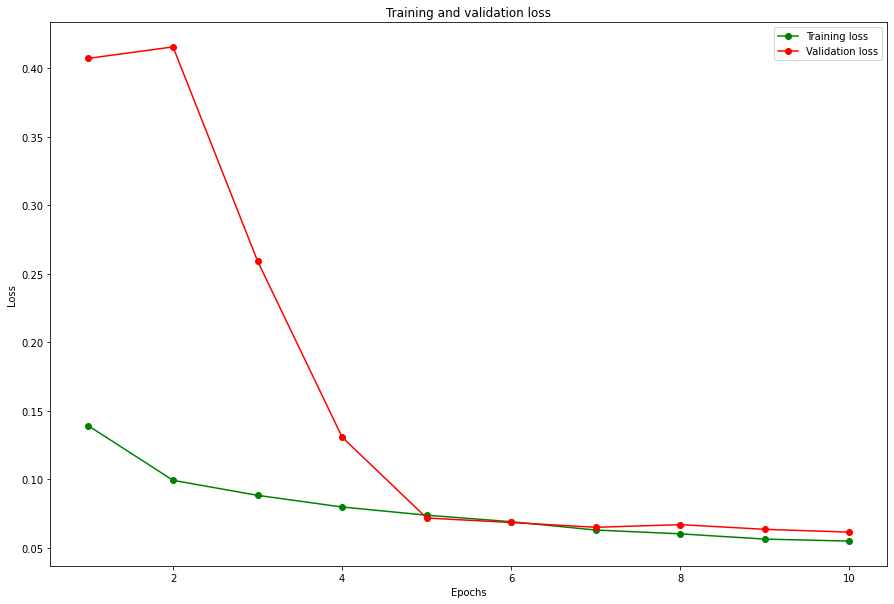

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'green', label='Training loss', marker = 'o')
plt.plot(epochs, val_loss, 'r', label='Validation loss', marker = 'o')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('loss_graph.png')
plt.show()

In [31]:
acc = history.history['one_hot_io_u']
val_acc = history.history['val_one_hot_io_u']

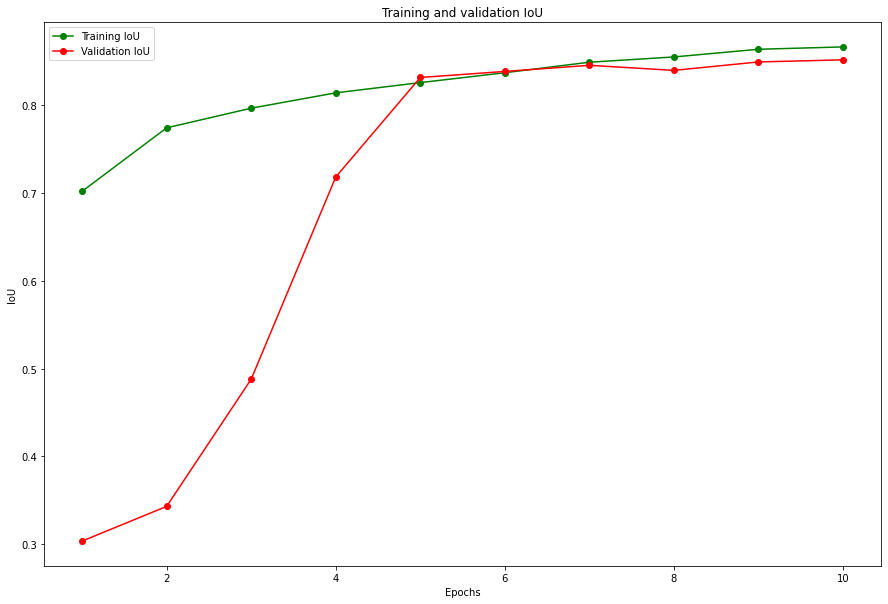

In [32]:
plt.figure(figsize=(15,10))
plt.plot(epochs, acc, 'green', label='Training IoU', marker = 'o')
plt.plot(epochs, val_acc, 'r', label='Validation IoU', marker = 'o')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
# plt.savefig('auccuracy_graph.png')
plt.show()

In [33]:
from keras.models import load_model

model = load_model(filepath, compile=False)

In [34]:
from tensorflow.keras.metrics import MeanIoU

In [35]:
test_image_batch, test_mask_batch = next(iter(valid_dataset))

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 2s 2s/step


Mean IoU =

0.8349081

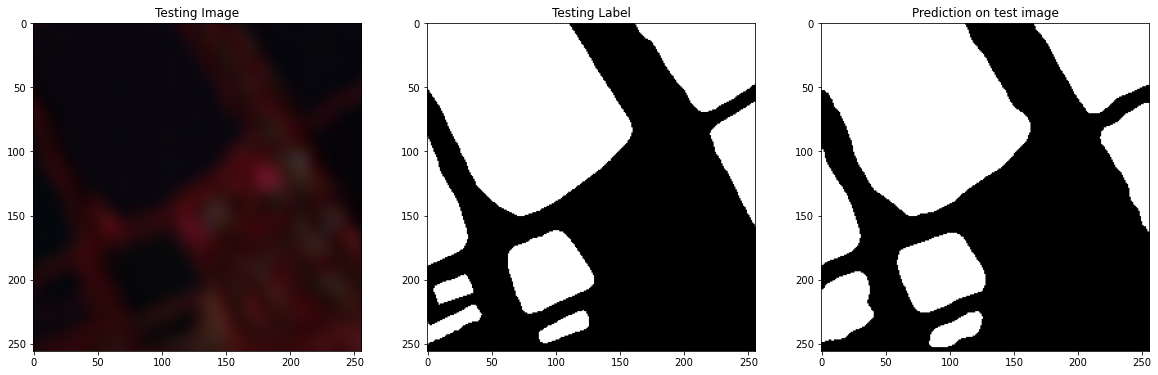

In [36]:
img_num = random.randint(0, test_image_batch.shape[0]-1)
image = test_image_batch[img_num]
plt.figure(figsize=(20,20))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(image[:,:,0:3])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num], cmap='gray')
plt.show()

In [37]:
No_of_valid_data = int(number_of_shards*filespershard*0.3)

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

In [39]:
test_image_batch, test_mask_batch = next(iter(valid_dataset.unbatch().batch(No_of_valid_data)))
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

 1/71 [..............................] - ETA: 1:02

 3/71 [>.............................] - ETA: 2s  

 4/71 [>.............................] - ETA: 3s

 5/71 [=>............................] - ETA: 3s

 6/71 [=>............................] - ETA: 3s

 7/71 [=>............................] - ETA: 3s

 8/71 [==>...........................] - ETA: 3s

 9/71 [==>...........................] - ETA: 3s

10/71 [===>..........................] - ETA: 3s

11/71 [===>..........................] - ETA: 3s

12/71 [====>.........................] - ETA: 3s

13/71 [====>.........................] - ETA: 3s

14/71 [====>.........................] - ETA: 3s

15/71 [=====>........................] - ETA: 3s

16/71 [=====>........................] - ETA: 3s

17/71 [======>.......................] - ETA: 3s

18/71 [======>.......................] - ETA: 3s

19/71 [=======>......................] - ETA: 3s

20/71 [=======>......................] - ETA: 3s

21/71 [=======>......................] - ETA: 3s

22/71 [========>.....................] - ETA: 3s

23/71 [========>.....................] - ETA: 2s

24/71 [=========>....................] - ETA: 2s

25/71 [=========>....................] - ETA: 2s

26/71 [=========>....................] - ETA: 2s

27/71 [==========>...................] - ETA: 2s

28/71 [==========>...................] - ETA: 2s

29/71 [===========>..................] - ETA: 2s

30/71 [===========>..................] - ETA: 2s

31/71 [============>.................] - ETA: 2s

32/71 [============>.................] - ETA: 2s

33/71 [============>.................] - ETA: 2s

34/71 [=============>................] - ETA: 2s

35/71 [=============>................] - ETA: 2s

36/71 [==============>...............] - ETA: 2s

37/71 [==============>...............] - ETA: 2s

38/71 [===============>..............] - ETA: 2s

39/71 [===============>..............] - ETA: 2s

40/71 [===============>..............] - ETA: 1s

41/71 [================>.............] - ETA: 1s

42/71 [================>.............] - ETA: 1s

43/71 [=================>............] - ETA: 1s

44/71 [=================>............] - ETA: 1s

45/71 [==================>...........] - ETA: 1s

46/71 [==================>...........] - ETA: 1s

47/71 [==================>...........] - ETA: 1s

48/71 [===================>..........] - ETA: 1s

49/71 [===================>..........] - ETA: 1s

50/71 [====================>.........] - ETA: 1s

51/71 [====================>.........] - ETA: 1s

52/71 [====================>.........] - ETA: 1s

53/71 [=====================>........] - ETA: 1s

54/71 [=====================>........] - ETA: 1s

55/71 [======================>.......] - ETA: 1s

56/71 [======================>.......] - ETA: 0s

57/71 [=======================>......] - ETA: 0s

58/71 [=======================>......] - ETA: 0s

59/71 [=======================>......] - ETA: 0s

60/71 [========================>.....] - ETA: 0s

61/71 [========================>.....] - ETA: 0s

62/71 [=========================>....] - ETA: 0s

63/71 [=========================>....] - ETA: 0s

64/71 [==========================>...] - ETA: 0s

65/71 [==========================>...] - ETA: 0s

66/71 [==========================>...] - ETA: 0s

67/71 [===========================>..] - ETA: 0s

68/71 [===========================>..] - ETA: 0s

69/71 [============================>.] - ETA: 0s

70/71 [============================>.] - ETA: 0s

71/71 [==============================] - ETA: 0s

71/71 [==============================] - 6s 70ms/step


In [40]:
cm = confusion_matrix(test_mask_batch_argmax.flatten(),test_pred_batch_argmax.flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non_ponds','ponds'])

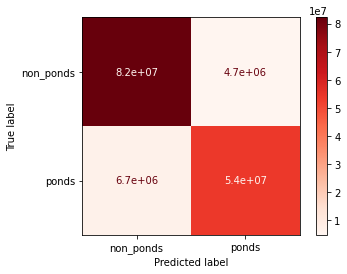

In [41]:
disp.plot(cmap=plt.cm.Reds)
plt.savefig('confusion_matrix.png')
plt.show()